In [1]:
from tqdm import tqdm

In [2]:
import torchvision

In [3]:
from glob import glob
import os
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision import models
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.optim import lr_scheduler
from torch import optim
from torchvision.utils import make_grid
from torch.utils.data import Dataset
import torch.nn.functional as F
import time
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt

In [5]:
import joblib
import numpy as np

In [6]:
train_x = joblib.load('./train_fmnist_x_exp_02.pkl')
train_y = joblib.load('./train_fmnist_y_exp_02.pkl')

# train_x = joblib.load('./train_fmnist_x_exp_inf.pkl')
# train_y = joblib.load('./train_fmnist_y_exp_inf.pkl')

# train_x = joblib.load('./train_mnist_x_exp_inf.pkl')
# train_y = joblib.load('./train_mnist_y_exp_inf.pkl')

# train_x = joblib.load('./train_mnist_x_exp10_k5.pkl')
# train_y = joblib.load('./train_mnist_y_exp10_k5.pkl')


In [7]:
len(train_x), len(train_y)

(2816, 2816)

In [8]:
import torch

In [9]:
from torchvision.datasets import FashionMNIST, MNIST

In [10]:
class TrainFMNIST(Dataset):
    
    def __init__(self, x, y):
        
        self.x = torch.tensor(x).float()
        self.y = torch.tensor(y).float()
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):   
        sample = [self.x[index][:1, ...], int(torch.argmax(self.y[index]))]
        
        return sample


In [11]:
train_dl = TrainFMNIST(train_x, train_y)

In [12]:
x, y = train_dl[0]

In [13]:
y

0

In [14]:
x.shape, y

(torch.Size([1, 28, 28]), 0)

In [15]:
test_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor()
])

valid_dl = FashionMNIST(os.path.join('./exp', 'datasets', 'fashion_mnist_test'), train=False, download=True,
                               transform=test_transform)


In [16]:
# test_transform = transforms.Compose([
#     transforms.Resize(28),
#     transforms.ToTensor()
# ])

# valid_dl = MNIST(os.path.join('./exp', 'datasets', 'mnist_test'), train=False, download=True,
#                                transform=test_transform)


In [17]:
x, y = valid_dl[0]

In [18]:
x.shape, y

(torch.Size([1, 28, 28]), 9)

In [19]:
train_dataloader = torch.utils.data.DataLoader(train_dl, shuffle = True, batch_size = 256, num_workers = 4)
valid_dataloader = torch.utils.data.DataLoader(valid_dl, shuffle = True, batch_size = 256, num_workers = 4)


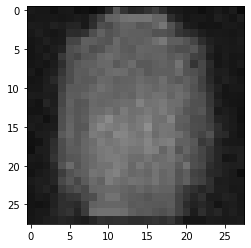

In [20]:
plt.imshow(torchvision.utils.make_grid(train_dl[6][0]).permute(1, 2, 0))

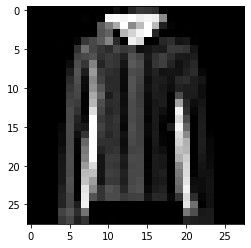

In [21]:
plt.imshow(torchvision.utils.make_grid(valid_dl[6][0]).permute(1, 2, 0))

In [22]:
class MultiClassifier(nn.Module):
    def __init__(self):
        super(MultiClassifier, self).__init__()
        self.ConvLayer1 = nn.Sequential(
            nn.Conv2d(1, 32, 3), # 3, 256, 256
            nn.MaxPool2d(2), # op: 16, 127, 127
            nn.ReLU(), # op: 64, 127, 127
            nn.Dropout(0.2),
        )
        self.ConvLayer2 = nn.Sequential(
            nn.Conv2d(32, 64, 3), # 64, 127, 127   
            nn.MaxPool2d(2), #op: 128, 63, 63
            nn.ReLU(), # op: 128, 63, 63
            nn.Dropout(0.25),
        )
        
        self.Linear1 = nn.Linear(1600, 64)
        self.Linear2 = nn.Linear(64, 10)
        
        
        
    def forward(self, x):
        x = self.ConvLayer1(x)
        x = self.ConvLayer2(x)        
        x = x.view(x.size(0), -1)
        x = self.Linear1(x)
        x = self.Linear2(x)
        return F.softmax(x)



In [23]:
def check_cuda():
    _cuda = False
    if torch.cuda.is_available():
        _cuda = True
    return _cuda


In [24]:
is_cuda = check_cuda()


In [25]:
model = MultiClassifier()
if is_cuda:
    model.cuda()


In [26]:
x = train_dl[0][0].unsqueeze(0).cuda()

In [27]:
model(x).shape

/tmp/ipykernel_22970/1466334388.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


torch.Size([1, 10])

In [28]:
train_dataloader = torch.utils.data.DataLoader(train_dl, shuffle = True, batch_size = 256, num_workers = 4)
valid_dataloader = torch.utils.data.DataLoader(valid_dl, shuffle = True, batch_size = 256, num_workers = 4)


In [29]:
def pred_acc(original, predicted):
    return torch.round(predicted).eq(original).sum().numpy()/len(original)


In [30]:
criterion = nn.BCELoss()
# optimizer = optim.SGD(model.parameters(), lr = 0.0001, momentum = 0.9)
optimizer = optim.SGD(model.parameters(), lr = 5e-2)
# optimizer = optim.Adam(model.parameters(), lr = 0.001)


In [31]:
from pprint import pprint


In [32]:
model.train()

MultiClassifier(
  (ConvLayer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (ConvLayer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Dropout(p=0.25, inplace=False)
  )
  (Linear1): Linear(in_features=1600, out_features=64, bias=True)
  (Linear2): Linear(in_features=64, out_features=10, bias=True)
)

In [33]:
def fit_model(epochs, model, dataloader, phase = 'training', volatile = False):
    
    pprint("Epoch: {}".format(epochs))

    if phase == 'training':
        model.train()
        
    if phase == 'validataion':
        model.eval()
        volatile = True
        
    running_loss = []
    running_acc = []
    
    for i, data in enumerate(dataloader):
        
        inputs, target = data[0].cuda(), torch.eye(10)[data[1]].cuda()        
        inputs, target = Variable(inputs), Variable(target)
        
        if phase == 'training':
            optimizer.zero_grad()
            
        ops = model(inputs)
        
        acc_ = []
        for i, d in enumerate(ops, 0):
           
            acc = pred_acc(torch.Tensor.cpu(target[i]), torch.Tensor.cpu(d))
            acc_.append(acc)

        loss = criterion(ops, target)
                
        running_loss.append(loss.item())
        running_acc.append(np.asarray(acc_).mean())
       
        if phase == 'training':
            loss.backward()
            optimizer.step()
            
    total_batch_loss = np.asarray(running_loss).mean()
    total_batch_acc = np.asarray(running_acc).mean()
    

    pprint("{} loss is {} ".format(phase,total_batch_loss))
    pprint("{} accuracy is {} ".format(phase, total_batch_acc))

    
    return total_batch_loss, total_batch_acc


In [34]:
inputs, target = next(iter(train_dataloader))

In [35]:
ops = model(inputs.cuda())

/tmp/ipykernel_22970/1466334388.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


In [36]:
trn_losses = []; trn_acc = []
val_losses = []; val_acc = []


In [37]:
for i in tqdm(range(1, 2500)):
    trn_l, trn_a = fit_model(i, model, train_dataloader)
    val_l, val_a = fit_model(i, model, valid_dataloader, phase = 'validation')
    trn_losses.append(trn_l); trn_acc.append(trn_a)
    val_losses.append(val_l); val_acc.append(val_a)


  0%|          | 0/2499 [00:00<?, ?it/s]

'Epoch: 1'


/tmp/ipykernel_22970/1466334388.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


'training loss is 0.3163914436643774 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1'


  0%|          | 1/2499 [00:02<1:51:20,  2.67s/it]

'validation loss is 0.32875495329499244 '
'validation accuracy is 0.9000000000000001 '
'Epoch: 2'
'training loss is 0.2859352041374553 '
'training accuracy is 0.9000000000000002 '
'Epoch: 2'


  0%|          | 2/2499 [00:05<1:49:50,  2.64s/it]

'validation loss is 0.34250020459294317 '
'validation accuracy is 0.9000000000000001 '
'Epoch: 3'
'training loss is 0.24853378263386813 '
'training accuracy is 0.9000000000000002 '
'Epoch: 3'


  0%|          | 3/2499 [00:07<1:50:21,  2.65s/it]

'validation loss is 0.3863357126712799 '
'validation accuracy is 0.9000000000000001 '
'Epoch: 4'
'training loss is 0.21886267445304178 '
'training accuracy is 0.9000000000000002 '
'Epoch: 4'


  0%|          | 4/2499 [00:10<1:47:28,  2.58s/it]

'validation loss is 0.4477830953896046 '
'validation accuracy is 0.8998632812500003 '
'Epoch: 5'
'training loss is 0.20520778406750073 '
'training accuracy is 0.9000000000000002 '
'Epoch: 5'


  0%|          | 5/2499 [00:12<1:47:03,  2.58s/it]

'validation loss is 0.491655258089304 '
'validation accuracy is 0.8991015625000003 '
'Epoch: 6'
'training loss is 0.19946772131052884 '
'training accuracy is 0.9000000000000002 '
'Epoch: 6'


  0%|          | 6/2499 [00:16<1:54:40,  2.76s/it]

'validation loss is 0.5271462969481945 '
'validation accuracy is 0.8991308593750003 '
'Epoch: 7'
'training loss is 0.1967857154932889 '
'training accuracy is 0.9000000000000002 '
'Epoch: 7'


  0%|          | 7/2499 [00:18<1:48:06,  2.60s/it]

'validation loss is 0.5572049900889396 '
'validation accuracy is 0.9000000000000001 '
'Epoch: 8'
'training loss is 0.19519812816923315 '
'training accuracy is 0.9000000000000002 '
'Epoch: 8'


  0%|          | 8/2499 [00:20<1:44:41,  2.52s/it]

'validation loss is 0.5818600073456764 '
'validation accuracy is 0.8996484375000001 '
'Epoch: 9'
'training loss is 0.19417978552254764 '
'training accuracy is 0.9000000000000002 '
'Epoch: 9'


  0%|          | 9/2499 [00:23<1:49:03,  2.63s/it]

'validation loss is 0.6009944289922714 '
'validation accuracy is 0.8995898437500003 '
'Epoch: 10'
'training loss is 0.19362306052988226 '
'training accuracy is 0.9000000000000002 '
'Epoch: 10'


  0%|          | 10/2499 [00:26<1:47:29,  2.59s/it]

'validation loss is 0.6170006439089775 '
'validation accuracy is 0.8995605468750002 '
'Epoch: 11'
'training loss is 0.19322836805473675 '
'training accuracy is 0.9000000000000002 '
'Epoch: 11'


  0%|          | 11/2499 [00:28<1:46:23,  2.57s/it]

'validation loss is 0.6288471430540085 '
'validation accuracy is 0.8994824218750003 '
'Epoch: 12'
'training loss is 0.19308818605813113 '
'training accuracy is 0.9000000000000002 '
'Epoch: 12'


  0%|          | 12/2499 [00:30<1:41:29,  2.45s/it]

'validation loss is 0.641481052339077 '
'validation accuracy is 0.8994140625000002 '
'Epoch: 13'
'training loss is 0.19302193414081226 '
'training accuracy is 0.9000000000000002 '
'Epoch: 13'


  1%|          | 13/2499 [00:33<1:45:17,  2.54s/it]

'validation loss is 0.6488005146384239 '
'validation accuracy is 0.8991992187500001 '
'Epoch: 14'
'training loss is 0.19266934286464343 '
'training accuracy is 0.9000000000000002 '
'Epoch: 14'


  1%|          | 14/2499 [00:36<1:47:46,  2.60s/it]

'validation loss is 0.658272984623909 '
'validation accuracy is 0.899140625 '
'Epoch: 15'
'training loss is 0.19275918738408523 '
'training accuracy is 0.9000000000000002 '
'Epoch: 15'


  1%|          | 15/2499 [00:38<1:45:56,  2.56s/it]

'validation loss is 0.670055827498436 '
'validation accuracy is 0.8991308593750003 '
'Epoch: 16'
'training loss is 0.19293404573743994 '
'training accuracy is 0.9000000000000002 '
'Epoch: 16'


  1%|          | 16/2499 [00:41<1:51:45,  2.70s/it]

'validation loss is 0.6729178443551064 '
'validation accuracy is 0.8995898437500003 '
'Epoch: 17'
'training loss is 0.19250547614964572 '
'training accuracy is 0.9000000000000002 '
'Epoch: 17'


  1%|          | 17/2499 [00:44<1:46:49,  2.58s/it]

'validation loss is 0.6805624514818192 '
'validation accuracy is 0.8991113281250002 '
'Epoch: 18'
'training loss is 0.19285385717045178 '
'training accuracy is 0.9000000000000002 '
'Epoch: 18'


  1%|          | 18/2499 [00:46<1:43:47,  2.51s/it]

'validation loss is 0.6910272926092148 '
'validation accuracy is 0.8995019531250004 '
'Epoch: 19'
'training loss is 0.19237596609375693 '
'training accuracy is 0.9000000000000002 '
'Epoch: 19'


  1%|          | 19/2499 [00:49<1:45:47,  2.56s/it]

'validation loss is 0.6887833505868912 '
'validation accuracy is 0.8978417968750001 '
'Epoch: 20'
'training loss is 0.1924544410272078 '
'training accuracy is 0.9000000000000002 '
'Epoch: 20'


  1%|          | 20/2499 [00:51<1:46:45,  2.58s/it]

'validation loss is 0.6989468321204185 '
'validation accuracy is 0.89865234375 '
'Epoch: 21'
'training loss is 0.1926659115336158 '
'training accuracy is 0.9000000000000002 '
'Epoch: 21'


  1%|          | 21/2499 [00:54<1:48:44,  2.63s/it]

'validation loss is 0.6987059339880943 '
'validation accuracy is 0.8994335937500002 '
'Epoch: 22'
'training loss is 0.19245179132981735 '
'training accuracy is 0.9000000000000002 '
'Epoch: 22'


  1%|          | 22/2499 [00:56<1:47:59,  2.62s/it]

'validation loss is 0.7013112545013428 '
'validation accuracy is 0.8997949218750001 '
'Epoch: 23'
'training loss is 0.19207655028863388 '
'training accuracy is 0.9000000000000002 '
'Epoch: 23'


  1%|          | 23/2499 [00:59<1:47:12,  2.60s/it]

'validation loss is 0.7113110572099686 '
'validation accuracy is 0.8998242187500004 '
'Epoch: 24'
'training loss is 0.19187399338592181 '
'training accuracy is 0.9000000000000002 '
'Epoch: 24'


  1%|          | 24/2499 [01:01<1:44:28,  2.53s/it]

'validation loss is 0.7105572283267975 '
'validation accuracy is 0.8997851562500003 '
'Epoch: 25'
'training loss is 0.19235907765952023 '
'training accuracy is 0.9000000000000002 '
'Epoch: 25'


  1%|          | 25/2499 [01:04<1:44:44,  2.54s/it]

'validation loss is 0.7132045596837997 '
'validation accuracy is 0.8999218750000002 '
'Epoch: 26'
'training loss is 0.192065415057269 '
'training accuracy is 0.9000000000000002 '
'Epoch: 26'


  1%|          | 26/2499 [01:07<1:44:41,  2.54s/it]

'validation loss is 0.7156491041183471 '
'validation accuracy is 0.8981250000000003 '
'Epoch: 27'
'training loss is 0.1918242953040383 '
'training accuracy is 0.9000000000000002 '
'Epoch: 27'


  1%|          | 27/2499 [01:09<1:49:14,  2.65s/it]

'validation loss is 0.7194024756550789 '
'validation accuracy is 0.8991503906250001 '
'Epoch: 28'
'training loss is 0.19248016449538144 '
'training accuracy is 0.8999644886363639 '
'Epoch: 28'


  1%|          | 28/2499 [01:12<1:46:47,  2.59s/it]

'validation loss is 0.7152026571333409 '
'validation accuracy is 0.8995800781250001 '
'Epoch: 29'
'training loss is 0.19237993522123856 '
'training accuracy is 0.9000000000000002 '
'Epoch: 29'


  1%|          | 29/2499 [01:14<1:43:32,  2.52s/it]

'validation loss is 0.7239808544516564 '
'validation accuracy is 0.8996875000000003 '
'Epoch: 30'
'training loss is 0.19217372888868506 '
'training accuracy is 0.9000000000000002 '
'Epoch: 30'


  1%|          | 30/2499 [01:17<1:46:55,  2.60s/it]

'validation loss is 0.7235487639904022 '
'validation accuracy is 0.8999511718750002 '
'Epoch: 31'
'training loss is 0.19207544895735654 '
'training accuracy is 0.9000000000000002 '
'Epoch: 31'


  1%|          | 31/2499 [01:20<1:49:29,  2.66s/it]

'validation loss is 0.7281016200780869 '
'validation accuracy is 0.8978222656250004 '
'Epoch: 32'
'training loss is 0.19220589372244748 '
'training accuracy is 0.9000000000000002 '
'Epoch: 32'


  1%|▏         | 32/2499 [01:23<1:50:37,  2.69s/it]

'validation loss is 0.7286851644515991 '
'validation accuracy is 0.8998535156250004 '
'Epoch: 33'
'training loss is 0.19218481941656632 '
'training accuracy is 0.9000000000000002 '
'Epoch: 33'


  1%|▏         | 33/2499 [01:25<1:47:35,  2.62s/it]

'validation loss is 0.7262938797473908 '
'validation accuracy is 0.8985156250000003 '
'Epoch: 34'
'training loss is 0.19205513054674322 '
'training accuracy is 0.9000000000000002 '
'Epoch: 34'


  1%|▏         | 34/2499 [01:28<1:45:51,  2.58s/it]

'validation loss is 0.7347716584801673 '
'validation accuracy is 0.8979687500000002 '
'Epoch: 35'
'training loss is 0.19256972047415646 '
'training accuracy is 0.9000000000000002 '
'Epoch: 35'


  1%|▏         | 35/2499 [01:30<1:44:57,  2.56s/it]

'validation loss is 0.7340011104941369 '
'validation accuracy is 0.8979785156250003 '
'Epoch: 36'
'training loss is 0.19230869818817486 '
'training accuracy is 0.9000000000000002 '
'Epoch: 36'


  1%|▏         | 36/2499 [01:33<1:44:55,  2.56s/it]

'validation loss is 0.7289934471249581 '
'validation accuracy is 0.8999023437500002 '
'Epoch: 37'
'training loss is 0.1922114762392911 '
'training accuracy is 0.9000000000000002 '
'Epoch: 37'


  1%|▏         | 37/2499 [01:35<1:44:05,  2.54s/it]

'validation loss is 0.7340669184923172 '
'validation accuracy is 0.8999121093750002 '
'Epoch: 38'
'training loss is 0.1922207854010842 '
'training accuracy is 0.9000000000000002 '
'Epoch: 38'


  2%|▏         | 38/2499 [01:38<1:44:42,  2.55s/it]

'validation loss is 0.7351777970790863 '
'validation accuracy is 0.8994335937500001 '
'Epoch: 39'
'training loss is 0.19241544604301453 '
'training accuracy is 0.9000000000000002 '
'Epoch: 39'


  2%|▏         | 39/2499 [01:40<1:40:12,  2.44s/it]

'validation loss is 0.7360100686550141 '
'validation accuracy is 0.8993652343750002 '
'Epoch: 40'
'training loss is 0.19198592549020593 '
'training accuracy is 0.9000000000000002 '
'Epoch: 40'


  2%|▏         | 40/2499 [01:42<1:39:52,  2.44s/it]

'validation loss is 0.7372148424386978 '
'validation accuracy is 0.8965429687500002 '
'Epoch: 41'
'training loss is 0.19194822013378143 '
'training accuracy is 0.9000000000000002 '
'Epoch: 41'


  2%|▏         | 41/2499 [01:45<1:39:28,  2.43s/it]

'validation loss is 0.7430161982774734 '
'validation accuracy is 0.8986328125000002 '
'Epoch: 42'
'training loss is 0.19180069999261337 '
'training accuracy is 0.9000000000000002 '
'Epoch: 42'


  2%|▏         | 42/2499 [01:47<1:40:44,  2.46s/it]

'validation loss is 0.7399456337094307 '
'validation accuracy is 0.8987109375000003 '
'Epoch: 43'
'training loss is 0.19214350120587784 '
'training accuracy is 0.9000000000000002 '
'Epoch: 43'


  2%|▏         | 43/2499 [01:50<1:46:20,  2.60s/it]

'validation loss is 0.7394568786025048 '
'validation accuracy is 0.8970996093750003 '
'Epoch: 44'
'training loss is 0.1923952509056438 '
'training accuracy is 0.9000000000000002 '
'Epoch: 44'


  2%|▏         | 44/2499 [01:53<1:47:54,  2.64s/it]

'validation loss is 0.7390163570642472 '
'validation accuracy is 0.8993554687500002 '
'Epoch: 45'
'training loss is 0.19235847619446841 '
'training accuracy is 0.9000000000000002 '
'Epoch: 45'


  2%|▏         | 45/2499 [01:56<1:48:49,  2.66s/it]

'validation loss is 0.7374389290809631 '
'validation accuracy is 0.8997558593750004 '
'Epoch: 46'
'training loss is 0.19190628284757788 '
'training accuracy is 0.9000000000000002 '
'Epoch: 46'


  2%|▏         | 46/2499 [01:59<1:52:38,  2.76s/it]

'validation loss is 0.7439518511295319 '
'validation accuracy is 0.8993554687500003 '
'Epoch: 47'
'training loss is 0.19231032512404703 '
'training accuracy is 0.9000000000000002 '
'Epoch: 47'


  2%|▏         | 47/2499 [02:01<1:48:16,  2.65s/it]

'validation loss is 0.7428680658340454 '
'validation accuracy is 0.8991699218750002 '
'Epoch: 48'
'training loss is 0.19249525395306674 '
'training accuracy is 0.9000000000000002 '
'Epoch: 48'


  2%|▏         | 48/2499 [02:04<1:47:56,  2.64s/it]

'validation loss is 0.740892493724823 '
'validation accuracy is 0.8992480468750003 '
'Epoch: 49'
'training loss is 0.19204731285572052 '
'training accuracy is 0.9000000000000002 '
'Epoch: 49'


  2%|▏         | 49/2499 [02:07<1:53:00,  2.77s/it]

'validation loss is 0.74055617749691 '
'validation accuracy is 0.8999023437500003 '
'Epoch: 50'
'training loss is 0.19209403070536527 '
'training accuracy is 0.9000000000000002 '
'Epoch: 50'


  2%|▏         | 50/2499 [02:09<1:51:39,  2.74s/it]

'validation loss is 0.7428121089935302 '
'validation accuracy is 0.8999023437500002 '
'Epoch: 51'
'training loss is 0.19201759587634692 '
'training accuracy is 0.9000000000000002 '
'Epoch: 51'


  2%|▏         | 51/2499 [02:12<1:49:10,  2.68s/it]

'validation loss is 0.7471470728516578 '
'validation accuracy is 0.8889062500000003 '
'Epoch: 52'
'training loss is 0.19197990677573465 '
'training accuracy is 0.9000000000000002 '
'Epoch: 52'


  2%|▏         | 52/2499 [02:14<1:46:14,  2.61s/it]

'validation loss is 0.7522204637527465 '
'validation accuracy is 0.8953027343750002 '
'Epoch: 53'
'training loss is 0.19192107021808624 '
'training accuracy is 0.9000000000000002 '
'Epoch: 53'


  2%|▏         | 53/2499 [02:17<1:42:10,  2.51s/it]

'validation loss is 0.7471010535955429 '
'validation accuracy is 0.8989160156250001 '
'Epoch: 54'
'training loss is 0.19210062379186804 '
'training accuracy is 0.9000000000000002 '
'Epoch: 54'


  2%|▏         | 54/2499 [02:19<1:42:24,  2.51s/it]

'validation loss is 0.7433220461010933 '
'validation accuracy is 0.8996386718750002 '
'Epoch: 55'
'training loss is 0.19226050241426987 '
'training accuracy is 0.9000000000000002 '
'Epoch: 55'


  2%|▏         | 55/2499 [02:22<1:43:32,  2.54s/it]

'validation loss is 0.7464008092880249 '
'validation accuracy is 0.8978808593750003 '
'Epoch: 56'
'training loss is 0.19185640188780698 '
'training accuracy is 0.9000000000000002 '
'Epoch: 56'


  2%|▏         | 56/2499 [02:24<1:41:06,  2.48s/it]

'validation loss is 0.7506719246506691 '
'validation accuracy is 0.8911816406250003 '
'Epoch: 57'
'training loss is 0.1922947574745525 '
'training accuracy is 0.9000000000000002 '
'Epoch: 57'


  2%|▏         | 57/2499 [02:27<1:43:31,  2.54s/it]

'validation loss is 0.7517304569482803 '
'validation accuracy is 0.8991308593750003 '
'Epoch: 58'
'training loss is 0.19222531399943613 '
'training accuracy is 0.9000000000000002 '
'Epoch: 58'


  2%|▏         | 58/2499 [02:29<1:45:30,  2.59s/it]

'validation loss is 0.7494072914123535 '
'validation accuracy is 0.8997070312500002 '
'Epoch: 59'
'training loss is 0.19202278418974442 '
'training accuracy is 0.9000000000000002 '
'Epoch: 59'


  2%|▏         | 59/2499 [02:32<1:48:06,  2.66s/it]

'validation loss is 0.7479938000440598 '
'validation accuracy is 0.8982617187500004 '
'Epoch: 60'
'training loss is 0.1921198530630632 '
'training accuracy is 0.9000000000000002 '
'Epoch: 60'


  2%|▏         | 60/2499 [02:35<1:48:28,  2.67s/it]

'validation loss is 0.7474186599254609 '
'validation accuracy is 0.8986621093750002 '
'Epoch: 61'
'training loss is 0.19202939895066348 '
'training accuracy is 0.9000000000000002 '
'Epoch: 61'


  2%|▏         | 61/2499 [02:37<1:42:30,  2.52s/it]

'validation loss is 0.7476479679346084 '
'validation accuracy is 0.8995019531250001 '
'Epoch: 62'
'training loss is 0.19221962717446414 '
'training accuracy is 0.9000000000000002 '
'Epoch: 62'


  2%|▏         | 62/2499 [02:39<1:38:42,  2.43s/it]

'validation loss is 0.7516709461808204 '
'validation accuracy is 0.8998144531250002 '
'Epoch: 63'
'training loss is 0.19238063151186163 '
'training accuracy is 0.9000000000000002 '
'Epoch: 63'


  3%|▎         | 63/2499 [02:42<1:39:50,  2.46s/it]

'validation loss is 0.7524012014269829 '
'validation accuracy is 0.8993945312500002 '
'Epoch: 64'
'training loss is 0.19179961491714825 '
'training accuracy is 0.9000000000000002 '
'Epoch: 64'


  3%|▎         | 64/2499 [02:45<1:42:23,  2.52s/it]

'validation loss is 0.7453981131315232 '
'validation accuracy is 0.8992773437500002 '
'Epoch: 65'
'training loss is 0.19205246459354053 '
'training accuracy is 0.9000000000000002 '
'Epoch: 65'


  3%|▎         | 65/2499 [02:47<1:43:24,  2.55s/it]

'validation loss is 0.7496476501226426 '
'validation accuracy is 0.8996679687500002 '
'Epoch: 66'
'training loss is 0.19151036170395938 '
'training accuracy is 0.9000000000000002 '
'Epoch: 66'


  3%|▎         | 66/2499 [02:50<1:45:07,  2.59s/it]

'validation loss is 0.7543983086943626 '
'validation accuracy is 0.8994238281250002 '
'Epoch: 67'
'training loss is 0.191672375256365 '
'training accuracy is 0.9000000000000002 '
'Epoch: 67'


  3%|▎         | 67/2499 [02:52<1:45:53,  2.61s/it]

'validation loss is 0.748585295677185 '
'validation accuracy is 0.8982226562500003 '
'Epoch: 68'
'training loss is 0.1918755823915655 '
'training accuracy is 0.9000000000000002 '
'Epoch: 68'


  3%|▎         | 68/2499 [02:55<1:48:02,  2.67s/it]

'validation loss is 0.7514714121818542 '
'validation accuracy is 0.8996777343750002 '
'Epoch: 69'
'training loss is 0.19201354546980423 '
'training accuracy is 0.9000000000000002 '
'Epoch: 69'


  3%|▎         | 69/2499 [02:58<1:48:23,  2.68s/it]

'validation loss is 0.7566062197089195 '
'validation accuracy is 0.8990234375000001 '
'Epoch: 70'
'training loss is 0.19170627404343 '
'training accuracy is 0.9000000000000002 '
'Epoch: 70'


  3%|▎         | 70/2499 [03:01<1:48:59,  2.69s/it]

'validation loss is 0.7541770458221435 '
'validation accuracy is 0.8993164062500002 '
'Epoch: 71'
'training loss is 0.19190771200440146 '
'training accuracy is 0.9000000000000002 '
'Epoch: 71'


  3%|▎         | 71/2499 [03:03<1:48:42,  2.69s/it]

'validation loss is 0.7514168858528137 '
'validation accuracy is 0.8994824218750003 '
'Epoch: 72'
'training loss is 0.19219974767078052 '
'training accuracy is 0.9000000000000002 '
'Epoch: 72'


  3%|▎         | 72/2499 [03:06<1:50:37,  2.73s/it]

'validation loss is 0.7539793446660041 '
'validation accuracy is 0.8980664062500002 '
'Epoch: 73'
'training loss is 0.192072563550689 '
'training accuracy is 0.9000000000000002 '
'Epoch: 73'


  3%|▎         | 73/2499 [03:09<1:49:18,  2.70s/it]

'validation loss is 0.7546208679676056 '
'validation accuracy is 0.8991113281250002 '
'Epoch: 74'
'training loss is 0.1920452510768717 '
'training accuracy is 0.9000000000000002 '
'Epoch: 74'


  3%|▎         | 74/2499 [03:11<1:48:21,  2.68s/it]

'validation loss is 0.7488333746790886 '
'validation accuracy is 0.8999511718750002 '
'Epoch: 75'
'training loss is 0.19183787297118793 '
'training accuracy is 0.9000000000000002 '
'Epoch: 75'


  3%|▎         | 75/2499 [03:15<1:55:00,  2.85s/it]

'validation loss is 0.7505188480019569 '
'validation accuracy is 0.8998730468750002 '
'Epoch: 76'
'training loss is 0.19201001660390335 '
'training accuracy is 0.9000000000000002 '
'Epoch: 76'


  3%|▎         | 76/2499 [03:17<1:52:32,  2.79s/it]

'validation loss is 0.7569715604186058 '
'validation accuracy is 0.8997949218750001 '
'Epoch: 77'
'training loss is 0.1920677897605029 '
'training accuracy is 0.9000000000000002 '
'Epoch: 77'


  3%|▎         | 77/2499 [03:20<1:51:08,  2.75s/it]

'validation loss is 0.7563366994261742 '
'validation accuracy is 0.8985644531250003 '
'Epoch: 78'
'training loss is 0.19185287979516116 '
'training accuracy is 0.9000000000000002 '
'Epoch: 78'


  3%|▎         | 78/2499 [03:23<1:51:14,  2.76s/it]

'validation loss is 0.7566110894083977 '
'validation accuracy is 0.8984570312500002 '
'Epoch: 79'
'training loss is 0.19195241006937894 '
'training accuracy is 0.9000000000000002 '
'Epoch: 79'


  3%|▎         | 79/2499 [03:26<1:52:02,  2.78s/it]

'validation loss is 0.7515747487545014 '
'validation accuracy is 0.8999023437500003 '
'Epoch: 80'
'training loss is 0.19201108135960318 '
'training accuracy is 0.9000000000000002 '
'Epoch: 80'


  3%|▎         | 80/2499 [03:29<1:53:15,  2.81s/it]

'validation loss is 0.7555358141660691 '
'validation accuracy is 0.8985156250000003 '
'Epoch: 81'
'training loss is 0.19250122119079938 '
'training accuracy is 0.9000000000000002 '
'Epoch: 81'


  3%|▎         | 81/2499 [03:31<1:51:11,  2.76s/it]

'validation loss is 0.7507882535457611 '
'validation accuracy is 0.8997070312500004 '
'Epoch: 82'
'training loss is 0.19191235303878784 '
'training accuracy is 0.9000000000000002 '
'Epoch: 82'


  3%|▎         | 82/2499 [03:34<1:51:54,  2.78s/it]

'validation loss is 0.7485453009605407 '
'validation accuracy is 0.8997558593750001 '
'Epoch: 83'
'training loss is 0.1920885077931664 '
'training accuracy is 0.9000000000000002 '
'Epoch: 83'


  3%|▎         | 83/2499 [03:37<1:54:10,  2.84s/it]

'validation loss is 0.7536091715097427 '
'validation accuracy is 0.8996386718750002 '
'Epoch: 84'
'training loss is 0.19205219637263904 '
'training accuracy is 0.9000000000000002 '
'Epoch: 84'


  3%|▎         | 84/2499 [03:40<1:54:58,  2.86s/it]

'validation loss is 0.7495450705289841 '
'validation accuracy is 0.8997070312500002 '
'Epoch: 85'
'training loss is 0.19219992648471484 '
'training accuracy is 0.9000000000000002 '
'Epoch: 85'


  3%|▎         | 85/2499 [03:42<1:48:52,  2.71s/it]

'validation loss is 0.7523758664727211 '
'validation accuracy is 0.8997558593750004 '
'Epoch: 86'
'training loss is 0.1918200200254267 '
'training accuracy is 0.9000000000000002 '
'Epoch: 86'


  3%|▎         | 86/2499 [03:45<1:50:17,  2.74s/it]

'validation loss is 0.7548433363437652 '
'validation accuracy is 0.8999609375000002 '
'Epoch: 87'
'training loss is 0.1918502707373012 '
'training accuracy is 0.9000000000000002 '
'Epoch: 87'


  3%|▎         | 87/2499 [03:47<1:45:13,  2.62s/it]

'validation loss is 0.7540511846542358 '
'validation accuracy is 0.8999609375000002 '
'Epoch: 88'
'training loss is 0.19193455305966464 '
'training accuracy is 0.9000000000000002 '
'Epoch: 88'


  4%|▎         | 88/2499 [03:50<1:47:38,  2.68s/it]

'validation loss is 0.7536066457629204 '
'validation accuracy is 0.8995214843750002 '
'Epoch: 89'
'training loss is 0.19191370768980545 '
'training accuracy is 0.9000000000000002 '
'Epoch: 89'


  4%|▎         | 89/2499 [03:53<1:49:24,  2.72s/it]

'validation loss is 0.754632192850113 '
'validation accuracy is 0.8999121093750002 '
'Epoch: 90'
'training loss is 0.19168015908111224 '
'training accuracy is 0.9000000000000002 '
'Epoch: 90'


  4%|▎         | 90/2499 [03:56<1:50:59,  2.76s/it]

'validation loss is 0.7526595532894135 '
'validation accuracy is 0.8987207031250002 '
'Epoch: 91'
'training loss is 0.1917830150235783 '
'training accuracy is 0.9000000000000002 '
'Epoch: 91'


  4%|▎         | 91/2499 [03:59<1:49:09,  2.72s/it]

'validation loss is 0.7574887096881866 '
'validation accuracy is 0.8997851562500003 '
'Epoch: 92'
'training loss is 0.1919470795176246 '
'training accuracy is 0.9000000000000002 '
'Epoch: 92'


  4%|▎         | 92/2499 [04:01<1:50:00,  2.74s/it]

'validation loss is 0.759515905380249 '
'validation accuracy is 0.8998925781250001 '
'Epoch: 93'
'training loss is 0.1919242712584409 '
'training accuracy is 0.9000000000000002 '
'Epoch: 93'


  4%|▎         | 93/2499 [04:04<1:48:23,  2.70s/it]

'validation loss is 0.757324731349945 '
'validation accuracy is 0.8995703125000002 '
'Epoch: 94'
'training loss is 0.19206170331348071 '
'training accuracy is 0.9000000000000002 '
'Epoch: 94'


  4%|▍         | 94/2499 [04:07<1:49:11,  2.72s/it]

'validation loss is 0.7539885565638542 '
'validation accuracy is 0.8993164062500003 '
'Epoch: 95'
'training loss is 0.19214374775236304 '
'training accuracy is 0.9000000000000002 '
'Epoch: 95'


  4%|▍         | 95/2499 [04:09<1:48:07,  2.70s/it]

'validation loss is 0.7612806186079979 '
'validation accuracy is 0.8896582031250002 '
'Epoch: 96'
'training loss is 0.19209728864106265 '
'training accuracy is 0.9000000000000002 '
'Epoch: 96'


  4%|▍         | 96/2499 [04:12<1:48:04,  2.70s/it]

'validation loss is 0.7570820555090905 '
'validation accuracy is 0.8996777343750002 '
'Epoch: 97'
'training loss is 0.19202108952132138 '
'training accuracy is 0.9000000000000002 '
'Epoch: 97'


  4%|▍         | 97/2499 [04:15<1:48:46,  2.72s/it]

'validation loss is 0.7582644581794739 '
'validation accuracy is 0.8998730468750002 '
'Epoch: 98'
'training loss is 0.19219255176457492 '
'training accuracy is 0.9000000000000002 '
'Epoch: 98'


  4%|▍         | 98/2499 [04:18<1:50:20,  2.76s/it]

'validation loss is 0.7519946351647377 '
'validation accuracy is 0.8994238281250002 '
'Epoch: 99'
'training loss is 0.1915093253959309 '
'training accuracy is 0.9000000000000002 '
'Epoch: 99'


  4%|▍         | 99/2499 [04:20<1:42:34,  2.56s/it]

'validation loss is 0.7526338443160057 '
'validation accuracy is 0.8992871093750001 '
'Epoch: 100'
'training loss is 0.19183739071542566 '
'training accuracy is 0.9000000000000002 '
'Epoch: 100'


  4%|▍         | 100/2499 [04:22<1:34:39,  2.37s/it]

'validation loss is 0.7595568701624871 '
'validation accuracy is 0.8983691406250003 '
'Epoch: 101'
'training loss is 0.1919766515493393 '
'training accuracy is 0.9000000000000002 '
'Epoch: 101'


  4%|▍         | 101/2499 [04:24<1:30:01,  2.25s/it]

'validation loss is 0.7568554788827896 '
'validation accuracy is 0.8999707031250003 '
'Epoch: 102'
'training loss is 0.19187636131590063 '
'training accuracy is 0.9000000000000002 '
'Epoch: 102'


  4%|▍         | 102/2499 [04:26<1:30:13,  2.26s/it]

'validation loss is 0.7537088066339492 '
'validation accuracy is 0.8985937500000002 '
'Epoch: 103'
'training loss is 0.19183231348341162 '
'training accuracy is 0.9000000000000002 '
'Epoch: 103'


  4%|▍         | 103/2499 [04:28<1:27:09,  2.18s/it]

'validation loss is 0.7603575691580773 '
'validation accuracy is 0.892548828125 '
'Epoch: 104'
'training loss is 0.1920054013078863 '
'training accuracy is 0.9000000000000002 '
'Epoch: 104'


  4%|▍         | 104/2499 [04:30<1:25:04,  2.13s/it]

'validation loss is 0.756779870390892 '
'validation accuracy is 0.8996875000000003 '
'Epoch: 105'
'training loss is 0.19149360196156937 '
'training accuracy is 0.9000000000000002 '
'Epoch: 105'


  4%|▍         | 105/2499 [04:32<1:23:54,  2.10s/it]

'validation loss is 0.7526173442602158 '
'validation accuracy is 0.8994140625000003 '
'Epoch: 106'
'training loss is 0.19156859002330087 '
'training accuracy is 0.9000000000000002 '
'Epoch: 106'


  4%|▍         | 106/2499 [04:34<1:23:37,  2.10s/it]

'validation loss is 0.7605974122881889 '
'validation accuracy is 0.8986035156250001 '
'Epoch: 107'
'training loss is 0.19188740172169425 '
'training accuracy is 0.9000000000000002 '
'Epoch: 107'


  4%|▍         | 107/2499 [04:36<1:22:11,  2.06s/it]

'validation loss is 0.7584907352924347 '
'validation accuracy is 0.8998730468750005 '
'Epoch: 108'
'training loss is 0.1918276385827498 '
'training accuracy is 0.9000000000000002 '
'Epoch: 108'


  4%|▍         | 108/2499 [04:38<1:21:19,  2.04s/it]

'validation loss is 0.7578230902552605 '
'validation accuracy is 0.8989160156250001 '
'Epoch: 109'
'training loss is 0.19230427118864926 '
'training accuracy is 0.9000000000000002 '
'Epoch: 109'


  4%|▍         | 109/2499 [04:40<1:21:37,  2.05s/it]

'validation loss is 0.7606221348047256 '
'validation accuracy is 0.8995214843750002 '
'Epoch: 110'
'training loss is 0.19207009808583694 '
'training accuracy is 0.9000000000000002 '
'Epoch: 110'


  4%|▍         | 110/2499 [04:42<1:19:58,  2.01s/it]

'validation loss is 0.7581897288560867 '
'validation accuracy is 0.8996679687500002 '
'Epoch: 111'
'training loss is 0.19185356253927405 '
'training accuracy is 0.9000000000000002 '
'Epoch: 111'


  4%|▍         | 111/2499 [04:44<1:18:52,  1.98s/it]

'validation loss is 0.7618441641330719 '
'validation accuracy is 0.8999707031250003 '
'Epoch: 112'
'training loss is 0.1919363425536589 '
'training accuracy is 0.9000000000000002 '
'Epoch: 112'


  4%|▍         | 112/2499 [04:46<1:17:57,  1.96s/it]

'validation loss is 0.7593998312950134 '
'validation accuracy is 0.8996191406250003 '
'Epoch: 113'
'training loss is 0.19174722514369272 '
'training accuracy is 0.9000000000000002 '
'Epoch: 113'


  5%|▍         | 113/2499 [04:48<1:18:25,  1.97s/it]

'validation loss is 0.7623270630836487 '
'validation accuracy is 0.8986816406250003 '
'Epoch: 114'
'training loss is 0.19181306660175323 '
'training accuracy is 0.9000000000000002 '
'Epoch: 114'


  5%|▍         | 114/2499 [04:50<1:19:00,  1.99s/it]

'validation loss is 0.7594343587756157 '
'validation accuracy is 0.8999218750000001 '
'Epoch: 115'
'training loss is 0.19206404008648612 '
'training accuracy is 0.9000000000000002 '
'Epoch: 115'


  5%|▍         | 115/2499 [04:52<1:19:16,  2.00s/it]

'validation loss is 0.7580350697040558 '
'validation accuracy is 0.8999804687500003 '
'Epoch: 116'
'training loss is 0.19184580987150018 '
'training accuracy is 0.9000000000000002 '
'Epoch: 116'


  5%|▍         | 116/2499 [04:54<1:19:25,  2.00s/it]

'validation loss is 0.7653576344251632 '
'validation accuracy is 0.8975488281250001 '
'Epoch: 117'
'training loss is 0.19147639112039047 '
'training accuracy is 0.9000000000000002 '
'Epoch: 117'


  5%|▍         | 117/2499 [04:56<1:20:31,  2.03s/it]

'validation loss is 0.7587763085961342 '
'validation accuracy is 0.8999414062500002 '
'Epoch: 118'
'training loss is 0.19168963892893356 '
'training accuracy is 0.9000000000000002 '
'Epoch: 118'


  5%|▍         | 118/2499 [04:58<1:24:14,  2.12s/it]

'validation loss is 0.7586211338639259 '
'validation accuracy is 0.8999707031250003 '
'Epoch: 119'
'training loss is 0.1916736513376236 '
'training accuracy is 0.9000000000000002 '
'Epoch: 119'


  5%|▍         | 119/2499 [05:01<1:29:45,  2.26s/it]

'validation loss is 0.765755495429039 '
'validation accuracy is 0.8998535156250002 '
'Epoch: 120'
'training loss is 0.19186979125846515 '
'training accuracy is 0.9000000000000002 '
'Epoch: 120'


  5%|▍         | 120/2499 [05:04<1:34:23,  2.38s/it]

'validation loss is 0.7606016010046005 '
'validation accuracy is 0.8999902343750001 '
'Epoch: 121'
'training loss is 0.19175948609005322 '
'training accuracy is 0.9000000000000002 '
'Epoch: 121'


  5%|▍         | 121/2499 [05:06<1:36:20,  2.43s/it]

'validation loss is 0.7587522894144059 '
'validation accuracy is 0.8999707031250003 '
'Epoch: 122'
'training loss is 0.19191148470748554 '
'training accuracy is 0.9000000000000002 '
'Epoch: 122'


  5%|▍         | 122/2499 [05:09<1:38:43,  2.49s/it]

'validation loss is 0.7629088804125785 '
'validation accuracy is 0.8999218750000002 '
'Epoch: 123'
'training loss is 0.19173221425576645 '
'training accuracy is 0.9000000000000002 '
'Epoch: 123'


  5%|▍         | 123/2499 [05:11<1:40:36,  2.54s/it]

'validation loss is 0.7644717410206795 '
'validation accuracy is 0.8973046875000001 '
'Epoch: 124'
'training loss is 0.1917714463038878 '
'training accuracy is 0.9000000000000002 '
'Epoch: 124'


  5%|▍         | 124/2499 [05:14<1:41:27,  2.56s/it]

'validation loss is 0.7590733230113983 '
'validation accuracy is 0.8997265625000003 '
'Epoch: 125'
'training loss is 0.1919839775020426 '
'training accuracy is 0.9000000000000002 '
'Epoch: 125'


  5%|▌         | 125/2499 [05:16<1:40:30,  2.54s/it]

'validation loss is 0.7606580659747124 '
'validation accuracy is 0.8997949218750001 '
'Epoch: 126'
'training loss is 0.19180101698095148 '
'training accuracy is 0.9000000000000002 '
'Epoch: 126'


  5%|▌         | 126/2499 [05:19<1:41:06,  2.56s/it]

'validation loss is 0.763184304535389 '
'validation accuracy is 0.8998437500000002 '
'Epoch: 127'
'training loss is 0.1917567185380242 '
'training accuracy is 0.9000000000000002 '
'Epoch: 127'


  5%|▌         | 127/2499 [05:22<1:41:48,  2.58s/it]

'validation loss is 0.762450197339058 '
'validation accuracy is 0.8999218750000002 '
'Epoch: 128'
'training loss is 0.1916741498491981 '
'training accuracy is 0.9000000000000002 '
'Epoch: 128'


  5%|▌         | 128/2499 [05:24<1:42:02,  2.58s/it]

'validation loss is 0.768923781812191 '
'validation accuracy is 0.8958691406250002 '
'Epoch: 129'
'training loss is 0.19177380881526254 '
'training accuracy is 0.9000000000000002 '
'Epoch: 129'


  5%|▌         | 129/2499 [05:27<1:39:51,  2.53s/it]

'validation loss is 0.7631878480315208 '
'validation accuracy is 0.8981152343750003 '
'Epoch: 130'
'training loss is 0.19170136614279312 '
'training accuracy is 0.9000000000000002 '
'Epoch: 130'


  5%|▌         | 130/2499 [05:29<1:40:35,  2.55s/it]

'validation loss is 0.7623493134975433 '
'validation accuracy is 0.8999707031250003 '
'Epoch: 131'
'training loss is 0.1921402717178518 '
'training accuracy is 0.9000000000000002 '
'Epoch: 131'


  5%|▌         | 131/2499 [05:32<1:41:34,  2.57s/it]

'validation loss is 0.7630443781614303 '
'validation accuracy is 0.8998339843750003 '
'Epoch: 132'
'training loss is 0.19199204444885254 '
'training accuracy is 0.9000000000000002 '
'Epoch: 132'


  5%|▌         | 132/2499 [05:35<1:43:12,  2.62s/it]

'validation loss is 0.7621153861284256 '
'validation accuracy is 0.8999511718750002 '
'Epoch: 133'
'training loss is 0.19195883788845755 '
'training accuracy is 0.9000000000000002 '
'Epoch: 133'


  5%|▌         | 133/2499 [05:37<1:42:25,  2.60s/it]

'validation loss is 0.7607392236590386 '
'validation accuracy is 0.8997656250000002 '
'Epoch: 134'
'training loss is 0.19179064170880752 '
'training accuracy is 0.9000000000000002 '
'Epoch: 134'


  5%|▌         | 134/2499 [05:40<1:42:22,  2.60s/it]

'validation loss is 0.7656362444162369 '
'validation accuracy is 0.8997851562500003 '
'Epoch: 135'
'training loss is 0.19189551608128982 '
'training accuracy is 0.9000000000000002 '
'Epoch: 135'


  5%|▌         | 135/2499 [05:43<1:45:06,  2.67s/it]

'validation loss is 0.7620613604784012 '
'validation accuracy is 0.8999804687500003 '
'Epoch: 136'
'training loss is 0.19144667278636585 '
'training accuracy is 0.9000000000000002 '
'Epoch: 136'


  5%|▌         | 136/2499 [05:45<1:43:02,  2.62s/it]

'validation loss is 0.7593970760703087 '
'validation accuracy is 0.8984667968750003 '
'Epoch: 137'
'training loss is 0.19191564077680762 '
'training accuracy is 0.9000000000000002 '
'Epoch: 137'


  5%|▌         | 137/2499 [05:48<1:41:27,  2.58s/it]

'validation loss is 0.7662557080388069 '
'validation accuracy is 0.8983984375000003 '
'Epoch: 138'
'training loss is 0.19166802953590045 '
'training accuracy is 0.9000000000000002 '
'Epoch: 138'


  6%|▌         | 138/2499 [05:50<1:42:52,  2.61s/it]

'validation loss is 0.7623742789030075 '
'validation accuracy is 0.8999804687500003 '
'Epoch: 139'
'training loss is 0.19181132045659152 '
'training accuracy is 0.9000000000000002 '
'Epoch: 139'


  6%|▌         | 139/2499 [05:53<1:41:14,  2.57s/it]

'validation loss is 0.7605019092559815 '
'validation accuracy is 0.8994824218750003 '
'Epoch: 140'
'training loss is 0.19187531823461706 '
'training accuracy is 0.9000000000000002 '
'Epoch: 140'


  6%|▌         | 140/2499 [05:55<1:41:38,  2.59s/it]

'validation loss is 0.7639356091618538 '
'validation accuracy is 0.8995312500000002 '
'Epoch: 141'
'training loss is 0.19170815294439142 '
'training accuracy is 0.9000000000000002 '
'Epoch: 141'


  6%|▌         | 141/2499 [05:58<1:42:02,  2.60s/it]

'validation loss is 0.7633440166711807 '
'validation accuracy is 0.8999023437500002 '
'Epoch: 142'
'training loss is 0.19164924729954114 '
'training accuracy is 0.9000000000000002 '
'Epoch: 142'


  6%|▌         | 142/2499 [06:01<1:46:58,  2.72s/it]

'validation loss is 0.7624947652220726 '
'validation accuracy is 0.8999609375000002 '
'Epoch: 143'
'training loss is 0.19174815849824386 '
'training accuracy is 0.9000000000000002 '
'Epoch: 143'


  6%|▌         | 143/2499 [06:04<1:52:56,  2.88s/it]

'validation loss is 0.7667618408799172 '
'validation accuracy is 0.8985253906250001 '
'Epoch: 144'
'training loss is 0.19175554676489395 '
'training accuracy is 0.9000000000000002 '
'Epoch: 144'


  6%|▌         | 144/2499 [06:07<1:47:02,  2.73s/it]

'validation loss is 0.7707122907042503 '
'validation accuracy is 0.8959277343750003 '
'Epoch: 145'
'training loss is 0.19188014756549487 '
'training accuracy is 0.9000000000000002 '
'Epoch: 145'


  6%|▌         | 145/2499 [06:09<1:39:26,  2.53s/it]

'validation loss is 0.762571907043457 '
'validation accuracy is 0.8994238281250002 '
'Epoch: 146'
'training loss is 0.19166878949512134 '
'training accuracy is 0.9000000000000002 '
'Epoch: 146'


  6%|▌         | 146/2499 [06:11<1:34:20,  2.41s/it]

'validation loss is 0.7647195085883141 '
'validation accuracy is 0.8991894531250002 '
'Epoch: 147'
'training loss is 0.19187101586298508 '
'training accuracy is 0.9000000000000002 '
'Epoch: 147'


  6%|▌         | 147/2499 [06:13<1:31:27,  2.33s/it]

'validation loss is 0.76502695530653 '
'validation accuracy is 0.8999511718750004 '
'Epoch: 148'
'training loss is 0.1916714825413444 '
'training accuracy is 0.9000000000000002 '
'Epoch: 148'


  6%|▌         | 148/2499 [06:15<1:26:44,  2.21s/it]

'validation loss is 0.7643534615635872 '
'validation accuracy is 0.8999609375000002 '
'Epoch: 149'
'training loss is 0.19173749604008414 '
'training accuracy is 0.9000000000000002 '
'Epoch: 149'


  6%|▌         | 149/2499 [06:17<1:22:45,  2.11s/it]

'validation loss is 0.7682371661067009 '
'validation accuracy is 0.8997070312500004 '
'Epoch: 150'
'training loss is 0.19170589203184302 '
'training accuracy is 0.9000000000000002 '
'Epoch: 150'


  6%|▌         | 150/2499 [06:19<1:21:32,  2.08s/it]

'validation loss is 0.7657031491398811 '
'validation accuracy is 0.8999609375000002 '
'Epoch: 151'
'training loss is 0.19186461107297378 '
'training accuracy is 0.9000000000000002 '
'Epoch: 151'


  6%|▌         | 151/2499 [06:21<1:21:03,  2.07s/it]

'validation loss is 0.7646262481808662 '
'validation accuracy is 0.8999609375000002 '
'Epoch: 152'
'training loss is 0.19172327762300317 '
'training accuracy is 0.9000000000000002 '
'Epoch: 152'


  6%|▌         | 152/2499 [06:23<1:18:55,  2.02s/it]

'validation loss is 0.769872459769249 '
'validation accuracy is 0.8997167968750002 '
'Epoch: 153'
'training loss is 0.1918791871179234 '
'training accuracy is 0.9000000000000002 '
'Epoch: 153'


  6%|▌         | 153/2499 [06:25<1:18:11,  2.00s/it]

'validation loss is 0.7678064242005348 '
'validation accuracy is 0.8995410156250003 '
'Epoch: 154'
'training loss is 0.1919363953850486 '
'training accuracy is 0.9000000000000002 '
'Epoch: 154'


  6%|▌         | 154/2499 [06:27<1:17:34,  1.98s/it]

'validation loss is 0.7673228114843369 '
'validation accuracy is 0.8996679687500002 '
'Epoch: 155'
'training loss is 0.1918632753870704 '
'training accuracy is 0.9000000000000002 '
'Epoch: 155'


  6%|▌         | 155/2499 [06:29<1:16:46,  1.97s/it]

'validation loss is 0.7629420757293701 '
'validation accuracy is 0.8999023437500002 '
'Epoch: 156'
'training loss is 0.19185875762592663 '
'training accuracy is 0.9000000000000002 '
'Epoch: 156'


  6%|▌         | 156/2499 [06:31<1:16:03,  1.95s/it]

'validation loss is 0.7641688480973243 '
'validation accuracy is 0.8999902343750001 '
'Epoch: 157'
'training loss is 0.19189452041279187 '
'training accuracy is 0.9000000000000002 '
'Epoch: 157'


  6%|▋         | 157/2499 [06:33<1:16:29,  1.96s/it]

'validation loss is 0.7682407289743424 '
'validation accuracy is 0.8997949218750001 '
'Epoch: 158'
'training loss is 0.19157196310433475 '
'training accuracy is 0.9000000000000002 '
'Epoch: 158'


  6%|▋         | 158/2499 [06:35<1:18:35,  2.01s/it]

'validation loss is 0.7687912732362747 '
'validation accuracy is 0.8998730468750002 '
'Epoch: 159'
'training loss is 0.19179026782512665 '
'training accuracy is 0.9000000000000002 '
'Epoch: 159'


  6%|▋         | 159/2499 [06:37<1:18:31,  2.01s/it]

'validation loss is 0.7620067045092582 '
'validation accuracy is 0.9000000000000001 '
'Epoch: 160'
'training loss is 0.19222325628454034 '
'training accuracy is 0.9000000000000002 '
'Epoch: 160'


  6%|▋         | 160/2499 [06:39<1:16:57,  1.97s/it]

'validation loss is 0.7655471280217171 '
'validation accuracy is 0.8999414062500002 '
'Epoch: 161'
'training loss is 0.1915671703490344 '
'training accuracy is 0.9000000000000002 '
'Epoch: 161'


  6%|▋         | 161/2499 [06:40<1:16:07,  1.95s/it]

'validation loss is 0.7683664545416832 '
'validation accuracy is 0.8999218750000001 '
'Epoch: 162'
'training loss is 0.1917619745839726 '
'training accuracy is 0.9000000000000002 '
'Epoch: 162'


  6%|▋         | 162/2499 [06:43<1:17:32,  1.99s/it]

'validation loss is 0.7682532057166099 '
'validation accuracy is 0.8999511718750002 '
'Epoch: 163'
'training loss is 0.19172296876257117 '
'training accuracy is 0.9000000000000002 '
'Epoch: 163'


  7%|▋         | 163/2499 [06:44<1:17:15,  1.98s/it]

'validation loss is 0.7642616361379624 '
'validation accuracy is 0.8999218750000002 '
'Epoch: 164'
'training loss is 0.19198606366460974 '
'training accuracy is 0.9000000000000002 '
'Epoch: 164'


  7%|▋         | 164/2499 [06:46<1:15:55,  1.95s/it]

'validation loss is 0.7676030352711678 '
'validation accuracy is 0.8998828125000002 '
'Epoch: 165'
'training loss is 0.19189335270361466 '
'training accuracy is 0.9000000000000002 '
'Epoch: 165'


  7%|▋         | 165/2499 [06:48<1:16:46,  1.97s/it]

'validation loss is 0.769341167807579 '
'validation accuracy is 0.8999218750000002 '
'Epoch: 166'
'training loss is 0.19189677048813214 '
'training accuracy is 0.9000000000000002 '
'Epoch: 166'


  7%|▋         | 166/2499 [06:50<1:17:16,  1.99s/it]

'validation loss is 0.7703894197940826 '
'validation accuracy is 0.899970703125 '
'Epoch: 167'
'training loss is 0.19180113754489206 '
'training accuracy is 0.9000000000000002 '
'Epoch: 167'


  7%|▋         | 167/2499 [06:52<1:16:29,  1.97s/it]

'validation loss is 0.7679016411304473 '
'validation accuracy is 0.8994238281250002 '
'Epoch: 168'
'training loss is 0.191517250104384 '
'training accuracy is 0.9000000000000002 '
'Epoch: 168'


  7%|▋         | 168/2499 [06:54<1:15:49,  1.95s/it]

'validation loss is 0.7624678060412406 '
'validation accuracy is 0.8985937500000002 '
'Epoch: 169'
'training loss is 0.19156659055839886 '
'training accuracy is 0.9000000000000002 '
'Epoch: 169'


  7%|▋         | 169/2499 [06:56<1:17:19,  1.99s/it]

'validation loss is 0.7655748650431633 '
'validation accuracy is 0.8990429687500002 '
'Epoch: 170'
'training loss is 0.1916260624473745 '
'training accuracy is 0.9000000000000002 '
'Epoch: 170'


  7%|▋         | 170/2499 [06:58<1:17:52,  2.01s/it]

'validation loss is 0.7727521687746048 '
'validation accuracy is 0.8996582031250003 '
'Epoch: 171'
'training loss is 0.19180467453869907 '
'training accuracy is 0.9000000000000002 '
'Epoch: 171'


  7%|▋         | 171/2499 [07:01<1:19:19,  2.04s/it]

'validation loss is 0.7654180571436882 '
'validation accuracy is 0.8999804687500003 '
'Epoch: 172'
'training loss is 0.19158453968438235 '
'training accuracy is 0.9000000000000002 '
'Epoch: 172'


  7%|▋         | 172/2499 [07:03<1:19:31,  2.05s/it]

'validation loss is 0.7718127727508545 '
'validation accuracy is 0.8997949218750001 '
'Epoch: 173'
'training loss is 0.19138622283935547 '
'training accuracy is 0.9000000000000002 '
'Epoch: 173'


  7%|▋         | 173/2499 [07:05<1:19:17,  2.05s/it]

'validation loss is 0.757697556912899 '
'validation accuracy is 0.9000000000000001 '
'Epoch: 174'
'training loss is 0.19194493645971472 '
'training accuracy is 0.9000000000000002 '
'Epoch: 174'


  7%|▋         | 174/2499 [07:07<1:19:42,  2.06s/it]

'validation loss is 0.7678683444857597 '
'validation accuracy is 0.8968750000000003 '
'Epoch: 175'
'training loss is 0.192020138556307 '
'training accuracy is 0.9000000000000002 '
'Epoch: 175'


  7%|▋         | 175/2499 [07:09<1:20:18,  2.07s/it]

'validation loss is 0.7716800540685653 '
'validation accuracy is 0.8994238281250002 '
'Epoch: 176'
'training loss is 0.19161875952373852 '
'training accuracy is 0.9000000000000002 '
'Epoch: 176'


  7%|▋         | 176/2499 [07:11<1:19:24,  2.05s/it]

'validation loss is 0.76700808852911 '
'validation accuracy is 0.8999121093750002 '
'Epoch: 177'
'training loss is 0.1919926472685554 '
'training accuracy is 0.9000000000000002 '
'Epoch: 177'


  7%|▋         | 177/2499 [07:13<1:18:23,  2.03s/it]

'validation loss is 0.76647969186306 '
'validation accuracy is 0.8998437500000003 '
'Epoch: 178'
'training loss is 0.19159816070036453 '
'training accuracy is 0.9000000000000002 '
'Epoch: 178'


  7%|▋         | 178/2499 [07:15<1:17:14,  2.00s/it]

'validation loss is 0.7709522470831871 '
'validation accuracy is 0.8998046875000003 '
'Epoch: 179'
'training loss is 0.19152896106243134 '
'training accuracy is 0.9000000000000002 '
'Epoch: 179'


  7%|▋         | 179/2499 [07:17<1:16:48,  1.99s/it]

'validation loss is 0.7639883354306221 '
'validation accuracy is 0.8999023437500003 '
'Epoch: 180'
'training loss is 0.19184360720894553 '
'training accuracy is 0.9000000000000002 '
'Epoch: 180'


  7%|▋         | 180/2499 [07:19<1:18:24,  2.03s/it]

'validation loss is 0.7721341848373413 '
'validation accuracy is 0.8994433593750003 '
'Epoch: 181'
'training loss is 0.1918434744531458 '
'training accuracy is 0.9000000000000002 '
'Epoch: 181'


  7%|▋         | 181/2499 [07:21<1:17:03,  1.99s/it]

'validation loss is 0.7708866506814956 '
'validation accuracy is 0.8992480468750003 '
'Epoch: 182'
'training loss is 0.19176277924667706 '
'training accuracy is 0.9000000000000002 '
'Epoch: 182'


  7%|▋         | 182/2499 [07:23<1:16:22,  1.98s/it]

'validation loss is 0.7700146168470383 '
'validation accuracy is 0.8999121093750002 '
'Epoch: 183'
'training loss is 0.19183027744293213 '
'training accuracy is 0.9000000000000002 '
'Epoch: 183'


  7%|▋         | 183/2499 [07:25<1:17:20,  2.00s/it]

'validation loss is 0.7740869387984276 '
'validation accuracy is 0.8999804687500003 '
'Epoch: 184'
'training loss is 0.19173094901171597 '
'training accuracy is 0.9000000000000002 '
'Epoch: 184'


  7%|▋         | 184/2499 [07:27<1:19:45,  2.07s/it]

'validation loss is 0.7684908300638199 '
'validation accuracy is 0.8999218750000002 '
'Epoch: 185'
'training loss is 0.1920066150751981 '
'training accuracy is 0.9000000000000002 '
'Epoch: 185'


  7%|▋         | 185/2499 [07:29<1:18:16,  2.03s/it]

'validation loss is 0.7682217270135879 '
'validation accuracy is 0.8999609375000002 '
'Epoch: 186'
'training loss is 0.19140961224382574 '
'training accuracy is 0.9000000000000002 '
'Epoch: 186'


  7%|▋         | 186/2499 [07:31<1:22:17,  2.13s/it]

'validation loss is 0.7710595890879631 '
'validation accuracy is 0.8997460937500001 '
'Epoch: 187'
'training loss is 0.19163808091120285 '
'training accuracy is 0.9000000000000002 '
'Epoch: 187'


  7%|▋         | 187/2499 [07:33<1:21:43,  2.12s/it]

'validation loss is 0.7747727066278458 '
'validation accuracy is 0.8988378906250002 '
'Epoch: 188'
'training loss is 0.19164745103229175 '
'training accuracy is 0.9000000000000002 '
'Epoch: 188'


  8%|▊         | 188/2499 [07:35<1:20:48,  2.10s/it]

'validation loss is 0.7711710274219513 '
'validation accuracy is 0.9000000000000001 '
'Epoch: 189'
'training loss is 0.19175429235805164 '
'training accuracy is 0.9000000000000002 '
'Epoch: 189'


  8%|▊         | 189/2499 [07:38<1:21:50,  2.13s/it]

'validation loss is 0.7775129929184914 '
'validation accuracy is 0.8995214843750002 '
'Epoch: 190'
'training loss is 0.19170374355532907 '
'training accuracy is 0.9000000000000002 '
'Epoch: 190'


  8%|▊         | 190/2499 [07:40<1:21:50,  2.13s/it]

'validation loss is 0.7703189179301262 '
'validation accuracy is 0.9000000000000001 '
'Epoch: 191'
'training loss is 0.19175290384075858 '
'training accuracy is 0.9000000000000002 '
'Epoch: 191'


  8%|▊         | 191/2499 [07:42<1:19:30,  2.07s/it]

'validation loss is 0.7723611891269684 '
'validation accuracy is 0.8999707031250003 '
'Epoch: 192'
'training loss is 0.19170530411330136 '
'training accuracy is 0.9000000000000002 '
'Epoch: 192'


  8%|▊         | 192/2499 [07:44<1:20:22,  2.09s/it]

'validation loss is 0.7735028430819512 '
'validation accuracy is 0.8999121093750002 '
'Epoch: 193'
'training loss is 0.19206372716210104 '
'training accuracy is 0.9000000000000002 '
'Epoch: 193'


  8%|▊         | 193/2499 [07:46<1:21:40,  2.13s/it]

'validation loss is 0.7711828112602234 '
'validation accuracy is 0.8999414062500002 '
'Epoch: 194'
'training loss is 0.19166906448927792 '
'training accuracy is 0.9000000000000002 '
'Epoch: 194'


  8%|▊         | 194/2499 [07:48<1:22:06,  2.14s/it]

'validation loss is 0.7731306955218316 '
'validation accuracy is 0.8999609375000002 '
'Epoch: 195'
'training loss is 0.19183924929662186 '
'training accuracy is 0.9000000000000002 '
'Epoch: 195'


  8%|▊         | 195/2499 [07:51<1:26:06,  2.24s/it]

'validation loss is 0.7703090772032738 '
'validation accuracy is 0.8998535156250002 '
'Epoch: 196'
'training loss is 0.19174173203381625 '
'training accuracy is 0.9000000000000002 '
'Epoch: 196'


  8%|▊         | 196/2499 [07:53<1:31:04,  2.37s/it]

'validation loss is 0.7754047781229019 '
'validation accuracy is 0.8999804687500003 '
'Epoch: 197'
'training loss is 0.19178515537218613 '
'training accuracy is 0.9000000000000002 '
'Epoch: 197'


  8%|▊         | 197/2499 [07:56<1:36:02,  2.50s/it]

'validation loss is 0.7728707164525985 '
'validation accuracy is 0.8999609375000002 '
'Epoch: 198'
'training loss is 0.19174026901071722 '
'training accuracy is 0.9000000000000002 '
'Epoch: 198'


  8%|▊         | 198/2499 [07:58<1:33:17,  2.43s/it]

'validation loss is 0.7704860806465149 '
'validation accuracy is 0.8998339843750003 '
'Epoch: 199'
'training loss is 0.19175957549702038 '
'training accuracy is 0.9000000000000002 '
'Epoch: 199'


  8%|▊         | 199/2499 [08:01<1:36:25,  2.52s/it]

'validation loss is 0.7720378920435905 '
'validation accuracy is 0.8993750000000003 '
'Epoch: 200'
'training loss is 0.1921121667731892 '
'training accuracy is 0.9000000000000002 '
'Epoch: 200'


  8%|▊         | 200/2499 [08:04<1:38:57,  2.58s/it]

'validation loss is 0.7765107169747353 '
'validation accuracy is 0.8999609375000002 '
'Epoch: 201'
'training loss is 0.1917411671443419 '
'training accuracy is 0.9000000000000002 '
'Epoch: 201'


  8%|▊         | 201/2499 [08:07<1:40:50,  2.63s/it]

'validation loss is 0.7726559922099113 '
'validation accuracy is 0.8999414062500002 '
'Epoch: 202'
'training loss is 0.1916485157879916 '
'training accuracy is 0.9000000000000002 '
'Epoch: 202'


  8%|▊         | 202/2499 [08:09<1:42:13,  2.67s/it]

'validation loss is 0.7755213722586631 '
'validation accuracy is 0.8994140625000002 '
'Epoch: 203'
'training loss is 0.19191347875378348 '
'training accuracy is 0.9000000000000002 '
'Epoch: 203'


  8%|▊         | 203/2499 [08:12<1:43:09,  2.70s/it]

'validation loss is 0.767681685090065 '
'validation accuracy is 0.9000000000000001 '
'Epoch: 204'
'training loss is 0.19167781688950278 '
'training accuracy is 0.9000000000000002 '
'Epoch: 204'


  8%|▊         | 204/2499 [08:15<1:44:56,  2.74s/it]

'validation loss is 0.7742367446422577 '
'validation accuracy is 0.8997558593750004 '
'Epoch: 205'
'training loss is 0.19179981676014987 '
'training accuracy is 0.9000000000000002 '
'Epoch: 205'


  8%|▊         | 205/2499 [08:18<1:43:26,  2.71s/it]

'validation loss is 0.7709076717495918 '
'validation accuracy is 0.9000000000000001 '
'Epoch: 206'
'training loss is 0.1915810460394079 '
'training accuracy is 0.9000000000000002 '
'Epoch: 206'


  8%|▊         | 206/2499 [08:21<1:46:36,  2.79s/it]

'validation loss is 0.774955852329731 '
'validation accuracy is 0.8997949218750001 '
'Epoch: 207'
'training loss is 0.19161508706482974 '
'training accuracy is 0.9000000000000002 '
'Epoch: 207'


  8%|▊         | 207/2499 [08:24<1:49:16,  2.86s/it]

'validation loss is 0.7781632527709007 '
'validation accuracy is 0.8995800781250003 '
'Epoch: 208'
'training loss is 0.19183808023279364 '
'training accuracy is 0.9000000000000002 '
'Epoch: 208'


  8%|▊         | 208/2499 [08:26<1:47:09,  2.81s/it]

'validation loss is 0.777156263589859 '
'validation accuracy is 0.8999707031250003 '
'Epoch: 209'
'training loss is 0.19160705669359726 '
'training accuracy is 0.9000000000000002 '
'Epoch: 209'


  8%|▊         | 209/2499 [08:29<1:45:34,  2.77s/it]

'validation loss is 0.7772756397724152 '
'validation accuracy is 0.8995019531250004 '
'Epoch: 210'
'training loss is 0.1918188211592761 '
'training accuracy is 0.9000000000000002 '
'Epoch: 210'


  8%|▊         | 210/2499 [08:32<1:45:03,  2.75s/it]

'validation loss is 0.7767514765262604 '
'validation accuracy is 0.8999902343750001 '
'Epoch: 211'
'training loss is 0.19159751724113117 '
'training accuracy is 0.9000000000000002 '
'Epoch: 211'


  8%|▊         | 211/2499 [08:34<1:44:56,  2.75s/it]

'validation loss is 0.7736566811800003 '
'validation accuracy is 0.8996191406250003 '
'Epoch: 212'
'training loss is 0.19155158508907666 '
'training accuracy is 0.9000000000000002 '
'Epoch: 212'


  8%|▊         | 212/2499 [08:37<1:45:40,  2.77s/it]

'validation loss is 0.7723738953471184 '
'validation accuracy is 0.8999609375000002 '
'Epoch: 213'
'training loss is 0.19173865020275116 '
'training accuracy is 0.9000000000000002 '
'Epoch: 213'


  9%|▊         | 213/2499 [08:40<1:44:13,  2.74s/it]

'validation loss is 0.7748424485325813 '
'validation accuracy is 0.8999707031250003 '
'Epoch: 214'
'training loss is 0.19156483899463306 '
'training accuracy is 0.9000000000000002 '
'Epoch: 214'


  9%|▊         | 214/2499 [08:42<1:41:13,  2.66s/it]

'validation loss is 0.7773435562849045 '
'validation accuracy is 0.8994238281250002 '
'Epoch: 215'
'training loss is 0.191602501002225 '
'training accuracy is 0.9000000000000002 '
'Epoch: 215'


  9%|▊         | 215/2499 [08:45<1:41:04,  2.66s/it]

'validation loss is 0.7756601333618164 '
'validation accuracy is 0.8988476562500003 '
'Epoch: 216'
'training loss is 0.19172580269250003 '
'training accuracy is 0.9000000000000002 '
'Epoch: 216'


  9%|▊         | 216/2499 [08:48<1:40:27,  2.64s/it]

'validation loss is 0.7690877050161362 '
'validation accuracy is 0.9000000000000001 '
'Epoch: 217'
'training loss is 0.1914981034669009 '
'training accuracy is 0.9000000000000002 '
'Epoch: 217'


  9%|▊         | 217/2499 [08:50<1:39:54,  2.63s/it]

'validation loss is 0.7828229978680611 '
'validation accuracy is 0.8987695312500004 '
'Epoch: 218'
'training loss is 0.19150188429789108 '
'training accuracy is 0.9000000000000002 '
'Epoch: 218'


  9%|▊         | 218/2499 [08:53<1:43:11,  2.71s/it]

'validation loss is 0.7749513983726501 '
'validation accuracy is 0.8997167968750002 '
'Epoch: 219'
'training loss is 0.19169228998097507 '
'training accuracy is 0.9000000000000002 '
'Epoch: 219'


  9%|▉         | 219/2499 [08:56<1:39:35,  2.62s/it]

'validation loss is 0.7784991130232811 '
'validation accuracy is 0.8999414062500002 '
'Epoch: 220'
'training loss is 0.19154896654865958 '
'training accuracy is 0.9000000000000002 '
'Epoch: 220'


  9%|▉         | 220/2499 [08:58<1:40:20,  2.64s/it]

'validation loss is 0.7715798765420914 '
'validation accuracy is 0.8996972656250002 '
'Epoch: 221'
'training loss is 0.19194739108735864 '
'training accuracy is 0.9000000000000002 '
'Epoch: 221'


  9%|▉         | 221/2499 [09:00<1:36:18,  2.54s/it]

'validation loss is 0.775075712800026 '
'validation accuracy is 0.8999414062500002 '
'Epoch: 222'
'training loss is 0.19149605387991125 '
'training accuracy is 0.9000000000000002 '
'Epoch: 222'


  9%|▉         | 222/2499 [09:03<1:36:35,  2.55s/it]

'validation loss is 0.7811667427420617 '
'validation accuracy is 0.8995214843750002 '
'Epoch: 223'
'training loss is 0.19146511500531976 '
'training accuracy is 0.9000000000000002 '
'Epoch: 223'


  9%|▉         | 223/2499 [09:06<1:42:22,  2.70s/it]

'validation loss is 0.7780648961663246 '
'validation accuracy is 0.8999902343750001 '
'Epoch: 224'
'training loss is 0.19169673052701083 '
'training accuracy is 0.9000000000000002 '
'Epoch: 224'


  9%|▉         | 224/2499 [09:09<1:42:11,  2.70s/it]

'validation loss is 0.7805032789707184 '
'validation accuracy is 0.8999023437500003 '
'Epoch: 225'
'training loss is 0.19177167930386282 '
'training accuracy is 0.9000000000000002 '
'Epoch: 225'


  9%|▉         | 225/2499 [09:11<1:39:44,  2.63s/it]

'validation loss is 0.7763026639819145 '
'validation accuracy is 0.8999414062500002 '
'Epoch: 226'
'training loss is 0.19183722951195456 '
'training accuracy is 0.9000000000000002 '
'Epoch: 226'


  9%|▉         | 226/2499 [09:14<1:41:11,  2.67s/it]

'validation loss is 0.7759127452969551 '
'validation accuracy is 0.9000000000000001 '
'Epoch: 227'
'training loss is 0.1915771866386587 '
'training accuracy is 0.9000000000000002 '
'Epoch: 227'


  9%|▉         | 227/2499 [09:17<1:41:24,  2.68s/it]

'validation loss is 0.7756689950823784 '
'validation accuracy is 0.9000000000000001 '
'Epoch: 228'
'training loss is 0.1917316127907146 '
'training accuracy is 0.9000000000000002 '
'Epoch: 228'


  9%|▉         | 228/2499 [09:19<1:41:07,  2.67s/it]

'validation loss is 0.7814715668559075 '
'validation accuracy is 0.8996875000000003 '
'Epoch: 229'
'training loss is 0.19182665917006406 '
'training accuracy is 0.9000000000000002 '
'Epoch: 229'


  9%|▉         | 229/2499 [09:22<1:42:39,  2.71s/it]

'validation loss is 0.7778872743248939 '
'validation accuracy is 0.8999316406250003 '
'Epoch: 230'
'training loss is 0.19167573072693564 '
'training accuracy is 0.9000000000000002 '
'Epoch: 230'


  9%|▉         | 230/2499 [09:25<1:44:38,  2.77s/it]

'validation loss is 0.778476795554161 '
'validation accuracy is 0.8997949218750003 '
'Epoch: 231'
'training loss is 0.19166535139083862 '
'training accuracy is 0.9000000000000002 '
'Epoch: 231'


  9%|▉         | 231/2499 [09:28<1:45:05,  2.78s/it]

'validation loss is 0.7732253730297088 '
'validation accuracy is 0.8998437500000003 '
'Epoch: 232'
'training loss is 0.19155583056536588 '
'training accuracy is 0.9000000000000002 '
'Epoch: 232'


  9%|▉         | 232/2499 [09:31<1:44:08,  2.76s/it]

'validation loss is 0.7784783661365509 '
'validation accuracy is 0.8999414062500002 '
'Epoch: 233'
'training loss is 0.19169884649190036 '
'training accuracy is 0.9000000000000002 '
'Epoch: 233'


  9%|▉         | 233/2499 [09:33<1:43:01,  2.73s/it]

'validation loss is 0.7743943795561791 '
'validation accuracy is 0.899970703125 '
'Epoch: 234'
'training loss is 0.19147756831212479 '
'training accuracy is 0.9000000000000002 '
'Epoch: 234'


  9%|▉         | 234/2499 [09:36<1:38:12,  2.60s/it]

'validation loss is 0.7773746132850647 '
'validation accuracy is 0.8995605468750002 '
'Epoch: 235'
'training loss is 0.19167365269227463 '
'training accuracy is 0.9000000000000002 '
'Epoch: 235'


  9%|▉         | 235/2499 [09:38<1:35:10,  2.52s/it]

'validation loss is 0.78429966121912 '
'validation accuracy is 0.8999316406250003 '
'Epoch: 236'
'training loss is 0.19163275035944852 '
'training accuracy is 0.9000000000000002 '
'Epoch: 236'


  9%|▉         | 236/2499 [09:41<1:37:03,  2.57s/it]

'validation loss is 0.775905080139637 '
'validation accuracy is 0.8999511718750004 '
'Epoch: 237'
'training loss is 0.19139055636796085 '
'training accuracy is 0.9000000000000002 '
'Epoch: 237'


  9%|▉         | 237/2499 [09:43<1:38:24,  2.61s/it]

'validation loss is 0.7739295855164527 '
'validation accuracy is 0.8999804687500003 '
'Epoch: 238'
'training loss is 0.19162972542372617 '
'training accuracy is 0.9000000000000002 '
'Epoch: 238'


 10%|▉         | 238/2499 [09:46<1:38:02,  2.60s/it]

'validation loss is 0.7800238728523254 '
'validation accuracy is 0.8988378906250002 '
'Epoch: 239'
'training loss is 0.19171962548385968 '
'training accuracy is 0.9000000000000002 '
'Epoch: 239'


 10%|▉         | 239/2499 [09:48<1:37:47,  2.60s/it]

'validation loss is 0.7726371914148331 '
'validation accuracy is 0.8998339843750003 '
'Epoch: 240'
'training loss is 0.19180581244555386 '
'training accuracy is 0.9000000000000002 '
'Epoch: 240'


 10%|▉         | 240/2499 [09:51<1:36:17,  2.56s/it]

'validation loss is 0.7804458037018775 '
'validation accuracy is 0.9000000000000001 '
'Epoch: 241'
'training loss is 0.19155102426355536 '
'training accuracy is 0.9000000000000002 '
'Epoch: 241'


 10%|▉         | 241/2499 [09:53<1:35:06,  2.53s/it]

'validation loss is 0.7825431898236275 '
'validation accuracy is 0.8999316406250003 '
'Epoch: 242'
'training loss is 0.19182881171053107 '
'training accuracy is 0.9000000000000002 '
'Epoch: 242'


 10%|▉         | 242/2499 [09:56<1:35:28,  2.54s/it]

'validation loss is 0.7775127202272415 '
'validation accuracy is 0.8998828125000002 '
'Epoch: 243'
'training loss is 0.1915901763872667 '
'training accuracy is 0.9000000000000002 '
'Epoch: 243'


 10%|▉         | 243/2499 [09:59<1:36:01,  2.55s/it]

'validation loss is 0.7823169589042663 '
'validation accuracy is 0.8999707031250003 '
'Epoch: 244'
'training loss is 0.19147343933582306 '
'training accuracy is 0.9000000000000002 '
'Epoch: 244'


 10%|▉         | 244/2499 [10:01<1:38:52,  2.63s/it]

'validation loss is 0.7783092841506004 '
'validation accuracy is 0.9000000000000001 '
'Epoch: 245'
'training loss is 0.19168559123169293 '
'training accuracy is 0.9000000000000002 '
'Epoch: 245'


 10%|▉         | 245/2499 [10:04<1:40:54,  2.69s/it]

'validation loss is 0.7800250232219696 '
'validation accuracy is 0.8998339843750003 '
'Epoch: 246'
'training loss is 0.1914812312884764 '
'training accuracy is 0.9000000000000002 '
'Epoch: 246'


 10%|▉         | 246/2499 [10:06<1:35:23,  2.54s/it]

'validation loss is 0.7777235209941864 '
'validation accuracy is 0.899970703125 '
'Epoch: 247'
'training loss is 0.19151254133744675 '
'training accuracy is 0.9000000000000002 '
'Epoch: 247'


 10%|▉         | 247/2499 [10:09<1:39:54,  2.66s/it]

'validation loss is 0.7800495460629463 '
'validation accuracy is 0.8995410156250003 '
'Epoch: 248'
'training loss is 0.1916392377831719 '
'training accuracy is 0.9000000000000002 '
'Epoch: 248'


 10%|▉         | 248/2499 [10:12<1:37:54,  2.61s/it]

'validation loss is 0.7804094269871712 '
'validation accuracy is 0.9000000000000001 '
'Epoch: 249'
'training loss is 0.19146720658649097 '
'training accuracy is 0.9000000000000002 '
'Epoch: 249'


 10%|▉         | 249/2499 [10:14<1:35:52,  2.56s/it]

'validation loss is 0.7805947154760361 '
'validation accuracy is 0.8999609375000002 '
'Epoch: 250'
'training loss is 0.1918306608091701 '
'training accuracy is 0.9000000000000002 '
'Epoch: 250'


 10%|█         | 250/2499 [10:17<1:40:49,  2.69s/it]

'validation loss is 0.7817129775881767 '
'validation accuracy is 0.8998242187500003 '
'Epoch: 251'
'training loss is 0.19175152074206958 '
'training accuracy is 0.9000000000000002 '
'Epoch: 251'


 10%|█         | 251/2499 [10:20<1:41:17,  2.70s/it]

'validation loss is 0.7841751888394356 '
'validation accuracy is 0.8999121093750002 '
'Epoch: 252'
'training loss is 0.19144352999600497 '
'training accuracy is 0.9000000000000002 '
'Epoch: 252'


 10%|█         | 252/2499 [10:23<1:40:03,  2.67s/it]

'validation loss is 0.7839731842279434 '
'validation accuracy is 0.8998339843750003 '
'Epoch: 253'
'training loss is 0.19177452271634882 '
'training accuracy is 0.9000000000000002 '
'Epoch: 253'


 10%|█         | 253/2499 [10:26<1:43:11,  2.76s/it]

'validation loss is 0.7810992687940598 '
'validation accuracy is 0.8999609375000002 '
'Epoch: 254'
'training loss is 0.1916867575862191 '
'training accuracy is 0.9000000000000002 '
'Epoch: 254'


 10%|█         | 254/2499 [10:28<1:41:59,  2.73s/it]

'validation loss is 0.7834606856107712 '
'validation accuracy is 0.8994726562500002 '
'Epoch: 255'
'training loss is 0.1915672462094914 '
'training accuracy is 0.9000000000000002 '
'Epoch: 255'


 10%|█         | 255/2499 [10:31<1:43:07,  2.76s/it]

'validation loss is 0.7799722507596016 '
'validation accuracy is 0.8999316406250003 '
'Epoch: 256'
'training loss is 0.1915306340564381 '
'training accuracy is 0.9000000000000002 '
'Epoch: 256'


 10%|█         | 256/2499 [10:34<1:41:28,  2.71s/it]

'validation loss is 0.7790992826223373 '
'validation accuracy is 0.8999707031250003 '
'Epoch: 257'
'training loss is 0.191552919420329 '
'training accuracy is 0.9000000000000002 '
'Epoch: 257'


 10%|█         | 257/2499 [10:36<1:38:19,  2.63s/it]

'validation loss is 0.7855142042040825 '
'validation accuracy is 0.8999902343750001 '
'Epoch: 258'
'training loss is 0.19155863875692541 '
'training accuracy is 0.9000000000000002 '
'Epoch: 258'


 10%|█         | 258/2499 [10:39<1:36:24,  2.58s/it]

'validation loss is 0.7824565976858139 '
'validation accuracy is 0.8999804687500003 '
'Epoch: 259'
'training loss is 0.1917787492275238 '
'training accuracy is 0.9000000000000002 '
'Epoch: 259'


 10%|█         | 259/2499 [10:41<1:34:28,  2.53s/it]

'validation loss is 0.7841006264090538 '
'validation accuracy is 0.8996972656250002 '
'Epoch: 260'
'training loss is 0.1916548027233644 '
'training accuracy is 0.9000000000000002 '
'Epoch: 260'


 10%|█         | 260/2499 [10:44<1:38:02,  2.63s/it]

'validation loss is 0.7843710288405419 '
'validation accuracy is 0.8989062500000002 '
'Epoch: 261'
'training loss is 0.19176815179261295 '
'training accuracy is 0.9000000000000002 '
'Epoch: 261'


 10%|█         | 261/2499 [10:46<1:35:29,  2.56s/it]

'validation loss is 0.7801355987787246 '
'validation accuracy is 0.8999902343750001 '
'Epoch: 262'
'training loss is 0.19127820838581433 '
'training accuracy is 0.9000000000000002 '
'Epoch: 262'


 10%|█         | 262/2499 [10:49<1:35:59,  2.57s/it]

'validation loss is 0.7805966451764107 '
'validation accuracy is 0.8998925781250001 '
'Epoch: 263'
'training loss is 0.1915135166861794 '
'training accuracy is 0.9000000000000002 '
'Epoch: 263'


 11%|█         | 263/2499 [10:52<1:37:11,  2.61s/it]

'validation loss is 0.7818545341491699 '
'validation accuracy is 0.8995312500000001 '
'Epoch: 264'
'training loss is 0.1914814602244984 '
'training accuracy is 0.9000000000000002 '
'Epoch: 264'


 11%|█         | 264/2499 [10:54<1:35:37,  2.57s/it]

'validation loss is 0.7830134436488152 '
'validation accuracy is 0.8983496093750002 '
'Epoch: 265'
'training loss is 0.19180962443351746 '
'training accuracy is 0.9000000000000002 '
'Epoch: 265'


 11%|█         | 265/2499 [10:57<1:36:53,  2.60s/it]

'validation loss is 0.7785704419016838 '
'validation accuracy is 0.8999511718750002 '
'Epoch: 266'
'training loss is 0.1915594203905626 '
'training accuracy is 0.9000000000000002 '
'Epoch: 266'


 11%|█         | 266/2499 [10:59<1:33:51,  2.52s/it]

'validation loss is 0.7840062662959099 '
'validation accuracy is 0.8999609375000002 '
'Epoch: 267'
'training loss is 0.19157405197620392 '
'training accuracy is 0.9000000000000002 '
'Epoch: 267'


 11%|█         | 267/2499 [11:02<1:37:28,  2.62s/it]

'validation loss is 0.7870569407939911 '
'validation accuracy is 0.8996875000000003 '
'Epoch: 268'
'training loss is 0.1918748156590895 '
'training accuracy is 0.9000000000000002 '
'Epoch: 268'


 11%|█         | 268/2499 [11:05<1:39:29,  2.68s/it]

'validation loss is 0.7802084028720856 '
'validation accuracy is 0.8999511718750002 '
'Epoch: 269'
'training loss is 0.19155078584497626 '
'training accuracy is 0.9000000000000002 '
'Epoch: 269'


 11%|█         | 269/2499 [11:07<1:40:07,  2.69s/it]

'validation loss is 0.7816520288586617 '
'validation accuracy is 0.9000000000000001 '
'Epoch: 270'
'training loss is 0.19151640751145102 '
'training accuracy is 0.9000000000000002 '
'Epoch: 270'


 11%|█         | 270/2499 [11:10<1:38:09,  2.64s/it]

'validation loss is 0.7791143894195557 '
'validation accuracy is 0.8999804687500003 '
'Epoch: 271'
'training loss is 0.19164097986438058 '
'training accuracy is 0.9000000000000002 '
'Epoch: 271'


 11%|█         | 271/2499 [11:13<1:39:46,  2.69s/it]

'validation loss is 0.7827141836285592 '
'validation accuracy is 0.8997070312500004 '
'Epoch: 272'
'training loss is 0.19169017537073654 '
'training accuracy is 0.9000000000000002 '
'Epoch: 272'


 11%|█         | 272/2499 [11:15<1:40:30,  2.71s/it]

'validation loss is 0.7823609009385109 '
'validation accuracy is 0.8999804687500003 '
'Epoch: 273'
'training loss is 0.19133914465254004 '
'training accuracy is 0.9000000000000002 '
'Epoch: 273'


 11%|█         | 273/2499 [11:18<1:35:14,  2.57s/it]

'validation loss is 0.7824134930968285 '
'validation accuracy is 0.8994335937500002 '
'Epoch: 274'
'training loss is 0.19164484332908283 '
'training accuracy is 0.9000000000000002 '
'Epoch: 274'


 11%|█         | 274/2499 [11:20<1:36:34,  2.60s/it]

'validation loss is 0.7794086188077927 '
'validation accuracy is 0.8999316406250003 '
'Epoch: 275'
'training loss is 0.19167285480282523 '
'training accuracy is 0.9000000000000002 '
'Epoch: 275'


 11%|█         | 275/2499 [11:23<1:37:10,  2.62s/it]

'validation loss is 0.7852703511714936 '
'validation accuracy is 0.8994531250000002 '
'Epoch: 276'
'training loss is 0.1912648704918948 '
'training accuracy is 0.9000000000000002 '
'Epoch: 276'


 11%|█         | 276/2499 [11:26<1:40:16,  2.71s/it]

'validation loss is 0.7803049087524414 '
'validation accuracy is 0.9000000000000001 '
'Epoch: 277'
'training loss is 0.19177596000107852 '
'training accuracy is 0.9000000000000002 '
'Epoch: 277'


 11%|█         | 277/2499 [11:28<1:38:18,  2.65s/it]

'validation loss is 0.7856855124235154 '
'validation accuracy is 0.8992480468750003 '
'Epoch: 278'
'training loss is 0.19157623973759738 '
'training accuracy is 0.9000000000000002 '
'Epoch: 278'


 11%|█         | 278/2499 [11:31<1:35:46,  2.59s/it]

'validation loss is 0.7891614750027657 '
'validation accuracy is 0.8995312500000001 '
'Epoch: 279'
'training loss is 0.19144851646640085 '
'training accuracy is 0.9000000000000002 '
'Epoch: 279'


 11%|█         | 279/2499 [11:33<1:32:16,  2.49s/it]

'validation loss is 0.781626458466053 '
'validation accuracy is 0.8995996093750002 '
'Epoch: 280'
'training loss is 0.19173986261541193 '
'training accuracy is 0.9000000000000002 '
'Epoch: 280'


 11%|█         | 280/2499 [11:36<1:30:43,  2.45s/it]

'validation loss is 0.780049903690815 '
'validation accuracy is 0.8999902343750001 '
'Epoch: 281'
'training loss is 0.19129540161653 '
'training accuracy is 0.9000000000000002 '
'Epoch: 281'


 11%|█         | 281/2499 [11:39<1:37:13,  2.63s/it]

'validation loss is 0.7851548910140991 '
'validation accuracy is 0.8999902343750001 '
'Epoch: 282'
'training loss is 0.19153847342187708 '
'training accuracy is 0.9000000000000002 '
'Epoch: 282'


 11%|█▏        | 282/2499 [11:41<1:33:46,  2.54s/it]

'validation loss is 0.7844687759876251 '
'validation accuracy is 0.8985253906250001 '
'Epoch: 283'
'training loss is 0.19190260497006503 '
'training accuracy is 0.9000000000000002 '
'Epoch: 283'


 11%|█▏        | 283/2499 [11:44<1:36:12,  2.60s/it]

'validation loss is 0.7769553661346436 '
'validation accuracy is 0.9000000000000001 '
'Epoch: 284'
'training loss is 0.19166415117003702 '
'training accuracy is 0.9000000000000002 '
'Epoch: 284'


 11%|█▏        | 284/2499 [11:46<1:35:59,  2.60s/it]

'validation loss is 0.7833373144268989 '
'validation accuracy is 0.8999804687500003 '
'Epoch: 285'
'training loss is 0.19138593565333972 '
'training accuracy is 0.9000000000000002 '
'Epoch: 285'


 11%|█▏        | 285/2499 [11:49<1:35:07,  2.58s/it]

'validation loss is 0.7900085225701332 '
'validation accuracy is 0.8998437500000002 '
'Epoch: 286'
'training loss is 0.1915733191100034 '
'training accuracy is 0.9000000000000002 '
'Epoch: 286'


 11%|█▏        | 286/2499 [11:51<1:33:24,  2.53s/it]

'validation loss is 0.786784814298153 '
'validation accuracy is 0.9000000000000001 '
'Epoch: 287'
'training loss is 0.19121393967758527 '
'training accuracy is 0.9000000000000002 '
'Epoch: 287'


 11%|█▏        | 287/2499 [11:54<1:32:52,  2.52s/it]

'validation loss is 0.7825758382678032 '
'validation accuracy is 0.8999902343750001 '
'Epoch: 288'
'training loss is 0.19170427593317899 '
'training accuracy is 0.9000000000000002 '
'Epoch: 288'


 12%|█▏        | 288/2499 [11:56<1:31:30,  2.48s/it]

'validation loss is 0.7820915475487709 '
'validation accuracy is 0.8999902343750001 '
'Epoch: 289'
'training loss is 0.19139177419922568 '
'training accuracy is 0.9000000000000002 '
'Epoch: 289'


 12%|█▏        | 289/2499 [11:59<1:31:46,  2.49s/it]

'validation loss is 0.7893295019865036 '
'validation accuracy is 0.8968164062500004 '
'Epoch: 290'
'training loss is 0.19178066605871374 '
'training accuracy is 0.9000000000000002 '
'Epoch: 290'


 12%|█▏        | 290/2499 [12:01<1:32:39,  2.52s/it]

'validation loss is 0.7810904547572136 '
'validation accuracy is 0.9000000000000001 '
'Epoch: 291'
'training loss is 0.1914595135233619 '
'training accuracy is 0.9000000000000002 '
'Epoch: 291'


 12%|█▏        | 291/2499 [12:04<1:33:12,  2.53s/it]

'validation loss is 0.7866551011800766 '
'validation accuracy is 0.8999316406250003 '
'Epoch: 292'
'training loss is 0.19163698093457657 '
'training accuracy is 0.9000000000000002 '
'Epoch: 292'


 12%|█▏        | 292/2499 [12:06<1:33:51,  2.55s/it]

'validation loss is 0.7883111193776131 '
'validation accuracy is 0.8995800781250004 '
'Epoch: 293'
'training loss is 0.19161572510545904 '
'training accuracy is 0.9000000000000002 '
'Epoch: 293'


 12%|█▏        | 293/2499 [12:09<1:38:26,  2.68s/it]

'validation loss is 0.7919973447918892 '
'validation accuracy is 0.8992089843750003 '
'Epoch: 294'
'training loss is 0.19161501933227887 '
'training accuracy is 0.9000000000000002 '
'Epoch: 294'


 12%|█▏        | 294/2499 [12:12<1:37:50,  2.66s/it]

'validation loss is 0.786290442943573 '
'validation accuracy is 0.8980273437500003 '
'Epoch: 295'
'training loss is 0.19178139757026325 '
'training accuracy is 0.9000000000000002 '
'Epoch: 295'


 12%|█▏        | 295/2499 [12:15<1:42:57,  2.80s/it]

'validation loss is 0.7839695453643799 '
'validation accuracy is 0.8998632812500003 '
'Epoch: 296'
'training loss is 0.19152927127751437 '
'training accuracy is 0.9000000000000002 '
'Epoch: 296'


 12%|█▏        | 296/2499 [12:18<1:39:12,  2.70s/it]

'validation loss is 0.7913102641701698 '
'validation accuracy is 0.8894140625000002 '
'Epoch: 297'
'training loss is 0.19200596077875656 '
'training accuracy is 0.9000000000000002 '
'Epoch: 297'


 12%|█▏        | 297/2499 [12:20<1:40:31,  2.74s/it]

'validation loss is 0.7891034856438637 '
'validation accuracy is 0.8999218750000001 '
'Epoch: 298'
'training loss is 0.19152095507491718 '
'training accuracy is 0.9000000000000002 '
'Epoch: 298'


 12%|█▏        | 298/2499 [12:23<1:37:23,  2.66s/it]

'validation loss is 0.7852070719003678 '
'validation accuracy is 0.8999804687500003 '
'Epoch: 299'
'training loss is 0.19164938140999188 '
'training accuracy is 0.9000000000000002 '
'Epoch: 299'


 12%|█▏        | 299/2499 [12:25<1:37:04,  2.65s/it]

'validation loss is 0.7808667421340942 '
'validation accuracy is 0.8999316406250003 '
'Epoch: 300'
'training loss is 0.19135351208123294 '
'training accuracy is 0.9000000000000002 '
'Epoch: 300'


 12%|█▏        | 300/2499 [12:28<1:35:53,  2.62s/it]

'validation loss is 0.7871251612901687 '
'validation accuracy is 0.8999902343750001 '
'Epoch: 301'
'training loss is 0.19177323986183514 '
'training accuracy is 0.9000000000000002 '
'Epoch: 301'


 12%|█▏        | 301/2499 [12:31<1:36:55,  2.65s/it]

'validation loss is 0.7842522755265235 '
'validation accuracy is 0.8998339843750003 '
'Epoch: 302'
'training loss is 0.191453832116994 '
'training accuracy is 0.9000000000000002 '
'Epoch: 302'


 12%|█▏        | 302/2499 [12:33<1:37:27,  2.66s/it]

'validation loss is 0.7839345484972 '
'validation accuracy is 0.8999804687500003 '
'Epoch: 303'
'training loss is 0.19153051213784653 '
'training accuracy is 0.9000000000000002 '
'Epoch: 303'


 12%|█▏        | 303/2499 [12:36<1:36:36,  2.64s/it]

'validation loss is 0.7848340034484863 '
'validation accuracy is 0.8999121093750002 '
'Epoch: 304'
'training loss is 0.19165296852588654 '
'training accuracy is 0.9000000000000002 '
'Epoch: 304'


 12%|█▏        | 304/2499 [12:39<1:38:27,  2.69s/it]

'validation loss is 0.7804491505026817 '
'validation accuracy is 0.8999902343750001 '
'Epoch: 305'
'training loss is 0.19164306873624976 '
'training accuracy is 0.9000000000000002 '
'Epoch: 305'


 12%|█▏        | 305/2499 [12:41<1:35:41,  2.62s/it]

'validation loss is 0.7862485915422439 '
'validation accuracy is 0.8999316406250003 '
'Epoch: 306'
'training loss is 0.19155703078616748 '
'training accuracy is 0.9000000000000002 '
'Epoch: 306'


 12%|█▏        | 306/2499 [12:44<1:33:35,  2.56s/it]

'validation loss is 0.7831243589520455 '
'validation accuracy is 0.9000000000000001 '
'Epoch: 307'
'training loss is 0.19146216863935644 '
'training accuracy is 0.9000000000000002 '
'Epoch: 307'


 12%|█▏        | 307/2499 [12:47<1:37:29,  2.67s/it]

'validation loss is 0.7878731042146683 '
'validation accuracy is 0.8999707031250003 '
'Epoch: 308'
'training loss is 0.19146736372600903 '
'training accuracy is 0.9000000000000002 '
'Epoch: 308'


 12%|█▏        | 308/2499 [12:49<1:34:15,  2.58s/it]

'validation loss is 0.7864428207278251 '
'validation accuracy is 0.8998828125000002 '
'Epoch: 309'
'training loss is 0.19149452854286542 '
'training accuracy is 0.9000000000000002 '
'Epoch: 309'


 12%|█▏        | 309/2499 [12:52<1:34:55,  2.60s/it]

'validation loss is 0.7903486996889114 '
'validation accuracy is 0.8999902343750001 '
'Epoch: 310'
'training loss is 0.1916309581561522 '
'training accuracy is 0.9000000000000002 '
'Epoch: 310'


 12%|█▏        | 310/2499 [12:54<1:36:10,  2.64s/it]

'validation loss is 0.7886843636631966 '
'validation accuracy is 0.8999804687500003 '
'Epoch: 311'
'training loss is 0.19134392521598123 '
'training accuracy is 0.9000000000000002 '
'Epoch: 311'


 12%|█▏        | 311/2499 [12:57<1:36:05,  2.64s/it]

'validation loss is 0.7941216796636581 '
'validation accuracy is 0.8998242187500003 '
'Epoch: 312'
'training loss is 0.19141440906307913 '
'training accuracy is 0.9000000000000002 '
'Epoch: 312'


 12%|█▏        | 312/2499 [13:00<1:35:36,  2.62s/it]

'validation loss is 0.7887244746088982 '
'validation accuracy is 0.9000000000000001 '
'Epoch: 313'
'training loss is 0.19155709987336939 '
'training accuracy is 0.9000000000000002 '
'Epoch: 313'


 13%|█▎        | 313/2499 [13:02<1:36:45,  2.66s/it]

'validation loss is 0.7884079217910767 '
'validation accuracy is 0.8999902343750001 '
'Epoch: 314'
'training loss is 0.1916548569094051 '
'training accuracy is 0.9000000000000002 '
'Epoch: 314'


 13%|█▎        | 314/2499 [13:05<1:37:44,  2.68s/it]

'validation loss is 0.7906130582094193 '
'validation accuracy is 0.8998730468750002 '
'Epoch: 315'
'training loss is 0.19150364940816705 '
'training accuracy is 0.9000000000000002 '
'Epoch: 315'


 13%|█▎        | 315/2499 [13:08<1:37:42,  2.68s/it]

'validation loss is 0.7822848990559578 '
'validation accuracy is 0.9000000000000001 '
'Epoch: 316'
'training loss is 0.19183760475028644 '
'training accuracy is 0.9000000000000002 '
'Epoch: 316'


 13%|█▎        | 316/2499 [13:10<1:35:26,  2.62s/it]

'validation loss is 0.7885687038302421 '
'validation accuracy is 0.8999902343750001 '
'Epoch: 317'
'training loss is 0.19160554896701465 '
'training accuracy is 0.9000000000000002 '
'Epoch: 317'


 13%|█▎        | 317/2499 [13:13<1:33:17,  2.57s/it]

'validation loss is 0.7936681926250457 '
'validation accuracy is 0.8995507812500001 '
'Epoch: 318'
'training loss is 0.19186204942789944 '
'training accuracy is 0.9000000000000002 '
'Epoch: 318'


 13%|█▎        | 318/2499 [13:15<1:34:10,  2.59s/it]

'validation loss is 0.7870646089315414 '
'validation accuracy is 0.8999902343750001 '
'Epoch: 319'
'training loss is 0.19149824435060675 '
'training accuracy is 0.9000000000000002 '
'Epoch: 319'


 13%|█▎        | 319/2499 [13:18<1:38:49,  2.72s/it]

'validation loss is 0.7902522161602974 '
'validation accuracy is 0.9000000000000001 '
'Epoch: 320'
'training loss is 0.19173464043573898 '
'training accuracy is 0.9000000000000002 '
'Epoch: 320'


 13%|█▎        | 320/2499 [13:21<1:37:25,  2.68s/it]

'validation loss is 0.7908796161413193 '
'validation accuracy is 0.8993750000000003 '
'Epoch: 321'
'training loss is 0.1914535869251598 '
'training accuracy is 0.9000000000000002 '
'Epoch: 321'


 13%|█▎        | 321/2499 [13:24<1:36:11,  2.65s/it]

'validation loss is 0.7869551941752434 '
'validation accuracy is 0.8999804687500003 '
'Epoch: 322'
'training loss is 0.19154804809526962 '
'training accuracy is 0.9000000000000002 '
'Epoch: 322'


 13%|█▎        | 322/2499 [13:26<1:36:48,  2.67s/it]

'validation loss is 0.7889956623315811 '
'validation accuracy is 0.8999707031250003 '
'Epoch: 323'
'training loss is 0.1915721663019874 '
'training accuracy is 0.9000000000000002 '
'Epoch: 323'


 13%|█▎        | 323/2499 [13:29<1:34:31,  2.61s/it]

'validation loss is 0.7929905623197555 '
'validation accuracy is 0.8998339843750003 '
'Epoch: 324'
'training loss is 0.191152038899335 '
'training accuracy is 0.9000000000000002 '
'Epoch: 324'


 13%|█▎        | 324/2499 [13:31<1:32:09,  2.54s/it]

'validation loss is 0.7864688441157341 '
'validation accuracy is 0.8999902343750001 '
'Epoch: 325'
'training loss is 0.19167747416279532 '
'training accuracy is 0.9000000000000002 '
'Epoch: 325'


 13%|█▎        | 325/2499 [13:34<1:32:27,  2.55s/it]

'validation loss is 0.7891244903206825 '
'validation accuracy is 0.9000000000000001 '
'Epoch: 326'
'training loss is 0.19147668778896332 '
'training accuracy is 0.9000000000000002 '
'Epoch: 326'


 13%|█▎        | 326/2499 [13:36<1:32:33,  2.56s/it]

'validation loss is 0.7899857938289643 '
'validation accuracy is 0.8998828125000002 '
'Epoch: 327'
'training loss is 0.191481506282633 '
'training accuracy is 0.9000000000000002 '
'Epoch: 327'


 13%|█▎        | 327/2499 [13:39<1:37:05,  2.68s/it]

'validation loss is 0.7869077086448669 '
'validation accuracy is 0.9000000000000001 '
'Epoch: 328'
'training loss is 0.19126113300973718 '
'training accuracy is 0.9000000000000002 '
'Epoch: 328'


 13%|█▎        | 328/2499 [13:42<1:36:12,  2.66s/it]

'validation loss is 0.7913720205426216 '
'validation accuracy is 0.8984765625000002 '
'Epoch: 329'
'training loss is 0.19166224788535724 '
'training accuracy is 0.9000000000000002 '
'Epoch: 329'


 13%|█▎        | 329/2499 [13:44<1:36:10,  2.66s/it]

'validation loss is 0.7873961165547371 '
'validation accuracy is 0.8999804687500003 '
'Epoch: 330'
'training loss is 0.19166108017618005 '
'training accuracy is 0.9000000000000002 '
'Epoch: 330'


 13%|█▎        | 330/2499 [13:47<1:36:00,  2.66s/it]

'validation loss is 0.7927266657352448 '
'validation accuracy is 0.8985449218750002 '
'Epoch: 331'
'training loss is 0.1917232938788154 '
'training accuracy is 0.9000000000000002 '
'Epoch: 331'


 13%|█▎        | 331/2499 [13:50<1:34:09,  2.61s/it]

'validation loss is 0.7952065914869308 '
'validation accuracy is 0.8999511718750002 '
'Epoch: 332'
'training loss is 0.19136377762664447 '
'training accuracy is 0.9000000000000002 '
'Epoch: 332'


 13%|█▎        | 332/2499 [13:52<1:33:57,  2.60s/it]

'validation loss is 0.7934772312641144 '
'validation accuracy is 0.8984765625000002 '
'Epoch: 333'
'training loss is 0.19134893742474643 '
'training accuracy is 0.9000000000000002 '
'Epoch: 333'


 13%|█▎        | 333/2499 [13:55<1:34:52,  2.63s/it]

'validation loss is 0.794741053879261 '
'validation accuracy is 0.8999511718750002 '
'Epoch: 334'
'training loss is 0.1917696310715242 '
'training accuracy is 0.9000000000000002 '
'Epoch: 334'


 13%|█▎        | 334/2499 [13:57<1:33:49,  2.60s/it]

'validation loss is 0.7889411613345146 '
'validation accuracy is 0.899970703125 '
'Epoch: 335'
'training loss is 0.19143734736876053 '
'training accuracy is 0.9000000000000002 '
'Epoch: 335'


 13%|█▎        | 335/2499 [14:00<1:36:18,  2.67s/it]

'validation loss is 0.7948103025555611 '
'validation accuracy is 0.899873046875 '
'Epoch: 336'
'training loss is 0.19156348569826645 '
'training accuracy is 0.9000000000000002 '
'Epoch: 336'


 13%|█▎        | 336/2499 [14:03<1:38:28,  2.73s/it]

'validation loss is 0.7900479674339295 '
'validation accuracy is 0.8988574218750003 '
'Epoch: 337'
'training loss is 0.19157261062752118 '
'training accuracy is 0.9000000000000002 '
'Epoch: 337'


 13%|█▎        | 337/2499 [14:06<1:41:28,  2.82s/it]

'validation loss is 0.789576543867588 '
'validation accuracy is 0.8999121093750002 '
'Epoch: 338'
'training loss is 0.19140193543650888 '
'training accuracy is 0.9000000000000002 '
'Epoch: 338'


 14%|█▎        | 338/2499 [14:09<1:39:29,  2.76s/it]

'validation loss is 0.7926439687609672 '
'validation accuracy is 0.9000000000000001 '
'Epoch: 339'
'training loss is 0.19171688637950204 '
'training accuracy is 0.9000000000000002 '
'Epoch: 339'


 14%|█▎        | 339/2499 [14:11<1:38:26,  2.73s/it]

'validation loss is 0.7868528813123703 '
'validation accuracy is 0.9000000000000001 '
'Epoch: 340'
'training loss is 0.19127654487436468 '
'training accuracy is 0.9000000000000002 '
'Epoch: 340'


 14%|█▎        | 340/2499 [14:14<1:36:17,  2.68s/it]

'validation loss is 0.7917475938796997 '
'validation accuracy is 0.8999121093750002 '
'Epoch: 341'
'training loss is 0.19151929969137366 '
'training accuracy is 0.9000000000000002 '
'Epoch: 341'


 14%|█▎        | 341/2499 [14:17<1:35:39,  2.66s/it]

'validation loss is 0.7925949111580849 '
'validation accuracy is 0.8999414062500002 '
'Epoch: 342'
'training loss is 0.1914407881823453 '
'training accuracy is 0.9000000000000002 '
'Epoch: 342'


 14%|█▎        | 342/2499 [14:19<1:34:15,  2.62s/it]

'validation loss is 0.786065137386322 '
'validation accuracy is 0.8999902343750001 '
'Epoch: 343'
'training loss is 0.19154020195657556 '
'training accuracy is 0.9000000000000002 '
'Epoch: 343'


 14%|█▎        | 343/2499 [14:22<1:38:15,  2.73s/it]

'validation loss is 0.7942265823483468 '
'validation accuracy is 0.8995703125000002 '
'Epoch: 344'
'training loss is 0.19154134663668546 '
'training accuracy is 0.9000000000000002 '
'Epoch: 344'


 14%|█▍        | 344/2499 [14:25<1:36:59,  2.70s/it]

'validation loss is 0.78496353328228 '
'validation accuracy is 0.9000000000000001 '
'Epoch: 345'
'training loss is 0.19135442511601883 '
'training accuracy is 0.9000000000000002 '
'Epoch: 345'


 14%|█▍        | 345/2499 [14:27<1:35:52,  2.67s/it]

'validation loss is 0.7911011412739754 '
'validation accuracy is 0.8978710937500003 '
'Epoch: 346'
'training loss is 0.19172107902440158 '
'training accuracy is 0.9000000000000002 '
'Epoch: 346'


 14%|█▍        | 346/2499 [14:30<1:34:37,  2.64s/it]

'validation loss is 0.7896547019481659 '
'validation accuracy is 0.8999609375000002 '
'Epoch: 347'
'training loss is 0.1917472088878805 '
'training accuracy is 0.9000000000000002 '
'Epoch: 347'


 14%|█▍        | 347/2499 [14:32<1:33:40,  2.61s/it]

'validation loss is 0.7922818988561631 '
'validation accuracy is 0.8999707031250003 '
'Epoch: 348'
'training loss is 0.1914186328649521 '
'training accuracy is 0.9000000000000002 '
'Epoch: 348'


 14%|█▍        | 348/2499 [14:35<1:34:20,  2.63s/it]

'validation loss is 0.7937779873609543 '
'validation accuracy is 0.8995312500000002 '
'Epoch: 349'
'training loss is 0.19118609076196497 '
'training accuracy is 0.9000000000000002 '
'Epoch: 349'


 14%|█▍        | 349/2499 [14:38<1:36:07,  2.68s/it]

'validation loss is 0.7952737227082253 '
'validation accuracy is 0.8953027343750002 '
'Epoch: 350'
'training loss is 0.1913180717013099 '
'training accuracy is 0.9000000000000002 '
'Epoch: 350'


 14%|█▍        | 350/2499 [14:41<1:36:30,  2.69s/it]

'validation loss is 0.7900959834456444 '
'validation accuracy is 0.8999902343750001 '
'Epoch: 351'
'training loss is 0.19111107018860904 '
'training accuracy is 0.9000000000000002 '
'Epoch: 351'


 14%|█▍        | 351/2499 [14:43<1:37:27,  2.72s/it]

'validation loss is 0.7937332332134247 '
'validation accuracy is 0.8994531250000002 '
'Epoch: 352'
'training loss is 0.19151748445901004 '
'training accuracy is 0.9000000000000002 '
'Epoch: 352'


 14%|█▍        | 352/2499 [14:46<1:32:31,  2.59s/it]

'validation loss is 0.7936921924352646 '
'validation accuracy is 0.8999511718750002 '
'Epoch: 353'
'training loss is 0.1914764182134108 '
'training accuracy is 0.9000000000000002 '
'Epoch: 353'


 14%|█▍        | 353/2499 [14:48<1:31:33,  2.56s/it]

'validation loss is 0.7943661004304886 '
'validation accuracy is 0.8999121093750002 '
'Epoch: 354'
'training loss is 0.19150826334953308 '
'training accuracy is 0.9000000000000002 '
'Epoch: 354'


 14%|█▍        | 354/2499 [14:51<1:28:47,  2.48s/it]

'validation loss is 0.7934924408793449 '
'validation accuracy is 0.9000000000000001 '
'Epoch: 355'
'training loss is 0.19132161140441895 '
'training accuracy is 0.9000000000000002 '
'Epoch: 355'


 14%|█▍        | 355/2499 [14:54<1:35:17,  2.67s/it]

'validation loss is 0.7969317436218262 '
'validation accuracy is 0.8999804687500003 '
'Epoch: 356'
'training loss is 0.19163314727219669 '
'training accuracy is 0.9000000000000002 '
'Epoch: 356'


 14%|█▍        | 356/2499 [14:56<1:35:18,  2.67s/it]

'validation loss is 0.7933362394571304 '
'validation accuracy is 0.8998437500000002 '
'Epoch: 357'
'training loss is 0.19131167368455368 '
'training accuracy is 0.9000000000000002 '
'Epoch: 357'


 14%|█▍        | 357/2499 [14:59<1:33:28,  2.62s/it]

'validation loss is 0.7891651079058647 '
'validation accuracy is 0.8999218750000002 '
'Epoch: 358'
'training loss is 0.19150094146078284 '
'training accuracy is 0.9000000000000002 '
'Epoch: 358'


 14%|█▍        | 358/2499 [15:01<1:31:16,  2.56s/it]

'validation loss is 0.7966201230883598 '
'validation accuracy is 0.8999609375000002 '
'Epoch: 359'
'training loss is 0.1915048442103646 '
'training accuracy is 0.9000000000000002 '
'Epoch: 359'


 14%|█▍        | 359/2499 [15:03<1:28:04,  2.47s/it]

'validation loss is 0.7944240584969521 '
'validation accuracy is 0.9000000000000001 '
'Epoch: 360'
'training loss is 0.19148321043361316 '
'training accuracy is 0.9000000000000002 '
'Epoch: 360'


 14%|█▍        | 360/2499 [15:06<1:29:43,  2.52s/it]

'validation loss is 0.7945829495787621 '
'validation accuracy is 0.8999511718750002 '
'Epoch: 361'
'training loss is 0.19163801859725604 '
'training accuracy is 0.9000000000000002 '
'Epoch: 361'


 14%|█▍        | 361/2499 [15:09<1:29:13,  2.50s/it]

'validation loss is 0.7910589143633843 '
'validation accuracy is 0.8987011718750002 '
'Epoch: 362'
'training loss is 0.1913474757562984 '
'training accuracy is 0.9000000000000002 '
'Epoch: 362'


 14%|█▍        | 362/2499 [15:11<1:29:47,  2.52s/it]

'validation loss is 0.7956975385546684 '
'validation accuracy is 0.8998242187500004 '
'Epoch: 363'
'training loss is 0.191723188216036 '
'training accuracy is 0.9000000000000002 '
'Epoch: 363'


 15%|█▍        | 363/2499 [15:14<1:32:08,  2.59s/it]

'validation loss is 0.7967409163713455 '
'validation accuracy is 0.8999902343750001 '
'Epoch: 364'
'training loss is 0.19171501696109772 '
'training accuracy is 0.9000000000000002 '
'Epoch: 364'


 15%|█▍        | 364/2499 [15:17<1:34:46,  2.66s/it]

'validation loss is 0.7955307140946388 '
'validation accuracy is 0.8999902343750001 '
'Epoch: 365'
'training loss is 0.19149450280449606 '
'training accuracy is 0.9000000000000002 '
'Epoch: 365'


 15%|█▍        | 365/2499 [15:19<1:33:12,  2.62s/it]

'validation loss is 0.7971006259322166 '
'validation accuracy is 0.8999511718750002 '
'Epoch: 366'
'training loss is 0.19127603688023306 '
'training accuracy is 0.9000000000000002 '
'Epoch: 366'


 15%|█▍        | 366/2499 [15:22<1:33:46,  2.64s/it]

'validation loss is 0.792127774655819 '
'validation accuracy is 0.8999902343750001 '
'Epoch: 367'
'training loss is 0.19133098965341394 '
'training accuracy is 0.9000000000000002 '
'Epoch: 367'


 15%|█▍        | 367/2499 [15:25<1:36:38,  2.72s/it]

'validation loss is 0.7924173042178154 '
'validation accuracy is 0.8999804687500003 '
'Epoch: 368'
'training loss is 0.1915988244793632 '
'training accuracy is 0.9000000000000002 '
'Epoch: 368'


 15%|█▍        | 368/2499 [15:28<1:36:21,  2.71s/it]

'validation loss is 0.7980079233646393 '
'validation accuracy is 0.8995214843750002 '
'Epoch: 369'
'training loss is 0.1912619024515152 '
'training accuracy is 0.9000000000000002 '
'Epoch: 369'


 15%|█▍        | 369/2499 [15:31<1:39:22,  2.80s/it]

'validation loss is 0.7934375047683716 '
'validation accuracy is 0.8998535156250004 '
'Epoch: 370'
'training loss is 0.1914344538341869 '
'training accuracy is 0.9000000000000002 '
'Epoch: 370'


 15%|█▍        | 370/2499 [15:33<1:37:40,  2.75s/it]

'validation loss is 0.7910663187503815 '
'validation accuracy is 0.8998339843750003 '
'Epoch: 371'
'training loss is 0.19123964959924872 '
'training accuracy is 0.9000000000000002 '
'Epoch: 371'


 15%|█▍        | 371/2499 [15:36<1:37:44,  2.76s/it]

'validation loss is 0.7893209397792816 '
'validation accuracy is 0.8999902343750001 '
'Epoch: 372'
'training loss is 0.19164398583498868 '
'training accuracy is 0.9000000000000002 '
'Epoch: 372'


 15%|█▍        | 372/2499 [15:39<1:40:09,  2.83s/it]

'validation loss is 0.7968206733465195 '
'validation accuracy is 0.8998925781250001 '
'Epoch: 373'
'training loss is 0.19124337488954718 '
'training accuracy is 0.9000000000000002 '
'Epoch: 373'


 15%|█▍        | 373/2499 [15:42<1:39:42,  2.81s/it]

'validation loss is 0.7942921817302704 '
'validation accuracy is 0.8992480468750002 '
'Epoch: 374'
'training loss is 0.19168666276064786 '
'training accuracy is 0.9000000000000002 '
'Epoch: 374'


 15%|█▍        | 374/2499 [15:44<1:37:43,  2.76s/it]

'validation loss is 0.7986549124121666 '
'validation accuracy is 0.8999609375000002 '
'Epoch: 375'
'training loss is 0.1916425864804875 '
'training accuracy is 0.9000000000000002 '
'Epoch: 375'


 15%|█▌        | 375/2499 [15:47<1:35:47,  2.71s/it]

'validation loss is 0.7923323795199394 '
'validation accuracy is 0.8999902343750001 '
'Epoch: 376'
'training loss is 0.19150190190835434 '
'training accuracy is 0.9000000000000002 '
'Epoch: 376'


 15%|█▌        | 376/2499 [15:49<1:32:41,  2.62s/it]

'validation loss is 0.7920773699879646 '
'validation accuracy is 0.8999218750000001 '
'Epoch: 377'
'training loss is 0.19149708883328873 '
'training accuracy is 0.9000000000000002 '
'Epoch: 377'


 15%|█▌        | 377/2499 [15:52<1:30:44,  2.57s/it]

'validation loss is 0.7951933965086937 '
'validation accuracy is 0.8999902343750001 '
'Epoch: 378'
'training loss is 0.1915125481107018 '
'training accuracy is 0.9000000000000002 '
'Epoch: 378'


 15%|█▌        | 378/2499 [15:54<1:28:41,  2.51s/it]

'validation loss is 0.7941587254405021 '
'validation accuracy is 0.8999804687500003 '
'Epoch: 379'
'training loss is 0.1914022293957797 '
'training accuracy is 0.9000000000000002 '
'Epoch: 379'


 15%|█▌        | 379/2499 [15:57<1:30:45,  2.57s/it]

'validation loss is 0.7964883118867874 '
'validation accuracy is 0.8999609375000002 '
'Epoch: 380'
'training loss is 0.19186184893954883 '
'training accuracy is 0.9000000000000002 '
'Epoch: 380'


 15%|█▌        | 380/2499 [15:59<1:31:04,  2.58s/it]

'validation loss is 0.7963852629065513 '
'validation accuracy is 0.8998437500000002 '
'Epoch: 381'
'training loss is 0.19158611514351584 '
'training accuracy is 0.9000000000000002 '
'Epoch: 381'


 15%|█▌        | 381/2499 [16:02<1:29:47,  2.54s/it]

'validation loss is 0.8008340656757355 '
'validation accuracy is 0.8995996093750002 '
'Epoch: 382'
'training loss is 0.19173299182545056 '
'training accuracy is 0.9000000000000002 '
'Epoch: 382'


 15%|█▌        | 382/2499 [16:05<1:35:10,  2.70s/it]

'validation loss is 0.797526940703392 '
'validation accuracy is 0.9000000000000001 '
'Epoch: 383'
'training loss is 0.19175104796886444 '
'training accuracy is 0.9000000000000002 '
'Epoch: 383'


 15%|█▌        | 383/2499 [16:08<1:35:08,  2.70s/it]

'validation loss is 0.7959604188799858 '
'validation accuracy is 0.8999316406250003 '
'Epoch: 384'
'training loss is 0.19123531065203928 '
'training accuracy is 0.9000000000000002 '
'Epoch: 384'


 15%|█▌        | 384/2499 [16:11<1:36:54,  2.75s/it]

'validation loss is 0.7907551184296608 '
'validation accuracy is 0.8997851562500003 '
'Epoch: 385'
'training loss is 0.1912775771184401 '
'training accuracy is 0.9000000000000002 '
'Epoch: 385'


 15%|█▌        | 385/2499 [16:13<1:35:59,  2.72s/it]

'validation loss is 0.7947002902626992 '
'validation accuracy is 0.8999804687500003 '
'Epoch: 386'
'training loss is 0.19126280329444192 '
'training accuracy is 0.9000000000000002 '
'Epoch: 386'


 15%|█▌        | 386/2499 [16:16<1:35:37,  2.72s/it]

'validation loss is 0.7946354806423187 '
'validation accuracy is 0.8989257812500003 '
'Epoch: 387'
'training loss is 0.19153631952675906 '
'training accuracy is 0.9000000000000002 '
'Epoch: 387'


 15%|█▌        | 387/2499 [16:19<1:35:06,  2.70s/it]

'validation loss is 0.7913504794239998 '
'validation accuracy is 0.8999707031250003 '
'Epoch: 388'
'training loss is 0.19150967760519547 '
'training accuracy is 0.9000000000000002 '
'Epoch: 388'


 16%|█▌        | 388/2499 [16:21<1:33:24,  2.66s/it]

'validation loss is 0.7992826893925666 '
'validation accuracy is 0.8999609375000002 '
'Epoch: 389'
'training loss is 0.1913613419641148 '
'training accuracy is 0.9000000000000002 '
'Epoch: 389'


 16%|█▌        | 389/2499 [16:24<1:31:59,  2.62s/it]

'validation loss is 0.7920715674757958 '
'validation accuracy is 0.8999707031250003 '
'Epoch: 390'
'training loss is 0.19147370484742252 '
'training accuracy is 0.9000000000000002 '
'Epoch: 390'


 16%|█▌        | 390/2499 [16:26<1:31:11,  2.59s/it]

'validation loss is 0.7949998497962951 '
'validation accuracy is 0.8999218750000002 '
'Epoch: 391'
'training loss is 0.1915589381348003 '
'training accuracy is 0.9000000000000002 '
'Epoch: 391'


 16%|█▌        | 391/2499 [16:29<1:31:18,  2.60s/it]

'validation loss is 0.796584115922451 '
'validation accuracy is 0.8999609375000002 '
'Epoch: 392'
'training loss is 0.1912832111120224 '
'training accuracy is 0.9000000000000002 '
'Epoch: 392'


 16%|█▌        | 392/2499 [16:31<1:31:36,  2.61s/it]

'validation loss is 0.7987201243638993 '
'validation accuracy is 0.8999511718750002 '
'Epoch: 393'
'training loss is 0.19138725101947784 '
'training accuracy is 0.9000000000000002 '
'Epoch: 393'


 16%|█▌        | 393/2499 [16:34<1:32:08,  2.62s/it]

'validation loss is 0.7937617272138595 '
'validation accuracy is 0.8999902343750001 '
'Epoch: 394'
'training loss is 0.19144012033939362 '
'training accuracy is 0.9000000000000002 '
'Epoch: 394'


 16%|█▌        | 394/2499 [16:37<1:32:49,  2.65s/it]

'validation loss is 0.7973501712083817 '
'validation accuracy is 0.8971093750000003 '
'Epoch: 395'
'training loss is 0.19156703081997958 '
'training accuracy is 0.9000000000000002 '
'Epoch: 395'


 16%|█▌        | 395/2499 [16:39<1:32:32,  2.64s/it]

'validation loss is 0.7969207525253296 '
'validation accuracy is 0.8999902343750001 '
'Epoch: 396'
'training loss is 0.19160830026323145 '
'training accuracy is 0.9000000000000002 '
'Epoch: 396'


 16%|█▌        | 396/2499 [16:42<1:31:57,  2.62s/it]

'validation loss is 0.7995142936706543 '
'validation accuracy is 0.8997265625000003 '
'Epoch: 397'
'training loss is 0.19105494293299588 '
'training accuracy is 0.9000000000000002 '
'Epoch: 397'


 16%|█▌        | 397/2499 [16:45<1:34:52,  2.71s/it]

'validation loss is 0.7915778666734695 '
'validation accuracy is 0.8999218750000002 '
'Epoch: 398'
'training loss is 0.19138376956636255 '
'training accuracy is 0.9000000000000002 '
'Epoch: 398'


 16%|█▌        | 398/2499 [16:48<1:34:34,  2.70s/it]

'validation loss is 0.7955014735460282 '
'validation accuracy is 0.8999804687500003 '
'Epoch: 399'
'training loss is 0.19129596108740027 '
'training accuracy is 0.9000000000000002 '
'Epoch: 399'


 16%|█▌        | 399/2499 [16:50<1:32:28,  2.64s/it]

'validation loss is 0.798601733148098 '
'validation accuracy is 0.8999707031250003 '
'Epoch: 400'
'training loss is 0.19156160137870096 '
'training accuracy is 0.9000000000000002 '
'Epoch: 400'


 16%|█▌        | 400/2499 [16:53<1:31:47,  2.62s/it]

'validation loss is 0.7936907798051834 '
'validation accuracy is 0.8999609375000002 '
'Epoch: 401'
'training loss is 0.19144706698981198 '
'training accuracy is 0.9000000000000002 '
'Epoch: 401'


 16%|█▌        | 401/2499 [16:56<1:34:01,  2.69s/it]

'validation loss is 0.7984106689691544 '
'validation accuracy is 0.8999316406250003 '
'Epoch: 402'
'training loss is 0.1915149146860296 '
'training accuracy is 0.9000000000000002 '
'Epoch: 402'


 16%|█▌        | 402/2499 [16:58<1:35:39,  2.74s/it]

'validation loss is 0.7993933543562889 '
'validation accuracy is 0.8999902343750001 '
'Epoch: 403'
'training loss is 0.19155083867636594 '
'training accuracy is 0.9000000000000002 '
'Epoch: 403'


 16%|█▌        | 403/2499 [17:01<1:31:17,  2.61s/it]

'validation loss is 0.7996487587690353 '
'validation accuracy is 0.8993554687500002 '
'Epoch: 404'
'training loss is 0.19157741963863373 '
'training accuracy is 0.9000000000000002 '
'Epoch: 404'


 16%|█▌        | 404/2499 [17:04<1:34:35,  2.71s/it]

'validation loss is 0.798773555457592 '
'validation accuracy is 0.8996484375000001 '
'Epoch: 405'
'training loss is 0.1916662413965572 '
'training accuracy is 0.9000000000000002 '
'Epoch: 405'


 16%|█▌        | 405/2499 [17:06<1:32:44,  2.66s/it]

'validation loss is 0.799393755197525 '
'validation accuracy is 0.8999609375000002 '
'Epoch: 406'
'training loss is 0.19145360724492508 '
'training accuracy is 0.9000000000000002 '
'Epoch: 406'


 16%|█▌        | 406/2499 [17:09<1:36:31,  2.77s/it]

'validation loss is 0.8022453173995018 '
'validation accuracy is 0.8980371093750004 '
'Epoch: 407'
'training loss is 0.19150623950091275 '
'training accuracy is 0.9000000000000002 '
'Epoch: 407'


 16%|█▋        | 407/2499 [17:12<1:34:20,  2.71s/it]

'validation loss is 0.7944269359111786 '
'validation accuracy is 0.8998925781250001 '
'Epoch: 408'
'training loss is 0.19133696501905267 '
'training accuracy is 0.9000000000000002 '
'Epoch: 408'


 16%|█▋        | 408/2499 [17:14<1:33:09,  2.67s/it]

'validation loss is 0.8028028219938278 '
'validation accuracy is 0.8992968750000003 '
'Epoch: 409'
'training loss is 0.1915866272016005 '
'training accuracy is 0.9000000000000002 '
'Epoch: 409'


 16%|█▋        | 409/2499 [17:18<1:38:11,  2.82s/it]

'validation loss is 0.8024984404444695 '
'validation accuracy is 0.8999804687500003 '
'Epoch: 410'
'training loss is 0.19179009713909842 '
'training accuracy is 0.9000000000000002 '
'Epoch: 410'


 16%|█▋        | 410/2499 [17:20<1:34:57,  2.73s/it]

'validation loss is 0.799001494050026 '
'validation accuracy is 0.8997949218750001 '
'Epoch: 411'
'training loss is 0.19136710194024173 '
'training accuracy is 0.9000000000000002 '
'Epoch: 411'


 16%|█▋        | 411/2499 [17:23<1:33:24,  2.68s/it]

'validation loss is 0.7980833917856216 '
'validation accuracy is 0.8999902343750001 '
'Epoch: 412'
'training loss is 0.1914081410928206 '
'training accuracy is 0.9000000000000002 '
'Epoch: 412'


 16%|█▋        | 412/2499 [17:26<1:36:23,  2.77s/it]

'validation loss is 0.7986062094569206 '
'validation accuracy is 0.9000000000000001 '
'Epoch: 413'
'training loss is 0.19151051342487335 '
'training accuracy is 0.9000000000000002 '
'Epoch: 413'


 17%|█▋        | 413/2499 [17:28<1:31:55,  2.64s/it]

'validation loss is 0.8036663755774498 '
'validation accuracy is 0.8998828125000002 '
'Epoch: 414'
'training loss is 0.19127138229933652 '
'training accuracy is 0.9000000000000002 '
'Epoch: 414'


 17%|█▋        | 414/2499 [17:30<1:27:57,  2.53s/it]

'validation loss is 0.801448006927967 '
'validation accuracy is 0.8999609375000002 '
'Epoch: 415'
'training loss is 0.19128672101280905 '
'training accuracy is 0.9000000000000002 '
'Epoch: 415'


 17%|█▋        | 415/2499 [17:33<1:33:13,  2.68s/it]

'validation loss is 0.7984043911099434 '
'validation accuracy is 0.8998339843750003 '
'Epoch: 416'
'training loss is 0.1914779313585975 '
'training accuracy is 0.9000000000000002 '
'Epoch: 416'


 17%|█▋        | 416/2499 [17:36<1:32:42,  2.67s/it]

'validation loss is 0.7950028404593468 '
'validation accuracy is 0.9000000000000001 '
'Epoch: 417'
'training loss is 0.1914984705773267 '
'training accuracy is 0.9000000000000002 '
'Epoch: 417'


 17%|█▋        | 417/2499 [17:38<1:31:41,  2.64s/it]

'validation loss is 0.799143896996975 '
'validation accuracy is 0.8999511718750002 '
'Epoch: 418'
'training loss is 0.19147743149237198 '
'training accuracy is 0.9000000000000002 '
'Epoch: 418'


 17%|█▋        | 418/2499 [17:41<1:32:27,  2.67s/it]

'validation loss is 0.796960386633873 '
'validation accuracy is 0.8999902343750001 '
'Epoch: 419'
'training loss is 0.19130157882517035 '
'training accuracy is 0.9000000000000002 '
'Epoch: 419'


 17%|█▋        | 419/2499 [17:44<1:30:40,  2.62s/it]

'validation loss is 0.8024499133229256 '
'validation accuracy is 0.8998535156250002 '
'Epoch: 420'
'training loss is 0.1914998387748545 '
'training accuracy is 0.9000000000000002 '
'Epoch: 420'


 17%|█▋        | 420/2499 [17:46<1:29:26,  2.58s/it]

'validation loss is 0.7951305419206619 '
'validation accuracy is 0.8999609375000002 '
'Epoch: 421'
'training loss is 0.1914455850015987 '
'training accuracy is 0.9000000000000002 '
'Epoch: 421'


 17%|█▋        | 421/2499 [17:49<1:28:44,  2.56s/it]

'validation loss is 0.7939879462122917 '
'validation accuracy is 0.8999902343750001 '
'Epoch: 422'
'training loss is 0.1914215318181298 '
'training accuracy is 0.9000000000000002 '
'Epoch: 422'


 17%|█▋        | 422/2499 [17:51<1:29:52,  2.60s/it]

'validation loss is 0.7977125942707062 '
'validation accuracy is 0.8998046875000002 '
'Epoch: 423'
'training loss is 0.19156293706460434 '
'training accuracy is 0.9000000000000002 '
'Epoch: 423'


 17%|█▋        | 423/2499 [17:54<1:30:09,  2.61s/it]

'validation loss is 0.7995707437396049 '
'validation accuracy is 0.8999804687500003 '
'Epoch: 424'
'training loss is 0.19155786660584537 '
'training accuracy is 0.9000000000000002 '
'Epoch: 424'


 17%|█▋        | 424/2499 [17:57<1:31:05,  2.63s/it]

'validation loss is 0.801346717774868 '
'validation accuracy is 0.8996289062500002 '
'Epoch: 425'
'training loss is 0.19122650271112268 '
'training accuracy is 0.9000000000000002 '
'Epoch: 425'


 17%|█▋        | 425/2499 [17:59<1:32:45,  2.68s/it]

'validation loss is 0.7969952315092087 '
'validation accuracy is 0.9000000000000001 '
'Epoch: 426'
'training loss is 0.19130900637669998 '
'training accuracy is 0.9000000000000002 '
'Epoch: 426'


 17%|█▋        | 426/2499 [18:02<1:33:51,  2.72s/it]

'validation loss is 0.7993718951940536 '
'validation accuracy is 0.9000000000000001 '
'Epoch: 427'
'training loss is 0.19146558913317593 '
'training accuracy is 0.9000000000000002 '
'Epoch: 427'


 17%|█▋        | 427/2499 [18:05<1:31:12,  2.64s/it]

'validation loss is 0.79933510273695 '
'validation accuracy is 0.8997656250000002 '
'Epoch: 428'
'training loss is 0.19160693477500568 '
'training accuracy is 0.9000000000000002 '
'Epoch: 428'


 17%|█▋        | 428/2499 [18:07<1:27:11,  2.53s/it]

'validation loss is 0.7972943633794785 '
'validation accuracy is 0.8999511718750002 '
'Epoch: 429'
'training loss is 0.1914831427010623 '
'training accuracy is 0.9000000000000002 '
'Epoch: 429'


 17%|█▋        | 429/2499 [18:10<1:31:14,  2.64s/it]

'validation loss is 0.8005372539162636 '
'validation accuracy is 0.9000000000000001 '
'Epoch: 430'
'training loss is 0.19135321541266007 '
'training accuracy is 0.9000000000000002 '
'Epoch: 430'


 17%|█▋        | 430/2499 [18:12<1:28:32,  2.57s/it]

'validation loss is 0.7958612516522408 '
'validation accuracy is 0.9000000000000001 '
'Epoch: 431'
'training loss is 0.19142171334136615 '
'training accuracy is 0.9000000000000002 '
'Epoch: 431'


 17%|█▋        | 431/2499 [18:15<1:25:41,  2.49s/it]

'validation loss is 0.7974267140030861 '
'validation accuracy is 0.8999707031250003 '
'Epoch: 432'
'training loss is 0.19127008996226572 '
'training accuracy is 0.9000000000000002 '
'Epoch: 432'


 17%|█▋        | 432/2499 [18:18<1:31:50,  2.67s/it]

'validation loss is 0.8063368663191796 '
'validation accuracy is 0.8999414062500002 '
'Epoch: 433'
'training loss is 0.1914832117882642 '
'training accuracy is 0.9000000000000002 '
'Epoch: 433'


 17%|█▋        | 433/2499 [18:21<1:33:26,  2.71s/it]

'validation loss is 0.8034346386790275 '
'validation accuracy is 0.8998925781250003 '
'Epoch: 434'
'training loss is 0.1919054849581285 '
'training accuracy is 0.9000000000000002 '
'Epoch: 434'


 17%|█▋        | 434/2499 [18:23<1:34:35,  2.75s/it]

'validation loss is 0.8000966921448708 '
'validation accuracy is 0.8999804687500003 '
'Epoch: 435'
'training loss is 0.19129052080891348 '
'training accuracy is 0.9000000000000002 '
'Epoch: 435'


 17%|█▋        | 435/2499 [18:26<1:32:31,  2.69s/it]

'validation loss is 0.8044909536838531 '
'validation accuracy is 0.8995312500000002 '
'Epoch: 436'
'training loss is 0.1915599378672513 '
'training accuracy is 0.9000000000000002 '
'Epoch: 436'


 17%|█▋        | 436/2499 [18:29<1:34:11,  2.74s/it]

'validation loss is 0.7988182753324509 '
'validation accuracy is 0.8996289062500002 '
'Epoch: 437'
'training loss is 0.1913676695390181 '
'training accuracy is 0.9000000000000002 '
'Epoch: 437'


 17%|█▋        | 437/2499 [18:31<1:32:35,  2.69s/it]

'validation loss is 0.8040547132492065 '
'validation accuracy is 0.8999902343750001 '
'Epoch: 438'
'training loss is 0.19149484688585455 '
'training accuracy is 0.9000000000000002 '
'Epoch: 438'


 18%|█▊        | 438/2499 [18:34<1:31:10,  2.65s/it]

'validation loss is 0.8023187831044197 '
'validation accuracy is 0.8999804687500003 '
'Epoch: 439'
'training loss is 0.19125363637100568 '
'training accuracy is 0.9000000000000002 '
'Epoch: 439'


 18%|█▊        | 439/2499 [18:36<1:28:55,  2.59s/it]

'validation loss is 0.8005256831645966 '
'validation accuracy is 0.8961816406250003 '
'Epoch: 440'
'training loss is 0.19149021939797836 '
'training accuracy is 0.9000000000000002 '
'Epoch: 440'


 18%|█▊        | 440/2499 [18:39<1:24:33,  2.46s/it]

'validation loss is 0.8029648080468178 '
'validation accuracy is 0.8998828125000002 '
'Epoch: 441'
'training loss is 0.19116356833414597 '
'training accuracy is 0.9000000000000002 '
'Epoch: 441'


 18%|█▊        | 441/2499 [18:41<1:29:03,  2.60s/it]

'validation loss is 0.8022069096565246 '
'validation accuracy is 0.8929394531250002 '
'Epoch: 442'
'training loss is 0.19146982648155905 '
'training accuracy is 0.9000000000000002 '
'Epoch: 442'


 18%|█▊        | 442/2499 [18:44<1:28:27,  2.58s/it]

'validation loss is 0.8054708614945412 '
'validation accuracy is 0.8993066406250001 '
'Epoch: 443'
'training loss is 0.19140260057015854 '
'training accuracy is 0.9000000000000002 '
'Epoch: 443'


 18%|█▊        | 443/2499 [18:47<1:29:42,  2.62s/it]

'validation loss is 0.8039085373282433 '
'validation accuracy is 0.8999902343750001 '
'Epoch: 444'
'training loss is 0.19140198555859653 '
'training accuracy is 0.9000000000000002 '
'Epoch: 444'


 18%|█▊        | 444/2499 [18:49<1:28:17,  2.58s/it]

'validation loss is 0.8071277916431427 '
'validation accuracy is 0.8987402343750002 '
'Epoch: 445'
'training loss is 0.19136148962107571 '
'training accuracy is 0.9000000000000002 '
'Epoch: 445'


 18%|█▊        | 445/2499 [18:52<1:27:55,  2.57s/it]

'validation loss is 0.8003510490059853 '
'validation accuracy is 0.8999316406250003 '
'Epoch: 446'
'training loss is 0.19151753593574872 '
'training accuracy is 0.9000000000000002 '
'Epoch: 446'


 18%|█▊        | 446/2499 [18:54<1:28:57,  2.60s/it]

'validation loss is 0.7986929014325141 '
'validation accuracy is 0.8999414062500002 '
'Epoch: 447'
'training loss is 0.19142779572443527 '
'training accuracy is 0.9000000000000002 '
'Epoch: 447'


 18%|█▊        | 447/2499 [18:57<1:28:07,  2.58s/it]

'validation loss is 0.8016859591007233 '
'validation accuracy is 0.899970703125 '
'Epoch: 448'
'training loss is 0.19127109917727383 '
'training accuracy is 0.9000000000000002 '
'Epoch: 448'


 18%|█▊        | 448/2499 [19:00<1:30:01,  2.63s/it]

'validation loss is 0.7963402748107911 '
'validation accuracy is 0.8995117187500004 '
'Epoch: 449'
'training loss is 0.191319926218553 '
'training accuracy is 0.9000000000000002 '
'Epoch: 449'


 18%|█▊        | 449/2499 [19:02<1:29:23,  2.62s/it]

'validation loss is 0.7965359896421432 '
'validation accuracy is 0.8989843750000002 '
'Epoch: 450'
'training loss is 0.1916415041143244 '
'training accuracy is 0.9000000000000002 '
'Epoch: 450'


 18%|█▊        | 450/2499 [19:05<1:29:18,  2.62s/it]

'validation loss is 0.8058987528085708 '
'validation accuracy is 0.8995117187500004 '
'Epoch: 451'
'training loss is 0.1913766319101507 '
'training accuracy is 0.9000000000000002 '
'Epoch: 451'


 18%|█▊        | 451/2499 [19:07<1:28:52,  2.60s/it]

'validation loss is 0.8029831305146218 '
'validation accuracy is 0.8998828125000002 '
'Epoch: 452'
'training loss is 0.19147154959765347 '
'training accuracy is 0.9000000000000002 '
'Epoch: 452'


 18%|█▊        | 452/2499 [19:10<1:28:04,  2.58s/it]

'validation loss is 0.8024632498621941 '
'validation accuracy is 0.8997167968750002 '
'Epoch: 453'
'training loss is 0.19126993959600275 '
'training accuracy is 0.9000000000000002 '
'Epoch: 453'


 18%|█▊        | 453/2499 [19:13<1:29:32,  2.63s/it]

'validation loss is 0.8038152694702149 '
'validation accuracy is 0.8996484375000001 '
'Epoch: 454'
'training loss is 0.19162608141248877 '
'training accuracy is 0.9000000000000002 '
'Epoch: 454'


 18%|█▊        | 454/2499 [19:16<1:31:57,  2.70s/it]

'validation loss is 0.8019768074154854 '
'validation accuracy is 0.9000000000000001 '
'Epoch: 455'
'training loss is 0.1915800774639303 '
'training accuracy is 0.9000000000000002 '
'Epoch: 455'


 18%|█▊        | 455/2499 [19:18<1:30:50,  2.67s/it]

'validation loss is 0.8046351075172424 '
'validation accuracy is 0.8999804687500003 '
'Epoch: 456'
'training loss is 0.1914375058629296 '
'training accuracy is 0.9000000000000002 '
'Epoch: 456'


 18%|█▊        | 456/2499 [19:21<1:35:02,  2.79s/it]

'validation loss is 0.8017946928739548 '
'validation accuracy is 0.8998535156250004 '
'Epoch: 457'
'training loss is 0.1913168809630654 '
'training accuracy is 0.9000000000000002 '
'Epoch: 457'


 18%|█▊        | 457/2499 [19:24<1:32:18,  2.71s/it]

'validation loss is 0.8087791189551353 '
'validation accuracy is 0.8998730468750002 '
'Epoch: 458'
'training loss is 0.19125388833609494 '
'training accuracy is 0.9000000000000002 '
'Epoch: 458'


 18%|█▊        | 458/2499 [19:26<1:32:14,  2.71s/it]

'validation loss is 0.8019041284918785 '
'validation accuracy is 0.8997851562500003 '
'Epoch: 459'
'training loss is 0.1912466368891976 '
'training accuracy is 0.9000000000000002 '
'Epoch: 459'


 18%|█▊        | 459/2499 [19:30<1:36:04,  2.83s/it]

'validation loss is 0.801053473353386 '
'validation accuracy is 0.8985253906250001 '
'Epoch: 460'
'training loss is 0.19149113920601932 '
'training accuracy is 0.9000000000000002 '
'Epoch: 460'


 18%|█▊        | 460/2499 [19:32<1:33:58,  2.77s/it]

'validation loss is 0.8028139024972916 '
'validation accuracy is 0.8989843750000002 '
'Epoch: 461'
'training loss is 0.19145647910508243 '
'training accuracy is 0.9000000000000002 '
'Epoch: 461'


 18%|█▊        | 461/2499 [19:35<1:30:19,  2.66s/it]

'validation loss is 0.8022023290395737 '
'validation accuracy is 0.8999609375000002 '
'Epoch: 462'
'training loss is 0.19152396510947833 '
'training accuracy is 0.9000000000000002 '
'Epoch: 462'


 18%|█▊        | 462/2499 [19:37<1:29:38,  2.64s/it]

'validation loss is 0.7975918605923653 '
'validation accuracy is 0.9000000000000001 '
'Epoch: 463'
'training loss is 0.19145097515799783 '
'training accuracy is 0.9000000000000002 '
'Epoch: 463'


 19%|█▊        | 463/2499 [19:40<1:28:41,  2.61s/it]

'validation loss is 0.8026693969964981 '
'validation accuracy is 0.8993652343750002 '
'Epoch: 464'
'training loss is 0.19160105829889124 '
'training accuracy is 0.9000000000000002 '
'Epoch: 464'


 19%|█▊        | 464/2499 [19:42<1:29:41,  2.64s/it]

'validation loss is 0.8010622292757035 '
'validation accuracy is 0.8999902343750001 '
'Epoch: 465'
'training loss is 0.1917335797439922 '
'training accuracy is 0.9000000000000002 '
'Epoch: 465'


 19%|█▊        | 465/2499 [19:45<1:28:09,  2.60s/it]

'validation loss is 0.8038210436701775 '
'validation accuracy is 0.8998730468750002 '
'Epoch: 466'
'training loss is 0.19139510122212497 '
'training accuracy is 0.9000000000000002 '
'Epoch: 466'


 19%|█▊        | 466/2499 [19:48<1:28:17,  2.61s/it]

'validation loss is 0.8026641204953193 '
'validation accuracy is 0.8999804687500003 '
'Epoch: 467'
'training loss is 0.19143980876965958 '
'training accuracy is 0.9000000000000002 '
'Epoch: 467'


 19%|█▊        | 467/2499 [19:50<1:27:28,  2.58s/it]

'validation loss is 0.8029190808534622 '
'validation accuracy is 0.8999707031250003 '
'Epoch: 468'
'training loss is 0.1914177889173681 '
'training accuracy is 0.9000000000000002 '
'Epoch: 468'


 19%|█▊        | 468/2499 [19:53<1:27:38,  2.59s/it]

'validation loss is 0.8089940339326859 '
'validation accuracy is 0.8998535156250004 '
'Epoch: 469'
'training loss is 0.19120645929466595 '
'training accuracy is 0.9000000000000002 '
'Epoch: 469'


 19%|█▉        | 469/2499 [19:55<1:25:20,  2.52s/it]

'validation loss is 0.8058125853538514 '
'validation accuracy is 0.8974902343750003 '
'Epoch: 470'
'training loss is 0.1913441609252583 '
'training accuracy is 0.9000000000000002 '
'Epoch: 470'


 19%|█▉        | 470/2499 [19:58<1:26:32,  2.56s/it]

'validation loss is 0.8058011412620545 '
'validation accuracy is 0.8996386718750002 '
'Epoch: 471'
'training loss is 0.19118358465758237 '
'training accuracy is 0.9000000000000002 '
'Epoch: 471'


 19%|█▉        | 471/2499 [20:01<1:29:04,  2.64s/it]

'validation loss is 0.8043562710285187 '
'validation accuracy is 0.8997656250000002 '
'Epoch: 472'
'training loss is 0.1912004595453089 '
'training accuracy is 0.9000000000000002 '
'Epoch: 472'


 19%|█▉        | 472/2499 [20:03<1:28:19,  2.61s/it]

'validation loss is 0.80857964605093 '
'validation accuracy is 0.8999707031250003 '
'Epoch: 473'
'training loss is 0.19147084246982227 '
'training accuracy is 0.9000000000000002 '
'Epoch: 473'


 19%|█▉        | 473/2499 [20:06<1:28:42,  2.63s/it]

'validation loss is 0.809955844283104 '
'validation accuracy is 0.8999609375000002 '
'Epoch: 474'
'training loss is 0.19145242463458667 '
'training accuracy is 0.9000000000000002 '
'Epoch: 474'


 19%|█▉        | 474/2499 [20:08<1:26:51,  2.57s/it]

'validation loss is 0.8041820719838142 '
'validation accuracy is 0.8999609375000002 '
'Epoch: 475'
'training loss is 0.19154646857218308 '
'training accuracy is 0.9000000000000002 '
'Epoch: 475'


 19%|█▉        | 475/2499 [20:11<1:26:59,  2.58s/it]

'validation loss is 0.8012480020523072 '
'validation accuracy is 0.8999707031250003 '
'Epoch: 476'
'training loss is 0.1913539469242096 '
'training accuracy is 0.9000000000000002 '
'Epoch: 476'


 19%|█▉        | 476/2499 [20:14<1:29:38,  2.66s/it]

'validation loss is 0.8048063516616821 '
'validation accuracy is 0.8993847656250002 '
'Epoch: 477'
'training loss is 0.19168767197565598 '
'training accuracy is 0.9000000000000002 '
'Epoch: 477'


 19%|█▉        | 477/2499 [20:16<1:28:36,  2.63s/it]

'validation loss is 0.7996222734451294 '
'validation accuracy is 0.8999902343750001 '
'Epoch: 478'
'training loss is 0.19125775586475025 '
'training accuracy is 0.9000000000000002 '
'Epoch: 478'


 19%|█▉        | 478/2499 [20:19<1:28:49,  2.64s/it]

'validation loss is 0.8021283403038979 '
'validation accuracy is 0.8999804687500003 '
'Epoch: 479'
'training loss is 0.19187488745559345 '
'training accuracy is 0.9000000000000002 '
'Epoch: 479'


 19%|█▉        | 479/2499 [20:22<1:29:01,  2.64s/it]

'validation loss is 0.8085496306419373 '
'validation accuracy is 0.8997558593750004 '
'Epoch: 480'
'training loss is 0.19117835705930536 '
'training accuracy is 0.9000000000000002 '
'Epoch: 480'


 19%|█▉        | 480/2499 [20:24<1:30:50,  2.70s/it]

'validation loss is 0.8065596267580986 '
'validation accuracy is 0.8999023437500002 '
'Epoch: 481'
'training loss is 0.19125923649831253 '
'training accuracy is 0.9000000000000002 '
'Epoch: 481'


 19%|█▉        | 481/2499 [20:27<1:28:56,  2.64s/it]

'validation loss is 0.806269796192646 '
'validation accuracy is 0.8999414062500002 '
'Epoch: 482'
'training loss is 0.19142065671357242 '
'training accuracy is 0.9000000000000002 '
'Epoch: 482'


 19%|█▉        | 482/2499 [20:30<1:29:28,  2.66s/it]

'validation loss is 0.800198569893837 '
'validation accuracy is 0.9000000000000001 '
'Epoch: 483'
'training loss is 0.19159964946183292 '
'training accuracy is 0.9000000000000002 '
'Epoch: 483'


 19%|█▉        | 483/2499 [20:32<1:27:39,  2.61s/it]

'validation loss is 0.8016246780753136 '
'validation accuracy is 0.8998339843750003 '
'Epoch: 484'
'training loss is 0.1914815753698349 '
'training accuracy is 0.9000000000000002 '
'Epoch: 484'


 19%|█▉        | 484/2499 [20:35<1:27:22,  2.60s/it]

'validation loss is 0.8029196873307228 '
'validation accuracy is 0.8999511718750002 '
'Epoch: 485'
'training loss is 0.19115604053844104 '
'training accuracy is 0.9000000000000002 '
'Epoch: 485'


 19%|█▉        | 485/2499 [20:37<1:27:44,  2.61s/it]

'validation loss is 0.8081968322396278 '
'validation accuracy is 0.8999218750000002 '
'Epoch: 486'
'training loss is 0.1913460764017972 '
'training accuracy is 0.9000000000000002 '
'Epoch: 486'


 19%|█▉        | 486/2499 [20:40<1:28:41,  2.64s/it]

'validation loss is 0.8078880697488785 '
'validation accuracy is 0.8999707031250003 '
'Epoch: 487'
'training loss is 0.19128419729796323 '
'training accuracy is 0.9000000000000002 '
'Epoch: 487'


 19%|█▉        | 487/2499 [20:43<1:28:08,  2.63s/it]

'validation loss is 0.8034363284707069 '
'validation accuracy is 0.8999902343750001 '
'Epoch: 488'
'training loss is 0.1909759153019298 '
'training accuracy is 0.9000000000000002 '
'Epoch: 488'


 20%|█▉        | 488/2499 [20:45<1:28:05,  2.63s/it]

'validation loss is 0.8080022722482681 '
'validation accuracy is 0.8972070312500001 '
'Epoch: 489'
'training loss is 0.19135971502824264 '
'training accuracy is 0.9000000000000002 '
'Epoch: 489'


 20%|█▉        | 489/2499 [20:48<1:25:47,  2.56s/it]

'validation loss is 0.8106836333870888 '
'validation accuracy is 0.8972949218750003 '
'Epoch: 490'
'training loss is 0.19141017577864908 '
'training accuracy is 0.9000000000000002 '
'Epoch: 490'


 20%|█▉        | 490/2499 [20:51<1:29:26,  2.67s/it]

'validation loss is 0.8005915388464928 '
'validation accuracy is 0.8997265625000003 '
'Epoch: 491'
'training loss is 0.19158260930668225 '
'training accuracy is 0.9000000000000002 '
'Epoch: 491'


 20%|█▉        | 491/2499 [20:53<1:27:52,  2.63s/it]

'validation loss is 0.8092398822307587 '
'validation accuracy is 0.8999316406250003 '
'Epoch: 492'
'training loss is 0.19148194383491168 '
'training accuracy is 0.9000000000000002 '
'Epoch: 492'


 20%|█▉        | 492/2499 [20:56<1:28:30,  2.65s/it]

'validation loss is 0.8080434739589691 '
'validation accuracy is 0.8994238281250002 '
'Epoch: 493'
'training loss is 0.19154622202569788 '
'training accuracy is 0.9000000000000002 '
'Epoch: 493'


 20%|█▉        | 493/2499 [20:58<1:26:45,  2.59s/it]

'validation loss is 0.8075601890683174 '
'validation accuracy is 0.8998925781250001 '
'Epoch: 494'
'training loss is 0.19119294394146313 '
'training accuracy is 0.9000000000000002 '
'Epoch: 494'


 20%|█▉        | 494/2499 [21:01<1:27:06,  2.61s/it]

'validation loss is 0.8044869884848594 '
'validation accuracy is 0.8980957031250003 '
'Epoch: 495'
'training loss is 0.19147016243501144 '
'training accuracy is 0.9000000000000002 '
'Epoch: 495'


 20%|█▉        | 495/2499 [21:03<1:26:47,  2.60s/it]

'validation loss is 0.8064448803663253 '
'validation accuracy is 0.8999511718750004 '
'Epoch: 496'
'training loss is 0.19142514602704483 '
'training accuracy is 0.9000000000000002 '
'Epoch: 496'


 20%|█▉        | 496/2499 [21:06<1:25:07,  2.55s/it]

'validation loss is 0.8100778728723526 '
'validation accuracy is 0.8999023437500002 '
'Epoch: 497'
'training loss is 0.19147678261453455 '
'training accuracy is 0.9000000000000002 '
'Epoch: 497'


 20%|█▉        | 497/2499 [21:08<1:23:52,  2.51s/it]

'validation loss is 0.801229053735733 '
'validation accuracy is 0.8999316406250003 '
'Epoch: 498'
'training loss is 0.1913004842671481 '
'training accuracy is 0.9000000000000002 '
'Epoch: 498'


 20%|█▉        | 498/2499 [21:11<1:26:09,  2.58s/it]

'validation loss is 0.8040514305233956 '
'validation accuracy is 0.8998828125000002 '
'Epoch: 499'
'training loss is 0.19139435751871628 '
'training accuracy is 0.9000000000000002 '
'Epoch: 499'


 20%|█▉        | 499/2499 [21:14<1:26:11,  2.59s/it]

'validation loss is 0.8068521574139595 '
'validation accuracy is 0.8998339843750003 '
'Epoch: 500'
'training loss is 0.19123225862329657 '
'training accuracy is 0.9000000000000002 '
'Epoch: 500'


 20%|██        | 500/2499 [21:16<1:27:27,  2.62s/it]

'validation loss is 0.8098306998610496 '
'validation accuracy is 0.8998437500000003 '
'Epoch: 501'
'training loss is 0.19145416942509738 '
'training accuracy is 0.9000000000000002 '
'Epoch: 501'


 20%|██        | 501/2499 [21:19<1:25:25,  2.57s/it]

'validation loss is 0.8039279341697693 '
'validation accuracy is 0.8998535156250002 '
'Epoch: 502'
'training loss is 0.19154492156072098 '
'training accuracy is 0.9000000000000002 '
'Epoch: 502'


 20%|██        | 502/2499 [21:22<1:27:43,  2.64s/it]

'validation loss is 0.8129486083984375 '
'validation accuracy is 0.8999218750000002 '
'Epoch: 503'
'training loss is 0.19113624773242258 '
'training accuracy is 0.9000000000000002 '
'Epoch: 503'


 20%|██        | 503/2499 [21:24<1:28:12,  2.65s/it]

'validation loss is 0.8030850276350975 '
'validation accuracy is 0.8999218750000002 '
'Epoch: 504'
'training loss is 0.19134398346597498 '
'training accuracy is 0.9000000000000002 '
'Epoch: 504'


 20%|██        | 504/2499 [21:27<1:28:50,  2.67s/it]

'validation loss is 0.807406622171402 '
'validation accuracy is 0.8999121093750002 '
'Epoch: 505'
'training loss is 0.19139168479225852 '
'training accuracy is 0.9000000000000002 '
'Epoch: 505'


 20%|██        | 505/2499 [21:29<1:25:57,  2.59s/it]

'validation loss is 0.8056060150265694 '
'validation accuracy is 0.8999902343750001 '
'Epoch: 506'
'training loss is 0.19159595668315887 '
'training accuracy is 0.9000000000000002 '
'Epoch: 506'


 20%|██        | 506/2499 [21:32<1:26:42,  2.61s/it]

'validation loss is 0.8051427289843559 '
'validation accuracy is 0.8999804687500003 '
'Epoch: 507'
'training loss is 0.1914640637961301 '
'training accuracy is 0.9000000000000002 '
'Epoch: 507'


 20%|██        | 507/2499 [21:35<1:25:43,  2.58s/it]

'validation loss is 0.8067747250199317 '
'validation accuracy is 0.8999804687500003 '
'Epoch: 508'
'training loss is 0.1917219487103549 '
'training accuracy is 0.9000000000000002 '
'Epoch: 508'


 20%|██        | 508/2499 [21:38<1:30:44,  2.73s/it]

'validation loss is 0.8063966676592826 '
'validation accuracy is 0.8992871093750001 '
'Epoch: 509'
'training loss is 0.19121620059013367 '
'training accuracy is 0.9000000000000002 '
'Epoch: 509'


 20%|██        | 509/2499 [21:40<1:31:03,  2.75s/it]

'validation loss is 0.8105870261788368 '
'validation accuracy is 0.8974707031250002 '
'Epoch: 510'
'training loss is 0.19146432659842752 '
'training accuracy is 0.9000000000000002 '
'Epoch: 510'


 20%|██        | 510/2499 [21:43<1:32:42,  2.80s/it]

'validation loss is 0.8021100267767907 '
'validation accuracy is 0.8999218750000002 '
'Epoch: 511'
'training loss is 0.191163184967908 '
'training accuracy is 0.9000000000000002 '
'Epoch: 511'


 20%|██        | 511/2499 [21:46<1:32:27,  2.79s/it]

'validation loss is 0.8080575078725815 '
'validation accuracy is 0.8999707031250003 '
'Epoch: 512'
'training loss is 0.19104805182326923 '
'training accuracy is 0.9000000000000002 '
'Epoch: 512'


 20%|██        | 512/2499 [21:49<1:31:36,  2.77s/it]

'validation loss is 0.8062336564064025 '
'validation accuracy is 0.8977929687500001 '
'Epoch: 513'
'training loss is 0.1913281665606932 '
'training accuracy is 0.9000000000000002 '
'Epoch: 513'


 21%|██        | 513/2499 [21:51<1:27:01,  2.63s/it]

'validation loss is 0.810272766649723 '
'validation accuracy is 0.8997851562500001 '
'Epoch: 514'
'training loss is 0.19146785004572434 '
'training accuracy is 0.9000000000000002 '
'Epoch: 514'


 21%|██        | 514/2499 [21:54<1:27:06,  2.63s/it]

'validation loss is 0.8097585827112198 '
'validation accuracy is 0.8999804687500003 '
'Epoch: 515'
'training loss is 0.19132149354978042 '
'training accuracy is 0.9000000000000002 '
'Epoch: 515'


 21%|██        | 515/2499 [21:57<1:29:07,  2.70s/it]

'validation loss is 0.8086922198534012 '
'validation accuracy is 0.8995214843750002 '
'Epoch: 516'
'training loss is 0.19145335392518478 '
'training accuracy is 0.9000000000000002 '
'Epoch: 516'


 21%|██        | 516/2499 [21:59<1:29:35,  2.71s/it]

'validation loss is 0.8060134798288345 '
'validation accuracy is 0.8999609375000002 '
'Epoch: 517'
'training loss is 0.1913524093953046 '
'training accuracy is 0.9000000000000002 '
'Epoch: 517'


 21%|██        | 517/2499 [22:02<1:27:50,  2.66s/it]

'validation loss is 0.8057687595486641 '
'validation accuracy is 0.8993652343750004 '
'Epoch: 518'
'training loss is 0.19147472760894083 '
'training accuracy is 0.9000000000000002 '
'Epoch: 518'


 21%|██        | 518/2499 [22:04<1:22:26,  2.50s/it]

'validation loss is 0.8039967983961105 '
'validation accuracy is 0.8999609375000002 '
'Epoch: 519'
'training loss is 0.1916407346725464 '
'training accuracy is 0.9000000000000002 '
'Epoch: 519'


 21%|██        | 519/2499 [22:07<1:22:53,  2.51s/it]

'validation loss is 0.81079630702734 '
'validation accuracy is 0.8966894531250003 '
'Epoch: 520'
'training loss is 0.19156626002355057 '
'training accuracy is 0.9000000000000002 '
'Epoch: 520'


 21%|██        | 520/2499 [22:09<1:25:55,  2.61s/it]

'validation loss is 0.8102774739265441 '
'validation accuracy is 0.8998437500000002 '
'Epoch: 521'
'training loss is 0.19166794961149042 '
'training accuracy is 0.9000000000000002 '
'Epoch: 521'


 21%|██        | 521/2499 [22:12<1:26:27,  2.62s/it]

'validation loss is 0.8130539804697037 '
'validation accuracy is 0.8993652343750004 '
'Epoch: 522'
'training loss is 0.19126739285208963 '
'training accuracy is 0.9000000000000002 '
'Epoch: 522'


 21%|██        | 522/2499 [22:15<1:25:42,  2.60s/it]

'validation loss is 0.8104780286550521 '
'validation accuracy is 0.8997949218750001 '
'Epoch: 523'
'training loss is 0.19139762900092386 '
'training accuracy is 0.9000000000000002 '
'Epoch: 523'


 21%|██        | 523/2499 [22:17<1:25:58,  2.61s/it]

'validation loss is 0.812737888097763 '
'validation accuracy is 0.8999121093750002 '
'Epoch: 524'
'training loss is 0.1916026215661656 '
'training accuracy is 0.9000000000000002 '
'Epoch: 524'


 21%|██        | 524/2499 [22:19<1:21:28,  2.48s/it]

'validation loss is 0.804314897954464 '
'validation accuracy is 0.8997363281250003 '
'Epoch: 525'
'training loss is 0.19140287150036206 '
'training accuracy is 0.9000000000000002 '
'Epoch: 525'


 21%|██        | 525/2499 [22:22<1:23:32,  2.54s/it]

'validation loss is 0.8045184075832367 '
'validation accuracy is 0.8998925781250001 '
'Epoch: 526'
'training loss is 0.19140371273864398 '
'training accuracy is 0.9000000000000002 '
'Epoch: 526'


 21%|██        | 526/2499 [22:25<1:22:34,  2.51s/it]

'validation loss is 0.8123151317238808 '
'validation accuracy is 0.8988867187500003 '
'Epoch: 527'
'training loss is 0.1914521740241484 '
'training accuracy is 0.9000000000000002 '
'Epoch: 527'


 21%|██        | 527/2499 [22:27<1:24:53,  2.58s/it]

'validation loss is 0.8086465626955033 '
'validation accuracy is 0.8997460937500001 '
'Epoch: 528'
'training loss is 0.19123533232645554 '
'training accuracy is 0.9000000000000002 '
'Epoch: 528'


 21%|██        | 528/2499 [22:30<1:25:43,  2.61s/it]

'validation loss is 0.8141115263104439 '
'validation accuracy is 0.8988867187500003 '
'Epoch: 529'
'training loss is 0.1910880126736381 '
'training accuracy is 0.9000000000000002 '
'Epoch: 529'


 21%|██        | 529/2499 [22:33<1:26:41,  2.64s/it]

'validation loss is 0.8056396812200546 '
'validation accuracy is 0.8986621093750002 '
'Epoch: 530'
'training loss is 0.19135300408710132 '
'training accuracy is 0.9000000000000002 '
'Epoch: 530'


 21%|██        | 530/2499 [22:35<1:25:29,  2.61s/it]

'validation loss is 0.8056654959917069 '
'validation accuracy is 0.8998046875000003 '
'Epoch: 531'
'training loss is 0.1912500031969764 '
'training accuracy is 0.9000000000000002 '
'Epoch: 531'


 21%|██        | 531/2499 [22:38<1:25:38,  2.61s/it]

'validation loss is 0.802954038977623 '
'validation accuracy is 0.8998535156250004 '
'Epoch: 532'
'training loss is 0.19115069644017654 '
'training accuracy is 0.9000000000000002 '
'Epoch: 532'


 21%|██▏       | 532/2499 [22:41<1:28:02,  2.69s/it]

'validation loss is 0.807926969230175 '
'validation accuracy is 0.8999804687500003 '
'Epoch: 533'
'training loss is 0.1912428533489054 '
'training accuracy is 0.9000000000000002 '
'Epoch: 533'


 21%|██▏       | 533/2499 [22:43<1:26:15,  2.63s/it]

'validation loss is 0.8055226191878319 '
'validation accuracy is 0.8994628906250002 '
'Epoch: 534'
'training loss is 0.1914174651557749 '
'training accuracy is 0.9000000000000002 '
'Epoch: 534'


 21%|██▏       | 534/2499 [22:46<1:27:19,  2.67s/it]

'validation loss is 0.8084901586174965 '
'validation accuracy is 0.8999609375000002 '
'Epoch: 535'
'training loss is 0.19143736497922378 '
'training accuracy is 0.9000000000000002 '
'Epoch: 535'


 21%|██▏       | 535/2499 [22:49<1:29:39,  2.74s/it]

'validation loss is 0.8123830452561378 '
'validation accuracy is 0.8990039062500003 '
'Epoch: 536'
'training loss is 0.1914349144155329 '
'training accuracy is 0.9000000000000002 '
'Epoch: 536'


 21%|██▏       | 536/2499 [22:51<1:26:57,  2.66s/it]

'validation loss is 0.8087108746170998 '
'validation accuracy is 0.8998046875000003 '
'Epoch: 537'
'training loss is 0.19113210791891272 '
'training accuracy is 0.9000000000000002 '
'Epoch: 537'


 21%|██▏       | 537/2499 [22:54<1:27:48,  2.69s/it]

'validation loss is 0.8103363037109375 '
'validation accuracy is 0.8995703125000002 '
'Epoch: 538'
'training loss is 0.19134412705898285 '
'training accuracy is 0.9000000000000002 '
'Epoch: 538'


 22%|██▏       | 538/2499 [22:56<1:24:08,  2.57s/it]

'validation loss is 0.8071880251169204 '
'validation accuracy is 0.8999414062500002 '
'Epoch: 539'
'training loss is 0.19117641990835016 '
'training accuracy is 0.9000000000000002 '
'Epoch: 539'


 22%|██▏       | 539/2499 [22:59<1:25:10,  2.61s/it]

'validation loss is 0.8129300519824028 '
'validation accuracy is 0.8998828125000002 '
'Epoch: 540'
'training loss is 0.1914513883265582 '
'training accuracy is 0.9000000000000002 '
'Epoch: 540'


 22%|██▏       | 540/2499 [23:02<1:24:27,  2.59s/it]

'validation loss is 0.8107781350612641 '
'validation accuracy is 0.8998828125000002 '
'Epoch: 541'
'training loss is 0.19143731892108917 '
'training accuracy is 0.9000000000000002 '
'Epoch: 541'


 22%|██▏       | 541/2499 [23:05<1:28:02,  2.70s/it]

'validation loss is 0.8043918907642365 '
'validation accuracy is 0.8999707031250003 '
'Epoch: 542'
'training loss is 0.1911844164133072 '
'training accuracy is 0.9000000000000002 '
'Epoch: 542'


 22%|██▏       | 542/2499 [23:07<1:28:04,  2.70s/it]

'validation loss is 0.8102071806788445 '
'validation accuracy is 0.8995898437500003 '
'Epoch: 543'
'training loss is 0.19150199537927454 '
'training accuracy is 0.9000000000000002 '
'Epoch: 543'


 22%|██▏       | 543/2499 [23:10<1:26:01,  2.64s/it]

'validation loss is 0.8119824945926666 '
'validation accuracy is 0.8999218750000002 '
'Epoch: 544'
'training loss is 0.1911516094749624 '
'training accuracy is 0.9000000000000002 '
'Epoch: 544'


 22%|██▏       | 544/2499 [23:12<1:24:15,  2.59s/it]

'validation loss is 0.8055262580513954 '
'validation accuracy is 0.8999609375000002 '
'Epoch: 545'
'training loss is 0.1913090009580959 '
'training accuracy is 0.9000000000000002 '
'Epoch: 545'


 22%|██▏       | 545/2499 [23:15<1:22:59,  2.55s/it]

'validation loss is 0.8169120356440545 '
'validation accuracy is 0.8998828125000002 '
'Epoch: 546'
'training loss is 0.1912913376634771 '
'training accuracy is 0.9000000000000002 '
'Epoch: 546'


 22%|██▏       | 546/2499 [23:17<1:23:13,  2.56s/it]

'validation loss is 0.8074935391545296 '
'validation accuracy is 0.8999414062500002 '
'Epoch: 547'
'training loss is 0.19140379401770505 '
'training accuracy is 0.9000000000000002 '
'Epoch: 547'


 22%|██▏       | 547/2499 [23:20<1:23:15,  2.56s/it]

'validation loss is 0.8121083304286003 '
'validation accuracy is 0.8999218750000002 '
'Epoch: 548'
'training loss is 0.1914837428114631 '
'training accuracy is 0.9000000000000002 '
'Epoch: 548'


 22%|██▏       | 548/2499 [23:22<1:20:43,  2.48s/it]

'validation loss is 0.8068097084760666 '
'validation accuracy is 0.8970117187500003 '
'Epoch: 549'
'training loss is 0.1912387040528384 '
'training accuracy is 0.9000000000000002 '
'Epoch: 549'


 22%|██▏       | 549/2499 [23:25<1:22:26,  2.54s/it]

'validation loss is 0.8142464265227318 '
'validation accuracy is 0.8994824218750003 '
'Epoch: 550'
'training loss is 0.19137488034638492 '
'training accuracy is 0.9000000000000002 '
'Epoch: 550'


 22%|██▏       | 550/2499 [23:28<1:25:06,  2.62s/it]

'validation loss is 0.8062080457806587 '
'validation accuracy is 0.8999414062500002 '
'Epoch: 551'
'training loss is 0.1911431076851758 '
'training accuracy is 0.9000000000000002 '
'Epoch: 551'


 22%|██▏       | 551/2499 [23:30<1:24:34,  2.60s/it]

'validation loss is 0.8126825883984565 '
'validation accuracy is 0.8996093750000002 '
'Epoch: 552'
'training loss is 0.19163445992903275 '
'training accuracy is 0.9000000000000002 '
'Epoch: 552'


 22%|██▏       | 552/2499 [23:33<1:23:51,  2.58s/it]

'validation loss is 0.8105569735169411 '
'validation accuracy is 0.8999414062500002 '
'Epoch: 553'
'training loss is 0.19124434481967578 '
'training accuracy is 0.9000000000000002 '
'Epoch: 553'


 22%|██▏       | 553/2499 [23:35<1:21:39,  2.52s/it]

'validation loss is 0.8143073484301567 '
'validation accuracy is 0.8980566406250002 '
'Epoch: 554'
'training loss is 0.1914402639324015 '
'training accuracy is 0.9000000000000002 '
'Epoch: 554'


 22%|██▏       | 554/2499 [23:38<1:21:06,  2.50s/it]

'validation loss is 0.8124614760279656 '
'validation accuracy is 0.8999414062500002 '
'Epoch: 555'
'training loss is 0.19117845053022559 '
'training accuracy is 0.9000000000000002 '
'Epoch: 555'


 22%|██▏       | 555/2499 [23:40<1:21:11,  2.51s/it]

'validation loss is 0.8084092363715172 '
'validation accuracy is 0.8997265625000004 '
'Epoch: 556'
'training loss is 0.19138587875799698 '
'training accuracy is 0.9000000000000002 '
'Epoch: 556'


 22%|██▏       | 556/2499 [23:43<1:24:46,  2.62s/it]

'validation loss is 0.8090361595153809 '
'validation accuracy is 0.8999707031250003 '
'Epoch: 557'
'training loss is 0.1915097792040218 '
'training accuracy is 0.9000000000000002 '
'Epoch: 557'


 22%|██▏       | 557/2499 [23:45<1:21:49,  2.53s/it]

'validation loss is 0.8087151855230331 '
'validation accuracy is 0.8997167968750004 '
'Epoch: 558'
'training loss is 0.19140334562821823 '
'training accuracy is 0.9000000000000002 '
'Epoch: 558'


 22%|██▏       | 558/2499 [23:48<1:24:05,  2.60s/it]

'validation loss is 0.8090636521577835 '
'validation accuracy is 0.8999218750000002 '
'Epoch: 559'
'training loss is 0.19136426936496387 '
'training accuracy is 0.9000000000000002 '
'Epoch: 559'


 22%|██▏       | 559/2499 [23:51<1:23:10,  2.57s/it]

'validation loss is 0.8127995893359184 '
'validation accuracy is 0.8981933593750002 '
'Epoch: 560'
'training loss is 0.19122357260097156 '
'training accuracy is 0.9000000000000002 '
'Epoch: 560'


 22%|██▏       | 560/2499 [23:53<1:21:03,  2.51s/it]

'validation loss is 0.8099064841866493 '
'validation accuracy is 0.8998535156250004 '
'Epoch: 561'
'training loss is 0.19120705940506674 '
'training accuracy is 0.9000000000000002 '
'Epoch: 561'


 22%|██▏       | 561/2499 [23:56<1:25:18,  2.64s/it]

'validation loss is 0.8122148811817169 '
'validation accuracy is 0.8998144531250002 '
'Epoch: 562'
'training loss is 0.191200622103431 '
'training accuracy is 0.9000000000000002 '
'Epoch: 562'


 22%|██▏       | 562/2499 [23:59<1:25:45,  2.66s/it]

'validation loss is 0.8091277077794075 '
'validation accuracy is 0.8999023437500002 '
'Epoch: 563'
'training loss is 0.19144282693212683 '
'training accuracy is 0.9000000000000002 '
'Epoch: 563'


 23%|██▎       | 563/2499 [24:01<1:26:07,  2.67s/it]

'validation loss is 0.8183206617832184 '
'validation accuracy is 0.8997167968750002 '
'Epoch: 564'
'training loss is 0.1915112788026983 '
'training accuracy is 0.9000000000000002 '
'Epoch: 564'


 23%|██▎       | 564/2499 [24:04<1:26:45,  2.69s/it]

'validation loss is 0.8147129729390145 '
'validation accuracy is 0.8996191406250003 '
'Epoch: 565'
'training loss is 0.19137432764876972 '
'training accuracy is 0.9000000000000002 '
'Epoch: 565'


 23%|██▎       | 565/2499 [24:07<1:32:04,  2.86s/it]

'validation loss is 0.8151318997144699 '
'validation accuracy is 0.8998828125000002 '
'Epoch: 566'
'training loss is 0.191318234259432 '
'training accuracy is 0.9000000000000002 '
'Epoch: 566'


 23%|██▎       | 566/2499 [24:10<1:27:46,  2.72s/it]

'validation loss is 0.8109693393111229 '
'validation accuracy is 0.8998925781250003 '
'Epoch: 567'
'training loss is 0.19145672023296356 '
'training accuracy is 0.9000000000000002 '
'Epoch: 567'


 23%|██▎       | 567/2499 [24:12<1:26:43,  2.69s/it]

'validation loss is 0.8111533731222152 '
'validation accuracy is 0.8991503906250002 '
'Epoch: 568'
'training loss is 0.19118618829683823 '
'training accuracy is 0.9000000000000002 '
'Epoch: 568'


 23%|██▎       | 568/2499 [24:15<1:30:22,  2.81s/it]

'validation loss is 0.8162880375981331 '
'validation accuracy is 0.89923828125 '
'Epoch: 569'
'training loss is 0.1914071332324635 '
'training accuracy is 0.9000000000000002 '
'Epoch: 569'


 23%|██▎       | 569/2499 [24:18<1:27:40,  2.73s/it]

'validation loss is 0.8080242604017258 '
'validation accuracy is 0.8999804687500003 '
'Epoch: 570'
'training loss is 0.19091809879649768 '
'training accuracy is 0.9000000000000002 '
'Epoch: 570'


 23%|██▎       | 570/2499 [24:20<1:24:20,  2.62s/it]

'validation loss is 0.8052838295698166 '
'validation accuracy is 0.8999804687500003 '
'Epoch: 571'
'training loss is 0.19135202196511356 '
'training accuracy is 0.9000000000000002 '
'Epoch: 571'


 23%|██▎       | 571/2499 [24:23<1:22:06,  2.56s/it]

'validation loss is 0.8150045990943908 '
'validation accuracy is 0.8997851562500003 '
'Epoch: 572'
'training loss is 0.19130191206932068 '
'training accuracy is 0.9000000000000002 '
'Epoch: 572'


 23%|██▎       | 572/2499 [24:25<1:21:46,  2.55s/it]

'validation loss is 0.8097053274512291 '
'validation accuracy is 0.8998632812500003 '
'Epoch: 573'
'training loss is 0.19110029258511282 '
'training accuracy is 0.9000000000000002 '
'Epoch: 573'


 23%|██▎       | 573/2499 [24:28<1:21:51,  2.55s/it]

'validation loss is 0.8191321462392807 '
'validation accuracy is 0.8995312500000004 '
'Epoch: 574'
'training loss is 0.19139227812940424 '
'training accuracy is 0.9000000000000002 '
'Epoch: 574'


 23%|██▎       | 574/2499 [24:30<1:23:43,  2.61s/it]

'validation loss is 0.8076029434800148 '
'validation accuracy is 0.8999609375000002 '
'Epoch: 575'
'training loss is 0.19131483273072677 '
'training accuracy is 0.9000000000000002 '
'Epoch: 575'


 23%|██▎       | 575/2499 [24:34<1:27:49,  2.74s/it]

'validation loss is 0.8134775012731552 '
'validation accuracy is 0.8995312500000001 '
'Epoch: 576'
'training loss is 0.19136229834773325 '
'training accuracy is 0.9000000000000002 '
'Epoch: 576'


 23%|██▎       | 576/2499 [24:36<1:23:50,  2.62s/it]

'validation loss is 0.8092649966478348 '
'validation accuracy is 0.8999511718750002 '
'Epoch: 577'
'training loss is 0.19137568907304245 '
'training accuracy is 0.9000000000000002 '
'Epoch: 577'


 23%|██▎       | 577/2499 [24:39<1:24:47,  2.65s/it]

'validation loss is 0.8151172414422035 '
'validation accuracy is 0.8993750000000003 '
'Epoch: 578'
'training loss is 0.1913643018765883 '
'training accuracy is 0.9000000000000002 '
'Epoch: 578'


 23%|██▎       | 578/2499 [24:41<1:25:30,  2.67s/it]

'validation loss is 0.809441813826561 '
'validation accuracy is 0.8999121093750002 '
'Epoch: 579'
'training loss is 0.19129096242514523 '
'training accuracy is 0.9000000000000002 '
'Epoch: 579'


 23%|██▎       | 579/2499 [24:44<1:23:54,  2.62s/it]

'validation loss is 0.8134999006986618 '
'validation accuracy is 0.8997265625000003 '
'Epoch: 580'
'training loss is 0.19132885065945712 '
'training accuracy is 0.9000000000000002 '
'Epoch: 580'


 23%|██▎       | 580/2499 [24:46<1:23:25,  2.61s/it]

'validation loss is 0.8122269004583359 '
'validation accuracy is 0.8998730468750005 '
'Epoch: 581'
'training loss is 0.19134138389067215 '
'training accuracy is 0.9000000000000002 '
'Epoch: 581'


 23%|██▎       | 581/2499 [24:49<1:23:37,  2.62s/it]

'validation loss is 0.8112292215228081 '
'validation accuracy is 0.8999414062500002 '
'Epoch: 582'
'training loss is 0.19173290919173847 '
'training accuracy is 0.9000000000000002 '
'Epoch: 582'


 23%|██▎       | 582/2499 [24:52<1:24:55,  2.66s/it]

'validation loss is 0.8133797347545624 '
'validation accuracy is 0.8997265625000003 '
'Epoch: 583'
'training loss is 0.19139791618693958 '
'training accuracy is 0.9000000000000002 '
'Epoch: 583'


 23%|██▎       | 583/2499 [24:55<1:26:01,  2.69s/it]

'validation loss is 0.8125762552022934 '
'validation accuracy is 0.8998828125000002 '
'Epoch: 584'
'training loss is 0.1914214329286055 '
'training accuracy is 0.9000000000000002 '
'Epoch: 584'


 23%|██▎       | 584/2499 [24:57<1:25:46,  2.69s/it]

'validation loss is 0.8096242889761924 '
'validation accuracy is 0.8997558593750004 '
'Epoch: 585'
'training loss is 0.19121528213674371 '
'training accuracy is 0.9000000000000002 '
'Epoch: 585'


 23%|██▎       | 585/2499 [25:00<1:23:41,  2.62s/it]

'validation loss is 0.8117474362254142 '
'validation accuracy is 0.8999023437500003 '
'Epoch: 586'
'training loss is 0.1912703663110733 '
'training accuracy is 0.9000000000000002 '
'Epoch: 586'


 23%|██▎       | 586/2499 [25:02<1:22:18,  2.58s/it]

'validation loss is 0.8123620703816414 '
'validation accuracy is 0.8994726562500002 '
'Epoch: 587'
'training loss is 0.19178421118042685 '
'training accuracy is 0.9000000000000002 '
'Epoch: 587'


 23%|██▎       | 587/2499 [25:05<1:22:35,  2.59s/it]

'validation loss is 0.8101032584905624 '
'validation accuracy is 0.8997070312500002 '
'Epoch: 588'
'training loss is 0.19105020707303827 '
'training accuracy is 0.9000000000000002 '
'Epoch: 588'


 24%|██▎       | 588/2499 [25:07<1:20:04,  2.51s/it]

'validation loss is 0.8140546277165412 '
'validation accuracy is 0.8993359375000001 '
'Epoch: 589'
'training loss is 0.19153338399800388 '
'training accuracy is 0.9000000000000002 '
'Epoch: 589'


 24%|██▎       | 589/2499 [25:10<1:21:11,  2.55s/it]

'validation loss is 0.8137412905693054 '
'validation accuracy is 0.8999316406250003 '
'Epoch: 590'
'training loss is 0.19131821529431778 '
'training accuracy is 0.9000000000000002 '
'Epoch: 590'


 24%|██▎       | 590/2499 [25:13<1:25:48,  2.70s/it]

'validation loss is 0.8124523147940635 '
'validation accuracy is 0.8996582031250003 '
'Epoch: 591'
'training loss is 0.19104826856743207 '
'training accuracy is 0.9000000000000002 '
'Epoch: 591'


 24%|██▎       | 591/2499 [25:16<1:25:54,  2.70s/it]

'validation loss is 0.8114860743284226 '
'validation accuracy is 0.8998242187500003 '
'Epoch: 592'
'training loss is 0.19118149849501523 '
'training accuracy is 0.9000000000000002 '
'Epoch: 592'


 24%|██▎       | 592/2499 [25:18<1:24:19,  2.65s/it]

'validation loss is 0.8151726961135864 '
'validation accuracy is 0.8998925781250003 '
'Epoch: 593'
'training loss is 0.1911740709434856 '
'training accuracy is 0.9000000000000002 '
'Epoch: 593'


 24%|██▎       | 593/2499 [25:21<1:24:41,  2.67s/it]

'validation loss is 0.8110562995076179 '
'validation accuracy is 0.8998046875000002 '
'Epoch: 594'
'training loss is 0.19112234223972668 '
'training accuracy is 0.9000000000000002 '
'Epoch: 594'


 24%|██▍       | 594/2499 [25:24<1:28:53,  2.80s/it]

'validation loss is 0.8138451963663101 '
'validation accuracy is 0.8995507812500001 '
'Epoch: 595'
'training loss is 0.19124738330190832 '
'training accuracy is 0.9000000000000002 '
'Epoch: 595'


 24%|██▍       | 595/2499 [25:26<1:26:32,  2.73s/it]

'validation loss is 0.8137258142232895 '
'validation accuracy is 0.8998144531250002 '
'Epoch: 596'
'training loss is 0.19124855372038754 '
'training accuracy is 0.9000000000000002 '
'Epoch: 596'


 24%|██▍       | 596/2499 [25:29<1:26:50,  2.74s/it]

'validation loss is 0.8171309143304825 '
'validation accuracy is 0.8995507812500001 '
'Epoch: 597'
'training loss is 0.191489807584069 '
'training accuracy is 0.9000000000000002 '
'Epoch: 597'


 24%|██▍       | 597/2499 [25:32<1:24:51,  2.68s/it]

'validation loss is 0.8192719653248787 '
'validation accuracy is 0.8997656250000002 '
'Epoch: 598'
'training loss is 0.19104890796271237 '
'training accuracy is 0.9000000000000002 '
'Epoch: 598'


 24%|██▍       | 598/2499 [25:34<1:23:27,  2.63s/it]

'validation loss is 0.8136749714612961 '
'validation accuracy is 0.8997363281250003 '
'Epoch: 599'
'training loss is 0.1912484263831919 '
'training accuracy is 0.9000000000000002 '
'Epoch: 599'


 24%|██▍       | 599/2499 [25:37<1:23:08,  2.63s/it]

'validation loss is 0.816243726015091 '
'validation accuracy is 0.8996777343750002 '
'Epoch: 600'
'training loss is 0.19132305004379965 '
'training accuracy is 0.9000000000000002 '
'Epoch: 600'


 24%|██▍       | 600/2499 [25:40<1:24:39,  2.67s/it]

'validation loss is 0.8111366614699363 '
'validation accuracy is 0.8978613281250002 '
'Epoch: 601'
'training loss is 0.1912967251105742 '
'training accuracy is 0.9000000000000002 '
'Epoch: 601'


 24%|██▍       | 601/2499 [25:42<1:22:23,  2.60s/it]

'validation loss is 0.8159642934799194 '
'validation accuracy is 0.8999121093750002 '
'Epoch: 602'
'training loss is 0.19143184613097797 '
'training accuracy is 0.9000000000000002 '
'Epoch: 602'


 24%|██▍       | 602/2499 [25:45<1:22:43,  2.62s/it]

'validation loss is 0.8084287449717522 '
'validation accuracy is 0.8998925781250001 '
'Epoch: 603'
'training loss is 0.19132475825873288 '
'training accuracy is 0.9000000000000002 '
'Epoch: 603'


 24%|██▍       | 603/2499 [25:48<1:24:14,  2.67s/it]

'validation loss is 0.8151134997606277 '
'validation accuracy is 0.8995996093750003 '
'Epoch: 604'
'training loss is 0.19137657636945898 '
'training accuracy is 0.9000000000000002 '
'Epoch: 604'


 24%|██▍       | 604/2499 [25:50<1:23:15,  2.64s/it]

'validation loss is 0.8116932511329651 '
'validation accuracy is 0.8997851562500003 '
'Epoch: 605'
'training loss is 0.19109213623133572 '
'training accuracy is 0.9000000000000002 '
'Epoch: 605'


 24%|██▍       | 605/2499 [25:53<1:26:32,  2.74s/it]

'validation loss is 0.8184706762433052 '
'validation accuracy is 0.8980957031250003 '
'Epoch: 606'
'training loss is 0.19116089696233923 '
'training accuracy is 0.9000000000000002 '
'Epoch: 606'


 24%|██▍       | 606/2499 [25:56<1:25:56,  2.72s/it]

'validation loss is 0.8147929519414902 '
'validation accuracy is 0.8990820312500002 '
'Epoch: 607'
'training loss is 0.19148733805526386 '
'training accuracy is 0.9000000000000002 '
'Epoch: 607'


 24%|██▍       | 607/2499 [25:58<1:24:18,  2.67s/it]

'validation loss is 0.8145695611834526 '
'validation accuracy is 0.8995019531250001 '
'Epoch: 608'
'training loss is 0.1915295963937586 '
'training accuracy is 0.9000000000000002 '
'Epoch: 608'


 24%|██▍       | 608/2499 [26:01<1:25:33,  2.71s/it]

'validation loss is 0.810803234577179 '
'validation accuracy is 0.8996875000000003 '
'Epoch: 609'
'training loss is 0.19150505011731928 '
'training accuracy is 0.9000000000000002 '
'Epoch: 609'


 24%|██▍       | 609/2499 [26:04<1:26:43,  2.75s/it]

'validation loss is 0.8157429948449135 '
'validation accuracy is 0.8980957031250003 '
'Epoch: 610'
'training loss is 0.19155449217016046 '
'training accuracy is 0.9000000000000002 '
'Epoch: 610'


 24%|██▍       | 610/2499 [26:06<1:24:42,  2.69s/it]

'validation loss is 0.8099288672208786 '
'validation accuracy is 0.8998730468750002 '
'Epoch: 611'
'training loss is 0.1912327693267302 '
'training accuracy is 0.9000000000000002 '
'Epoch: 611'


 24%|██▍       | 611/2499 [26:09<1:23:25,  2.65s/it]

'validation loss is 0.8156668797135354 '
'validation accuracy is 0.8992773437500002 '
'Epoch: 612'
'training loss is 0.19118618965148926 '
'training accuracy is 0.9000000000000002 '
'Epoch: 612'


 24%|██▍       | 612/2499 [26:12<1:24:36,  2.69s/it]

'validation loss is 0.8133990049362183 '
'validation accuracy is 0.8996484375000003 '
'Epoch: 613'
'training loss is 0.19115921990437942 '
'training accuracy is 0.9000000000000002 '
'Epoch: 613'


 25%|██▍       | 613/2499 [26:14<1:23:15,  2.65s/it]

'validation loss is 0.8178425818681717 '
'validation accuracy is 0.8998730468750002 '
'Epoch: 614'
'training loss is 0.19123084978623825 '
'training accuracy is 0.9000000000000002 '
'Epoch: 614'


 25%|██▍       | 614/2499 [26:17<1:23:09,  2.65s/it]

'validation loss is 0.8228665068745613 '
'validation accuracy is 0.8995996093750002 '
'Epoch: 615'
'training loss is 0.19116910072890195 '
'training accuracy is 0.9000000000000002 '
'Epoch: 615'


 25%|██▍       | 615/2499 [26:20<1:21:47,  2.60s/it]

'validation loss is 0.8134685903787613 '
'validation accuracy is 0.8999121093750002 '
'Epoch: 616'
'training loss is 0.1913447149775245 '
'training accuracy is 0.9000000000000002 '
'Epoch: 616'


 25%|██▍       | 616/2499 [26:22<1:21:30,  2.60s/it]

'validation loss is 0.817173108458519 '
'validation accuracy is 0.8997460937500001 '
'Epoch: 617'
'training loss is 0.19145247340202332 '
'training accuracy is 0.9000000000000002 '
'Epoch: 617'


 25%|██▍       | 617/2499 [26:25<1:21:55,  2.61s/it]

'validation loss is 0.8190719589591027 '
'validation accuracy is 0.8998730468750002 '
'Epoch: 618'
'training loss is 0.1913510967384685 '
'training accuracy is 0.9000000000000002 '
'Epoch: 618'


 25%|██▍       | 618/2499 [26:27<1:21:13,  2.59s/it]

'validation loss is 0.8183643966913223 '
'validation accuracy is 0.8999023437500002 '
'Epoch: 619'
'training loss is 0.19140815599398178 '
'training accuracy is 0.9000000000000002 '
'Epoch: 619'


 25%|██▍       | 619/2499 [26:30<1:21:06,  2.59s/it]

'validation loss is 0.8155599147081375 '
'validation accuracy is 0.8997070312500002 '
'Epoch: 620'
'training loss is 0.19142059710892764 '
'training accuracy is 0.9000000000000002 '
'Epoch: 620'


 25%|██▍       | 620/2499 [26:33<1:21:27,  2.60s/it]

'validation loss is 0.8145926550030709 '
'validation accuracy is 0.8993847656250002 '
'Epoch: 621'
'training loss is 0.1915107870643789 '
'training accuracy is 0.9000000000000002 '
'Epoch: 621'


 25%|██▍       | 621/2499 [26:35<1:23:14,  2.66s/it]

'validation loss is 0.8185945928096772 '
'validation accuracy is 0.8987011718750002 '
'Epoch: 622'
'training loss is 0.19125562635335056 '
'training accuracy is 0.9000000000000002 '
'Epoch: 622'


 25%|██▍       | 622/2499 [26:38<1:20:27,  2.57s/it]

'validation loss is 0.8136680364608765 '
'validation accuracy is 0.8999316406250003 '
'Epoch: 623'
'training loss is 0.19123733179135757 '
'training accuracy is 0.9000000000000002 '
'Epoch: 623'


 25%|██▍       | 623/2499 [26:40<1:18:11,  2.50s/it]

'validation loss is 0.8131738230586052 '
'validation accuracy is 0.8998632812500003 '
'Epoch: 624'
'training loss is 0.19117131422866473 '
'training accuracy is 0.9000000000000002 '
'Epoch: 624'


 25%|██▍       | 624/2499 [26:42<1:16:10,  2.44s/it]

'validation loss is 0.8102562844753265 '
'validation accuracy is 0.8998632812500003 '
'Epoch: 625'
'training loss is 0.19092795117334885 '
'training accuracy is 0.9000000000000002 '
'Epoch: 625'


 25%|██▌       | 625/2499 [26:45<1:18:25,  2.51s/it]

'validation loss is 0.8136203795671463 '
'validation accuracy is 0.8996679687500002 '
'Epoch: 626'
'training loss is 0.19129758260466836 '
'training accuracy is 0.9000000000000002 '
'Epoch: 626'


 25%|██▌       | 626/2499 [26:48<1:19:15,  2.54s/it]

'validation loss is 0.8226695716381073 '
'validation accuracy is 0.899384765625 '
'Epoch: 627'
'training loss is 0.19125751880082217 '
'training accuracy is 0.9000000000000002 '
'Epoch: 627'


 25%|██▌       | 627/2499 [26:50<1:19:52,  2.56s/it]

'validation loss is 0.8148572668433189 '
'validation accuracy is 0.8996777343750002 '
'Epoch: 628'
'training loss is 0.19123256341977554 '
'training accuracy is 0.9000000000000002 '
'Epoch: 628'


 25%|██▌       | 628/2499 [26:53<1:20:53,  2.59s/it]

'validation loss is 0.8191170871257782 '
'validation accuracy is 0.8996679687500002 '
'Epoch: 629'
'training loss is 0.191381803967736 '
'training accuracy is 0.9000000000000002 '
'Epoch: 629'


 25%|██▌       | 629/2499 [26:56<1:23:50,  2.69s/it]

'validation loss is 0.8135202512145042 '
'validation accuracy is 0.8997753906250002 '
'Epoch: 630'
'training loss is 0.19101020422848788 '
'training accuracy is 0.9000000000000002 '
'Epoch: 630'


 25%|██▌       | 630/2499 [26:58<1:23:48,  2.69s/it]

'validation loss is 0.81247548609972 '
'validation accuracy is 0.8931542968750001 '
'Epoch: 631'
'training loss is 0.19132435186342758 '
'training accuracy is 0.9000000000000002 '
'Epoch: 631'


 25%|██▌       | 631/2499 [27:01<1:22:40,  2.66s/it]

'validation loss is 0.812796650826931 '
'validation accuracy is 0.8983593750000003 '
'Epoch: 632'
'training loss is 0.19114135883071207 '
'training accuracy is 0.9000000000000002 '
'Epoch: 632'


 25%|██▌       | 632/2499 [27:04<1:22:26,  2.65s/it]

'validation loss is 0.8208073437213897 '
'validation accuracy is 0.8953808593750002 '
'Epoch: 633'
'training loss is 0.19123486903580753 '
'training accuracy is 0.9000000000000002 '
'Epoch: 633'


 25%|██▌       | 633/2499 [27:06<1:22:22,  2.65s/it]

'validation loss is 0.8188095182180405 '
'validation accuracy is 0.8998339843750003 '
'Epoch: 634'
'training loss is 0.19128345494920557 '
'training accuracy is 0.9000000000000002 '
'Epoch: 634'


 25%|██▌       | 634/2499 [27:09<1:23:11,  2.68s/it]

'validation loss is 0.8167076289653779 '
'validation accuracy is 0.8991699218750002 '
'Epoch: 635'
'training loss is 0.19106947427446191 '
'training accuracy is 0.9000000000000002 '
'Epoch: 635'


 25%|██▌       | 635/2499 [27:12<1:21:34,  2.63s/it]

'validation loss is 0.8210510045289994 '
'validation accuracy is 0.8938964843750001 '
'Epoch: 636'
'training loss is 0.19132057238708844 '
'training accuracy is 0.9000000000000002 '
'Epoch: 636'


 25%|██▌       | 636/2499 [27:14<1:19:05,  2.55s/it]

'validation loss is 0.8206155508756637 '
'validation accuracy is 0.8995019531250001 '
'Epoch: 637'
'training loss is 0.1914477456699718 '
'training accuracy is 0.9000000000000002 '
'Epoch: 637'


 25%|██▌       | 637/2499 [27:17<1:21:27,  2.62s/it]

'validation loss is 0.8140675067901612 '
'validation accuracy is 0.8998437500000003 '
'Epoch: 638'
'training loss is 0.19128343733874234 '
'training accuracy is 0.9000000000000002 '
'Epoch: 638'


 26%|██▌       | 638/2499 [27:20<1:23:10,  2.68s/it]

'validation loss is 0.8194566830992699 '
'validation accuracy is 0.899873046875 '
'Epoch: 639'
'training loss is 0.19120817699215628 '
'training accuracy is 0.9000000000000002 '
'Epoch: 639'


 26%|██▌       | 639/2499 [27:22<1:19:47,  2.57s/it]

'validation loss is 0.8189447894692421 '
'validation accuracy is 0.8997851562500003 '
'Epoch: 640'
'training loss is 0.19123971462249756 '
'training accuracy is 0.9000000000000002 '
'Epoch: 640'


 26%|██▌       | 640/2499 [27:25<1:20:24,  2.60s/it]

'validation loss is 0.8128387838602066 '
'validation accuracy is 0.8995605468750003 '
'Epoch: 641'
'training loss is 0.191548306833614 '
'training accuracy is 0.9000000000000002 '
'Epoch: 641'


 26%|██▌       | 641/2499 [27:27<1:19:56,  2.58s/it]

'validation loss is 0.8136728748679161 '
'validation accuracy is 0.8964062500000003 '
'Epoch: 642'
'training loss is 0.19125845351002432 '
'training accuracy is 0.9000000000000002 '
'Epoch: 642'


 26%|██▌       | 642/2499 [27:30<1:20:47,  2.61s/it]

'validation loss is 0.816881699860096 '
'validation accuracy is 0.8998535156250002 '
'Epoch: 643'
'training loss is 0.19138147072358566 '
'training accuracy is 0.9000000000000002 '
'Epoch: 643'


 26%|██▌       | 643/2499 [27:32<1:21:53,  2.65s/it]

'validation loss is 0.8134896278381347 '
'validation accuracy is 0.8997070312500004 '
'Epoch: 644'
'training loss is 0.19158057326620276 '
'training accuracy is 0.9000000000000002 '
'Epoch: 644'


 26%|██▌       | 644/2499 [27:35<1:24:18,  2.73s/it]

'validation loss is 0.8162983328104019 '
'validation accuracy is 0.8997167968750002 '
'Epoch: 645'
'training loss is 0.1912632936781103 '
'training accuracy is 0.9000000000000002 '
'Epoch: 645'


 26%|██▌       | 645/2499 [27:38<1:23:26,  2.70s/it]

'validation loss is 0.8188823521137237 '
'validation accuracy is 0.8994921875000003 '
'Epoch: 646'
'training loss is 0.19117774340239438 '
'training accuracy is 0.9000000000000002 '
'Epoch: 646'


 26%|██▌       | 646/2499 [27:41<1:21:17,  2.63s/it]

'validation loss is 0.8178127393126488 '
'validation accuracy is 0.8990917968750003 '
'Epoch: 647'
'training loss is 0.19132669405503708 '
'training accuracy is 0.9000000000000002 '
'Epoch: 647'


 26%|██▌       | 647/2499 [27:43<1:24:14,  2.73s/it]

'validation loss is 0.8164027914404869 '
'validation accuracy is 0.8998046875000003 '
'Epoch: 648'
'training loss is 0.19121773811903867 '
'training accuracy is 0.9000000000000002 '
'Epoch: 648'


 26%|██▌       | 648/2499 [27:46<1:24:05,  2.73s/it]

'validation loss is 0.8181346818804741 '
'validation accuracy is 0.899873046875 '
'Epoch: 649'
'training loss is 0.19129051132635636 '
'training accuracy is 0.9000000000000002 '
'Epoch: 649'


 26%|██▌       | 649/2499 [27:49<1:23:34,  2.71s/it]

'validation loss is 0.818896833062172 '
'validation accuracy is 0.8996582031250003 '
'Epoch: 650'
'training loss is 0.19140496037223123 '
'training accuracy is 0.9000000000000002 '
'Epoch: 650'


 26%|██▌       | 650/2499 [27:51<1:22:40,  2.68s/it]

'validation loss is 0.819963638484478 '
'validation accuracy is 0.8989648437500002 '
'Epoch: 651'
'training loss is 0.1911671689965508 '
'training accuracy is 0.9000000000000002 '
'Epoch: 651'


 26%|██▌       | 651/2499 [27:54<1:24:35,  2.75s/it]

'validation loss is 0.8142326071858406 '
'validation accuracy is 0.8999414062500002 '
'Epoch: 652'
'training loss is 0.19142126630653034 '
'training accuracy is 0.9000000000000002 '
'Epoch: 652'


 26%|██▌       | 652/2499 [27:57<1:23:48,  2.72s/it]

'validation loss is 0.8186226472258568 '
'validation accuracy is 0.8997558593750001 '
'Epoch: 653'
'training loss is 0.19139058210633017 '
'training accuracy is 0.9000000000000002 '
'Epoch: 653'


 26%|██▌       | 653/2499 [28:00<1:22:15,  2.67s/it]

'validation loss is 0.8154734924435616 '
'validation accuracy is 0.8996972656250003 '
'Epoch: 654'
'training loss is 0.1910013813864101 '
'training accuracy is 0.9000000000000002 '
'Epoch: 654'


 26%|██▌       | 654/2499 [28:02<1:23:34,  2.72s/it]

'validation loss is 0.8161110132932663 '
'validation accuracy is 0.8998828125000002 '
'Epoch: 655'
'training loss is 0.19135013764554804 '
'training accuracy is 0.9000000000000002 '
'Epoch: 655'


 26%|██▌       | 655/2499 [28:05<1:23:57,  2.73s/it]

'validation loss is 0.8214259728789329 '
'validation accuracy is 0.8992968750000001 '
'Epoch: 656'
'training loss is 0.19098404998129065 '
'training accuracy is 0.9000000000000002 '
'Epoch: 656'


 26%|██▋       | 656/2499 [28:08<1:25:27,  2.78s/it]

'validation loss is 0.8208289742469788 '
'validation accuracy is 0.8997656250000002 '
'Epoch: 657'
'training loss is 0.1914660077203404 '
'training accuracy is 0.9000000000000002 '
'Epoch: 657'


 26%|██▋       | 657/2499 [28:11<1:23:11,  2.71s/it]

'validation loss is 0.8192031413316727 '
'validation accuracy is 0.89865234375 '
'Epoch: 658'
'training loss is 0.19154937700791794 '
'training accuracy is 0.9000000000000002 '
'Epoch: 658'


 26%|██▋       | 658/2499 [28:13<1:20:24,  2.62s/it]

'validation loss is 0.8224566414952278 '
'validation accuracy is 0.8979785156250003 '
'Epoch: 659'
'training loss is 0.19142392684112897 '
'training accuracy is 0.9000000000000002 '
'Epoch: 659'


 26%|██▋       | 659/2499 [28:15<1:17:06,  2.51s/it]

'validation loss is 0.8180367067456246 '
'validation accuracy is 0.8976367187500003 '
'Epoch: 660'
'training loss is 0.19142748686400327 '
'training accuracy is 0.9000000000000002 '
'Epoch: 660'


 26%|██▋       | 660/2499 [28:18<1:14:28,  2.43s/it]

'validation loss is 0.8156197667121887 '
'validation accuracy is 0.8993652343750004 '
'Epoch: 661'
'training loss is 0.19100705737417395 '
'training accuracy is 0.9000000000000002 '
'Epoch: 661'


 26%|██▋       | 661/2499 [28:20<1:17:31,  2.53s/it]

'validation loss is 0.8195750832557678 '
'validation accuracy is 0.8964453125000003 '
'Epoch: 662'
'training loss is 0.19129270315170288 '
'training accuracy is 0.9000000000000002 '
'Epoch: 662'


 26%|██▋       | 662/2499 [28:23<1:18:57,  2.58s/it]

'validation loss is 0.8189515948295594 '
'validation accuracy is 0.8996386718750002 '
'Epoch: 663'
'training loss is 0.191095078533346 '
'training accuracy is 0.9000000000000002 '
'Epoch: 663'


 27%|██▋       | 663/2499 [28:26<1:21:38,  2.67s/it]

'validation loss is 0.822047108411789 '
'validation accuracy is 0.8991406250000002 '
'Epoch: 664'
'training loss is 0.19121090932325882 '
'training accuracy is 0.9000000000000002 '
'Epoch: 664'


 27%|██▋       | 664/2499 [28:29<1:21:57,  2.68s/it]

'validation loss is 0.8157076969742775 '
'validation accuracy is 0.8992382812500003 '
'Epoch: 665'
'training loss is 0.1912914975122972 '
'training accuracy is 0.9000000000000002 '
'Epoch: 665'


 27%|██▋       | 665/2499 [28:31<1:17:02,  2.52s/it]

'validation loss is 0.8178302675485611 '
'validation accuracy is 0.8974218750000003 '
'Epoch: 666'
'training loss is 0.19137558882886713 '
'training accuracy is 0.9000000000000002 '
'Epoch: 666'


 27%|██▋       | 666/2499 [28:33<1:16:29,  2.50s/it]

'validation loss is 0.8166568830609322 '
'validation accuracy is 0.8988769531250004 '
'Epoch: 667'
'training loss is 0.19145915318619122 '
'training accuracy is 0.9000000000000002 '
'Epoch: 667'


 27%|██▋       | 667/2499 [28:36<1:16:35,  2.51s/it]

'validation loss is 0.8173846900463104 '
'validation accuracy is 0.8980078125000002 '
'Epoch: 668'
'training loss is 0.19127468764781952 '
'training accuracy is 0.9000000000000002 '
'Epoch: 668'


 27%|██▋       | 668/2499 [28:38<1:16:42,  2.51s/it]

'validation loss is 0.8226884350180625 '
'validation accuracy is 0.898896484375 '
'Epoch: 669'
'training loss is 0.19134907153519717 '
'training accuracy is 0.9000000000000002 '
'Epoch: 669'


 27%|██▋       | 669/2499 [28:41<1:14:38,  2.45s/it]

'validation loss is 0.8142714142799378 '
'validation accuracy is 0.8983203125000003 '
'Epoch: 670'
'training loss is 0.19102941317991776 '
'training accuracy is 0.9000000000000002 '
'Epoch: 670'


 27%|██▋       | 670/2499 [28:43<1:12:58,  2.39s/it]

'validation loss is 0.8159470453858375 '
'validation accuracy is 0.8980078125000002 '
'Epoch: 671'
'training loss is 0.191432386636734 '
'training accuracy is 0.9000000000000002 '
'Epoch: 671'


 27%|██▋       | 671/2499 [28:45<1:14:05,  2.43s/it]

'validation loss is 0.8167007237672805 '
'validation accuracy is 0.8995214843750003 '
'Epoch: 672'
'training loss is 0.19118813222104852 '
'training accuracy is 0.9000000000000002 '
'Epoch: 672'


 27%|██▋       | 672/2499 [28:48<1:14:50,  2.46s/it]

'validation loss is 0.8226916283369065 '
'validation accuracy is 0.8992773437500002 '
'Epoch: 673'
'training loss is 0.19121696867726065 '
'training accuracy is 0.9000000000000002 '
'Epoch: 673'


 27%|██▋       | 673/2499 [28:51<1:17:57,  2.56s/it]

'validation loss is 0.8187489405274391 '
'validation accuracy is 0.8987988281250002 '
'Epoch: 674'
'training loss is 0.19125927442854102 '
'training accuracy is 0.9000000000000002 '
'Epoch: 674'


 27%|██▋       | 674/2499 [28:53<1:20:08,  2.63s/it]

'validation loss is 0.8199450209736824 '
'validation accuracy is 0.8997753906250001 '
'Epoch: 675'
'training loss is 0.19125070355155252 '
'training accuracy is 0.9000000000000002 '
'Epoch: 675'


 27%|██▋       | 675/2499 [28:56<1:19:40,  2.62s/it]

'validation loss is 0.8271971702575683 '
'validation accuracy is 0.8994140625000003 '
'Epoch: 676'
'training loss is 0.1913526694883 '
'training accuracy is 0.9000000000000002 '
'Epoch: 676'


 27%|██▋       | 676/2499 [28:59<1:19:19,  2.61s/it]

'validation loss is 0.8183222070336342 '
'validation accuracy is 0.8984179687500001 '
'Epoch: 677'
'training loss is 0.19142945923588492 '
'training accuracy is 0.9000000000000002 '
'Epoch: 677'


 27%|██▋       | 677/2499 [29:02<1:23:19,  2.74s/it]

'validation loss is 0.8134096294641495 '
'validation accuracy is 0.8991601562500003 '
'Epoch: 678'
'training loss is 0.19105380502614108 '
'training accuracy is 0.9000000000000002 '
'Epoch: 678'


 27%|██▋       | 678/2499 [29:04<1:21:18,  2.68s/it]

'validation loss is 0.8195592761039734 '
'validation accuracy is 0.8995898437500003 '
'Epoch: 679'
'training loss is 0.19128786704756998 '
'training accuracy is 0.9000000000000002 '
'Epoch: 679'


 27%|██▋       | 679/2499 [29:07<1:23:36,  2.76s/it]

'validation loss is 0.8205341979861259 '
'validation accuracy is 0.8998242187500003 '
'Epoch: 680'
'training loss is 0.19104147228327664 '
'training accuracy is 0.9000000000000002 '
'Epoch: 680'


 27%|██▋       | 680/2499 [29:10<1:24:07,  2.77s/it]

'validation loss is 0.8253279283642769 '
'validation accuracy is 0.8977246093750002 '
'Epoch: 681'
'training loss is 0.19116705656051636 '
'training accuracy is 0.9000000000000002 '
'Epoch: 681'


 27%|██▋       | 681/2499 [29:13<1:23:11,  2.75s/it]

'validation loss is 0.8169897511601448 '
'validation accuracy is 0.8996777343750002 '
'Epoch: 682'
'training loss is 0.19126343727111816 '
'training accuracy is 0.9000000000000002 '
'Epoch: 682'


 27%|██▋       | 682/2499 [29:16<1:24:59,  2.81s/it]

'validation loss is 0.8210349649190902 '
'validation accuracy is 0.8995996093750002 '
'Epoch: 683'
'training loss is 0.19099208441647617 '
'training accuracy is 0.9000000000000002 '
'Epoch: 683'


 27%|██▋       | 683/2499 [29:19<1:26:49,  2.87s/it]

'validation loss is 0.8183124929666519 '
'validation accuracy is 0.8998242187500001 '
'Epoch: 684'
'training loss is 0.19125659899278122 '
'training accuracy is 0.9000000000000002 '
'Epoch: 684'


 27%|██▋       | 684/2499 [29:22<1:29:45,  2.97s/it]

'validation loss is 0.8249140247702599 '
'validation accuracy is 0.8994433593750003 '
'Epoch: 685'
'training loss is 0.19140200994231485 '
'training accuracy is 0.9000000000000002 '
'Epoch: 685'


 27%|██▋       | 685/2499 [29:25<1:28:45,  2.94s/it]

'validation loss is 0.8227518156170845 '
'validation accuracy is 0.8931054687500002 '
'Epoch: 686'
'training loss is 0.19122865389693866 '
'training accuracy is 0.9000000000000002 '
'Epoch: 686'


 27%|██▋       | 686/2499 [29:27<1:26:43,  2.87s/it]

'validation loss is 0.8209510579705238 '
'validation accuracy is 0.8983398437500003 '
'Epoch: 687'
'training loss is 0.1912296942689202 '
'training accuracy is 0.9000000000000002 '
'Epoch: 687'


 27%|██▋       | 687/2499 [29:30<1:26:03,  2.85s/it]

'validation loss is 0.8233833909034729 '
'validation accuracy is 0.8973046875000001 '
'Epoch: 688'
'training loss is 0.19119132648814807 '
'training accuracy is 0.9000000000000002 '
'Epoch: 688'


 28%|██▊       | 688/2499 [29:33<1:23:56,  2.78s/it]

'validation loss is 0.8248404353857041 '
'validation accuracy is 0.8983691406250003 '
'Epoch: 689'
'training loss is 0.19128697162324731 '
'training accuracy is 0.9000000000000002 '
'Epoch: 689'


 28%|██▊       | 689/2499 [29:36<1:23:52,  2.78s/it]

'validation loss is 0.8190163552761078 '
'validation accuracy is 0.8970507812500003 '
'Epoch: 690'
'training loss is 0.19120443544604562 '
'training accuracy is 0.9000000000000002 '
'Epoch: 690'


 28%|██▊       | 690/2499 [29:38<1:24:48,  2.81s/it]

'validation loss is 0.8171367347240448 '
'validation accuracy is 0.8994238281250002 '
'Epoch: 691'
'training loss is 0.19114231927828354 '
'training accuracy is 0.9000000000000002 '
'Epoch: 691'


 28%|██▊       | 691/2499 [29:42<1:27:22,  2.90s/it]

'validation loss is 0.8247116446495056 '
'validation accuracy is 0.8963085937500003 '
'Epoch: 692'
'training loss is 0.1913249289447611 '
'training accuracy is 0.9000000000000002 '
'Epoch: 692'


 28%|██▊       | 692/2499 [29:44<1:27:04,  2.89s/it]

'validation loss is 0.8258474215865135 '
'validation accuracy is 0.8994335937500002 '
'Epoch: 693'
'training loss is 0.19130194999954916 '
'training accuracy is 0.9000000000000002 '
'Epoch: 693'


 28%|██▊       | 693/2499 [29:47<1:25:38,  2.85s/it]

'validation loss is 0.825063468515873 '
'validation accuracy is 0.8962402343750003 '
'Epoch: 694'
'training loss is 0.19148882139812817 '
'training accuracy is 0.9000000000000002 '
'Epoch: 694'


 28%|██▊       | 694/2499 [29:50<1:25:25,  2.84s/it]

'validation loss is 0.8254901826381683 '
'validation accuracy is 0.8995507812500001 '
'Epoch: 695'
'training loss is 0.19129669801755386 '
'training accuracy is 0.9000000000000002 '
'Epoch: 695'


 28%|██▊       | 695/2499 [29:53<1:22:58,  2.76s/it]

'validation loss is 0.8203096002340317 '
'validation accuracy is 0.8995898437500003 '
'Epoch: 696'
'training loss is 0.19142029908570377 '
'training accuracy is 0.9000000000000002 '
'Epoch: 696'


 28%|██▊       | 696/2499 [29:55<1:19:29,  2.65s/it]

'validation loss is 0.81850565969944 '
'validation accuracy is 0.8997558593750004 '
'Epoch: 697'
'training loss is 0.1911037970672954 '
'training accuracy is 0.9000000000000002 '
'Epoch: 697'


 28%|██▊       | 697/2499 [29:58<1:18:59,  2.63s/it]

'validation loss is 0.8266385287046433 '
'validation accuracy is 0.8965136718750003 '
'Epoch: 698'
'training loss is 0.19140018658204513 '
'training accuracy is 0.9000000000000002 '
'Epoch: 698'


 28%|██▊       | 698/2499 [30:00<1:18:52,  2.63s/it]

'validation loss is 0.8222139120101929 '
'validation accuracy is 0.8996289062500005 '
'Epoch: 699'
'training loss is 0.1911603957414627 '
'training accuracy is 0.9000000000000002 '
'Epoch: 699'


 28%|██▊       | 699/2499 [30:03<1:20:14,  2.67s/it]

'validation loss is 0.8215077131986618 '
'validation accuracy is 0.8997753906250002 '
'Epoch: 700'
'training loss is 0.19112204828045584 '
'training accuracy is 0.9000000000000002 '
'Epoch: 700'


 28%|██▊       | 700/2499 [30:06<1:20:45,  2.69s/it]

'validation loss is 0.8242741897702217 '
'validation accuracy is 0.8960644531250003 '
'Epoch: 701'
'training loss is 0.19115253470160745 '
'training accuracy is 0.9000000000000002 '
'Epoch: 701'


 28%|██▊       | 701/2499 [30:08<1:17:50,  2.60s/it]

'validation loss is 0.8233639821410179 '
'validation accuracy is 0.8990429687500002 '
'Epoch: 702'
'training loss is 0.1913178644397042 '
'training accuracy is 0.9000000000000002 '
'Epoch: 702'


 28%|██▊       | 702/2499 [30:11<1:17:10,  2.58s/it]

'validation loss is 0.8228657945990563 '
'validation accuracy is 0.89875 '
'Epoch: 703'
'training loss is 0.19134601137854837 '
'training accuracy is 0.9000000000000002 '
'Epoch: 703'


 28%|██▊       | 703/2499 [30:13<1:19:56,  2.67s/it]

'validation loss is 0.8266287922859192 '
'validation accuracy is 0.8961523437500002 '
'Epoch: 704'
'training loss is 0.1907751980152997 '
'training accuracy is 0.9000000000000002 '
'Epoch: 704'


 28%|██▊       | 704/2499 [30:16<1:20:46,  2.70s/it]

'validation loss is 0.8234109833836556 '
'validation accuracy is 0.8992382812500003 '
'Epoch: 705'
'training loss is 0.19097977063872598 '
'training accuracy is 0.9000000000000002 '
'Epoch: 705'


 28%|██▊       | 705/2499 [30:19<1:20:49,  2.70s/it]

'validation loss is 0.8219836696982383 '
'validation accuracy is 0.8941308593750001 '
'Epoch: 706'
'training loss is 0.1910948550159281 '
'training accuracy is 0.9000000000000002 '
'Epoch: 706'


 28%|██▊       | 706/2499 [30:22<1:19:53,  2.67s/it]

'validation loss is 0.824851855635643 '
'validation accuracy is 0.8978222656250001 '
'Epoch: 707'
'training loss is 0.191076475110921 '
'training accuracy is 0.9000000000000002 '
'Epoch: 707'


 28%|██▊       | 707/2499 [30:24<1:20:32,  2.70s/it]

'validation loss is 0.8269478589296341 '
'validation accuracy is 0.8985449218750002 '
'Epoch: 708'
'training loss is 0.19130885465578598 '
'training accuracy is 0.9000000000000002 '
'Epoch: 708'


 28%|██▊       | 708/2499 [30:27<1:21:03,  2.72s/it]

'validation loss is 0.8229106932878494 '
'validation accuracy is 0.8956542968750003 '
'Epoch: 709'
'training loss is 0.1913215829567476 '
'training accuracy is 0.9000000000000002 '
'Epoch: 709'


 28%|██▊       | 709/2499 [30:30<1:24:05,  2.82s/it]

'validation loss is 0.8271761611104012 '
'validation accuracy is 0.8987792968750001 '
'Epoch: 710'
'training loss is 0.1911483325741508 '
'training accuracy is 0.9000000000000002 '
'Epoch: 710'


 28%|██▊       | 710/2499 [30:33<1:22:03,  2.75s/it]

'validation loss is 0.8248606845736504 '
'validation accuracy is 0.8992968750000003 '
'Epoch: 711'
'training loss is 0.19116516682234677 '
'training accuracy is 0.9000000000000002 '
'Epoch: 711'


 28%|██▊       | 711/2499 [30:35<1:19:59,  2.68s/it]

'validation loss is 0.8272378012537956 '
'validation accuracy is 0.8987500000000003 '
'Epoch: 712'
'training loss is 0.19116132638671182 '
'training accuracy is 0.9000000000000002 '
'Epoch: 712'


 28%|██▊       | 712/2499 [30:38<1:20:13,  2.69s/it]

'validation loss is 0.82526825517416 '
'validation accuracy is 0.8970019531250003 '
'Epoch: 713'
'training loss is 0.19102653861045837 '
'training accuracy is 0.9000000000000002 '
'Epoch: 713'


 29%|██▊       | 713/2499 [30:41<1:20:25,  2.70s/it]

'validation loss is 0.8181432411074638 '
'validation accuracy is 0.8989453125000002 '
'Epoch: 714'
'training loss is 0.1911274574019692 '
'training accuracy is 0.9000000000000002 '
'Epoch: 714'


 29%|██▊       | 714/2499 [30:43<1:19:14,  2.66s/it]

'validation loss is 0.828491136431694 '
'validation accuracy is 0.8964550781250002 '
'Epoch: 715'
'training loss is 0.1914542249657891 '
'training accuracy is 0.9000000000000002 '
'Epoch: 715'


 29%|██▊       | 715/2499 [30:46<1:18:54,  2.65s/it]

'validation loss is 0.8224301218986512 '
'validation accuracy is 0.8963574218750002 '
'Epoch: 716'
'training loss is 0.19135333055799658 '
'training accuracy is 0.9000000000000002 '
'Epoch: 716'


 29%|██▊       | 716/2499 [30:48<1:17:25,  2.61s/it]

'validation loss is 0.8207295149564743 '
'validation accuracy is 0.8995800781250003 '
'Epoch: 717'
'training loss is 0.19122081046754663 '
'training accuracy is 0.9000000000000002 '
'Epoch: 717'


 29%|██▊       | 717/2499 [30:51<1:17:19,  2.60s/it]

'validation loss is 0.8247534021735191 '
'validation accuracy is 0.8939550781250002 '
'Epoch: 718'
'training loss is 0.19134488972750577 '
'training accuracy is 0.9000000000000002 '
'Epoch: 718'


 29%|██▊       | 718/2499 [30:54<1:16:50,  2.59s/it]

'validation loss is 0.82485231757164 '
'validation accuracy is 0.8995312500000002 '
'Epoch: 719'
'training loss is 0.1911876066164537 '
'training accuracy is 0.9000000000000002 '
'Epoch: 719'


 29%|██▉       | 719/2499 [30:56<1:19:34,  2.68s/it]

'validation loss is 0.8234740763902664 '
'validation accuracy is 0.8969042968750003 '
'Epoch: 720'
'training loss is 0.19113303450020877 '
'training accuracy is 0.9000000000000002 '
'Epoch: 720'


 29%|██▉       | 720/2499 [30:59<1:20:53,  2.73s/it]

'validation loss is 0.8211103588342666 '
'validation accuracy is 0.8983105468750002 '
'Epoch: 721'
'training loss is 0.19128702174533496 '
'training accuracy is 0.9000000000000002 '
'Epoch: 721'


 29%|██▉       | 721/2499 [31:02<1:22:32,  2.79s/it]

'validation loss is 0.8269791334867478 '
'validation accuracy is 0.8972070312500003 '
'Epoch: 722'
'training loss is 0.19119415364482187 '
'training accuracy is 0.9000000000000002 '
'Epoch: 722'


 29%|██▉       | 722/2499 [31:05<1:19:52,  2.70s/it]

'validation loss is 0.8231949761509896 '
'validation accuracy is 0.8951855468750003 '
'Epoch: 723'
'training loss is 0.19095782935619354 '
'training accuracy is 0.9000000000000002 '
'Epoch: 723'


 29%|██▉       | 723/2499 [31:07<1:18:45,  2.66s/it]

'validation loss is 0.8277685850858688 '
'validation accuracy is 0.8992187500000004 '
'Epoch: 724'
'training loss is 0.19111751968210394 '
'training accuracy is 0.9000000000000002 '
'Epoch: 724'


 29%|██▉       | 724/2499 [31:10<1:15:14,  2.54s/it]

'validation loss is 0.8230616390705109 '
'validation accuracy is 0.8994433593750003 '
'Epoch: 725'
'training loss is 0.19124838574366135 '
'training accuracy is 0.9000000000000002 '
'Epoch: 725'


 29%|██▉       | 725/2499 [31:12<1:18:28,  2.65s/it]

'validation loss is 0.8203466638922692 '
'validation accuracy is 0.8995800781250001 '
'Epoch: 726'
'training loss is 0.19123767180876297 '
'training accuracy is 0.9000000000000002 '
'Epoch: 726'


 29%|██▉       | 726/2499 [31:15<1:20:36,  2.73s/it]

'validation loss is 0.8255470067262649 '
'validation accuracy is 0.8991308593750003 '
'Epoch: 727'
'training loss is 0.19102921946482224 '
'training accuracy is 0.9000000000000002 '
'Epoch: 727'


 29%|██▉       | 727/2499 [31:18<1:22:00,  2.78s/it]

'validation loss is 0.8192892700433732 '
'validation accuracy is 0.8993359375000003 '
'Epoch: 728'
'training loss is 0.1911582052707672 '
'training accuracy is 0.9000000000000002 '
'Epoch: 728'


 29%|██▉       | 728/2499 [31:21<1:19:03,  2.68s/it]

'validation loss is 0.8255038306117057 '
'validation accuracy is 0.8930957031250003 '
'Epoch: 729'
'training loss is 0.19141174175522543 '
'training accuracy is 0.9000000000000002 '
'Epoch: 729'


 29%|██▉       | 729/2499 [31:23<1:17:46,  2.64s/it]

'validation loss is 0.8278380081057548 '
'validation accuracy is 0.8972265625000002 '
'Epoch: 730'
'training loss is 0.19137839566577564 '
'training accuracy is 0.9000000000000002 '
'Epoch: 730'


 29%|██▉       | 730/2499 [31:26<1:17:40,  2.63s/it]

'validation loss is 0.8230645850300788 '
'validation accuracy is 0.8995800781250003 '
'Epoch: 731'
'training loss is 0.191026663238352 '
'training accuracy is 0.9000000000000002 '
'Epoch: 731'


 29%|██▉       | 731/2499 [31:29<1:18:11,  2.65s/it]

'validation loss is 0.8229469567537308 '
'validation accuracy is 0.8996875000000003 '
'Epoch: 732'
'training loss is 0.19129673459313132 '
'training accuracy is 0.9000000000000002 '
'Epoch: 732'


 29%|██▉       | 732/2499 [31:31<1:15:57,  2.58s/it]

'validation loss is 0.8299648076295852 '
'validation accuracy is 0.8992675781250001 '
'Epoch: 733'
'training loss is 0.19133140282197433 '
'training accuracy is 0.9000000000000002 '
'Epoch: 733'


 29%|██▉       | 733/2499 [31:34<1:16:19,  2.59s/it]

'validation loss is 0.8211184710264205 '
'validation accuracy is 0.8987109375000003 '
'Epoch: 734'
'training loss is 0.19116354530507867 '
'training accuracy is 0.9000000000000002 '
'Epoch: 734'


 29%|██▉       | 734/2499 [31:36<1:18:48,  2.68s/it]

'validation loss is 0.8284540474414825 '
'validation accuracy is 0.8981250000000003 '
'Epoch: 735'
'training loss is 0.19129132411696695 '
'training accuracy is 0.9000000000000002 '
'Epoch: 735'


 29%|██▉       | 735/2499 [31:39<1:15:39,  2.57s/it]

'validation loss is 0.8215102955698967 '
'validation accuracy is 0.8993750000000003 '
'Epoch: 736'
'training loss is 0.19130531901663 '
'training accuracy is 0.9000000000000002 '
'Epoch: 736'


 29%|██▉       | 736/2499 [31:41<1:14:26,  2.53s/it]

'validation loss is 0.8180025205016136 '
'validation accuracy is 0.8943359375000004 '
'Epoch: 737'
'training loss is 0.19138452275232834 '
'training accuracy is 0.9000000000000002 '
'Epoch: 737'


 29%|██▉       | 737/2499 [31:44<1:15:29,  2.57s/it]

'validation loss is 0.8245327174663544 '
'validation accuracy is 0.8994238281250002 '
'Epoch: 738'
'training loss is 0.19099395248022946 '
'training accuracy is 0.9000000000000002 '
'Epoch: 738'


 30%|██▉       | 738/2499 [31:46<1:14:23,  2.53s/it]

'validation loss is 0.8218942895531655 '
'validation accuracy is 0.8975781250000002 '
'Epoch: 739'
'training loss is 0.19095101817087692 '
'training accuracy is 0.9000000000000002 '
'Epoch: 739'


 30%|██▉       | 739/2499 [31:49<1:14:35,  2.54s/it]

'validation loss is 0.8223429530858993 '
'validation accuracy is 0.8997460937500001 '
'Epoch: 740'
'training loss is 0.19143325496803631 '
'training accuracy is 0.9000000000000002 '
'Epoch: 740'


 30%|██▉       | 740/2499 [31:52<1:15:54,  2.59s/it]

'validation loss is 0.8235541865229606 '
'validation accuracy is 0.8988769531250002 '
'Epoch: 741'
'training loss is 0.19091471487825568 '
'training accuracy is 0.9000000000000002 '
'Epoch: 741'


 30%|██▉       | 741/2499 [31:54<1:16:34,  2.61s/it]

'validation loss is 0.8299317613244057 '
'validation accuracy is 0.8982910156250004 '
'Epoch: 742'
'training loss is 0.1911025900732387 '
'training accuracy is 0.9000000000000002 '
'Epoch: 742'


 30%|██▉       | 742/2499 [31:57<1:16:50,  2.62s/it]

'validation loss is 0.8244693100452423 '
'validation accuracy is 0.8991015625000003 '
'Epoch: 743'
'training loss is 0.19139178910038687 '
'training accuracy is 0.9000000000000002 '
'Epoch: 743'


 30%|██▉       | 743/2499 [31:59<1:16:04,  2.60s/it]

'validation loss is 0.8255344718694687 '
'validation accuracy is 0.8957324218750002 '
'Epoch: 744'
'training loss is 0.19088787111369046 '
'training accuracy is 0.9000000000000002 '
'Epoch: 744'


 30%|██▉       | 744/2499 [32:03<1:21:11,  2.78s/it]

'validation loss is 0.8229273110628128 '
'validation accuracy is 0.8984082031250002 '
'Epoch: 745'
'training loss is 0.19101420586759393 '
'training accuracy is 0.9000000000000002 '
'Epoch: 745'


 30%|██▉       | 745/2499 [32:05<1:20:01,  2.74s/it]

'validation loss is 0.8244350254535675 '
'validation accuracy is 0.8931640625000004 '
'Epoch: 746'
'training loss is 0.19105302610180594 '
'training accuracy is 0.9000000000000002 '
'Epoch: 746'


 30%|██▉       | 746/2499 [32:08<1:23:10,  2.85s/it]

'validation loss is 0.8292964667081832 '
'validation accuracy is 0.8983007812500002 '
'Epoch: 747'
'training loss is 0.19137195565483786 '
'training accuracy is 0.9000000000000002 '
'Epoch: 747'


 30%|██▉       | 747/2499 [32:11<1:20:45,  2.77s/it]

'validation loss is 0.8263094916939735 '
'validation accuracy is 0.8984375000000002 '
'Epoch: 748'
'training loss is 0.19125243615020404 '
'training accuracy is 0.9000000000000002 '
'Epoch: 748'


 30%|██▉       | 748/2499 [32:13<1:17:54,  2.67s/it]

'validation loss is 0.8300264805555344 '
'validation accuracy is 0.8992089843750003 '
'Epoch: 749'
'training loss is 0.19117009775205093 '
'training accuracy is 0.9000000000000002 '
'Epoch: 749'


 30%|██▉       | 749/2499 [32:16<1:18:38,  2.70s/it]

'validation loss is 0.8262121215462684 '
'validation accuracy is 0.8989941406250003 '
'Epoch: 750'
'training loss is 0.191342218355699 '
'training accuracy is 0.9000000000000002 '
'Epoch: 750'


 30%|███       | 750/2499 [32:19<1:19:59,  2.74s/it]

'validation loss is 0.8245561882853508 '
'validation accuracy is 0.8994433593750003 '
'Epoch: 751'
'training loss is 0.19111864539709958 '
'training accuracy is 0.9000000000000002 '
'Epoch: 751'


 30%|███       | 751/2499 [32:22<1:20:11,  2.75s/it]

'validation loss is 0.8332019299268723 '
'validation accuracy is 0.8992675781250001 '
'Epoch: 752'
'training loss is 0.1912197470664978 '
'training accuracy is 0.9000000000000002 '
'Epoch: 752'


 30%|███       | 752/2499 [32:25<1:21:57,  2.81s/it]

'validation loss is 0.8261351898312569 '
'validation accuracy is 0.8980468750000001 '
'Epoch: 753'
'training loss is 0.19130575250495563 '
'training accuracy is 0.9000000000000002 '
'Epoch: 753'


 30%|███       | 753/2499 [32:28<1:23:32,  2.87s/it]

'validation loss is 0.8267214477062226 '
'validation accuracy is 0.8989355468750002 '
'Epoch: 754'
'training loss is 0.191099227829413 '
'training accuracy is 0.9000000000000002 '
'Epoch: 754'


 30%|███       | 754/2499 [32:30<1:21:13,  2.79s/it]

'validation loss is 0.8262280255556107 '
'validation accuracy is 0.8969726562500003 '
'Epoch: 755'
'training loss is 0.19083112342791123 '
'training accuracy is 0.9000000000000002 '
'Epoch: 755'


 30%|███       | 755/2499 [32:33<1:20:29,  2.77s/it]

'validation loss is 0.8193540215492249 '
'validation accuracy is 0.8995507812500001 '
'Epoch: 756'
'training loss is 0.1914859116077423 '
'training accuracy is 0.9000000000000002 '
'Epoch: 756'


 30%|███       | 756/2499 [32:36<1:20:48,  2.78s/it]

'validation loss is 0.8243922233581543 '
'validation accuracy is 0.8979980468750004 '
'Epoch: 757'
'training loss is 0.1911107369444587 '
'training accuracy is 0.9000000000000002 '
'Epoch: 757'


 30%|███       | 757/2499 [32:38<1:18:39,  2.71s/it]

'validation loss is 0.8248832732439041 '
'validation accuracy is 0.8955664062500002 '
'Epoch: 758'
'training loss is 0.1907359998334538 '
'training accuracy is 0.9000000000000002 '
'Epoch: 758'


 30%|███       | 758/2499 [32:41<1:19:51,  2.75s/it]

'validation loss is 0.8298274025321006 '
'validation accuracy is 0.8993847656250002 '
'Epoch: 759'
'training loss is 0.1913042894818566 '
'training accuracy is 0.9000000000000002 '
'Epoch: 759'


 30%|███       | 759/2499 [32:44<1:19:05,  2.73s/it]

'validation loss is 0.8222459629178047 '
'validation accuracy is 0.8989746093750004 '
'Epoch: 760'
'training loss is 0.19121891260147095 '
'training accuracy is 0.9000000000000002 '
'Epoch: 760'


 30%|███       | 760/2499 [32:47<1:20:27,  2.78s/it]

'validation loss is 0.8309540450572968 '
'validation accuracy is 0.8984277343750001 '
'Epoch: 761'
'training loss is 0.1911825876344334 '
'training accuracy is 0.9000000000000002 '
'Epoch: 761'


 30%|███       | 761/2499 [32:50<1:19:52,  2.76s/it]

'validation loss is 0.827351413667202 '
'validation accuracy is 0.8980664062500002 '
'Epoch: 762'
'training loss is 0.19131324101578107 '
'training accuracy is 0.9000000000000002 '
'Epoch: 762'


 30%|███       | 762/2499 [32:52<1:14:33,  2.58s/it]

'validation loss is 0.8268125802278519 '
'validation accuracy is 0.8991406250000002 '
'Epoch: 763'
'training loss is 0.19112230160019614 '
'training accuracy is 0.9000000000000002 '
'Epoch: 763'


 31%|███       | 763/2499 [32:54<1:15:17,  2.60s/it]

'validation loss is 0.8294692680239677 '
'validation accuracy is 0.8985253906250001 '
'Epoch: 764'
'training loss is 0.1910999146374789 '
'training accuracy is 0.9000000000000002 '
'Epoch: 764'


 31%|███       | 764/2499 [32:58<1:19:36,  2.75s/it]

'validation loss is 0.8258550092577934 '
'validation accuracy is 0.8983203125000003 '
'Epoch: 765'
'training loss is 0.1913370043039322 '
'training accuracy is 0.9000000000000002 '
'Epoch: 765'


 31%|███       | 765/2499 [33:00<1:15:38,  2.62s/it]

'validation loss is 0.8311169683933258 '
'validation accuracy is 0.8989843750000002 '
'Epoch: 766'
'training loss is 0.19127822599627756 '
'training accuracy is 0.9000000000000002 '
'Epoch: 766'


 31%|███       | 766/2499 [33:03<1:16:42,  2.66s/it]

'validation loss is 0.8233530133962631 '
'validation accuracy is 0.8966503906250004 '
'Epoch: 767'
'training loss is 0.19162677905776285 '
'training accuracy is 0.9000000000000002 '
'Epoch: 767'


 31%|███       | 767/2499 [33:05<1:15:15,  2.61s/it]

'validation loss is 0.8263115972280503 '
'validation accuracy is 0.8994824218750003 '
'Epoch: 768'
'training loss is 0.1912308375943791 '
'training accuracy is 0.9000000000000002 '
'Epoch: 768'


 31%|███       | 768/2499 [33:08<1:15:23,  2.61s/it]

'validation loss is 0.830165059864521 '
'validation accuracy is 0.8975585937500004 '
'Epoch: 769'
'training loss is 0.19111507453701712 '
'training accuracy is 0.9000000000000002 '
'Epoch: 769'


 31%|███       | 769/2499 [33:10<1:13:05,  2.53s/it]

'validation loss is 0.8244044408202171 '
'validation accuracy is 0.8989648437500002 '
'Epoch: 770'
'training loss is 0.1913454315879128 '
'training accuracy is 0.9000000000000002 '
'Epoch: 770'


 31%|███       | 770/2499 [33:12<1:09:53,  2.43s/it]

'validation loss is 0.8284313023090363 '
'validation accuracy is 0.8988476562500001 '
'Epoch: 771'
'training loss is 0.19114429571411826 '
'training accuracy is 0.9000000000000002 '
'Epoch: 771'


 31%|███       | 771/2499 [33:15<1:12:36,  2.52s/it]

'validation loss is 0.828660649061203 '
'validation accuracy is 0.8967089843750002 '
'Epoch: 772'
'training loss is 0.19140843505209143 '
'training accuracy is 0.9000000000000002 '
'Epoch: 772'


 31%|███       | 772/2499 [33:18<1:14:37,  2.59s/it]

'validation loss is 0.8296824902296066 '
'validation accuracy is 0.8993164062500002 '
'Epoch: 773'
'training loss is 0.1914528418671001 '
'training accuracy is 0.9000000000000002 '
'Epoch: 773'


 31%|███       | 773/2499 [33:21<1:17:16,  2.69s/it]

'validation loss is 0.825790847837925 '
'validation accuracy is 0.8994335937500002 '
'Epoch: 774'
'training loss is 0.1914075342091647 '
'training accuracy is 0.9000000000000002 '
'Epoch: 774'


 31%|███       | 774/2499 [33:23<1:16:27,  2.66s/it]

'validation loss is 0.8218564093112946 '
'validation accuracy is 0.8966015625000002 '
'Epoch: 775'
'training loss is 0.19101784446022727 '
'training accuracy is 0.9000000000000002 '
'Epoch: 775'


 31%|███       | 775/2499 [33:26<1:21:18,  2.83s/it]

'validation loss is 0.8277883529663086 '
'validation accuracy is 0.8982519531250002 '
'Epoch: 776'
'training loss is 0.19113335826180197 '
'training accuracy is 0.9000000000000002 '
'Epoch: 776'


 31%|███       | 776/2499 [33:29<1:19:45,  2.78s/it]

'validation loss is 0.8226608902215957 '
'validation accuracy is 0.8992578125000001 '
'Epoch: 777'
'training loss is 0.19114914265545932 '
'training accuracy is 0.9000000000000002 '
'Epoch: 777'


 31%|███       | 777/2499 [33:32<1:18:18,  2.73s/it]

'validation loss is 0.8285434186458588 '
'validation accuracy is 0.8962695312500003 '
'Epoch: 778'
'training loss is 0.19138407029888846 '
'training accuracy is 0.9000000000000002 '
'Epoch: 778'


 31%|███       | 778/2499 [33:34<1:18:28,  2.74s/it]

'validation loss is 0.8254309102892876 '
'validation accuracy is 0.8963281250000001 '
'Epoch: 779'
'training loss is 0.19109396230090747 '
'training accuracy is 0.9000000000000002 '
'Epoch: 779'


 31%|███       | 779/2499 [33:37<1:18:35,  2.74s/it]

'validation loss is 0.8265731200575829 '
'validation accuracy is 0.8953027343750002 '
'Epoch: 780'
'training loss is 0.19113203070380472 '
'training accuracy is 0.9000000000000002 '
'Epoch: 780'


 31%|███       | 780/2499 [33:39<1:14:04,  2.59s/it]

'validation loss is 0.8296787768602372 '
'validation accuracy is 0.8983203125000003 '
'Epoch: 781'
'training loss is 0.19132535295052963 '
'training accuracy is 0.9000000000000002 '
'Epoch: 781'


 31%|███▏      | 781/2499 [33:42<1:13:38,  2.57s/it]

'validation loss is 0.8283767759799957 '
'validation accuracy is 0.8988574218750003 '
'Epoch: 782'
'training loss is 0.19117504087361423 '
'training accuracy is 0.9000000000000002 '
'Epoch: 782'


 31%|███▏      | 782/2499 [33:45<1:14:47,  2.61s/it]

'validation loss is 0.8279604554176331 '
'validation accuracy is 0.8994335937500001 '
'Epoch: 783'
'training loss is 0.19126990031112323 '
'training accuracy is 0.9000000000000002 '
'Epoch: 783'


 31%|███▏      | 783/2499 [33:47<1:15:36,  2.64s/it]

'validation loss is 0.8309674516320229 '
'validation accuracy is 0.8984277343750001 '
'Epoch: 784'
'training loss is 0.19117920371619138 '
'training accuracy is 0.9000000000000002 '
'Epoch: 784'


 31%|███▏      | 784/2499 [33:50<1:18:09,  2.73s/it]

'validation loss is 0.827226822078228 '
'validation accuracy is 0.8994042968750001 '
'Epoch: 785'
'training loss is 0.19106470996683295 '
'training accuracy is 0.9000000000000002 '
'Epoch: 785'


 31%|███▏      | 785/2499 [33:53<1:16:39,  2.68s/it]

'validation loss is 0.8265907347202301 '
'validation accuracy is 0.8983984375000003 '
'Epoch: 786'
'training loss is 0.1908894790844484 '
'training accuracy is 0.9000000000000002 '
'Epoch: 786'


 31%|███▏      | 786/2499 [33:56<1:18:03,  2.73s/it]

'validation loss is 0.8365455329418182 '
'validation accuracy is 0.8984277343750001 '
'Epoch: 787'
'training loss is 0.1911931579763239 '
'training accuracy is 0.9000000000000002 '
'Epoch: 787'


 31%|███▏      | 787/2499 [33:58<1:17:11,  2.71s/it]

'validation loss is 0.8230332970619202 '
'validation accuracy is 0.8968359375000002 '
'Epoch: 788'
'training loss is 0.1912349909543991 '
'training accuracy is 0.9000000000000002 '
'Epoch: 788'


 32%|███▏      | 788/2499 [34:01<1:17:26,  2.72s/it]

'validation loss is 0.8253028556704521 '
'validation accuracy is 0.8995117187500004 '
'Epoch: 789'
'training loss is 0.19136218184774573 '
'training accuracy is 0.9000000000000002 '
'Epoch: 789'


 32%|███▏      | 789/2499 [34:04<1:15:11,  2.64s/it]

'validation loss is 0.830993527173996 '
'validation accuracy is 0.8972460937500003 '
'Epoch: 790'
'training loss is 0.19086142155257138 '
'training accuracy is 0.9000000000000002 '
'Epoch: 790'


 32%|███▏      | 790/2499 [34:07<1:19:20,  2.79s/it]

'validation loss is 0.83400759100914 '
'validation accuracy is 0.8957617187500002 '
'Epoch: 791'
'training loss is 0.19122924587943338 '
'training accuracy is 0.9000000000000002 '
'Epoch: 791'


 32%|███▏      | 791/2499 [34:09<1:16:35,  2.69s/it]

'validation loss is 0.826932144165039 '
'validation accuracy is 0.8959863281250001 '
'Epoch: 792'
'training loss is 0.1910011131655086 '
'training accuracy is 0.9000000000000002 '
'Epoch: 792'


 32%|███▏      | 792/2499 [34:12<1:15:16,  2.65s/it]

'validation loss is 0.8301532953977585 '
'validation accuracy is 0.8991015625000003 '
'Epoch: 793'
'training loss is 0.1910934163765474 '
'training accuracy is 0.9000000000000002 '
'Epoch: 793'


 32%|███▏      | 793/2499 [34:14<1:15:06,  2.64s/it]

'validation loss is 0.8318733036518097 '
'validation accuracy is 0.8990527343750003 '
'Epoch: 794'
'training loss is 0.19147293811494653 '
'training accuracy is 0.9000000000000002 '
'Epoch: 794'


 32%|███▏      | 794/2499 [34:17<1:15:34,  2.66s/it]

'validation loss is 0.827841630578041 '
'validation accuracy is 0.8954003906250003 '
'Epoch: 795'
'training loss is 0.19100053743882614 '
'training accuracy is 0.9000000000000002 '
'Epoch: 795'


 32%|███▏      | 795/2499 [34:20<1:19:11,  2.79s/it]

'validation loss is 0.8280407175421715 '
'validation accuracy is 0.8988964843750002 '
'Epoch: 796'
'training loss is 0.1912587732076645 '
'training accuracy is 0.9000000000000002 '
'Epoch: 796'


 32%|███▏      | 796/2499 [34:23<1:19:53,  2.81s/it]

'validation loss is 0.8248353525996208 '
'validation accuracy is 0.8954101562500003 '
'Epoch: 797'
'training loss is 0.19106670672243292 '
'training accuracy is 0.9000000000000002 '
'Epoch: 797'


 32%|███▏      | 797/2499 [34:26<1:17:15,  2.72s/it]

'validation loss is 0.8249295756220818 '
'validation accuracy is 0.8981054687500004 '
'Epoch: 798'
'training loss is 0.1912221000953154 '
'training accuracy is 0.9000000000000002 '
'Epoch: 798'


 32%|███▏      | 798/2499 [34:28<1:17:25,  2.73s/it]

'validation loss is 0.8367621421813964 '
'validation accuracy is 0.8985253906250001 '
'Epoch: 799'
'training loss is 0.19106230004267258 '
'training accuracy is 0.9000000000000002 '
'Epoch: 799'


 32%|███▏      | 799/2499 [34:31<1:21:04,  2.86s/it]

'validation loss is 0.830092939734459 '
'validation accuracy is 0.8956933593750002 '
'Epoch: 800'
'training loss is 0.19078466431661087 '
'training accuracy is 0.9000000000000002 '
'Epoch: 800'


 32%|███▏      | 800/2499 [34:35<1:24:28,  2.98s/it]

'validation loss is 0.8304769560694695 '
'validation accuracy is 0.8985546875000002 '
'Epoch: 801'
'training loss is 0.19113406268033115 '
'training accuracy is 0.9000000000000002 '
'Epoch: 801'


 32%|███▏      | 801/2499 [34:37<1:20:42,  2.85s/it]

'validation loss is 0.8321664735674859 '
'validation accuracy is 0.8969726562500002 '
'Epoch: 802'
'training loss is 0.19102410972118378 '
'training accuracy is 0.9000000000000002 '
'Epoch: 802'


 32%|███▏      | 802/2499 [34:40<1:19:39,  2.82s/it]

'validation loss is 0.8327187716960907 '
'validation accuracy is 0.8975976562500001 '
'Epoch: 803'
'training loss is 0.19099402292208237 '
'training accuracy is 0.9000000000000002 '
'Epoch: 803'


 32%|███▏      | 803/2499 [34:43<1:20:12,  2.84s/it]

'validation loss is 0.8292966693639755 '
'validation accuracy is 0.8990332031250002 '
'Epoch: 804'
'training loss is 0.19130376523191278 '
'training accuracy is 0.9000000000000002 '
'Epoch: 804'


 32%|███▏      | 804/2499 [34:45<1:17:15,  2.74s/it]

'validation loss is 0.8304409861564637 '
'validation accuracy is 0.8981542968750003 '
'Epoch: 805'
'training loss is 0.19132256778803738 '
'training accuracy is 0.9000000000000002 '
'Epoch: 805'


 32%|███▏      | 805/2499 [34:48<1:17:05,  2.73s/it]

'validation loss is 0.83231800198555 '
'validation accuracy is 0.8955957031250004 '
'Epoch: 806'
'training loss is 0.19128978116945786 '
'training accuracy is 0.9000000000000002 '
'Epoch: 806'


 32%|███▏      | 806/2499 [34:51<1:16:51,  2.72s/it]

'validation loss is 0.8286646828055382 '
'validation accuracy is 0.8972656250000004 '
'Epoch: 807'
'training loss is 0.19095869497819382 '
'training accuracy is 0.9000000000000002 '
'Epoch: 807'


 32%|███▏      | 807/2499 [34:54<1:19:04,  2.80s/it]

'validation loss is 0.8241878911852837 '
'validation accuracy is 0.8974121093750002 '
'Epoch: 808'
'training loss is 0.1911979236386039 '
'training accuracy is 0.9000000000000002 '
'Epoch: 808'


 32%|███▏      | 808/2499 [34:56<1:18:08,  2.77s/it]

'validation loss is 0.8333964169025421 '
'validation accuracy is 0.8944335937500003 '
'Epoch: 809'
'training loss is 0.1910881291736256 '
'training accuracy is 0.9000000000000002 '
'Epoch: 809'


 32%|███▏      | 809/2499 [34:59<1:16:21,  2.71s/it]

'validation loss is 0.8282757580280304 '
'validation accuracy is 0.8978417968750003 '
'Epoch: 810'
'training loss is 0.19127653945576062 '
'training accuracy is 0.9000000000000002 '
'Epoch: 810'


 32%|███▏      | 810/2499 [35:02<1:15:01,  2.67s/it]

'validation loss is 0.8246076241135597 '
'validation accuracy is 0.8971972656250002 '
'Epoch: 811'
'training loss is 0.1911562762477181 '
'training accuracy is 0.9000000000000002 '
'Epoch: 811'


 32%|███▏      | 811/2499 [35:04<1:13:54,  2.63s/it]

'validation loss is 0.8292106464505196 '
'validation accuracy is 0.8916308593750003 '
'Epoch: 812'
'training loss is 0.19121902232820337 '
'training accuracy is 0.9000000000000002 '
'Epoch: 812'


 32%|███▏      | 812/2499 [35:07<1:12:53,  2.59s/it]

'validation loss is 0.8339750811457634 '
'validation accuracy is 0.8973046875000004 '
'Epoch: 813'
'training loss is 0.19136246090585535 '
'training accuracy is 0.9000000000000002 '
'Epoch: 813'


 33%|███▎      | 813/2499 [35:09<1:12:28,  2.58s/it]

'validation loss is 0.8339206203818321 '
'validation accuracy is 0.8966894531250003 '
'Epoch: 814'
'training loss is 0.19104525040496478 '
'training accuracy is 0.9000000000000002 '
'Epoch: 814'


 33%|███▎      | 814/2499 [35:12<1:12:16,  2.57s/it]

'validation loss is 0.831656101346016 '
'validation accuracy is 0.8974609375000003 '
'Epoch: 815'
'training loss is 0.19098275222561575 '
'training accuracy is 0.9000000000000002 '
'Epoch: 815'


 33%|███▎      | 815/2499 [35:14<1:12:15,  2.57s/it]

'validation loss is 0.8362950384616852 '
'validation accuracy is 0.8950195312500002 '
'Epoch: 816'
'training loss is 0.19129179959947412 '
'training accuracy is 0.9000000000000002 '
'Epoch: 816'


 33%|███▎      | 816/2499 [35:17<1:13:19,  2.61s/it]

'validation loss is 0.833662711083889 '
'validation accuracy is 0.8941992187500002 '
'Epoch: 817'
'training loss is 0.1913658475333994 '
'training accuracy is 0.9000000000000002 '
'Epoch: 817'


 33%|███▎      | 817/2499 [35:20<1:11:54,  2.56s/it]

'validation loss is 0.8315170571208 '
'validation accuracy is 0.8984277343750001 '
'Epoch: 818'
'training loss is 0.19109364260326733 '
'training accuracy is 0.9000000000000002 '
'Epoch: 818'


 33%|███▎      | 818/2499 [35:22<1:09:20,  2.47s/it]

'validation loss is 0.8303810119628906 '
'validation accuracy is 0.8962890625000004 '
'Epoch: 819'
'training loss is 0.19140076637268066 '
'training accuracy is 0.9000000000000002 '
'Epoch: 819'


 33%|███▎      | 819/2499 [35:25<1:11:49,  2.57s/it]

'validation loss is 0.8259393990039825 '
'validation accuracy is 0.8969531250000001 '
'Epoch: 820'
'training loss is 0.1909263635223562 '
'training accuracy is 0.9000000000000002 '
'Epoch: 820'


 33%|███▎      | 820/2499 [35:27<1:12:46,  2.60s/it]

'validation loss is 0.8369556277990341 '
'validation accuracy is 0.8981054687500002 '
'Epoch: 821'
'training loss is 0.1910319517959248 '
'training accuracy is 0.9000000000000002 '
'Epoch: 821'


 33%|███▎      | 821/2499 [35:30<1:12:33,  2.59s/it]

'validation loss is 0.8334866389632225 '
'validation accuracy is 0.8978125000000002 '
'Epoch: 822'
'training loss is 0.19109702110290527 '
'training accuracy is 0.9000000000000002 '
'Epoch: 822'


 33%|███▎      | 822/2499 [35:33<1:15:12,  2.69s/it]

'validation loss is 0.8336767256259918 '
'validation accuracy is 0.8989062500000002 '
'Epoch: 823'
'training loss is 0.19103058901700107 '
'training accuracy is 0.9000000000000002 '
'Epoch: 823'


 33%|███▎      | 823/2499 [35:36<1:16:05,  2.72s/it]

'validation loss is 0.8263955399394035 '
'validation accuracy is 0.8953320312500003 '
'Epoch: 824'
'training loss is 0.19141207229007373 '
'training accuracy is 0.9000000000000002 '
'Epoch: 824'


 33%|███▎      | 824/2499 [35:38<1:14:23,  2.67s/it]

'validation loss is 0.8304756492376327 '
'validation accuracy is 0.8932324218750003 '
'Epoch: 825'
'training loss is 0.19132339683446017 '
'training accuracy is 0.9000000000000002 '
'Epoch: 825'


 33%|███▎      | 825/2499 [35:40<1:11:18,  2.56s/it]

'validation loss is 0.8323099464178085 '
'validation accuracy is 0.8914941406250003 '
'Epoch: 826'
'training loss is 0.19142317230051215 '
'training accuracy is 0.9000000000000002 '
'Epoch: 826'


 33%|███▎      | 826/2499 [35:43<1:10:02,  2.51s/it]

'validation loss is 0.8292776986956596 '
'validation accuracy is 0.8946875000000002 '
'Epoch: 827'
'training loss is 0.19094108722426675 '
'training accuracy is 0.9000000000000002 '
'Epoch: 827'


 33%|███▎      | 827/2499 [35:46<1:11:58,  2.58s/it]

'validation loss is 0.8352875217795372 '
'validation accuracy is 0.8971875000000002 '
'Epoch: 828'
'training loss is 0.19099501317197626 '
'training accuracy is 0.9000000000000002 '
'Epoch: 828'


 33%|███▎      | 828/2499 [35:48<1:15:07,  2.70s/it]

'validation loss is 0.8355164796113967 '
'validation accuracy is 0.8966503906250003 '
'Epoch: 829'
'training loss is 0.19107289205897937 '
'training accuracy is 0.9000000000000002 '
'Epoch: 829'


 33%|███▎      | 829/2499 [35:51<1:13:58,  2.66s/it]

'validation loss is 0.8344824641942978 '
'validation accuracy is 0.8948730468750001 '
'Epoch: 830'
'training loss is 0.19128224795514887 '
'training accuracy is 0.9000000000000002 '
'Epoch: 830'


 33%|███▎      | 830/2499 [35:54<1:14:11,  2.67s/it]

'validation loss is 0.8360985547304154 '
'validation accuracy is 0.8944433593750002 '
'Epoch: 831'
'training loss is 0.19141138141805475 '
'training accuracy is 0.9000000000000002 '
'Epoch: 831'


 33%|███▎      | 831/2499 [35:57<1:15:41,  2.72s/it]

'validation loss is 0.8270150989294052 '
'validation accuracy is 0.8945800781250002 '
'Epoch: 832'
'training loss is 0.19095466895536942 '
'training accuracy is 0.9000000000000002 '
'Epoch: 832'


 33%|███▎      | 832/2499 [35:59<1:15:26,  2.72s/it]

'validation loss is 0.830885325372219 '
'validation accuracy is 0.8981835937500003 '
'Epoch: 833'
'training loss is 0.19107625159350308 '
'training accuracy is 0.9000000000000002 '
'Epoch: 833'


 33%|███▎      | 833/2499 [36:02<1:17:55,  2.81s/it]

'validation loss is 0.8332943096756935 '
'validation accuracy is 0.8937500000000004 '
'Epoch: 834'
'training loss is 0.19116001508452676 '
'training accuracy is 0.9000000000000002 '
'Epoch: 834'


 33%|███▎      | 834/2499 [36:05<1:15:49,  2.73s/it]

'validation loss is 0.8302303314208984 '
'validation accuracy is 0.8909765625000002 '
'Epoch: 835'
'training loss is 0.19116093082861466 '
'training accuracy is 0.9000000000000002 '
'Epoch: 835'


 33%|███▎      | 835/2499 [36:08<1:15:38,  2.73s/it]

'validation loss is 0.829347288608551 '
'validation accuracy is 0.8985937500000002 '
'Epoch: 836'
'training loss is 0.19116706197912042 '
'training accuracy is 0.9000000000000002 '
'Epoch: 836'


 33%|███▎      | 836/2499 [36:10<1:14:51,  2.70s/it]

'validation loss is 0.8284403130412101 '
'validation accuracy is 0.8940039062500003 '
'Epoch: 837'
'training loss is 0.1909037245945497 '
'training accuracy is 0.9000000000000002 '
'Epoch: 837'


 33%|███▎      | 837/2499 [36:13<1:14:30,  2.69s/it]

'validation loss is 0.8370460703969002 '
'validation accuracy is 0.8920214843750003 '
'Epoch: 838'
'training loss is 0.19088952107862991 '
'training accuracy is 0.9000000000000002 '
'Epoch: 838'


 34%|███▎      | 838/2499 [36:15<1:12:11,  2.61s/it]

'validation loss is 0.8341916456818581 '
'validation accuracy is 0.8888867187500002 '
'Epoch: 839'
'training loss is 0.19107916273853995 '
'training accuracy is 0.9000000000000002 '
'Epoch: 839'


 34%|███▎      | 839/2499 [36:18<1:12:55,  2.64s/it]

'validation loss is 0.8350355803966523 '
'validation accuracy is 0.8929101562500004 '
'Epoch: 840'
'training loss is 0.19124029034918005 '
'training accuracy is 0.9000000000000002 '
'Epoch: 840'


 34%|███▎      | 840/2499 [36:21<1:15:33,  2.73s/it]

'validation loss is 0.8293654665350914 '
'validation accuracy is 0.8977929687500004 '
'Epoch: 841'
'training loss is 0.19127592308954758 '
'training accuracy is 0.9000000000000002 '
'Epoch: 841'


 34%|███▎      | 841/2499 [36:24<1:16:14,  2.76s/it]

'validation loss is 0.8288026735186577 '
'validation accuracy is 0.8984179687500002 '
'Epoch: 842'
'training loss is 0.19104722955010153 '
'training accuracy is 0.9000000000000002 '
'Epoch: 842'


 34%|███▎      | 842/2499 [36:27<1:17:16,  2.80s/it]

'validation loss is 0.8282993033528327 '
'validation accuracy is 0.8960253906250003 '
'Epoch: 843'
'training loss is 0.19127455760132184 '
'training accuracy is 0.9000000000000002 '
'Epoch: 843'


 34%|███▎      | 843/2499 [36:29<1:13:41,  2.67s/it]

'validation loss is 0.8308328419923783 '
'validation accuracy is 0.8951171875000001 '
'Epoch: 844'
'training loss is 0.1911335438489914 '
'training accuracy is 0.9000000000000002 '
'Epoch: 844'


 34%|███▍      | 844/2499 [36:32<1:13:11,  2.65s/it]

'validation loss is 0.8339208394289017 '
'validation accuracy is 0.8965039062500004 '
'Epoch: 845'
'training loss is 0.19112306155941702 '
'training accuracy is 0.9000000000000002 '
'Epoch: 845'


 34%|███▍      | 845/2499 [36:34<1:10:47,  2.57s/it]

'validation loss is 0.829988980293274 '
'validation accuracy is 0.8973046875000001 '
'Epoch: 846'
'training loss is 0.19136691228909927 '
'training accuracy is 0.9000000000000002 '
'Epoch: 846'


 34%|███▍      | 846/2499 [36:37<1:10:33,  2.56s/it]

'validation loss is 0.8318976357579231 '
'validation accuracy is 0.8952050781250002 '
'Epoch: 847'
'training loss is 0.19088202037594534 '
'training accuracy is 0.9000000000000002 '
'Epoch: 847'


 34%|███▍      | 847/2499 [36:39<1:10:44,  2.57s/it]

'validation loss is 0.8298947885632515 '
'validation accuracy is 0.8940625000000002 '
'Epoch: 848'
'training loss is 0.19114985249259256 '
'training accuracy is 0.9000000000000002 '
'Epoch: 848'


 34%|███▍      | 848/2499 [36:42<1:12:02,  2.62s/it]

'validation loss is 0.8337495073676109 '
'validation accuracy is 0.8930175781250004 '
'Epoch: 849'
'training loss is 0.19140342284332623 '
'training accuracy is 0.9000000000000002 '
'Epoch: 849'


 34%|███▍      | 849/2499 [36:45<1:12:21,  2.63s/it]

'validation loss is 0.8311987534165383 '
'validation accuracy is 0.8954882812500002 '
'Epoch: 850'
'training loss is 0.1909909871491519 '
'training accuracy is 0.9000000000000002 '
'Epoch: 850'


 34%|███▍      | 850/2499 [36:47<1:12:20,  2.63s/it]

'validation loss is 0.8370939329266548 '
'validation accuracy is 0.8876171875000001 '
'Epoch: 851'
'training loss is 0.19096306779167868 '
'training accuracy is 0.9000000000000002 '
'Epoch: 851'


 34%|███▍      | 851/2499 [36:50<1:09:43,  2.54s/it]

'validation loss is 0.8324766635894776 '
'validation accuracy is 0.8891015625000002 '
'Epoch: 852'
'training loss is 0.19148244099183517 '
'training accuracy is 0.9000000000000002 '
'Epoch: 852'


 34%|███▍      | 852/2499 [36:52<1:11:45,  2.61s/it]

'validation loss is 0.8325649783015251 '
'validation accuracy is 0.8917089843750002 '
'Epoch: 853'
'training loss is 0.19143451343883167 '
'training accuracy is 0.9000000000000002 '
'Epoch: 853'


 34%|███▍      | 853/2499 [36:55<1:12:44,  2.65s/it]

'validation loss is 0.8323014408349991 '
'validation accuracy is 0.8982128906250004 '
'Epoch: 854'
'training loss is 0.19098207490010696 '
'training accuracy is 0.9000000000000002 '
'Epoch: 854'


 34%|███▍      | 854/2499 [36:58<1:11:58,  2.63s/it]

'validation loss is 0.8297285810112953 '
'validation accuracy is 0.8985546875000001 '
'Epoch: 855'
'training loss is 0.19114366173744202 '
'training accuracy is 0.9000000000000002 '
'Epoch: 855'


 34%|███▍      | 855/2499 [37:00<1:11:11,  2.60s/it]

'validation loss is 0.8302374437451363 '
'validation accuracy is 0.8940527343750002 '
'Epoch: 856'
'training loss is 0.1908536892045628 '
'training accuracy is 0.9000000000000002 '
'Epoch: 856'


 34%|███▍      | 856/2499 [37:03<1:11:16,  2.60s/it]

'validation loss is 0.8273987472057343 '
'validation accuracy is 0.8976074218750003 '
'Epoch: 857'
'training loss is 0.19128631597215479 '
'training accuracy is 0.9000000000000002 '
'Epoch: 857'


 34%|███▍      | 857/2499 [37:05<1:10:08,  2.56s/it]

'validation loss is 0.8285226181149483 '
'validation accuracy is 0.8984667968750003 '
'Epoch: 858'
'training loss is 0.1909669190645218 '
'training accuracy is 0.9000000000000002 '
'Epoch: 858'


 34%|███▍      | 858/2499 [37:08<1:12:00,  2.63s/it]

'validation loss is 0.8369839459657669 '
'validation accuracy is 0.8973339843750002 '
'Epoch: 859'
'training loss is 0.19108016382564197 '
'training accuracy is 0.9000000000000002 '
'Epoch: 859'


 34%|███▍      | 859/2499 [37:11<1:11:46,  2.63s/it]

'validation loss is 0.8288376301527023 '
'validation accuracy is 0.8926074218750003 '
'Epoch: 860'
'training loss is 0.19135051017457788 '
'training accuracy is 0.9000000000000002 '
'Epoch: 860'


 34%|███▍      | 860/2499 [37:13<1:10:46,  2.59s/it]

'validation loss is 0.8363997891545296 '
'validation accuracy is 0.8971777343750003 '
'Epoch: 861'
'training loss is 0.19125311889431693 '
'training accuracy is 0.9000000000000002 '
'Epoch: 861'


 34%|███▍      | 861/2499 [37:16<1:12:04,  2.64s/it]

'validation loss is 0.8325164094567299 '
'validation accuracy is 0.8936816406250003 '
'Epoch: 862'
'training loss is 0.19115763225338675 '
'training accuracy is 0.9000000000000002 '
'Epoch: 862'


 34%|███▍      | 862/2499 [37:18<1:10:35,  2.59s/it]

'validation loss is 0.8324240192770958 '
'validation accuracy is 0.8972363281250002 '
'Epoch: 863'
'training loss is 0.1913516033779491 '
'training accuracy is 0.9000000000000002 '
'Epoch: 863'


 35%|███▍      | 863/2499 [37:21<1:09:36,  2.55s/it]

'validation loss is 0.8318186968564987 '
'validation accuracy is 0.8966894531250003 '
'Epoch: 864'
'training loss is 0.19085815684361893 '
'training accuracy is 0.9000000000000002 '
'Epoch: 864'


 35%|███▍      | 864/2499 [37:24<1:13:19,  2.69s/it]

'validation loss is 0.8296034649014473 '
'validation accuracy is 0.8988769531250002 '
'Epoch: 865'
'training loss is 0.19089949401942166 '
'training accuracy is 0.9000000000000002 '
'Epoch: 865'


 35%|███▍      | 865/2499 [37:26<1:10:58,  2.61s/it]

'validation loss is 0.8295550003647805 '
'validation accuracy is 0.8957617187500002 '
'Epoch: 866'
'training loss is 0.1910715252161026 '
'training accuracy is 0.9000000000000002 '
'Epoch: 866'


 35%|███▍      | 866/2499 [37:29<1:10:32,  2.59s/it]

'validation loss is 0.8324547931551933 '
'validation accuracy is 0.8932714843750003 '
'Epoch: 867'
'training loss is 0.19136813553896817 '
'training accuracy is 0.9000000000000002 '
'Epoch: 867'


 35%|███▍      | 867/2499 [37:31<1:10:13,  2.58s/it]

'validation loss is 0.8361944049596787 '
'validation accuracy is 0.8981054687500002 '
'Epoch: 868'
'training loss is 0.191377116875215 '
'training accuracy is 0.9000000000000002 '
'Epoch: 868'


 35%|███▍      | 868/2499 [37:34<1:10:13,  2.58s/it]

'validation loss is 0.8344946458935738 '
'validation accuracy is 0.8945410156250002 '
'Epoch: 869'
'training loss is 0.19098746912045914 '
'training accuracy is 0.9000000000000002 '
'Epoch: 869'


 35%|███▍      | 869/2499 [37:37<1:10:40,  2.60s/it]

'validation loss is 0.8288211941719055 '
'validation accuracy is 0.8945703125000002 '
'Epoch: 870'
'training loss is 0.19109946895729413 '
'training accuracy is 0.9000000000000002 '
'Epoch: 870'


 35%|███▍      | 870/2499 [37:39<1:09:42,  2.57s/it]

'validation loss is 0.8272235721349717 '
'validation accuracy is 0.8969335937500003 '
'Epoch: 871'
'training loss is 0.1911124817349694 '
'training accuracy is 0.9000000000000002 '
'Epoch: 871'


 35%|███▍      | 871/2499 [37:42<1:09:15,  2.55s/it]

'validation loss is 0.8329180493950844 '
'validation accuracy is 0.8975488281250004 '
'Epoch: 872'
'training loss is 0.1912670745091005 '
'training accuracy is 0.9000000000000002 '
'Epoch: 872'


 35%|███▍      | 872/2499 [37:44<1:09:08,  2.55s/it]

'validation loss is 0.8332109063863754 '
'validation accuracy is 0.8975000000000002 '
'Epoch: 873'
'training loss is 0.19131618467244235 '
'training accuracy is 0.9000000000000002 '
'Epoch: 873'


 35%|███▍      | 873/2499 [37:47<1:08:06,  2.51s/it]

'validation loss is 0.8317036360502243 '
'validation accuracy is 0.8967675781250003 '
'Epoch: 874'
'training loss is 0.1910297843542966 '
'training accuracy is 0.9000000000000002 '
'Epoch: 874'


 35%|███▍      | 874/2499 [37:49<1:09:47,  2.58s/it]

'validation loss is 0.8316814869642257 '
'validation accuracy is 0.8931152343750004 '
'Epoch: 875'
'training loss is 0.19080054353583942 '
'training accuracy is 0.9000000000000002 '
'Epoch: 875'


 35%|███▌      | 875/2499 [37:52<1:10:46,  2.62s/it]

'validation loss is 0.8342887371778488 '
'validation accuracy is 0.8919140625000003 '
'Epoch: 876'
'training loss is 0.19106316837397488 '
'training accuracy is 0.9000000000000002 '
'Epoch: 876'


 35%|███▌      | 876/2499 [37:55<1:11:20,  2.64s/it]

'validation loss is 0.8306462064385414 '
'validation accuracy is 0.8866210937500003 '
'Epoch: 877'
'training loss is 0.19147643040526996 '
'training accuracy is 0.9000000000000002 '
'Epoch: 877'


 35%|███▌      | 877/2499 [37:57<1:10:43,  2.62s/it]

'validation loss is 0.8281552955508232 '
'validation accuracy is 0.8945703125000002 '
'Epoch: 878'
'training loss is 0.1908306763930754 '
'training accuracy is 0.9000000000000002 '
'Epoch: 878'


 35%|███▌      | 878/2499 [38:00<1:11:29,  2.65s/it]

'validation loss is 0.831692224740982 '
'validation accuracy is 0.8925683593750001 '
'Epoch: 879'
'training loss is 0.1910249198024923 '
'training accuracy is 0.9000000000000002 '
'Epoch: 879'


 35%|███▌      | 879/2499 [38:02<1:09:39,  2.58s/it]

'validation loss is 0.8344237849116325 '
'validation accuracy is 0.8971777343750003 '
'Epoch: 880'
'training loss is 0.19148903407833792 '
'training accuracy is 0.9000000000000002 '
'Epoch: 880'


 35%|███▌      | 880/2499 [38:05<1:07:17,  2.49s/it]

'validation loss is 0.833748234808445 '
'validation accuracy is 0.8896972656250002 '
'Epoch: 881'
'training loss is 0.1909800334410234 '
'training accuracy is 0.9000000000000002 '
'Epoch: 881'


 35%|███▌      | 881/2499 [38:07<1:08:25,  2.54s/it]

'validation loss is 0.8310024812817574 '
'validation accuracy is 0.8956835937500003 '
'Epoch: 882'
'training loss is 0.1909846243533221 '
'training accuracy is 0.9000000000000002 '
'Epoch: 882'


 35%|███▌      | 882/2499 [38:10<1:08:39,  2.55s/it]

'validation loss is 0.837996332347393 '
'validation accuracy is 0.8982910156250001 '
'Epoch: 883'
'training loss is 0.19143663211302323 '
'training accuracy is 0.9000000000000002 '
'Epoch: 883'


 35%|███▌      | 883/2499 [38:13<1:10:55,  2.63s/it]

'validation loss is 0.830334746837616 '
'validation accuracy is 0.8934179687500002 '
'Epoch: 884'
'training loss is 0.19102021103555505 '
'training accuracy is 0.9000000000000002 '
'Epoch: 884'


 35%|███▌      | 884/2499 [38:15<1:11:09,  2.64s/it]

'validation loss is 0.8371643185615539 '
'validation accuracy is 0.8978320312500003 '
'Epoch: 885'
'training loss is 0.19104901091618973 '
'training accuracy is 0.9000000000000002 '
'Epoch: 885'


 35%|███▌      | 885/2499 [38:18<1:11:01,  2.64s/it]

'validation loss is 0.8355832859873772 '
'validation accuracy is 0.8953027343750002 '
'Epoch: 886'
'training loss is 0.19096973809328946 '
'training accuracy is 0.9000000000000002 '
'Epoch: 886'


 35%|███▌      | 886/2499 [38:21<1:09:56,  2.60s/it]

'validation loss is 0.834273612499237 '
'validation accuracy is 0.8931347656250004 '
'Epoch: 887'
'training loss is 0.19102852452885022 '
'training accuracy is 0.9000000000000002 '
'Epoch: 887'


 35%|███▌      | 887/2499 [38:23<1:11:08,  2.65s/it]

'validation loss is 0.8367468938231468 '
'validation accuracy is 0.8983398437500002 '
'Epoch: 888'
'training loss is 0.19088259881192987 '
'training accuracy is 0.9000000000000002 '
'Epoch: 888'


 36%|███▌      | 888/2499 [38:26<1:13:05,  2.72s/it]

'validation loss is 0.8348729699850083 '
'validation accuracy is 0.8956738281250003 '
'Epoch: 889'
'training loss is 0.1909716413779692 '
'training accuracy is 0.9000000000000002 '
'Epoch: 889'


 36%|███▌      | 889/2499 [38:28<1:09:20,  2.58s/it]

'validation loss is 0.8326603382825851 '
'validation accuracy is 0.8864062500000001 '
'Epoch: 890'
'training loss is 0.19119469956918198 '
'training accuracy is 0.9000000000000002 '
'Epoch: 890'


 36%|███▌      | 890/2499 [38:31<1:07:30,  2.52s/it]

'validation loss is 0.837284816801548 '
'validation accuracy is 0.8945019531250002 '
'Epoch: 891'
'training loss is 0.19135844707489014 '
'training accuracy is 0.9000000000000002 '
'Epoch: 891'


 36%|███▌      | 891/2499 [38:34<1:10:02,  2.61s/it]

'validation loss is 0.83360076546669 '
'validation accuracy is 0.8976074218750002 '
'Epoch: 892'
'training loss is 0.19107045910575174 '
'training accuracy is 0.9000000000000002 '
'Epoch: 892'


 36%|███▌      | 892/2499 [38:36<1:08:55,  2.57s/it]

'validation loss is 0.8345147520303726 '
'validation accuracy is 0.8965527343750003 '
'Epoch: 893'
'training loss is 0.19114824723113666 '
'training accuracy is 0.9000000000000002 '
'Epoch: 893'


 36%|███▌      | 893/2499 [38:39<1:07:52,  2.54s/it]

'validation loss is 0.837141428887844 '
'validation accuracy is 0.8914453125000001 '
'Epoch: 894'
'training loss is 0.1909888576377522 '
'training accuracy is 0.9000000000000002 '
'Epoch: 894'


 36%|███▌      | 894/2499 [38:41<1:08:27,  2.56s/it]

'validation loss is 0.8360139951109886 '
'validation accuracy is 0.8933300781250002 '
'Epoch: 895'
'training loss is 0.19109531559727408 '
'training accuracy is 0.9000000000000002 '
'Epoch: 895'


 36%|███▌      | 895/2499 [38:44<1:09:16,  2.59s/it]

'validation loss is 0.8380806192755699 '
'validation accuracy is 0.8950683593750002 '
'Epoch: 896'
'training loss is 0.19099467586387286 '
'training accuracy is 0.9000000000000002 '
'Epoch: 896'


 36%|███▌      | 896/2499 [38:46<1:08:19,  2.56s/it]

'validation loss is 0.8368337959051132 '
'validation accuracy is 0.8978613281250002 '
'Epoch: 897'
'training loss is 0.19131073355674744 '
'training accuracy is 0.9000000000000002 '
'Epoch: 897'


 36%|███▌      | 897/2499 [38:49<1:09:49,  2.62s/it]

'validation loss is 0.8308522507548333 '
'validation accuracy is 0.8919628906250002 '
'Epoch: 898'
'training loss is 0.19081648777831683 '
'training accuracy is 0.9000000000000002 '
'Epoch: 898'


 36%|███▌      | 898/2499 [38:51<1:07:27,  2.53s/it]

'validation loss is 0.8339787870645523 '
'validation accuracy is 0.8971875000000002 '
'Epoch: 899'
'training loss is 0.1912886703556234 '
'training accuracy is 0.9000000000000002 '
'Epoch: 899'


 36%|███▌      | 899/2499 [38:54<1:07:50,  2.54s/it]

'validation loss is 0.8318332388997078 '
'validation accuracy is 0.8978613281250002 '
'Epoch: 900'
'training loss is 0.19084170867096295 '
'training accuracy is 0.9000000000000002 '
'Epoch: 900'


 36%|███▌      | 900/2499 [38:57<1:07:59,  2.55s/it]

'validation loss is 0.8300914719700814 '
'validation accuracy is 0.8950488281250003 '
'Epoch: 901'
'training loss is 0.19095402007753198 '
'training accuracy is 0.9000000000000002 '
'Epoch: 901'


 36%|███▌      | 901/2499 [38:59<1:06:43,  2.51s/it]

'validation loss is 0.8377209916710854 '
'validation accuracy is 0.8935839843750003 '
'Epoch: 902'
'training loss is 0.19093099642883649 '
'training accuracy is 0.9000000000000002 '
'Epoch: 902'


 36%|███▌      | 902/2499 [39:02<1:07:38,  2.54s/it]

'validation loss is 0.8314208984375 '
'validation accuracy is 0.8938867187500001 '
'Epoch: 903'
'training loss is 0.19132483818314291 '
'training accuracy is 0.9000000000000002 '
'Epoch: 903'


 36%|███▌      | 903/2499 [39:05<1:10:50,  2.66s/it]

'validation loss is 0.8428553223609925 '
'validation accuracy is 0.8872265625000002 '
'Epoch: 904'
'training loss is 0.1909180595116182 '
'training accuracy is 0.9000000000000002 '
'Epoch: 904'


 36%|███▌      | 904/2499 [39:07<1:12:51,  2.74s/it]

'validation loss is 0.8327901244163514 '
'validation accuracy is 0.8977148437500002 '
'Epoch: 905'
'training loss is 0.19086078080264005 '
'training accuracy is 0.9000000000000002 '
'Epoch: 905'


 36%|███▌      | 905/2499 [39:10<1:09:23,  2.61s/it]

'validation loss is 0.8330993682146073 '
'validation accuracy is 0.8936425781250001 '
'Epoch: 906'
'training loss is 0.19112170961770145 '
'training accuracy is 0.9000000000000002 '
'Epoch: 906'


 36%|███▋      | 906/2499 [39:12<1:07:27,  2.54s/it]

'validation loss is 0.833819504082203 '
'validation accuracy is 0.8910351562500003 '
'Epoch: 907'
'training loss is 0.19108353555202484 '
'training accuracy is 0.9000000000000002 '
'Epoch: 907'


 36%|███▋      | 907/2499 [39:15<1:06:26,  2.50s/it]

'validation loss is 0.8332142397761345 '
'validation accuracy is 0.8928125000000001 '
'Epoch: 908'
'training loss is 0.19122692400758917 '
'training accuracy is 0.9000000000000002 '
'Epoch: 908'


 36%|███▋      | 908/2499 [39:17<1:07:12,  2.53s/it]

'validation loss is 0.8312407076358795 '
'validation accuracy is 0.8906640625000002 '
'Epoch: 909'
'training loss is 0.19136020812121304 '
'training accuracy is 0.9000000000000002 '
'Epoch: 909'


 36%|███▋      | 909/2499 [39:20<1:09:20,  2.62s/it]

'validation loss is 0.8355474352836609 '
'validation accuracy is 0.8921093750000002 '
'Epoch: 910'
'training loss is 0.19093553992834958 '
'training accuracy is 0.9000000000000002 '
'Epoch: 910'


 36%|███▋      | 910/2499 [39:23<1:10:21,  2.66s/it]

'validation loss is 0.8282318934798241 '
'validation accuracy is 0.8899609375000003 '
'Epoch: 911'
'training loss is 0.19118489189581436 '
'training accuracy is 0.9000000000000002 '
'Epoch: 911'


 36%|███▋      | 911/2499 [39:25<1:09:14,  2.62s/it]

'validation loss is 0.8333179995417594 '
'validation accuracy is 0.8971582031250003 '
'Epoch: 912'
'training loss is 0.19106667014685544 '
'training accuracy is 0.9000000000000002 '
'Epoch: 912'


 36%|███▋      | 912/2499 [39:28<1:08:56,  2.61s/it]

'validation loss is 0.8366342082619667 '
'validation accuracy is 0.8976367187500003 '
'Epoch: 913'
'training loss is 0.19116939739747482 '
'training accuracy is 0.9000000000000002 '
'Epoch: 913'


 37%|███▋      | 913/2499 [39:30<1:08:34,  2.59s/it]

'validation loss is 0.8344032093882561 '
'validation accuracy is 0.8976757812500002 '
'Epoch: 914'
'training loss is 0.1910230260003697 '
'training accuracy is 0.9000000000000002 '
'Epoch: 914'


 37%|███▋      | 914/2499 [39:33<1:10:26,  2.67s/it]

'validation loss is 0.8316968277096748 '
'validation accuracy is 0.8890234375000002 '
'Epoch: 915'
'training loss is 0.19082051786509427 '
'training accuracy is 0.9000000000000002 '
'Epoch: 915'


 37%|███▋      | 915/2499 [39:36<1:12:35,  2.75s/it]

'validation loss is 0.842138583958149 '
'validation accuracy is 0.8832128906250002 '
'Epoch: 916'
'training loss is 0.19138459048487924 '
'training accuracy is 0.9000000000000002 '
'Epoch: 916'


 37%|███▋      | 916/2499 [39:38<1:09:05,  2.62s/it]

'validation loss is 0.8390301510691642 '
'validation accuracy is 0.8918164062500002 '
'Epoch: 917'
'training loss is 0.19101159274578094 '
'training accuracy is 0.9000000000000002 '
'Epoch: 917'


 37%|███▋      | 917/2499 [39:41<1:09:07,  2.62s/it]

'validation loss is 0.8355313286185264 '
'validation accuracy is 0.8851855468750003 '
'Epoch: 918'
'training loss is 0.19100084765390915 '
'training accuracy is 0.9000000000000002 '
'Epoch: 918'


 37%|███▋      | 918/2499 [39:44<1:09:40,  2.64s/it]

'validation loss is 0.8418580740690231 '
'validation accuracy is 0.8942773437500001 '
'Epoch: 919'
'training loss is 0.1910152408209714 '
'training accuracy is 0.9000000000000002 '
'Epoch: 919'


 37%|███▋      | 919/2499 [39:46<1:08:49,  2.61s/it]

'validation loss is 0.8396787047386169 '
'validation accuracy is 0.8893359375000003 '
'Epoch: 920'
'training loss is 0.19097462161020798 '
'training accuracy is 0.9000000000000002 '
'Epoch: 920'


 37%|███▋      | 920/2499 [39:49<1:07:08,  2.55s/it]

'validation loss is 0.8388058245182037 '
'validation accuracy is 0.8962890625000004 '
'Epoch: 921'
'training loss is 0.19102482497692108 '
'training accuracy is 0.9000000000000002 '
'Epoch: 921'


 37%|███▋      | 921/2499 [39:51<1:04:21,  2.45s/it]

'validation loss is 0.8338848203420639 '
'validation accuracy is 0.8955371093750003 '
'Epoch: 922'
'training loss is 0.19085934893651443 '
'training accuracy is 0.9000000000000002 '
'Epoch: 922'


 37%|███▋      | 922/2499 [39:54<1:08:37,  2.61s/it]

'validation loss is 0.832695871591568 '
'validation accuracy is 0.8973535156250001 '
'Epoch: 923'
'training loss is 0.1910464492711154 '
'training accuracy is 0.9000000000000002 '
'Epoch: 923'


 37%|███▋      | 923/2499 [39:57<1:09:38,  2.65s/it]

'validation loss is 0.8372034758329392 '
'validation accuracy is 0.8952734375000002 '
'Epoch: 924'
'training loss is 0.19110628962516785 '
'training accuracy is 0.9000000000000002 '
'Epoch: 924'


 37%|███▋      | 924/2499 [39:59<1:09:49,  2.66s/it]

'validation loss is 0.8350416541099548 '
'validation accuracy is 0.8971582031250002 '
'Epoch: 925'
'training loss is 0.1908895508809523 '
'training accuracy is 0.9000000000000002 '
'Epoch: 925'


 37%|███▋      | 925/2499 [40:02<1:10:32,  2.69s/it]

'validation loss is 0.8385761484503746 '
'validation accuracy is 0.8957910156250003 '
'Epoch: 926'
'training loss is 0.19071503389965405 '
'training accuracy is 0.9000000000000002 '
'Epoch: 926'


 37%|███▋      | 926/2499 [40:05<1:08:44,  2.62s/it]

'validation loss is 0.8364227131009102 '
'validation accuracy is 0.8860839843750004 '
'Epoch: 927'
'training loss is 0.19095999002456665 '
'training accuracy is 0.9000000000000002 '
'Epoch: 927'


 37%|███▋      | 927/2499 [40:07<1:08:05,  2.60s/it]

'validation loss is 0.8422054335474968 '
'validation accuracy is 0.8928417968750002 '
'Epoch: 928'
'training loss is 0.1908752525394613 '
'training accuracy is 0.9000000000000002 '
'Epoch: 928'


 37%|███▋      | 928/2499 [40:10<1:07:59,  2.60s/it]

'validation loss is 0.8318471685051918 '
'validation accuracy is 0.8970019531250003 '
'Epoch: 929'
'training loss is 0.1908802092075348 '
'training accuracy is 0.9000000000000002 '
'Epoch: 929'


 37%|███▋      | 929/2499 [40:12<1:08:21,  2.61s/it]

'validation loss is 0.8393271535634994 '
'validation accuracy is 0.8973925781250003 '
'Epoch: 930'
'training loss is 0.1909056929024783 '
'training accuracy is 0.9000000000000002 '
'Epoch: 930'


 37%|███▋      | 930/2499 [40:15<1:06:25,  2.54s/it]

'validation loss is 0.8383543208241463 '
'validation accuracy is 0.8936132812500002 '
'Epoch: 931'
'training loss is 0.1911409768191251 '
'training accuracy is 0.9000000000000002 '
'Epoch: 931'


 37%|███▋      | 931/2499 [40:17<1:06:09,  2.53s/it]

'validation loss is 0.8403838396072387 '
'validation accuracy is 0.8885644531250003 '
'Epoch: 932'
'training loss is 0.19119094041260806 '
'training accuracy is 0.9000000000000002 '
'Epoch: 932'


 37%|███▋      | 932/2499 [40:20<1:05:47,  2.52s/it]

'validation loss is 0.8400971323251725 '
'validation accuracy is 0.8877539062500002 '
'Epoch: 933'
'training loss is 0.19083027677102524 '
'training accuracy is 0.9000000000000002 '
'Epoch: 933'


 37%|███▋      | 933/2499 [40:23<1:08:21,  2.62s/it]

'validation loss is 0.8428643837571144 '
'validation accuracy is 0.8826855468750002 '
'Epoch: 934'
'training loss is 0.19108855724334717 '
'training accuracy is 0.9000000000000002 '
'Epoch: 934'


 37%|███▋      | 934/2499 [40:25<1:08:09,  2.61s/it]

'validation loss is 0.8377143412828445 '
'validation accuracy is 0.8980175781250003 '
'Epoch: 935'
'training loss is 0.19120679660276932 '
'training accuracy is 0.9000000000000002 '
'Epoch: 935'


 37%|███▋      | 935/2499 [40:28<1:07:07,  2.58s/it]

'validation loss is 0.8351006165146828 '
'validation accuracy is 0.8935156250000003 '
'Epoch: 936'
'training loss is 0.19126619669524106 '
'training accuracy is 0.9000000000000002 '
'Epoch: 936'


 37%|███▋      | 936/2499 [40:30<1:06:54,  2.57s/it]

'validation loss is 0.8383163094520569 '
'validation accuracy is 0.8923535156250002 '
'Epoch: 937'
'training loss is 0.19098500094630502 '
'training accuracy is 0.9000000000000002 '
'Epoch: 937'


 37%|███▋      | 937/2499 [40:33<1:07:43,  2.60s/it]

'validation loss is 0.8363588020205498 '
'validation accuracy is 0.8928320312500002 '
'Epoch: 938'
'training loss is 0.1910160481929779 '
'training accuracy is 0.9000000000000002 '
'Epoch: 938'


 38%|███▊      | 938/2499 [40:36<1:10:47,  2.72s/it]

'validation loss is 0.8408022627234459 '
'validation accuracy is 0.8939257812500003 '
'Epoch: 939'
'training loss is 0.19128244979815048 '
'training accuracy is 0.9000000000000002 '
'Epoch: 939'


 38%|███▊      | 939/2499 [40:39<1:10:08,  2.70s/it]

'validation loss is 0.8371891975402832 '
'validation accuracy is 0.8948828125000002 '
'Epoch: 940'
'training loss is 0.19117024540901184 '
'training accuracy is 0.9000000000000002 '
'Epoch: 940'


 38%|███▊      | 940/2499 [40:42<1:12:19,  2.78s/it]

'validation loss is 0.8388580173254013 '
'validation accuracy is 0.8965039062500002 '
'Epoch: 941'
'training loss is 0.19097928973761472 '
'training accuracy is 0.9000000000000002 '
'Epoch: 941'


 38%|███▊      | 941/2499 [40:44<1:10:37,  2.72s/it]

'validation loss is 0.8354115322232246 '
'validation accuracy is 0.8904003906250004 '
'Epoch: 942'
'training loss is 0.19115287200971084 '
'training accuracy is 0.9000000000000002 '
'Epoch: 942'


 38%|███▊      | 942/2499 [40:47<1:09:46,  2.69s/it]

'validation loss is 0.8409916654229164 '
'validation accuracy is 0.8872363281250003 '
'Epoch: 943'
'training loss is 0.19124900075522336 '
'training accuracy is 0.9000000000000002 '
'Epoch: 943'


 38%|███▊      | 943/2499 [40:49<1:07:14,  2.59s/it]

'validation loss is 0.8413608327507973 '
'validation accuracy is 0.8884863281250002 '
'Epoch: 944'
'training loss is 0.19102178649468857 '
'training accuracy is 0.9000000000000002 '
'Epoch: 944'


 38%|███▊      | 944/2499 [40:52<1:07:24,  2.60s/it]

'validation loss is 0.8344901353120804 '
'validation accuracy is 0.8875097656250002 '
'Epoch: 945'
'training loss is 0.19101515818725934 '
'training accuracy is 0.9000000000000002 '
'Epoch: 945'


 38%|███▊      | 945/2499 [40:54<1:06:23,  2.56s/it]

'validation loss is 0.8378935843706131 '
'validation accuracy is 0.8958398437500004 '
'Epoch: 946'
'training loss is 0.19088717753236945 '
'training accuracy is 0.9000000000000002 '
'Epoch: 946'


 38%|███▊      | 946/2499 [40:57<1:06:11,  2.56s/it]

'validation loss is 0.8401907548308373 '
'validation accuracy is 0.8892578125000004 '
'Epoch: 947'
'training loss is 0.19087123058059 '
'training accuracy is 0.9000000000000002 '
'Epoch: 947'


 38%|███▊      | 947/2499 [40:59<1:04:42,  2.50s/it]

'validation loss is 0.8350727200508118 '
'validation accuracy is 0.8911914062500003 '
'Epoch: 948'
'training loss is 0.19112573022192175 '
'training accuracy is 0.9000000000000002 '
'Epoch: 948'


 38%|███▊      | 948/2499 [41:02<1:06:44,  2.58s/it]

'validation loss is 0.8411675855517388 '
'validation accuracy is 0.8846972656250003 '
'Epoch: 949'
'training loss is 0.19112293964082544 '
'training accuracy is 0.9000000000000002 '
'Epoch: 949'


 38%|███▊      | 949/2499 [41:04<1:06:40,  2.58s/it]

'validation loss is 0.8440388962626457 '
'validation accuracy is 0.8939550781250002 '
'Epoch: 950'
'training loss is 0.1910728798671202 '
'training accuracy is 0.9000000000000002 '
'Epoch: 950'


 38%|███▊      | 950/2499 [41:07<1:07:54,  2.63s/it]

'validation loss is 0.8392537564039231 '
'validation accuracy is 0.8965429687500002 '
'Epoch: 951'
'training loss is 0.19091110608794473 '
'training accuracy is 0.9000000000000002 '
'Epoch: 951'


 38%|███▊      | 951/2499 [41:10<1:06:49,  2.59s/it]

'validation loss is 0.8372310340404511 '
'validation accuracy is 0.8942285156250003 '
'Epoch: 952'
'training loss is 0.1907353401184082 '
'training accuracy is 0.9000000000000002 '
'Epoch: 952'


 38%|███▊      | 952/2499 [41:13<1:09:48,  2.71s/it]

'validation loss is 0.8428076937794685 '
'validation accuracy is 0.8857519531250002 '
'Epoch: 953'
'training loss is 0.19080611792477695 '
'training accuracy is 0.9000000000000002 '
'Epoch: 953'


 38%|███▊      | 953/2499 [41:16<1:12:59,  2.83s/it]

'validation loss is 0.8385743841528892 '
'validation accuracy is 0.8928125000000001 '
'Epoch: 954'
'training loss is 0.1911700733683326 '
'training accuracy is 0.9000000000000002 '
'Epoch: 954'


 38%|███▊      | 954/2499 [41:18<1:11:35,  2.78s/it]

'validation loss is 0.8367611318826675 '
'validation accuracy is 0.8953125000000002 '
'Epoch: 955'
'training loss is 0.1907622976736589 '
'training accuracy is 0.9000000000000002 '
'Epoch: 955'


 38%|███▊      | 955/2499 [41:21<1:10:05,  2.72s/it]

'validation loss is 0.8419686481356621 '
'validation accuracy is 0.8893261718750003 '
'Epoch: 956'
'training loss is 0.19105696407231418 '
'training accuracy is 0.9000000000000002 '
'Epoch: 956'


 38%|███▊      | 956/2499 [41:24<1:09:05,  2.69s/it]

'validation loss is 0.8399708315730094 '
'validation accuracy is 0.8896289062500002 '
'Epoch: 957'
'training loss is 0.19121788983995264 '
'training accuracy is 0.9000000000000002 '
'Epoch: 957'


 38%|███▊      | 957/2499 [41:26<1:07:12,  2.62s/it]

'validation loss is 0.8383201524615288 '
'validation accuracy is 0.8886132812500002 '
'Epoch: 958'
'training loss is 0.1911061324856498 '
'training accuracy is 0.9000000000000002 '
'Epoch: 958'


 38%|███▊      | 958/2499 [41:29<1:07:36,  2.63s/it]

'validation loss is 0.8385348528623581 '
'validation accuracy is 0.8891992187500002 '
'Epoch: 959'
'training loss is 0.1908320743929256 '
'training accuracy is 0.9000000000000002 '
'Epoch: 959'


 38%|███▊      | 959/2499 [41:31<1:07:36,  2.63s/it]

'validation loss is 0.840693499147892 '
'validation accuracy is 0.8872558593750002 '
'Epoch: 960'
'training loss is 0.19120446253906598 '
'training accuracy is 0.9000000000000002 '
'Epoch: 960'


 38%|███▊      | 960/2499 [41:34<1:06:37,  2.60s/it]

'validation loss is 0.8375377759337426 '
'validation accuracy is 0.8868457031250003 '
'Epoch: 961'
'training loss is 0.19084064662456512 '
'training accuracy is 0.9000000000000002 '
'Epoch: 961'


 38%|███▊      | 961/2499 [41:37<1:07:48,  2.65s/it]

'validation loss is 0.8395367860794067 '
'validation accuracy is 0.8863867187500002 '
'Epoch: 962'
'training loss is 0.19111661342057315 '
'training accuracy is 0.9000000000000002 '
'Epoch: 962'


 38%|███▊      | 962/2499 [41:39<1:06:35,  2.60s/it]

'validation loss is 0.8390414610505104 '
'validation accuracy is 0.8877246093750003 '
'Epoch: 963'
'training loss is 0.19106234474615616 '
'training accuracy is 0.9000000000000002 '
'Epoch: 963'


 39%|███▊      | 963/2499 [41:42<1:07:24,  2.63s/it]

'validation loss is 0.8357025951147079 '
'validation accuracy is 0.8948925781250002 '
'Epoch: 964'
'training loss is 0.19068747487935153 '
'training accuracy is 0.9000000000000002 '
'Epoch: 964'


 39%|███▊      | 964/2499 [41:44<1:05:43,  2.57s/it]

'validation loss is 0.8494126960635185 '
'validation accuracy is 0.8889062500000001 '
'Epoch: 965'
'training loss is 0.1908122179183093 '
'training accuracy is 0.9000000000000002 '
'Epoch: 965'


 39%|███▊      | 965/2499 [41:47<1:04:52,  2.54s/it]

'validation loss is 0.8436954990029335 '
'validation accuracy is 0.8909863281250002 '
'Epoch: 966'
'training loss is 0.19057818976315585 '
'training accuracy is 0.9000000000000002 '
'Epoch: 966'


 39%|███▊      | 966/2499 [41:49<1:05:25,  2.56s/it]

'validation loss is 0.8432575702667237 '
'validation accuracy is 0.8886816406250002 '
'Epoch: 967'
'training loss is 0.1912824660539627 '
'training accuracy is 0.9000000000000002 '
'Epoch: 967'


 39%|███▊      | 967/2499 [41:52<1:06:52,  2.62s/it]

'validation loss is 0.8378082513809204 '
'validation accuracy is 0.8902148437500003 '
'Epoch: 968'
'training loss is 0.19111346521160819 '
'training accuracy is 0.9000000000000002 '
'Epoch: 968'


 39%|███▊      | 968/2499 [41:55<1:07:27,  2.64s/it]

'validation loss is 0.8429186746478081 '
'validation accuracy is 0.8899023437500002 '
'Epoch: 969'
'training loss is 0.19101802462881262 '
'training accuracy is 0.9000000000000002 '
'Epoch: 969'


 39%|███▉      | 969/2499 [41:58<1:10:07,  2.75s/it]

'validation loss is 0.8348124608397484 '
'validation accuracy is 0.8906250000000003 '
'Epoch: 970'
'training loss is 0.19079889898950403 '
'training accuracy is 0.9000000000000002 '
'Epoch: 970'


 39%|███▉      | 970/2499 [42:00<1:08:22,  2.68s/it]

'validation loss is 0.842215983569622 '
'validation accuracy is 0.8890136718750001 '
'Epoch: 971'
'training loss is 0.19105884703722867 '
'training accuracy is 0.9000000000000002 '
'Epoch: 971'


 39%|███▉      | 971/2499 [42:03<1:06:28,  2.61s/it]

'validation loss is 0.8444317072629929 '
'validation accuracy is 0.8927636718750002 '
'Epoch: 972'
'training loss is 0.19118500433184885 '
'training accuracy is 0.9000000000000002 '
'Epoch: 972'


 39%|███▉      | 972/2499 [42:05<1:05:46,  2.58s/it]

'validation loss is 0.8427671879529953 '
'validation accuracy is 0.8873828125000003 '
'Epoch: 973'
'training loss is 0.1911391480402513 '
'training accuracy is 0.9000000000000002 '
'Epoch: 973'


 39%|███▉      | 973/2499 [42:08<1:05:42,  2.58s/it]

'validation loss is 0.8390035271644593 '
'validation accuracy is 0.8890234375000002 '
'Epoch: 974'
'training loss is 0.19089265709573572 '
'training accuracy is 0.9000000000000002 '
'Epoch: 974'


 39%|███▉      | 974/2499 [42:11<1:06:49,  2.63s/it]

'validation loss is 0.8426533117890358 '
'validation accuracy is 0.8945898437500002 '
'Epoch: 975'
'training loss is 0.19103441319682382 '
'training accuracy is 0.9000000000000002 '
'Epoch: 975'


 39%|███▉      | 975/2499 [42:13<1:08:07,  2.68s/it]

'validation loss is 0.8428928911685943 '
'validation accuracy is 0.8851074218750004 '
'Epoch: 976'
'training loss is 0.19114882160316815 '
'training accuracy is 0.9000000000000002 '
'Epoch: 976'


 39%|███▉      | 976/2499 [42:16<1:09:37,  2.74s/it]

'validation loss is 0.8390868961811065 '
'validation accuracy is 0.8931738281250002 '
'Epoch: 977'
'training loss is 0.19095799733291974 '
'training accuracy is 0.9000000000000002 '
'Epoch: 977'


 39%|███▉      | 977/2499 [42:19<1:09:28,  2.74s/it]

'validation loss is 0.8477282702922821 '
'validation accuracy is 0.8912011718750001 '
'Epoch: 978'
'training loss is 0.1913852271708575 '
'training accuracy is 0.9000000000000002 '
'Epoch: 978'


 39%|███▉      | 978/2499 [42:22<1:08:38,  2.71s/it]

'validation loss is 0.8437650308012963 '
'validation accuracy is 0.8913574218750003 '
'Epoch: 979'
'training loss is 0.19097089631990952 '
'training accuracy is 0.9000000000000002 '
'Epoch: 979'


 39%|███▉      | 979/2499 [42:24<1:06:29,  2.62s/it]

'validation loss is 0.8465322181582451 '
'validation accuracy is 0.8894140625000002 '
'Epoch: 980'
'training loss is 0.19099011881784958 '
'training accuracy is 0.9000000000000002 '
'Epoch: 980'


 39%|███▉      | 980/2499 [42:27<1:07:12,  2.65s/it]

'validation loss is 0.835508544743061 '
'validation accuracy is 0.8935742187500002 '
'Epoch: 981'
'training loss is 0.19089712744409387 '
'training accuracy is 0.9000000000000002 '
'Epoch: 981'


 39%|███▉      | 981/2499 [42:30<1:07:18,  2.66s/it]

'validation loss is 0.8432302072644233 '
'validation accuracy is 0.8905566406250003 '
'Epoch: 982'
'training loss is 0.19109878214922818 '
'training accuracy is 0.9000000000000002 '
'Epoch: 982'


 39%|███▉      | 982/2499 [42:32<1:06:49,  2.64s/it]

'validation loss is 0.8415688812732697 '
'validation accuracy is 0.8916894531250001 '
'Epoch: 983'
'training loss is 0.19093354723670267 '
'training accuracy is 0.9000000000000002 '
'Epoch: 983'


 39%|███▉      | 983/2499 [42:34<1:02:25,  2.47s/it]

'validation loss is 0.8443753719329834 '
'validation accuracy is 0.8899316406250003 '
'Epoch: 984'
'training loss is 0.19091614538973029 '
'training accuracy is 0.9000000000000002 '
'Epoch: 984'


 39%|███▉      | 984/2499 [42:37<1:02:11,  2.46s/it]

'validation loss is 0.8342870607972145 '
'validation accuracy is 0.8925585937500002 '
'Epoch: 985'
'training loss is 0.19084300778128885 '
'training accuracy is 0.9000000000000002 '
'Epoch: 985'


 39%|███▉      | 985/2499 [42:39<1:04:12,  2.54s/it]

'validation loss is 0.8453230544924736 '
'validation accuracy is 0.8939648437500003 '
'Epoch: 986'
'training loss is 0.19088688492774963 '
'training accuracy is 0.9000000000000002 '
'Epoch: 986'


 39%|███▉      | 986/2499 [42:42<1:05:24,  2.59s/it]

'validation loss is 0.8353434890508652 '
'validation accuracy is 0.8946582031250003 '
'Epoch: 987'
'training loss is 0.1908798569982702 '
'training accuracy is 0.9000000000000002 '
'Epoch: 987'


 39%|███▉      | 987/2499 [42:44<1:03:14,  2.51s/it]

'validation loss is 0.8420454278588295 '
'validation accuracy is 0.8927539062500001 '
'Epoch: 988'
'training loss is 0.19106364927508615 '
'training accuracy is 0.9000000000000002 '
'Epoch: 988'


 40%|███▉      | 988/2499 [42:47<1:03:07,  2.51s/it]

'validation loss is 0.8368921965360642 '
'validation accuracy is 0.8912695312500002 '
'Epoch: 989'
'training loss is 0.1909951242533597 '
'training accuracy is 0.9000000000000002 '
'Epoch: 989'


 40%|███▉      | 989/2499 [42:49<1:02:21,  2.48s/it]

'validation loss is 0.8420244351029396 '
'validation accuracy is 0.8856640625000003 '
'Epoch: 990'
'training loss is 0.19082893973047083 '
'training accuracy is 0.9000000000000002 '
'Epoch: 990'


 40%|███▉      | 990/2499 [42:52<1:03:18,  2.52s/it]

'validation loss is 0.8425024688243866 '
'validation accuracy is 0.8877539062500002 '
'Epoch: 991'
'training loss is 0.19090656665238467 '
'training accuracy is 0.9000000000000002 '
'Epoch: 991'


 40%|███▉      | 991/2499 [42:55<1:05:42,  2.61s/it]

'validation loss is 0.8427440389990807 '
'validation accuracy is 0.8890820312500003 '
'Epoch: 992'
'training loss is 0.19122431359507822 '
'training accuracy is 0.9000000000000002 '
'Epoch: 992'


 40%|███▉      | 992/2499 [42:57<1:05:56,  2.63s/it]

'validation loss is 0.8365261405706406 '
'validation accuracy is 0.8894531250000004 '
'Epoch: 993'
'training loss is 0.19079052589156412 '
'training accuracy is 0.9000000000000002 '
'Epoch: 993'


 40%|███▉      | 993/2499 [43:00<1:08:39,  2.74s/it]

'validation loss is 0.8421918019652367 '
'validation accuracy is 0.8909863281250004 '
'Epoch: 994'
'training loss is 0.19096340374513107 '
'training accuracy is 0.9000000000000002 '
'Epoch: 994'


 40%|███▉      | 994/2499 [43:03<1:07:48,  2.70s/it]

'validation loss is 0.846874076128006 '
'validation accuracy is 0.8939453125000002 '
'Epoch: 995'
'training loss is 0.19109314409169284 '
'training accuracy is 0.9000000000000002 '
'Epoch: 995'


 40%|███▉      | 995/2499 [43:06<1:07:29,  2.69s/it]

'validation loss is 0.8471270397305488 '
'validation accuracy is 0.8785156250000001 '
'Epoch: 996'
'training loss is 0.19102644649418918 '
'training accuracy is 0.9000000000000002 '
'Epoch: 996'


 40%|███▉      | 996/2499 [43:08<1:06:23,  2.65s/it]

'validation loss is 0.8401236295700073 '
'validation accuracy is 0.8944726562500003 '
'Epoch: 997'
'training loss is 0.19108380648222836 '
'training accuracy is 0.9000000000000002 '
'Epoch: 997'


 40%|███▉      | 997/2499 [43:11<1:04:32,  2.58s/it]

'validation loss is 0.8378171429038048 '
'validation accuracy is 0.8888574218750003 '
'Epoch: 998'
'training loss is 0.19118096476251428 '
'training accuracy is 0.9000000000000002 '
'Epoch: 998'


 40%|███▉      | 998/2499 [43:14<1:06:21,  2.65s/it]

'validation loss is 0.8424390181899071 '
'validation accuracy is 0.8901171875000002 '
'Epoch: 999'
'training loss is 0.1909548044204712 '
'training accuracy is 0.9000000000000002 '
'Epoch: 999'


 40%|███▉      | 999/2499 [43:16<1:06:04,  2.64s/it]

'validation loss is 0.8410147920250892 '
'validation accuracy is 0.8898144531250003 '
'Epoch: 1000'
'training loss is 0.19113254411654038 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1000'


 40%|████      | 1000/2499 [43:18<1:03:51,  2.56s/it]

'validation loss is 0.8402303799986839 '
'validation accuracy is 0.8911621093750002 '
'Epoch: 1001'
'training loss is 0.1910080056298863 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1001'


 40%|████      | 1001/2499 [43:21<1:05:43,  2.63s/it]

'validation loss is 0.8411483630537987 '
'validation accuracy is 0.8905761718750002 '
'Epoch: 1002'
'training loss is 0.1913843507116491 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1002'


 40%|████      | 1002/2499 [43:24<1:08:54,  2.76s/it]

'validation loss is 0.837985323369503 '
'validation accuracy is 0.8879687500000003 '
'Epoch: 1003'
'training loss is 0.19091047617522153 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1003'


 40%|████      | 1003/2499 [43:27<1:07:42,  2.72s/it]

'validation loss is 0.8410139381885529 '
'validation accuracy is 0.8930957031250003 '
'Epoch: 1004'
'training loss is 0.1908965910022909 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1004'


 40%|████      | 1004/2499 [43:29<1:05:56,  2.65s/it]

'validation loss is 0.8357690468430519 '
'validation accuracy is 0.8947949218750002 '
'Epoch: 1005'
'training loss is 0.19067612425847488 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1005'


 40%|████      | 1005/2499 [43:32<1:05:12,  2.62s/it]

'validation loss is 0.8389584079384804 '
'validation accuracy is 0.8856445312500003 '
'Epoch: 1006'
'training loss is 0.19100621342658997 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1006'


 40%|████      | 1006/2499 [43:35<1:05:25,  2.63s/it]

'validation loss is 0.841793455183506 '
'validation accuracy is 0.8875000000000002 '
'Epoch: 1007'
'training loss is 0.1908736743710258 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1007'


 40%|████      | 1007/2499 [43:37<1:05:32,  2.64s/it]

'validation loss is 0.84698496311903 '
'validation accuracy is 0.8908105468750002 '
'Epoch: 1008'
'training loss is 0.19120961969549005 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1008'


 40%|████      | 1008/2499 [43:40<1:04:33,  2.60s/it]

'validation loss is 0.840423820912838 '
'validation accuracy is 0.8880371093750004 '
'Epoch: 1009'
'training loss is 0.1911472271789204 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1009'


 40%|████      | 1009/2499 [43:42<1:04:52,  2.61s/it]

'validation loss is 0.8444757997989655 '
'validation accuracy is 0.8924804687500002 '
'Epoch: 1010'
'training loss is 0.19112622737884521 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1010'


 40%|████      | 1010/2499 [43:45<1:03:13,  2.55s/it]

'validation loss is 0.8408615022897721 '
'validation accuracy is 0.8873925781250002 '
'Epoch: 1011'
'training loss is 0.19087680226022546 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1011'


 40%|████      | 1011/2499 [43:47<1:03:18,  2.55s/it]

'validation loss is 0.8455786854028702 '
'validation accuracy is 0.8892480468750001 '
'Epoch: 1012'
'training loss is 0.1909597177397121 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1012'


 40%|████      | 1012/2499 [43:50<1:03:56,  2.58s/it]

'validation loss is 0.8377463966608047 '
'validation accuracy is 0.8845996093750003 '
'Epoch: 1013'
'training loss is 0.19125016981905157 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1013'


 41%|████      | 1013/2499 [43:53<1:06:41,  2.69s/it]

'validation loss is 0.8411561295390129 '
'validation accuracy is 0.8880566406250002 '
'Epoch: 1014'
'training loss is 0.19111811030994763 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1014'


 41%|████      | 1014/2499 [43:56<1:08:22,  2.76s/it]

'validation loss is 0.8446038976311684 '
'validation accuracy is 0.8882421875000002 '
'Epoch: 1015'
'training loss is 0.19086154347116296 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1015'


 41%|████      | 1015/2499 [43:59<1:09:46,  2.82s/it]

'validation loss is 0.8457707181572914 '
'validation accuracy is 0.88009765625 '
'Epoch: 1016'
'training loss is 0.19092102484269577 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1016'


 41%|████      | 1016/2499 [44:02<1:08:25,  2.77s/it]

'validation loss is 0.8440477266907692 '
'validation accuracy is 0.8858300781250001 '
'Epoch: 1017'
'training loss is 0.19090279936790466 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1017'


 41%|████      | 1017/2499 [44:04<1:07:29,  2.73s/it]

'validation loss is 0.8459258019924164 '
'validation accuracy is 0.8881250000000002 '
'Epoch: 1018'
'training loss is 0.19077207825400613 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1018'


 41%|████      | 1018/2499 [44:07<1:07:11,  2.72s/it]

'validation loss is 0.8446195736527443 '
'validation accuracy is 0.8867285156250002 '
'Epoch: 1019'
'training loss is 0.19086810540069232 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1019'


 41%|████      | 1019/2499 [44:10<1:06:59,  2.72s/it]

'validation loss is 0.8455342322587966 '
'validation accuracy is 0.8892382812500003 '
'Epoch: 1020'
'training loss is 0.19075150110504843 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1020'


 41%|████      | 1020/2499 [44:12<1:04:50,  2.63s/it]

'validation loss is 0.8452451080083847 '
'validation accuracy is 0.8861230468750003 '
'Epoch: 1021'
'training loss is 0.19100032340396533 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1021'


 41%|████      | 1021/2499 [44:15<1:04:12,  2.61s/it]

'validation loss is 0.8439931258559227 '
'validation accuracy is 0.8902441406250002 '
'Epoch: 1022'
'training loss is 0.1909620843150399 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1022'


 41%|████      | 1022/2499 [44:18<1:06:40,  2.71s/it]

'validation loss is 0.8414440900087357 '
'validation accuracy is 0.8868457031250003 '
'Epoch: 1023'
'training loss is 0.19076813757419586 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1023'


 41%|████      | 1023/2499 [44:20<1:05:47,  2.67s/it]

'validation loss is 0.8388813436031342 '
'validation accuracy is 0.8913281250000002 '
'Epoch: 1024'
'training loss is 0.19056348367170853 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1024'


 41%|████      | 1024/2499 [44:23<1:08:12,  2.77s/it]

'validation loss is 0.8471666142344475 '
'validation accuracy is 0.8937109375000002 '
'Epoch: 1025'
'training loss is 0.19074313613501462 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1025'


 41%|████      | 1025/2499 [44:26<1:07:26,  2.75s/it]

'validation loss is 0.8447532430291176 '
'validation accuracy is 0.8893750000000005 '
'Epoch: 1026'
'training loss is 0.19109269976615906 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1026'


 41%|████      | 1026/2499 [44:29<1:07:09,  2.74s/it]

'validation loss is 0.8457842692732811 '
'validation accuracy is 0.8924707031250003 '
'Epoch: 1027'
'training loss is 0.1910662447864359 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1027'


 41%|████      | 1027/2499 [44:31<1:04:52,  2.64s/it]

'validation loss is 0.8467530131340026 '
'validation accuracy is 0.8854394531250003 '
'Epoch: 1028'
'training loss is 0.19087020375511862 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1028'


 41%|████      | 1028/2499 [44:33<1:03:09,  2.58s/it]

'validation loss is 0.8431705564260483 '
'validation accuracy is 0.8901464843750002 '
'Epoch: 1029'
'training loss is 0.19072668796235864 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1029'


 41%|████      | 1029/2499 [44:36<1:03:50,  2.61s/it]

'validation loss is 0.8406946271657944 '
'validation accuracy is 0.8861230468750001 '
'Epoch: 1030'
'training loss is 0.19111064076423645 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1030'


 41%|████      | 1030/2499 [44:39<1:06:44,  2.73s/it]

'validation loss is 0.8458793669939041 '
'validation accuracy is 0.8899804687500004 '
'Epoch: 1031'
'training loss is 0.19095934656533328 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1031'


 41%|████▏     | 1031/2499 [44:42<1:07:42,  2.77s/it]

'validation loss is 0.8427425682544708 '
'validation accuracy is 0.8873632812500002 '
'Epoch: 1032'
'training loss is 0.19064715369181198 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1032'


 41%|████▏     | 1032/2499 [44:45<1:07:07,  2.75s/it]

'validation loss is 0.8452666282653809 '
'validation accuracy is 0.8839648437500003 '
'Epoch: 1033'
'training loss is 0.1907368844205683 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1033'


 41%|████▏     | 1033/2499 [44:47<1:06:23,  2.72s/it]

'validation loss is 0.8424146234989166 '
'validation accuracy is 0.8856054687500002 '
'Epoch: 1034'
'training loss is 0.19110785289244217 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1034'


 41%|████▏     | 1034/2499 [44:50<1:03:22,  2.60s/it]

'validation loss is 0.8471502810716629 '
'validation accuracy is 0.8888574218750002 '
'Epoch: 1035'
'training loss is 0.1909252256155014 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1035'


 41%|████▏     | 1035/2499 [44:52<1:02:09,  2.55s/it]

'validation loss is 0.8465211495757103 '
'validation accuracy is 0.8928515625000003 '
'Epoch: 1036'
'training loss is 0.19097027588974347 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1036'


 41%|████▏     | 1036/2499 [44:55<1:02:37,  2.57s/it]

'validation loss is 0.8453872531652451 '
'validation accuracy is 0.8885937500000003 '
'Epoch: 1037'
'training loss is 0.19089317999102853 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1037'


 41%|████▏     | 1037/2499 [44:57<1:00:36,  2.49s/it]

'validation loss is 0.8433275625109673 '
'validation accuracy is 0.8853515625000001 '
'Epoch: 1038'
'training loss is 0.19119854000481692 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1038'


 42%|████▏     | 1038/2499 [45:00<1:03:02,  2.59s/it]

'validation loss is 0.8494413778185844 '
'validation accuracy is 0.8862304687500003 '
'Epoch: 1039'
'training loss is 0.19108046726746994 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1039'


 42%|████▏     | 1039/2499 [45:02<1:01:26,  2.53s/it]

'validation loss is 0.843878011405468 '
'validation accuracy is 0.8843750000000001 '
'Epoch: 1040'
'training loss is 0.19095787405967712 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1040'


 42%|████▏     | 1040/2499 [45:05<1:01:09,  2.51s/it]

'validation loss is 0.8458937868475914 '
'validation accuracy is 0.8949804687500003 '
'Epoch: 1041'
'training loss is 0.19081652841784738 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1041'


 42%|████▏     | 1041/2499 [45:07<1:00:50,  2.50s/it]

'validation loss is 0.8470021456480026 '
'validation accuracy is 0.8870996093750001 '
'Epoch: 1042'
'training loss is 0.1907080046155236 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1042'


 42%|████▏     | 1042/2499 [45:10<1:01:15,  2.52s/it]

'validation loss is 0.8452508166432381 '
'validation accuracy is 0.8891796875000002 '
'Epoch: 1043'
'training loss is 0.1908398758281361 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1043'


 42%|████▏     | 1043/2499 [45:13<1:03:58,  2.64s/it]

'validation loss is 0.8500912442803383 '
'validation accuracy is 0.8856738281250003 '
'Epoch: 1044'
'training loss is 0.19111620025201279 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1044'


 42%|████▏     | 1044/2499 [45:15<1:03:31,  2.62s/it]

'validation loss is 0.8546341776847839 '
'validation accuracy is 0.8883105468750003 '
'Epoch: 1045'
'training loss is 0.19084108688614584 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1045'


 42%|████▏     | 1045/2499 [45:18<1:03:24,  2.62s/it]

'validation loss is 0.8507782861590385 '
'validation accuracy is 0.8892578125 '
'Epoch: 1046'
'training loss is 0.19094806638630954 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1046'


 42%|████▏     | 1046/2499 [45:20<1:03:05,  2.61s/it]

'validation loss is 0.8503827676177025 '
'validation accuracy is 0.8924316406250004 '
'Epoch: 1047'
'training loss is 0.19084348732774908 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1047'


 42%|████▏     | 1047/2499 [45:23<1:03:46,  2.64s/it]

'validation loss is 0.8460764527320862 '
'validation accuracy is 0.8886621093750003 '
'Epoch: 1048'
'training loss is 0.19079964675686575 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1048'


 42%|████▏     | 1048/2499 [45:26<1:02:35,  2.59s/it]

'validation loss is 0.8434396684169769 '
'validation accuracy is 0.8901269531250001 '
'Epoch: 1049'
'training loss is 0.19104164296930487 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1049'


 42%|████▏     | 1049/2499 [45:29<1:05:24,  2.71s/it]

'validation loss is 0.8470181003212929 '
'validation accuracy is 0.8859667968750002 '
'Epoch: 1050'
'training loss is 0.19116888533939014 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1050'


 42%|████▏     | 1050/2499 [45:31<1:03:24,  2.63s/it]

'validation loss is 0.8463080734014511 '
'validation accuracy is 0.8828906250000003 '
'Epoch: 1051'
'training loss is 0.19108696959235452 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1051'


 42%|████▏     | 1051/2499 [45:34<1:03:52,  2.65s/it]

'validation loss is 0.8442476555705071 '
'validation accuracy is 0.8842968750000002 '
'Epoch: 1052'
'training loss is 0.19114294512705368 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1052'


 42%|████▏     | 1052/2499 [45:37<1:07:33,  2.80s/it]

'validation loss is 0.8509499475359916 '
'validation accuracy is 0.8885449218750002 '
'Epoch: 1053'
'training loss is 0.1907818927006288 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1053'


 42%|████▏     | 1053/2499 [45:39<1:05:33,  2.72s/it]

'validation loss is 0.8437801569700241 '
'validation accuracy is 0.8922167968750003 '
'Epoch: 1054'
'training loss is 0.19076475501060486 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1054'


 42%|████▏     | 1054/2499 [45:42<1:04:29,  2.68s/it]

'validation loss is 0.8442489266395569 '
'validation accuracy is 0.8862207031250003 '
'Epoch: 1055'
'training loss is 0.190607565370473 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1055'


 42%|████▏     | 1055/2499 [45:44<1:02:27,  2.59s/it]

'validation loss is 0.8445975199341774 '
'validation accuracy is 0.8916210937500002 '
'Epoch: 1056'
'training loss is 0.19096141240813516 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1056'


 42%|████▏     | 1056/2499 [45:47<1:03:00,  2.62s/it]

'validation loss is 0.853104405105114 '
'validation accuracy is 0.8888769531250003 '
'Epoch: 1057'
'training loss is 0.19100981273434378 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1057'


 42%|████▏     | 1057/2499 [45:50<1:04:09,  2.67s/it]

'validation loss is 0.8505685925483704 '
'validation accuracy is 0.8838867187500004 '
'Epoch: 1058'
'training loss is 0.19062081114812332 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1058'


 42%|████▏     | 1058/2499 [45:52<1:02:55,  2.62s/it]

'validation loss is 0.8453038990497589 '
'validation accuracy is 0.8830566406250003 '
'Epoch: 1059'
'training loss is 0.19101352989673615 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1059'


 42%|████▏     | 1059/2499 [45:55<1:01:52,  2.58s/it]

'validation loss is 0.8454459682106972 '
'validation accuracy is 0.8872558593750004 '
'Epoch: 1060'
'training loss is 0.1909316900101575 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1060'


 42%|████▏     | 1060/2499 [45:57<1:01:13,  2.55s/it]

'validation loss is 0.8461545020341873 '
'validation accuracy is 0.8833789062500003 '
'Epoch: 1061'
'training loss is 0.19065549698742953 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1061'


 42%|████▏     | 1061/2499 [46:00<1:00:46,  2.54s/it]

'validation loss is 0.8505738526582718 '
'validation accuracy is 0.8862207031250001 '
'Epoch: 1062'
'training loss is 0.19094404578208923 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1062'


 42%|████▏     | 1062/2499 [46:02<1:02:00,  2.59s/it]

'validation loss is 0.845721198618412 '
'validation accuracy is 0.8861425781250002 '
'Epoch: 1063'
'training loss is 0.19106313992630353 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1063'


 43%|████▎     | 1063/2499 [46:05<1:02:38,  2.62s/it]

'validation loss is 0.8493251875042915 '
'validation accuracy is 0.881318359375 '
'Epoch: 1064'
'training loss is 0.19063621217554266 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1064'


 43%|████▎     | 1064/2499 [46:08<1:01:37,  2.58s/it]

'validation loss is 0.8556508332490921 '
'validation accuracy is 0.8774023437500003 '
'Epoch: 1065'
'training loss is 0.19070823355154556 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1065'


 43%|████▎     | 1065/2499 [46:10<1:00:46,  2.54s/it]

'validation loss is 0.8477943509817123 '
'validation accuracy is 0.8842480468750002 '
'Epoch: 1066'
'training loss is 0.19103654812682758 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1066'


 43%|████▎     | 1066/2499 [46:13<1:00:34,  2.54s/it]

'validation loss is 0.84927898645401 '
'validation accuracy is 0.8821582031250003 '
'Epoch: 1067'
'training loss is 0.19081020897085016 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1067'


 43%|████▎     | 1067/2499 [46:16<1:03:20,  2.65s/it]

'validation loss is 0.850289537012577 '
'validation accuracy is 0.8907812500000002 '
'Epoch: 1068'
'training loss is 0.19094820049676028 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1068'


 43%|████▎     | 1068/2499 [46:18<1:02:01,  2.60s/it]

'validation loss is 0.8476625055074691 '
'validation accuracy is 0.8828320312500002 '
'Epoch: 1069'
'training loss is 0.1909776126796549 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1069'


 43%|████▎     | 1069/2499 [46:21<1:01:48,  2.59s/it]

'validation loss is 0.8440818905830383 '
'validation accuracy is 0.8844726562500004 '
'Epoch: 1070'
'training loss is 0.19105066765438428 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1070'


 43%|████▎     | 1070/2499 [46:23<1:01:09,  2.57s/it]

'validation loss is 0.8540683358907699 '
'validation accuracy is 0.8800292968750003 '
'Epoch: 1071'
'training loss is 0.19121377170085907 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1071'


 43%|████▎     | 1071/2499 [46:26<1:01:25,  2.58s/it]

'validation loss is 0.8473142519593239 '
'validation accuracy is 0.8887109375000002 '
'Epoch: 1072'
'training loss is 0.19077547707340933 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1072'


 43%|████▎     | 1072/2499 [46:28<1:01:53,  2.60s/it]

'validation loss is 0.852137990295887 '
'validation accuracy is 0.8906347656250002 '
'Epoch: 1073'
'training loss is 0.19084074280478738 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1073'


 43%|████▎     | 1073/2499 [46:31<1:02:02,  2.61s/it]

'validation loss is 0.8467731863260269 '
'validation accuracy is 0.8830273437500002 '
'Epoch: 1074'
'training loss is 0.19102529775012622 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1074'


 43%|████▎     | 1074/2499 [46:34<1:02:11,  2.62s/it]

'validation loss is 0.8464365273714065 '
'validation accuracy is 0.8837792968750001 '
'Epoch: 1075'
'training loss is 0.19072562591596084 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1075'


 43%|████▎     | 1075/2499 [46:36<1:02:43,  2.64s/it]

'validation loss is 0.8432875797152519 '
'validation accuracy is 0.8880664062500003 '
'Epoch: 1076'
'training loss is 0.19115361977707257 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1076'


 43%|████▎     | 1076/2499 [46:39<1:01:01,  2.57s/it]

'validation loss is 0.8495097637176514 '
'validation accuracy is 0.8851562500000002 '
'Epoch: 1077'
'training loss is 0.1909768906506625 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1077'


 43%|████▎     | 1077/2499 [46:41<1:01:02,  2.58s/it]

'validation loss is 0.8419994667172432 '
'validation accuracy is 0.8902636718750003 '
'Epoch: 1078'
'training loss is 0.19112708487293936 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1078'


 43%|████▎     | 1078/2499 [46:44<1:02:25,  2.64s/it]

'validation loss is 0.8463302969932556 '
'validation accuracy is 0.8873535156250003 '
'Epoch: 1079'
'training loss is 0.190779985351996 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1079'


 43%|████▎     | 1079/2499 [46:47<1:01:09,  2.58s/it]

'validation loss is 0.8469898387789726 '
'validation accuracy is 0.8865625000000001 '
'Epoch: 1080'
'training loss is 0.19072270664301785 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1080'


 43%|████▎     | 1080/2499 [46:49<1:02:52,  2.66s/it]

'validation loss is 0.8499256357550621 '
'validation accuracy is 0.8879492187500002 '
'Epoch: 1081'
'training loss is 0.1913665925914591 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1081'


 43%|████▎     | 1081/2499 [46:52<1:03:11,  2.67s/it]

'validation loss is 0.8450851336121559 '
'validation accuracy is 0.8904980468750004 '
'Epoch: 1082'
'training loss is 0.19135814092376016 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1082'


 43%|████▎     | 1082/2499 [46:55<1:03:32,  2.69s/it]

'validation loss is 0.8506582319736481 '
'validation accuracy is 0.883271484375 '
'Epoch: 1083'
'training loss is 0.19089298763058402 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1083'


 43%|████▎     | 1083/2499 [46:58<1:05:04,  2.76s/it]

'validation loss is 0.856442216038704 '
'validation accuracy is 0.8813867187500002 '
'Epoch: 1084'
'training loss is 0.1908943233164874 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1084'


 43%|████▎     | 1084/2499 [47:00<1:02:03,  2.63s/it]

'validation loss is 0.8479460954666138 '
'validation accuracy is 0.8852929687500003 '
'Epoch: 1085'
'training loss is 0.19078678299080243 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1085'


 43%|████▎     | 1085/2499 [47:03<1:02:14,  2.64s/it]

'validation loss is 0.8491648212075233 '
'validation accuracy is 0.8868750000000002 '
'Epoch: 1086'
'training loss is 0.19104694642803885 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1086'


 43%|████▎     | 1086/2499 [47:05<1:02:27,  2.65s/it]

'validation loss is 0.8491754084825516 '
'validation accuracy is 0.8844433593750003 '
'Epoch: 1087'
'training loss is 0.19082794135267084 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1087'


 43%|████▎     | 1087/2499 [47:08<1:02:55,  2.67s/it]

'validation loss is 0.847841876745224 '
'validation accuracy is 0.8887109375000002 '
'Epoch: 1088'
'training loss is 0.19117965481498025 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1088'


 44%|████▎     | 1088/2499 [47:11<1:01:27,  2.61s/it]

'validation loss is 0.8484794557094574 '
'validation accuracy is 0.8890039062500001 '
'Epoch: 1089'
'training loss is 0.19090188362381674 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1089'


 44%|████▎     | 1089/2499 [47:13<1:02:00,  2.64s/it]

'validation loss is 0.8510856464505195 '
'validation accuracy is 0.8835937500000002 '
'Epoch: 1090'
'training loss is 0.19095368412407962 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1090'


 44%|████▎     | 1090/2499 [47:16<1:01:02,  2.60s/it]

'validation loss is 0.8475730523467064 '
'validation accuracy is 0.8828808593750003 '
'Epoch: 1091'
'training loss is 0.1913668540391055 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1091'


 44%|████▎     | 1091/2499 [47:19<1:01:39,  2.63s/it]

'validation loss is 0.8430203631520271 '
'validation accuracy is 0.8879296875000003 '
'Epoch: 1092'
'training loss is 0.19067192484032025 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1092'


 44%|████▎     | 1092/2499 [47:21<1:01:40,  2.63s/it]

'validation loss is 0.8453728541731834 '
'validation accuracy is 0.8846875000000003 '
'Epoch: 1093'
'training loss is 0.19080184671011838 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1093'


 44%|████▎     | 1093/2499 [47:24<1:01:22,  2.62s/it]

'validation loss is 0.8544328004121781 '
'validation accuracy is 0.8847851562500002 '
'Epoch: 1094'
'training loss is 0.1910890367898074 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1094'


 44%|████▍     | 1094/2499 [47:26<1:00:37,  2.59s/it]

'validation loss is 0.8449599400162697 '
'validation accuracy is 0.888984375 '
'Epoch: 1095'
'training loss is 0.19060485877773978 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1095'


 44%|████▍     | 1095/2499 [47:29<1:02:24,  2.67s/it]

'validation loss is 0.8424964368343353 '
'validation accuracy is 0.8875683593750001 '
'Epoch: 1096'
'training loss is 0.19075543230230158 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1096'


 44%|████▍     | 1096/2499 [47:32<1:03:34,  2.72s/it]

'validation loss is 0.8511904790997505 '
'validation accuracy is 0.8897070312500002 '
'Epoch: 1097'
'training loss is 0.1907242644916881 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1097'


 44%|████▍     | 1097/2499 [47:35<1:02:56,  2.69s/it]

'validation loss is 0.8516342490911484 '
'validation accuracy is 0.8809472656250004 '
'Epoch: 1098'
'training loss is 0.1908954923803156 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1098'


 44%|████▍     | 1098/2499 [47:37<1:02:24,  2.67s/it]

'validation loss is 0.8522719115018844 '
'validation accuracy is 0.8871093750000003 '
'Epoch: 1099'
'training loss is 0.19118833541870117 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1099'


 44%|████▍     | 1099/2499 [47:40<1:05:50,  2.82s/it]

'validation loss is 0.8482815802097321 '
'validation accuracy is 0.8885546875000003 '
'Epoch: 1100'
'training loss is 0.19047069955955853 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1100'


 44%|████▍     | 1100/2499 [47:43<1:03:07,  2.71s/it]

'validation loss is 0.8450056120753289 '
'validation accuracy is 0.8856152343750001 '
'Epoch: 1101'
'training loss is 0.19076136160980572 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1101'


 44%|████▍     | 1101/2499 [47:45<1:02:36,  2.69s/it]

'validation loss is 0.8488906413316727 '
'validation accuracy is 0.8805371093750003 '
'Epoch: 1102'
'training loss is 0.19073619625785135 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1102'


 44%|████▍     | 1102/2499 [47:48<1:02:24,  2.68s/it]

'validation loss is 0.8535963267087936 '
'validation accuracy is 0.8894628906250002 '
'Epoch: 1103'
'training loss is 0.19071560962633652 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1103'


 44%|████▍     | 1103/2499 [47:51<1:05:46,  2.83s/it]

'validation loss is 0.848877577483654 '
'validation accuracy is 0.8891992187500002 '
'Epoch: 1104'
'training loss is 0.19045346433466132 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1104'


 44%|████▍     | 1104/2499 [47:54<1:03:24,  2.73s/it]

'validation loss is 0.8526252776384353 '
'validation accuracy is 0.8887109375000002 '
'Epoch: 1105'
'training loss is 0.19103176079013132 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1105'


 44%|████▍     | 1105/2499 [47:56<59:49,  2.57s/it]  

'validation loss is 0.848795910179615 '
'validation accuracy is 0.8852148437500003 '
'Epoch: 1106'
'training loss is 0.19082210822538895 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1106'


 44%|████▍     | 1106/2499 [47:59<1:00:30,  2.61s/it]

'validation loss is 0.8497755512595176 '
'validation accuracy is 0.8924414062500002 '
'Epoch: 1107'
'training loss is 0.19063091684471478 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1107'


 44%|████▍     | 1107/2499 [48:01<1:01:09,  2.64s/it]

'validation loss is 0.8462249234318733 '
'validation accuracy is 0.8791699218750001 '
'Epoch: 1108'
'training loss is 0.19064340808174826 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1108'


 44%|████▍     | 1108/2499 [48:04<59:02,  2.55s/it]  

'validation loss is 0.849547490477562 '
'validation accuracy is 0.8812695312500001 '
'Epoch: 1109'
'training loss is 0.19085950607603247 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1109'


 44%|████▍     | 1109/2499 [48:07<1:01:24,  2.65s/it]

'validation loss is 0.8496300891041756 '
'validation accuracy is 0.8861816406250004 '
'Epoch: 1110'
'training loss is 0.1909479038281874 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1110'


 44%|████▍     | 1110/2499 [48:09<1:00:50,  2.63s/it]

'validation loss is 0.8528782173991203 '
'validation accuracy is 0.8852734375000004 '
'Epoch: 1111'
'training loss is 0.19097324934872714 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1111'


 44%|████▍     | 1111/2499 [48:12<59:38,  2.58s/it]  

'validation loss is 0.8481821998953819 '
'validation accuracy is 0.8771386718750002 '
'Epoch: 1112'
'training loss is 0.19140713187781247 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1112'


 44%|████▍     | 1112/2499 [48:14<1:01:09,  2.65s/it]

'validation loss is 0.8485934481024742 '
'validation accuracy is 0.8839453125000002 '
'Epoch: 1113'
'training loss is 0.1904971491206776 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1113'


 45%|████▍     | 1113/2499 [48:17<1:00:32,  2.62s/it]

'validation loss is 0.8533784598112106 '
'validation accuracy is 0.8842675781250003 '
'Epoch: 1114'
'training loss is 0.19055960936979813 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1114'


 45%|████▍     | 1114/2499 [48:20<1:01:31,  2.67s/it]

'validation loss is 0.8548171550035477 '
'validation accuracy is 0.8867480468750003 '
'Epoch: 1115'
'training loss is 0.1908386918631467 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1115'


 45%|████▍     | 1115/2499 [48:22<1:00:27,  2.62s/it]

'validation loss is 0.8484442427754402 '
'validation accuracy is 0.8827734375000003 '
'Epoch: 1116'
'training loss is 0.19092519581317902 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1116'


 45%|████▍     | 1116/2499 [48:25<1:01:04,  2.65s/it]

'validation loss is 0.8509394437074661 '
'validation accuracy is 0.8880273437500004 '
'Epoch: 1117'
'training loss is 0.19060776856812564 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1117'


 45%|████▍     | 1117/2499 [48:28<1:00:26,  2.62s/it]

'validation loss is 0.8486988991498947 '
'validation accuracy is 0.8828222656250002 '
'Epoch: 1118'
'training loss is 0.19040825692090121 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1118'


 45%|████▍     | 1118/2499 [48:30<59:13,  2.57s/it]  

'validation loss is 0.8558805957436562 '
'validation accuracy is 0.8785742187500002 '
'Epoch: 1119'
'training loss is 0.19091276959939438 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1119'


 45%|████▍     | 1119/2499 [48:33<59:09,  2.57s/it]

'validation loss is 0.8530957773327827 '
'validation accuracy is 0.8851269531250004 '
'Epoch: 1120'
'training loss is 0.191193701191382 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1120'


 45%|████▍     | 1120/2499 [48:36<1:01:42,  2.68s/it]

'validation loss is 0.8531408220529556 '
'validation accuracy is 0.8841992187500003 '
'Epoch: 1121'
'training loss is 0.19081565331328998 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1121'


 45%|████▍     | 1121/2499 [48:38<1:01:09,  2.66s/it]

'validation loss is 0.8589321106672287 '
'validation accuracy is 0.8883007812500002 '
'Epoch: 1122'
'training loss is 0.19067533991553567 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1122'


 45%|████▍     | 1122/2499 [48:41<1:00:57,  2.66s/it]

'validation loss is 0.8475879102945327 '
'validation accuracy is 0.8870605468750004 '
'Epoch: 1123'
'training loss is 0.1908836771141399 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1123'


 45%|████▍     | 1123/2499 [48:43<59:14,  2.58s/it]  

'validation loss is 0.8533989548683166 '
'validation accuracy is 0.8842675781250003 '
'Epoch: 1124'
'training loss is 0.1911697888916189 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1124'


 45%|████▍     | 1124/2499 [48:46<59:56,  2.62s/it]

'validation loss is 0.8557269006967545 '
'validation accuracy is 0.8853125000000002 '
'Epoch: 1125'
'training loss is 0.19060633941130203 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1125'


 45%|████▌     | 1125/2499 [48:49<59:49,  2.61s/it]

'validation loss is 0.8481280818581581 '
'validation accuracy is 0.8878222656250003 '
'Epoch: 1126'
'training loss is 0.1908378221771934 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1126'


 45%|████▌     | 1126/2499 [48:51<1:00:23,  2.64s/it]

'validation loss is 0.8579503744840622 '
'validation accuracy is 0.8807031250000001 '
'Epoch: 1127'
'training loss is 0.1910726617683064 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1127'


 45%|████▌     | 1127/2499 [48:54<1:00:26,  2.64s/it]

'validation loss is 0.8516176789999008 '
'validation accuracy is 0.8874902343750003 '
'Epoch: 1128'
'training loss is 0.19067867235703903 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1128'


 45%|████▌     | 1128/2499 [48:57<1:00:45,  2.66s/it]

'validation loss is 0.858044970035553 '
'validation accuracy is 0.8851757812500003 '
'Epoch: 1129'
'training loss is 0.190558368509466 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1129'


 45%|████▌     | 1129/2499 [49:00<1:03:07,  2.76s/it]

'validation loss is 0.8553054168820381 '
'validation accuracy is 0.8916601562500002 '
'Epoch: 1130'
'training loss is 0.19084604219956833 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1130'


 45%|████▌     | 1130/2499 [49:02<1:03:22,  2.78s/it]

'validation loss is 0.8585390135645866 '
'validation accuracy is 0.8772949218750004 '
'Epoch: 1131'
'training loss is 0.19061803004958414 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1131'


 45%|████▌     | 1131/2499 [49:05<1:02:38,  2.75s/it]

'validation loss is 0.8557332292199135 '
'validation accuracy is 0.8817382812500003 '
'Epoch: 1132'
'training loss is 0.1911699135195125 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1132'


 45%|████▌     | 1132/2499 [49:08<1:01:41,  2.71s/it]

'validation loss is 0.8519971087574959 '
'validation accuracy is 0.8865039062500003 '
'Epoch: 1133'
'training loss is 0.19053750688379462 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1133'


 45%|████▌     | 1133/2499 [49:10<1:01:06,  2.68s/it]

'validation loss is 0.8536236330866813 '
'validation accuracy is 0.8825878906250004 '
'Epoch: 1134'
'training loss is 0.19093840366060083 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1134'


 45%|████▌     | 1134/2499 [49:13<1:01:49,  2.72s/it]

'validation loss is 0.8528154969215394 '
'validation accuracy is 0.8844042968750003 '
'Epoch: 1135'
'training loss is 0.19032192501154813 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1135'


 45%|████▌     | 1135/2499 [49:16<1:02:02,  2.73s/it]

'validation loss is 0.8422978773713112 '
'validation accuracy is 0.8850976562500001 '
'Epoch: 1136'
'training loss is 0.1906949051401832 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1136'


 45%|████▌     | 1136/2499 [49:19<1:03:02,  2.77s/it]

'validation loss is 0.852518592774868 '
'validation accuracy is 0.8849902343750002 '
'Epoch: 1137'
'training loss is 0.19103746928951956 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1137'


 45%|████▌     | 1137/2499 [49:22<1:03:45,  2.81s/it]

'validation loss is 0.8525807425379753 '
'validation accuracy is 0.8839160156250003 '
'Epoch: 1138'
'training loss is 0.19073403694412924 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1138'


 46%|████▌     | 1138/2499 [49:24<59:26,  2.62s/it]  

'validation loss is 0.854267367720604 '
'validation accuracy is 0.8859277343750002 '
'Epoch: 1139'
'training loss is 0.19063276187940079 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1139'


 46%|████▌     | 1139/2499 [49:27<1:00:30,  2.67s/it]

'validation loss is 0.8558503493666649 '
'validation accuracy is 0.8844531250000003 '
'Epoch: 1140'
'training loss is 0.19070134650577197 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1140'


 46%|████▌     | 1140/2499 [49:29<59:45,  2.64s/it]  

'validation loss is 0.8535367250442505 '
'validation accuracy is 0.8804492187500003 '
'Epoch: 1141'
'training loss is 0.19063107804818588 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1141'


 46%|████▌     | 1141/2499 [49:32<57:47,  2.55s/it]

'validation loss is 0.8495012179017067 '
'validation accuracy is 0.8866503906250003 '
'Epoch: 1142'
'training loss is 0.19073726643215527 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1142'


 46%|████▌     | 1142/2499 [49:35<1:00:44,  2.69s/it]

'validation loss is 0.8563308402895927 '
'validation accuracy is 0.8876367187500002 '
'Epoch: 1143'
'training loss is 0.19089236990972 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1143'


 46%|████▌     | 1143/2499 [49:37<1:00:57,  2.70s/it]

'validation loss is 0.859477487206459 '
'validation accuracy is 0.8791503906250003 '
'Epoch: 1144'
'training loss is 0.19098087332465433 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1144'


 46%|████▌     | 1144/2499 [49:40<58:50,  2.61s/it]  

'validation loss is 0.8591171309351922 '
'validation accuracy is 0.8793554687500003 '
'Epoch: 1145'
'training loss is 0.1908441795544191 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1145'


 46%|████▌     | 1145/2499 [49:42<59:57,  2.66s/it]

'validation loss is 0.8549597352743149 '
'validation accuracy is 0.8859863281250002 '
'Epoch: 1146'
'training loss is 0.1905082884159955 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1146'


 46%|████▌     | 1146/2499 [49:45<57:52,  2.57s/it]

'validation loss is 0.856201034784317 '
'validation accuracy is 0.883857421875 '
'Epoch: 1147'
'training loss is 0.1908274455503984 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1147'


 46%|████▌     | 1147/2499 [49:47<58:46,  2.61s/it]

'validation loss is 0.855822280049324 '
'validation accuracy is 0.8827246093750002 '
'Epoch: 1148'
'training loss is 0.1906270682811737 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1148'


 46%|████▌     | 1148/2499 [49:50<1:00:30,  2.69s/it]

'validation loss is 0.8636218637228013 '
'validation accuracy is 0.8854394531250002 '
'Epoch: 1149'
'training loss is 0.19068499993194232 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1149'


 46%|████▌     | 1149/2499 [49:53<59:50,  2.66s/it]  

'validation loss is 0.8571364760398865 '
'validation accuracy is 0.8860742187500001 '
'Epoch: 1150'
'training loss is 0.1907607005401091 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1150'


 46%|████▌     | 1150/2499 [49:56<59:20,  2.64s/it]

'validation loss is 0.8535502180457115 '
'validation accuracy is 0.8805664062500004 '
'Epoch: 1151'
'training loss is 0.19098725779490036 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1151'


 46%|████▌     | 1151/2499 [49:58<59:22,  2.64s/it]

'validation loss is 0.8515639066696167 '
'validation accuracy is 0.8852539062500003 '
'Epoch: 1152'
'training loss is 0.1906433728608218 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1152'


 46%|████▌     | 1152/2499 [50:01<58:23,  2.60s/it]

'validation loss is 0.8528029873967171 '
'validation accuracy is 0.8841503906250002 '
'Epoch: 1153'
'training loss is 0.19125713814388623 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1153'


 46%|████▌     | 1153/2499 [50:03<58:58,  2.63s/it]

'validation loss is 0.8548224568367004 '
'validation accuracy is 0.8840234375000003 '
'Epoch: 1154'
'training loss is 0.19104250588200308 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1154'


 46%|████▌     | 1154/2499 [50:06<1:01:22,  2.74s/it]

'validation loss is 0.8509165167808532 '
'validation accuracy is 0.8814941406250003 '
'Epoch: 1155'
'training loss is 0.19090271537954157 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1155'


 46%|████▌     | 1155/2499 [50:09<1:00:55,  2.72s/it]

'validation loss is 0.8539069533348084 '
'validation accuracy is 0.8830859375000003 '
'Epoch: 1156'
'training loss is 0.19081465899944305 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1156'


 46%|████▋     | 1156/2499 [50:12<1:00:01,  2.68s/it]

'validation loss is 0.8544919580221176 '
'validation accuracy is 0.8857617187500001 '
'Epoch: 1157'
'training loss is 0.1905732899904251 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1157'


 46%|████▋     | 1157/2499 [50:15<1:02:52,  2.81s/it]

'validation loss is 0.8542222082614899 '
'validation accuracy is 0.8813964843750004 '
'Epoch: 1158'
'training loss is 0.19077749956737866 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1158'


 46%|████▋     | 1158/2499 [50:18<1:02:23,  2.79s/it]

'validation loss is 0.8619753673672677 '
'validation accuracy is 0.8836914062500003 '
'Epoch: 1159'
'training loss is 0.19077204845168375 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1159'


 46%|████▋     | 1159/2499 [50:20<59:27,  2.66s/it]  

'validation loss is 0.8555551514029502 '
'validation accuracy is 0.8822167968750001 '
'Epoch: 1160'
'training loss is 0.19095109674063596 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1160'


 46%|████▋     | 1160/2499 [50:23<59:17,  2.66s/it]

'validation loss is 0.8526314184069633 '
'validation accuracy is 0.8891015625000003 '
'Epoch: 1161'
'training loss is 0.19069429283792322 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1161'


 46%|████▋     | 1161/2499 [50:25<58:01,  2.60s/it]

'validation loss is 0.8462292715907097 '
'validation accuracy is 0.8842480468750002 '
'Epoch: 1162'
'training loss is 0.19091264497150073 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1162'


 46%|████▋     | 1162/2499 [50:28<57:45,  2.59s/it]

'validation loss is 0.8593538880348206 '
'validation accuracy is 0.8844335937500002 '
'Epoch: 1163'
'training loss is 0.1906213475899263 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1163'


 47%|████▋     | 1163/2499 [50:30<58:09,  2.61s/it]

'validation loss is 0.8576447293162346 '
'validation accuracy is 0.8818847656250004 '
'Epoch: 1164'
'training loss is 0.1906841830773787 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1164'


 47%|████▋     | 1164/2499 [50:33<57:12,  2.57s/it]

'validation loss is 0.8525936216115951 '
'validation accuracy is 0.8808203125000003 '
'Epoch: 1165'
'training loss is 0.19074797088449652 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1165'


 47%|████▋     | 1165/2499 [50:35<56:35,  2.55s/it]

'validation loss is 0.85490662753582 '
'validation accuracy is 0.8872363281250003 '
'Epoch: 1166'
'training loss is 0.1909802813421596 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1166'


 47%|████▋     | 1166/2499 [50:38<55:21,  2.49s/it]

'validation loss is 0.85347930341959 '
'validation accuracy is 0.8803320312500003 '
'Epoch: 1167'
'training loss is 0.19092254205183548 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1167'


 47%|████▋     | 1167/2499 [50:40<55:21,  2.49s/it]

'validation loss is 0.8523056417703628 '
'validation accuracy is 0.8851660156250002 '
'Epoch: 1168'
'training loss is 0.190792977809906 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1168'


 47%|████▋     | 1168/2499 [50:43<55:01,  2.48s/it]

'validation loss is 0.8559767588973045 '
'validation accuracy is 0.8810644531250003 '
'Epoch: 1169'
'training loss is 0.19073267687450757 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1169'


 47%|████▋     | 1169/2499 [50:45<58:14,  2.63s/it]

'validation loss is 0.8571176320314408 '
'validation accuracy is 0.8825585937500001 '
'Epoch: 1170'
'training loss is 0.19084776125170969 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1170'


 47%|████▋     | 1170/2499 [50:48<59:03,  2.67s/it]

'validation loss is 0.8542099505662918 '
'validation accuracy is 0.8828808593750003 '
'Epoch: 1171'
'training loss is 0.19065720655701376 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1171'


 47%|████▋     | 1171/2499 [50:51<58:16,  2.63s/it]

'validation loss is 0.8558263599872589 '
'validation accuracy is 0.8816406250000004 '
'Epoch: 1172'
'training loss is 0.1905830908905376 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1172'


 47%|████▋     | 1172/2499 [50:53<58:35,  2.65s/it]

'validation loss is 0.8570551663637161 '
'validation accuracy is 0.8784277343750002 '
'Epoch: 1173'
'training loss is 0.19123184816403824 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1173'


 47%|████▋     | 1173/2499 [50:56<59:13,  2.68s/it]

'validation loss is 0.8558313086628914 '
'validation accuracy is 0.8849609375000004 '
'Epoch: 1174'
'training loss is 0.1909258243712512 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1174'


 47%|████▋     | 1174/2499 [50:59<58:38,  2.66s/it]

'validation loss is 0.8552558779716491 '
'validation accuracy is 0.8848828125000002 '
'Epoch: 1175'
'training loss is 0.1907202425328168 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1175'


 47%|████▋     | 1175/2499 [51:01<57:22,  2.60s/it]

'validation loss is 0.851993216574192 '
'validation accuracy is 0.883271484375 '
'Epoch: 1176'
'training loss is 0.1904029209505428 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1176'


 47%|████▋     | 1176/2499 [51:04<59:44,  2.71s/it]

'validation loss is 0.8541574582457543 '
'validation accuracy is 0.8814648437500002 '
'Epoch: 1177'
'training loss is 0.19093639606779272 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1177'


 47%|████▋     | 1177/2499 [51:07<59:38,  2.71s/it]

'validation loss is 0.8563233718276024 '
'validation accuracy is 0.8813867187500002 '
'Epoch: 1178'
'training loss is 0.1907293674620715 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1178'


 47%|████▋     | 1178/2499 [51:10<59:07,  2.69s/it]

'validation loss is 0.8543719127774239 '
'validation accuracy is 0.8820605468750001 '
'Epoch: 1179'
'training loss is 0.19071100110357458 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1179'


 47%|████▋     | 1179/2499 [51:13<1:02:04,  2.82s/it]

'validation loss is 0.8601959824562073 '
'validation accuracy is 0.8828027343750001 '
'Epoch: 1180'
'training loss is 0.1906289905309677 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1180'


 47%|████▋     | 1180/2499 [51:16<1:02:01,  2.82s/it]

'validation loss is 0.8568680614233017 '
'validation accuracy is 0.8852343750000002 '
'Epoch: 1181'
'training loss is 0.19084179672327908 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1181'


 47%|████▋     | 1181/2499 [51:18<1:00:16,  2.74s/it]

'validation loss is 0.8563864380121231 '
'validation accuracy is 0.8842773437500002 '
'Epoch: 1182'
'training loss is 0.19066643173044379 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1182'


 47%|████▋     | 1182/2499 [51:20<57:05,  2.60s/it]  

'validation loss is 0.8526408404111863 '
'validation accuracy is 0.8821679687500001 '
'Epoch: 1183'
'training loss is 0.19056494940410962 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1183'


 47%|████▋     | 1183/2499 [51:23<55:46,  2.54s/it]

'validation loss is 0.8546892836689949 '
'validation accuracy is 0.8846582031250003 '
'Epoch: 1184'
'training loss is 0.19064681909301065 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1184'


 47%|████▋     | 1184/2499 [51:25<54:13,  2.47s/it]

'validation loss is 0.8547563076019287 '
'validation accuracy is 0.8809082031250002 '
'Epoch: 1185'
'training loss is 0.1907327567989176 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1185'


 47%|████▋     | 1185/2499 [51:28<57:37,  2.63s/it]

'validation loss is 0.8580838516354561 '
'validation accuracy is 0.8827636718750004 '
'Epoch: 1186'
'training loss is 0.19086961854587903 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1186'


 47%|████▋     | 1186/2499 [51:31<58:26,  2.67s/it]

'validation loss is 0.8587782278656959 '
'validation accuracy is 0.8845117187500001 '
'Epoch: 1187'
'training loss is 0.1909972456368533 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1187'


 47%|████▋     | 1187/2499 [51:34<1:01:02,  2.79s/it]

'validation loss is 0.8567899152636528 '
'validation accuracy is 0.8794140625000001 '
'Epoch: 1188'
'training loss is 0.19088459827683188 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1188'


 48%|████▊     | 1188/2499 [51:37<59:52,  2.74s/it]  

'validation loss is 0.8603310123085975 '
'validation accuracy is 0.8809960937500003 '
'Epoch: 1189'
'training loss is 0.19079300354827533 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1189'


 48%|████▊     | 1189/2499 [51:39<56:43,  2.60s/it]

'validation loss is 0.8601095765829087 '
'validation accuracy is 0.8816503906250002 '
'Epoch: 1190'
'training loss is 0.19037934595888312 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1190'


 48%|████▊     | 1190/2499 [51:42<57:51,  2.65s/it]

'validation loss is 0.855499817430973 '
'validation accuracy is 0.8832519531250004 '
'Epoch: 1191'
'training loss is 0.19038353724913162 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1191'


 48%|████▊     | 1191/2499 [51:44<57:54,  2.66s/it]

'validation loss is 0.8585878610610962 '
'validation accuracy is 0.8809765625000002 '
'Epoch: 1192'
'training loss is 0.19094361093911258 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1192'


 48%|████▊     | 1192/2499 [51:47<57:45,  2.65s/it]

'validation loss is 0.8530032247304916 '
'validation accuracy is 0.8860156250000003 '
'Epoch: 1193'
'training loss is 0.19053776155818591 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1193'


 48%|████▊     | 1193/2499 [51:49<55:55,  2.57s/it]

'validation loss is 0.8526302009820939 '
'validation accuracy is 0.8862500000000002 '
'Epoch: 1194'
'training loss is 0.19108513674952768 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1194'


 48%|████▊     | 1194/2499 [51:52<58:06,  2.67s/it]

'validation loss is 0.8561474919319153 '
'validation accuracy is 0.8806738281250002 '
'Epoch: 1195'
'training loss is 0.190528159791773 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1195'


 48%|████▊     | 1195/2499 [51:55<57:28,  2.64s/it]

'validation loss is 0.8577017858624458 '
'validation accuracy is 0.8782421875 '
'Epoch: 1196'
'training loss is 0.19079239530996842 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1196'


 48%|████▊     | 1196/2499 [51:58<58:52,  2.71s/it]

'validation loss is 0.8610874354839325 '
'validation accuracy is 0.8784472656250003 '
'Epoch: 1197'
'training loss is 0.19088668579405005 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1197'


 48%|████▊     | 1197/2499 [52:00<58:25,  2.69s/it]

'validation loss is 0.8557196512818337 '
'validation accuracy is 0.884326171875 '
'Epoch: 1198'
'training loss is 0.19041830030354587 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1198'


 48%|████▊     | 1198/2499 [52:03<58:46,  2.71s/it]

'validation loss is 0.8542507439851761 '
'validation accuracy is 0.8825097656250002 '
'Epoch: 1199'
'training loss is 0.19069469516927545 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1199'


 48%|████▊     | 1199/2499 [52:06<1:00:07,  2.78s/it]

'validation loss is 0.856661893427372 '
'validation accuracy is 0.8817675781250003 '
'Epoch: 1200'
'training loss is 0.19052441553636032 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1200'


 48%|████▊     | 1200/2499 [52:09<1:02:25,  2.88s/it]

'validation loss is 0.8579272419214249 '
'validation accuracy is 0.8836816406250001 '
'Epoch: 1201'
'training loss is 0.19100227816538376 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1201'


 48%|████▊     | 1201/2499 [52:12<59:19,  2.74s/it]  

'validation loss is 0.8523076966404914 '
'validation accuracy is 0.8800878906250003 '
'Epoch: 1202'
'training loss is 0.19081762703982266 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1202'


 48%|████▊     | 1202/2499 [52:14<57:55,  2.68s/it]

'validation loss is 0.8601391047239304 '
'validation accuracy is 0.8802343750000002 '
'Epoch: 1203'
'training loss is 0.19072388925335623 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1203'


 48%|████▊     | 1203/2499 [52:17<58:24,  2.70s/it]

'validation loss is 0.8569346219301224 '
'validation accuracy is 0.8811914062500001 '
'Epoch: 1204'
'training loss is 0.1904707131060687 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1204'


 48%|████▊     | 1204/2499 [52:19<57:53,  2.68s/it]

'validation loss is 0.8617376074194908 '
'validation accuracy is 0.8815429687500004 '
'Epoch: 1205'
'training loss is 0.19077712974765085 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1205'


 48%|████▊     | 1205/2499 [52:22<1:00:11,  2.79s/it]

'validation loss is 0.8611490190029144 '
'validation accuracy is 0.8790625000000002 '
'Epoch: 1206'
'training loss is 0.19070500812747262 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1206'


 48%|████▊     | 1206/2499 [52:25<59:52,  2.78s/it]  

'validation loss is 0.8660362586379051 '
'validation accuracy is 0.8778808593750002 '
'Epoch: 1207'
'training loss is 0.19053008204156702 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1207'


 48%|████▊     | 1207/2499 [52:28<59:40,  2.77s/it]

'validation loss is 0.860222390294075 '
'validation accuracy is 0.8790332031250003 '
'Epoch: 1208'
'training loss is 0.19039435955611142 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1208'


 48%|████▊     | 1208/2499 [52:31<58:25,  2.72s/it]

'validation loss is 0.8622393921017647 '
'validation accuracy is 0.8807324218750002 '
'Epoch: 1209'
'training loss is 0.1907452791929245 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1209'


 48%|████▊     | 1209/2499 [52:33<56:28,  2.63s/it]

'validation loss is 0.8646524772047997 '
'validation accuracy is 0.8832714843750002 '
'Epoch: 1210'
'training loss is 0.19046946547248148 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1210'


 48%|████▊     | 1210/2499 [52:36<56:59,  2.65s/it]

'validation loss is 0.8603568747639656 '
'validation accuracy is 0.8792675781250002 '
'Epoch: 1211'
'training loss is 0.19065435366197067 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1211'


 48%|████▊     | 1211/2499 [52:38<55:21,  2.58s/it]

'validation loss is 0.8570159301161766 '
'validation accuracy is 0.8810644531250003 '
'Epoch: 1212'
'training loss is 0.19071779738772998 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1212'


 48%|████▊     | 1212/2499 [52:41<55:42,  2.60s/it]

'validation loss is 0.8650053441524506 '
'validation accuracy is 0.8814453125000004 '
'Epoch: 1213'
'training loss is 0.19059928980740634 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1213'


 49%|████▊     | 1213/2499 [52:44<59:51,  2.79s/it]

'validation loss is 0.8647402808070183 '
'validation accuracy is 0.8821972656250002 '
'Epoch: 1214'
'training loss is 0.19076188179579648 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1214'


 49%|████▊     | 1214/2499 [52:47<59:12,  2.76s/it]

'validation loss is 0.8620941072702408 '
'validation accuracy is 0.8780273437500004 '
'Epoch: 1215'
'training loss is 0.19094799594445663 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1215'


 49%|████▊     | 1215/2499 [52:50<1:00:58,  2.85s/it]

'validation loss is 0.8599054619669915 '
'validation accuracy is 0.8838964843750002 '
'Epoch: 1216'
'training loss is 0.19074235314672644 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1216'


 49%|████▊     | 1216/2499 [52:52<58:31,  2.74s/it]  

'validation loss is 0.8575310036540031 '
'validation accuracy is 0.8821484375000003 '
'Epoch: 1217'
'training loss is 0.19063658876852554 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1217'


 49%|████▊     | 1217/2499 [52:55<59:47,  2.80s/it]

'validation loss is 0.8616897270083428 '
'validation accuracy is 0.87765625 '
'Epoch: 1218'
'training loss is 0.19041586464101617 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1218'


 49%|████▊     | 1218/2499 [52:58<1:00:38,  2.84s/it]

'validation loss is 0.8558823436498642 '
'validation accuracy is 0.8808789062500001 '
'Epoch: 1219'
'training loss is 0.19089991531588815 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1219'


 49%|████▉     | 1219/2499 [53:01<58:11,  2.73s/it]  

'validation loss is 0.8632798999547958 '
'validation accuracy is 0.8817480468750002 '
'Epoch: 1220'
'training loss is 0.190595189278776 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1220'


 49%|████▉     | 1220/2499 [53:03<57:06,  2.68s/it]

'validation loss is 0.8601531460881233 '
'validation accuracy is 0.8784082031250001 '
'Epoch: 1221'
'training loss is 0.1906169964508577 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1221'


 49%|████▉     | 1221/2499 [53:06<57:10,  2.68s/it]

'validation loss is 0.8568016976118088 '
'validation accuracy is 0.8824414062500004 '
'Epoch: 1222'
'training loss is 0.1909769353541461 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1222'


 49%|████▉     | 1222/2499 [53:09<57:00,  2.68s/it]

'validation loss is 0.8606086403131485 '
'validation accuracy is 0.8803808593750002 '
'Epoch: 1223'
'training loss is 0.19030419940298254 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1223'


 49%|████▉     | 1223/2499 [53:11<56:38,  2.66s/it]

'validation loss is 0.8611562445759773 '
'validation accuracy is 0.8835742187500003 '
'Epoch: 1224'
'training loss is 0.19041983512314883 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1224'


 49%|████▉     | 1224/2499 [53:14<57:18,  2.70s/it]

'validation loss is 0.8616438031196594 '
'validation accuracy is 0.8809667968750002 '
'Epoch: 1225'
'training loss is 0.1902885911139575 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1225'


 49%|████▉     | 1225/2499 [53:17<57:42,  2.72s/it]

'validation loss is 0.8649790108203887 '
'validation accuracy is 0.8774804687500002 '
'Epoch: 1226'
'training loss is 0.1910508627241308 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1226'


 49%|████▉     | 1226/2499 [53:19<57:53,  2.73s/it]

'validation loss is 0.8649001598358155 '
'validation accuracy is 0.8772949218750001 '
'Epoch: 1227'
'training loss is 0.19090118326924063 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1227'


 49%|████▉     | 1227/2499 [53:22<56:34,  2.67s/it]

'validation loss is 0.8616648510098457 '
'validation accuracy is 0.8813085937500003 '
'Epoch: 1228'
'training loss is 0.19117516143755478 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1228'


 49%|████▉     | 1228/2499 [53:25<57:30,  2.71s/it]

'validation loss is 0.8640190288424492 '
'validation accuracy is 0.88107421875 '
'Epoch: 1229'
'training loss is 0.1905249831351367 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1229'


 49%|████▉     | 1229/2499 [53:27<56:57,  2.69s/it]

'validation loss is 0.8618647277355194 '
'validation accuracy is 0.8783789062500003 '
'Epoch: 1230'
'training loss is 0.1904384886676615 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1230'


 49%|████▉     | 1230/2499 [53:30<55:41,  2.63s/it]

'validation loss is 0.8617508411407471 '
'validation accuracy is 0.8822460937500003 '
'Epoch: 1231'
'training loss is 0.19067145477641712 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1231'


 49%|████▉     | 1231/2499 [53:33<56:34,  2.68s/it]

'validation loss is 0.8594771221280098 '
'validation accuracy is 0.8775292968750001 '
'Epoch: 1232'
'training loss is 0.1903973330150951 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1232'


 49%|████▉     | 1232/2499 [53:35<55:42,  2.64s/it]

'validation loss is 0.8614418059587479 '
'validation accuracy is 0.8843750000000004 '
'Epoch: 1233'
'training loss is 0.19080405072732406 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1233'


 49%|████▉     | 1233/2499 [53:38<58:20,  2.76s/it]

'validation loss is 0.8648927003145218 '
'validation accuracy is 0.8779101562500002 '
'Epoch: 1234'
'training loss is 0.19072268361395056 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1234'


 49%|████▉     | 1234/2499 [53:41<56:57,  2.70s/it]

'validation loss is 0.8666069254279136 '
'validation accuracy is 0.8788574218750004 '
'Epoch: 1235'
'training loss is 0.19054376943544907 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1235'


 49%|████▉     | 1235/2499 [53:43<56:32,  2.68s/it]

'validation loss is 0.8640567064285278 '
'validation accuracy is 0.8801367187500002 '
'Epoch: 1236'
'training loss is 0.19078548658977856 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1236'


 49%|████▉     | 1236/2499 [53:46<54:27,  2.59s/it]

'validation loss is 0.8618403270840644 '
'validation accuracy is 0.8794726562500003 '
'Epoch: 1237'
'training loss is 0.1905897625467994 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1237'


 49%|████▉     | 1237/2499 [53:48<52:04,  2.48s/it]

'validation loss is 0.8651194185018539 '
'validation accuracy is 0.8830957031250002 '
'Epoch: 1238'
'training loss is 0.19068961251865735 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1238'


 50%|████▉     | 1238/2499 [53:51<53:40,  2.55s/it]

'validation loss is 0.8574722349643707 '
'validation accuracy is 0.8802148437500001 '
'Epoch: 1239'
'training loss is 0.19017065655101428 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1239'


 50%|████▉     | 1239/2499 [53:53<53:50,  2.56s/it]

'validation loss is 0.858342170715332 '
'validation accuracy is 0.8747949218750002 '
'Epoch: 1240'
'training loss is 0.19058006595481525 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1240'


 50%|████▉     | 1240/2499 [53:56<54:05,  2.58s/it]

'validation loss is 0.8629104062914849 '
'validation accuracy is 0.8804492187500002 '
'Epoch: 1241'
'training loss is 0.19054608995264227 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1241'


 50%|████▉     | 1241/2499 [53:59<56:31,  2.70s/it]

'validation loss is 0.8576894089579582 '
'validation accuracy is 0.8820703125000003 '
'Epoch: 1242'
'training loss is 0.19033139808611435 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1242'


 50%|████▉     | 1242/2499 [54:02<57:45,  2.76s/it]

'validation loss is 0.8633676096796989 '
'validation accuracy is 0.8770996093750003 '
'Epoch: 1243'
'training loss is 0.19123173572800375 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1243'


 50%|████▉     | 1243/2499 [54:05<58:10,  2.78s/it]

'validation loss is 0.8654884070158004 '
'validation accuracy is 0.8776562500000002 '
'Epoch: 1244'
'training loss is 0.1908100965348157 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1244'


 50%|████▉     | 1244/2499 [54:08<59:46,  2.86s/it]

'validation loss is 0.862440712749958 '
'validation accuracy is 0.8789453125000002 '
'Epoch: 1245'
'training loss is 0.1908752037720247 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1245'


 50%|████▉     | 1245/2499 [54:10<57:55,  2.77s/it]

'validation loss is 0.8625321194529534 '
'validation accuracy is 0.8809960937500001 '
'Epoch: 1246'
'training loss is 0.1904496415094896 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1246'


 50%|████▉     | 1246/2499 [54:13<56:03,  2.68s/it]

'validation loss is 0.8698015823960304 '
'validation accuracy is 0.8813964843750002 '
'Epoch: 1247'
'training loss is 0.19062163206663998 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1247'


 50%|████▉     | 1247/2499 [54:15<55:35,  2.66s/it]

'validation loss is 0.8633945330977439 '
'validation accuracy is 0.8804199218750004 '
'Epoch: 1248'
'training loss is 0.1905531476844441 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1248'


 50%|████▉     | 1248/2499 [54:18<54:48,  2.63s/it]

'validation loss is 0.8597265616059303 '
'validation accuracy is 0.8804882812500001 '
'Epoch: 1249'
'training loss is 0.19030729748985983 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1249'


 50%|████▉     | 1249/2499 [54:21<56:43,  2.72s/it]

'validation loss is 0.864773976802826 '
'validation accuracy is 0.8786621093750002 '
'Epoch: 1250'
'training loss is 0.19052698801864276 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1250'


 50%|█████     | 1250/2499 [54:23<53:30,  2.57s/it]

'validation loss is 0.8663813948631287 '
'validation accuracy is 0.8811035156250003 '
'Epoch: 1251'
'training loss is 0.19069349630312485 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1251'


 50%|█████     | 1251/2499 [54:26<53:56,  2.59s/it]

'validation loss is 0.8625145569443703 '
'validation accuracy is 0.8758496093750002 '
'Epoch: 1252'
'training loss is 0.1905612349510193 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1252'


 50%|█████     | 1252/2499 [54:28<53:14,  2.56s/it]

'validation loss is 0.8650981813669205 '
'validation accuracy is 0.8787695312500002 '
'Epoch: 1253'
'training loss is 0.190513323653828 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1253'


 50%|█████     | 1253/2499 [54:31<51:18,  2.47s/it]

'validation loss is 0.8575308948755265 '
'validation accuracy is 0.8806054687500001 '
'Epoch: 1254'
'training loss is 0.19019521366466174 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1254'


 50%|█████     | 1254/2499 [54:33<52:03,  2.51s/it]

'validation loss is 0.8644292950630188 '
'validation accuracy is 0.8795800781250002 '
'Epoch: 1255'
'training loss is 0.19058570265769958 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1255'


 50%|█████     | 1255/2499 [54:36<52:07,  2.51s/it]

'validation loss is 0.8641334891319274 '
'validation accuracy is 0.8816113281250001 '
'Epoch: 1256'
'training loss is 0.19098803265528244 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1256'


 50%|█████     | 1256/2499 [54:38<52:43,  2.55s/it]

'validation loss is 0.865790319442749 '
'validation accuracy is 0.8782128906250003 '
'Epoch: 1257'
'training loss is 0.19065234877846457 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1257'


 50%|█████     | 1257/2499 [54:41<53:08,  2.57s/it]

'validation loss is 0.8629345431923866 '
'validation accuracy is 0.8769628906250002 '
'Epoch: 1258'
'training loss is 0.19080933251164175 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1258'


 50%|█████     | 1258/2499 [54:44<54:35,  2.64s/it]

'validation loss is 0.8643917620182038 '
'validation accuracy is 0.8799414062500002 '
'Epoch: 1259'
'training loss is 0.19063915854150598 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1259'


 50%|█████     | 1259/2499 [54:46<54:16,  2.63s/it]

'validation loss is 0.8606388792395592 '
'validation accuracy is 0.8791113281250003 '
'Epoch: 1260'
'training loss is 0.19022961502725427 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1260'


 50%|█████     | 1260/2499 [54:49<55:50,  2.70s/it]

'validation loss is 0.860318836569786 '
'validation accuracy is 0.8805859375 '
'Epoch: 1261'
'training loss is 0.1902941885319623 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1261'


 50%|█████     | 1261/2499 [54:52<55:20,  2.68s/it]

'validation loss is 0.8666093960404396 '
'validation accuracy is 0.8794335937500002 '
'Epoch: 1262'
'training loss is 0.19048546661030163 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1262'


 51%|█████     | 1262/2499 [54:55<56:57,  2.76s/it]

'validation loss is 0.8644471049308777 '
'validation accuracy is 0.8774023437500003 '
'Epoch: 1263'
'training loss is 0.1908398907292973 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1263'


 51%|█████     | 1263/2499 [54:57<55:08,  2.68s/it]

'validation loss is 0.8699450880289078 '
'validation accuracy is 0.8806347656250002 '
'Epoch: 1264'
'training loss is 0.1903135898438367 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1264'


 51%|█████     | 1264/2499 [55:00<54:21,  2.64s/it]

'validation loss is 0.8639849975705147 '
'validation accuracy is 0.8750781250000003 '
'Epoch: 1265'
'training loss is 0.19062961502508682 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1265'


 51%|█████     | 1265/2499 [55:02<54:01,  2.63s/it]

'validation loss is 0.8702050790190696 '
'validation accuracy is 0.8764746093750002 '
'Epoch: 1266'
'training loss is 0.19029392437501388 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1266'


 51%|█████     | 1266/2499 [55:05<54:09,  2.64s/it]

'validation loss is 0.8662576898932457 '
'validation accuracy is 0.8769335937500002 '
'Epoch: 1267'
'training loss is 0.19070808995853772 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1267'


 51%|█████     | 1267/2499 [55:08<54:30,  2.65s/it]

'validation loss is 0.8643465071916581 '
'validation accuracy is 0.8787109375000004 '
'Epoch: 1268'
'training loss is 0.19056230106137015 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1268'


 51%|█████     | 1268/2499 [55:10<54:31,  2.66s/it]

'validation loss is 0.8689164906740189 '
'validation accuracy is 0.8777343750000002 '
'Epoch: 1269'
'training loss is 0.19073942303657532 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1269'


 51%|█████     | 1269/2499 [55:13<55:59,  2.73s/it]

'validation loss is 0.8672532558441162 '
'validation accuracy is 0.8816699218750003 '
'Epoch: 1270'
'training loss is 0.1905260600826957 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1270'


 51%|█████     | 1270/2499 [55:16<54:39,  2.67s/it]

'validation loss is 0.8643902987241745 '
'validation accuracy is 0.8786523437500001 '
'Epoch: 1271'
'training loss is 0.19006494906815616 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1271'


 51%|█████     | 1271/2499 [55:18<53:23,  2.61s/it]

'validation loss is 0.8627613097429275 '
'validation accuracy is 0.8770117187500002 '
'Epoch: 1272'
'training loss is 0.19061975316567856 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1272'


 51%|█████     | 1272/2499 [55:21<54:47,  2.68s/it]

'validation loss is 0.8692275241017342 '
'validation accuracy is 0.8767187500000002 '
'Epoch: 1273'
'training loss is 0.19034807113083926 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1273'


 51%|█████     | 1273/2499 [55:24<56:08,  2.75s/it]

'validation loss is 0.8702866211533546 '
'validation accuracy is 0.8789453125000003 '
'Epoch: 1274'
'training loss is 0.19085390594872562 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1274'


 51%|█████     | 1274/2499 [55:26<52:39,  2.58s/it]

'validation loss is 0.8648872822523117 '
'validation accuracy is 0.8776367187500002 '
'Epoch: 1275'
'training loss is 0.19038954377174377 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1275'


 51%|█████     | 1275/2499 [55:29<51:25,  2.52s/it]

'validation loss is 0.8622113272547722 '
'validation accuracy is 0.8783593750000003 '
'Epoch: 1276'
'training loss is 0.19042713804678482 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1276'


 51%|█████     | 1276/2499 [55:31<50:38,  2.48s/it]

'validation loss is 0.8685204923152924 '
'validation accuracy is 0.8762207031250002 '
'Epoch: 1277'
'training loss is 0.19091965393586594 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1277'


 51%|█████     | 1277/2499 [55:34<50:49,  2.50s/it]

'validation loss is 0.8669365033507347 '
'validation accuracy is 0.8778515625000003 '
'Epoch: 1278'
'training loss is 0.19033981724218887 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1278'


 51%|█████     | 1278/2499 [55:36<50:41,  2.49s/it]

'validation loss is 0.8692140266299248 '
'validation accuracy is 0.8773730468750003 '
'Epoch: 1279'
'training loss is 0.1905123916539279 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1279'


 51%|█████     | 1279/2499 [55:39<51:37,  2.54s/it]

'validation loss is 0.866182392835617 '
'validation accuracy is 0.8768164062500002 '
'Epoch: 1280'
'training loss is 0.19051409445025705 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1280'


 51%|█████     | 1280/2499 [55:41<51:52,  2.55s/it]

'validation loss is 0.8683953061699867 '
'validation accuracy is 0.8779882812500002 '
'Epoch: 1281'
'training loss is 0.19066276333548807 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1281'


 51%|█████▏    | 1281/2499 [55:44<53:23,  2.63s/it]

'validation loss is 0.8655538335442543 '
'validation accuracy is 0.8792089843750002 '
'Epoch: 1282'
'training loss is 0.1908522817221555 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1282'


 51%|█████▏    | 1282/2499 [55:47<52:42,  2.60s/it]

'validation loss is 0.8699225157499313 '
'validation accuracy is 0.8786523437500001 '
'Epoch: 1283'
'training loss is 0.1904348311099139 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1283'


 51%|█████▏    | 1283/2499 [55:49<51:39,  2.55s/it]

'validation loss is 0.869131575524807 '
'validation accuracy is 0.8769531250000002 '
'Epoch: 1284'
'training loss is 0.1906601691787893 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1284'


 51%|█████▏    | 1284/2499 [55:51<50:59,  2.52s/it]

'validation loss is 0.8687615230679512 '
'validation accuracy is 0.8783007812500003 '
'Epoch: 1285'
'training loss is 0.19028367644006555 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1285'


 51%|█████▏    | 1285/2499 [55:54<49:20,  2.44s/it]

'validation loss is 0.8658745244145394 '
'validation accuracy is 0.8757519531250002 '
'Epoch: 1286'
'training loss is 0.19066701693968338 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1286'


 51%|█████▏    | 1286/2499 [55:56<50:28,  2.50s/it]

'validation loss is 0.8646546646952629 '
'validation accuracy is 0.8803515625000001 '
'Epoch: 1287'
'training loss is 0.1906127780675888 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1287'


 52%|█████▏    | 1287/2499 [55:59<51:53,  2.57s/it]

'validation loss is 0.8710235834121705 '
'validation accuracy is 0.8779394531250002 '
'Epoch: 1288'
'training loss is 0.19076325541192835 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1288'


 52%|█████▏    | 1288/2499 [56:02<51:21,  2.54s/it]

'validation loss is 0.8642868399620056 '
'validation accuracy is 0.8751171875000002 '
'Epoch: 1289'
'training loss is 0.19060456888242203 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1289'


 52%|█████▏    | 1289/2499 [56:04<50:57,  2.53s/it]

'validation loss is 0.8668655455112457 '
'validation accuracy is 0.8798925781250002 '
'Epoch: 1290'
'training loss is 0.19059162790125067 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1290'


 52%|█████▏    | 1290/2499 [56:07<50:50,  2.52s/it]

'validation loss is 0.8677387431263923 '
'validation accuracy is 0.8789550781250004 '
'Epoch: 1291'
'training loss is 0.19009664112871344 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1291'


 52%|█████▏    | 1291/2499 [56:09<49:19,  2.45s/it]

'validation loss is 0.8695678293704987 '
'validation accuracy is 0.8773730468750003 '
'Epoch: 1292'
'training loss is 0.19036389074542306 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1292'


 52%|█████▏    | 1292/2499 [56:11<50:14,  2.50s/it]

'validation loss is 0.8744467452168465 '
'validation accuracy is 0.8749511718750002 '
'Epoch: 1293'
'training loss is 0.1906643956899643 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1293'


 52%|█████▏    | 1293/2499 [56:14<50:34,  2.52s/it]

'validation loss is 0.8656561225652695 '
'validation accuracy is 0.8789843750000003 '
'Epoch: 1294'
'training loss is 0.19020108878612518 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1294'


 52%|█████▏    | 1294/2499 [56:17<52:14,  2.60s/it]

'validation loss is 0.8729468926787376 '
'validation accuracy is 0.8760058593750003 '
'Epoch: 1295'
'training loss is 0.19038916446945883 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1295'


 52%|█████▏    | 1295/2499 [56:20<55:00,  2.74s/it]

'validation loss is 0.8697572454810143 '
'validation accuracy is 0.8791015625000004 '
'Epoch: 1296'
'training loss is 0.19034740193323654 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1296'


 52%|█████▏    | 1296/2499 [56:22<53:35,  2.67s/it]

'validation loss is 0.871090543270111 '
'validation accuracy is 0.8777734375000001 '
'Epoch: 1297'
'training loss is 0.19066845964301715 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1297'


 52%|█████▏    | 1297/2499 [56:25<52:59,  2.64s/it]

'validation loss is 0.868730103969574 '
'validation accuracy is 0.88009765625 '
'Epoch: 1298'
'training loss is 0.19065097109837967 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1298'


 52%|█████▏    | 1298/2499 [56:28<53:14,  2.66s/it]

'validation loss is 0.8695919647812843 '
'validation accuracy is 0.8778027343750002 '
'Epoch: 1299'
'training loss is 0.19035475768826224 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1299'


 52%|█████▏    | 1299/2499 [56:30<51:30,  2.58s/it]

'validation loss is 0.8725850388407708 '
'validation accuracy is 0.8772363281250003 '
'Epoch: 1300'
'training loss is 0.19073565981604837 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1300'


 52%|█████▏    | 1300/2499 [56:33<51:46,  2.59s/it]

'validation loss is 0.8688698709011078 '
'validation accuracy is 0.8750097656250002 '
'Epoch: 1301'
'training loss is 0.19024450535124 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1301'


 52%|█████▏    | 1301/2499 [56:35<51:42,  2.59s/it]

'validation loss is 0.8664809912443161 '
'validation accuracy is 0.8793066406250002 '
'Epoch: 1302'
'training loss is 0.19071931595152075 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1302'


 52%|█████▏    | 1302/2499 [56:38<50:56,  2.55s/it]

'validation loss is 0.8640123680233955 '
'validation accuracy is 0.8768554687500003 '
'Epoch: 1303'
'training loss is 0.19047647985545071 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1303'


 52%|█████▏    | 1303/2499 [56:41<53:18,  2.67s/it]

'validation loss is 0.8688848435878753 '
'validation accuracy is 0.8791113281250003 '
'Epoch: 1304'
'training loss is 0.1903092942454598 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1304'


 52%|█████▏    | 1304/2499 [56:43<53:46,  2.70s/it]

'validation loss is 0.8673997044563293 '
'validation accuracy is 0.8769042968750004 '
'Epoch: 1305'
'training loss is 0.1904482367363843 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1305'


 52%|█████▏    | 1305/2499 [56:46<54:30,  2.74s/it]

'validation loss is 0.8691736102104187 '
'validation accuracy is 0.8783886718750002 '
'Epoch: 1306'
'training loss is 0.19059879265048288 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1306'


 52%|█████▏    | 1306/2499 [56:49<53:02,  2.67s/it]

'validation loss is 0.8733792692422867 '
'validation accuracy is 0.8779101562500002 '
'Epoch: 1307'
'training loss is 0.1902227984233336 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1307'


 52%|█████▏    | 1307/2499 [56:51<51:50,  2.61s/it]

'validation loss is 0.8635740652680397 '
'validation accuracy is 0.8780273437500001 '
'Epoch: 1308'
'training loss is 0.19042500447143207 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1308'


 52%|█████▏    | 1308/2499 [56:54<52:17,  2.63s/it]

'validation loss is 0.8694352224469185 '
'validation accuracy is 0.87580078125 '
'Epoch: 1309'
'training loss is 0.19045084579424423 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1309'


 52%|█████▏    | 1309/2499 [56:57<54:44,  2.76s/it]

'validation loss is 0.8754678085446358 '
'validation accuracy is 0.8753808593750001 '
'Epoch: 1310'
'training loss is 0.1902736262841658 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1310'


 52%|█████▏    | 1310/2499 [57:00<56:08,  2.83s/it]

'validation loss is 0.8685880482196808 '
'validation accuracy is 0.8764257812500003 '
'Epoch: 1311'
'training loss is 0.1902917339043184 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1311'


 52%|█████▏    | 1311/2499 [57:03<55:06,  2.78s/it]

'validation loss is 0.8694008231163025 '
'validation accuracy is 0.8768164062500002 '
'Epoch: 1312'
'training loss is 0.19027463278987192 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1312'


 53%|█████▎    | 1312/2499 [57:05<53:43,  2.72s/it]

'validation loss is 0.8760724529623986 '
'validation accuracy is 0.8775585937500002 '
'Epoch: 1313'
'training loss is 0.18997185609557413 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1313'


 53%|█████▎    | 1313/2499 [57:08<54:42,  2.77s/it]

'validation loss is 0.8756644204258919 '
'validation accuracy is 0.8789160156250002 '
'Epoch: 1314'
'training loss is 0.19067552956667813 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1314'


 53%|█████▎    | 1314/2499 [57:11<55:39,  2.82s/it]

'validation loss is 0.8634856209158898 '
'validation accuracy is 0.8746191406250002 '
'Epoch: 1315'
'training loss is 0.19043689559806476 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1315'


 53%|█████▎    | 1315/2499 [57:14<54:33,  2.76s/it]

'validation loss is 0.88178830742836 '
'validation accuracy is 0.8715527343750002 '
'Epoch: 1316'
'training loss is 0.19042494893074036 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1316'


 53%|█████▎    | 1316/2499 [57:16<54:13,  2.75s/it]

'validation loss is 0.8765904754400253 '
'validation accuracy is 0.8755761718750001 '
'Epoch: 1317'
'training loss is 0.19061581790447235 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1317'


 53%|█████▎    | 1317/2499 [57:19<54:04,  2.75s/it]

'validation loss is 0.8710457161068916 '
'validation accuracy is 0.8729687500000003 '
'Epoch: 1318'
'training loss is 0.19037103246558795 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1318'


 53%|█████▎    | 1318/2499 [57:22<52:38,  2.67s/it]

'validation loss is 0.8689584136009216 '
'validation accuracy is 0.8771679687500002 '
'Epoch: 1319'
'training loss is 0.1908027326518839 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1319'


 53%|█████▎    | 1319/2499 [57:25<54:07,  2.75s/it]

'validation loss is 0.8715088576078415 '
'validation accuracy is 0.8761328125000002 '
'Epoch: 1320'
'training loss is 0.1905799074606462 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1320'


 53%|█████▎    | 1320/2499 [57:27<53:37,  2.73s/it]

'validation loss is 0.8747414335608482 '
'validation accuracy is 0.8766113281250003 '
'Epoch: 1321'
'training loss is 0.1906480843370611 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1321'


 53%|█████▎    | 1321/2499 [57:30<53:04,  2.70s/it]

'validation loss is 0.8671933278441429 '
'validation accuracy is 0.8780175781250001 '
'Epoch: 1322'
'training loss is 0.18986729871142993 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1322'


 53%|█████▎    | 1322/2499 [57:33<52:59,  2.70s/it]

'validation loss is 0.8703829750418663 '
'validation accuracy is 0.8783691406250002 '
'Epoch: 1323'
'training loss is 0.19013042612509293 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1323'


 53%|█████▎    | 1323/2499 [57:35<53:23,  2.72s/it]

'validation loss is 0.8762220099568367 '
'validation accuracy is 0.8765917968750001 '
'Epoch: 1324'
'training loss is 0.19044788723642175 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1324'


 53%|█████▎    | 1324/2499 [57:38<54:52,  2.80s/it]

'validation loss is 0.868473382294178 '
'validation accuracy is 0.8752734375000003 '
'Epoch: 1325'
'training loss is 0.19071509485894983 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1325'


 53%|█████▎    | 1325/2499 [57:41<52:46,  2.70s/it]

'validation loss is 0.8710792914032937 '
'validation accuracy is 0.8771679687500002 '
'Epoch: 1326'
'training loss is 0.19055794314904648 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1326'


 53%|█████▎    | 1326/2499 [57:43<50:48,  2.60s/it]

'validation loss is 0.8750668868422509 '
'validation accuracy is 0.8768066406250004 '
'Epoch: 1327'
'training loss is 0.1904226771809838 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1327'


 53%|█████▎    | 1327/2499 [57:46<51:31,  2.64s/it]

'validation loss is 0.8711364939808846 '
'validation accuracy is 0.8745898437500003 '
'Epoch: 1328'
'training loss is 0.19073578308929096 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1328'


 53%|█████▎    | 1328/2499 [57:48<50:50,  2.61s/it]

'validation loss is 0.867836557328701 '
'validation accuracy is 0.8768359375000003 '
'Epoch: 1329'
'training loss is 0.19085377725687894 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1329'


 53%|█████▎    | 1329/2499 [57:51<50:25,  2.59s/it]

'validation loss is 0.8750708475708961 '
'validation accuracy is 0.8781250000000004 '
'Epoch: 1330'
'training loss is 0.1901583725755865 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1330'


 53%|█████▎    | 1330/2499 [57:54<51:57,  2.67s/it]

'validation loss is 0.8721874356269836 '
'validation accuracy is 0.8752832031250002 '
'Epoch: 1331'
'training loss is 0.19004985012791373 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1331'


 53%|█████▎    | 1331/2499 [57:56<51:28,  2.64s/it]

'validation loss is 0.8777781516313553 '
'validation accuracy is 0.8753027343750002 '
'Epoch: 1332'
'training loss is 0.19034278934652155 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1332'


 53%|█████▎    | 1332/2499 [57:59<51:16,  2.64s/it]

'validation loss is 0.869103915989399 '
'validation accuracy is 0.8744921875000002 '
'Epoch: 1333'
'training loss is 0.18991412628780713 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1333'


 53%|█████▎    | 1333/2499 [58:01<50:03,  2.58s/it]

'validation loss is 0.8810934692621231 '
'validation accuracy is 0.8737402343750003 '
'Epoch: 1334'
'training loss is 0.19030663642016324 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1334'


 53%|█████▎    | 1334/2499 [58:04<49:15,  2.54s/it]

'validation loss is 0.870103943347931 '
'validation accuracy is 0.8759277343750002 '
'Epoch: 1335'
'training loss is 0.19064387679100037 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1335'


 53%|█████▎    | 1335/2499 [58:07<50:20,  2.59s/it]

'validation loss is 0.8709711357951164 '
'validation accuracy is 0.8748242187500003 '
'Epoch: 1336'
'training loss is 0.19011160731315613 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1336'


 53%|█████▎    | 1336/2499 [58:10<51:46,  2.67s/it]

'validation loss is 0.8688233137130738 '
'validation accuracy is 0.8758593750000003 '
'Epoch: 1337'
'training loss is 0.19073327292095532 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1337'


 54%|█████▎    | 1337/2499 [58:12<52:34,  2.72s/it]

'validation loss is 0.8679835394024848 '
'validation accuracy is 0.8775488281250002 '
'Epoch: 1338'
'training loss is 0.19039406288753857 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1338'


 54%|█████▎    | 1338/2499 [58:15<51:19,  2.65s/it]

'validation loss is 0.8730648174881935 '
'validation accuracy is 0.8744921875000002 '
'Epoch: 1339'
'training loss is 0.19070970470255072 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1339'


 54%|█████▎    | 1339/2499 [58:17<49:56,  2.58s/it]

'validation loss is 0.8724831104278564 '
'validation accuracy is 0.8765039062500002 '
'Epoch: 1340'
'training loss is 0.19010712070898575 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1340'


 54%|█████▎    | 1340/2499 [58:20<50:30,  2.61s/it]

'validation loss is 0.8783599570393562 '
'validation accuracy is 0.8749023437500003 '
'Epoch: 1341'
'training loss is 0.18986428732221777 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1341'


 54%|█████▎    | 1341/2499 [58:23<50:15,  2.60s/it]

'validation loss is 0.8717454820871353 '
'validation accuracy is 0.8754589843750005 '
'Epoch: 1342'
'training loss is 0.19077813760800796 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1342'


 54%|█████▎    | 1342/2499 [58:25<49:33,  2.57s/it]

'validation loss is 0.8740008622407913 '
'validation accuracy is 0.8757324218750003 '
'Epoch: 1343'
'training loss is 0.19021700051697818 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1343'


 54%|█████▎    | 1343/2499 [58:28<49:43,  2.58s/it]

'validation loss is 0.8714569196105003 '
'validation accuracy is 0.8742382812500002 '
'Epoch: 1344'
'training loss is 0.19046759876337918 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1344'


 54%|█████▍    | 1344/2499 [58:30<49:33,  2.57s/it]

'validation loss is 0.8669649735093117 '
'validation accuracy is 0.8745019531250001 '
'Epoch: 1345'
'training loss is 0.19036735052412207 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1345'


 54%|█████▍    | 1345/2499 [58:33<48:27,  2.52s/it]

'validation loss is 0.8681521117687225 '
'validation accuracy is 0.8755566406250003 '
'Epoch: 1346'
'training loss is 0.1904912983829325 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1346'


 54%|█████▍    | 1346/2499 [58:35<48:54,  2.54s/it]

'validation loss is 0.8700862035155297 '
'validation accuracy is 0.8762695312500002 '
'Epoch: 1347'
'training loss is 0.19074534557082437 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1347'


 54%|█████▍    | 1347/2499 [58:38<48:03,  2.50s/it]

'validation loss is 0.8742965951561927 '
'validation accuracy is 0.8759960937500002 '
'Epoch: 1348'
'training loss is 0.19114115969701248 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1348'


 54%|█████▍    | 1348/2499 [58:40<47:57,  2.50s/it]

'validation loss is 0.87816251963377 '
'validation accuracy is 0.8756250000000001 '
'Epoch: 1349'
'training loss is 0.19023067571900107 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1349'


 54%|█████▍    | 1349/2499 [58:43<48:17,  2.52s/it]

'validation loss is 0.8770144283771515 '
'validation accuracy is 0.8762109375000001 '
'Epoch: 1350'
'training loss is 0.19074811041355133 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1350'


 54%|█████▍    | 1350/2499 [58:45<47:56,  2.50s/it]

'validation loss is 0.8751342251896859 '
'validation accuracy is 0.8731542968750002 '
'Epoch: 1351'
'training loss is 0.19065858830105176 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1351'


 54%|█████▍    | 1351/2499 [58:48<47:53,  2.50s/it]

'validation loss is 0.8749145597219468 '
'validation accuracy is 0.8734277343750001 '
'Epoch: 1352'
'training loss is 0.1905860657041723 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1352'


 54%|█████▍    | 1352/2499 [58:51<50:37,  2.65s/it]

'validation loss is 0.8766446575522423 '
'validation accuracy is 0.8750195312500001 '
'Epoch: 1353'
'training loss is 0.19056651402603497 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1353'


 54%|█████▍    | 1353/2499 [58:53<51:08,  2.68s/it]

'validation loss is 0.8759110197424889 '
'validation accuracy is 0.8758789062500002 '
'Epoch: 1354'
'training loss is 0.19025080312382092 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1354'


 54%|█████▍    | 1354/2499 [58:56<50:34,  2.65s/it]

'validation loss is 0.87985407859087 '
'validation accuracy is 0.8756835937500002 '
'Epoch: 1355'
'training loss is 0.1906885409897024 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1355'


 54%|█████▍    | 1355/2499 [58:59<51:56,  2.72s/it]

'validation loss is 0.8761253640055656 '
'validation accuracy is 0.8757519531250002 '
'Epoch: 1356'
'training loss is 0.19033529270779004 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1356'


 54%|█████▍    | 1356/2499 [59:01<50:52,  2.67s/it]

'validation loss is 0.8789839386940003 '
'validation accuracy is 0.8755859375000004 '
'Epoch: 1357'
'training loss is 0.19038482823155142 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1357'


 54%|█████▍    | 1357/2499 [59:04<50:45,  2.67s/it]

'validation loss is 0.8722463518381118 '
'validation accuracy is 0.8741113281250001 '
'Epoch: 1358'
'training loss is 0.19026850028471512 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1358'


 54%|█████▍    | 1358/2499 [59:07<50:18,  2.65s/it]

'validation loss is 0.8762385353446007 '
'validation accuracy is 0.8735644531250003 '
'Epoch: 1359'
'training loss is 0.19090129570527511 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1359'


 54%|█████▍    | 1359/2499 [59:09<50:08,  2.64s/it]

'validation loss is 0.869194470345974 '
'validation accuracy is 0.8756445312500002 '
'Epoch: 1360'
'training loss is 0.19030774181539362 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1360'


 54%|█████▍    | 1360/2499 [59:12<52:13,  2.75s/it]

'validation loss is 0.8775020897388458 '
'validation accuracy is 0.8729394531250003 '
'Epoch: 1361'
'training loss is 0.19070830128409647 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1361'


 54%|█████▍    | 1361/2499 [59:15<49:57,  2.63s/it]

'validation loss is 0.8749477714300156 '
'validation accuracy is 0.8760546875000003 '
'Epoch: 1362'
'training loss is 0.1902411769736897 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1362'


 55%|█████▍    | 1362/2499 [59:17<50:00,  2.64s/it]

'validation loss is 0.8675209492444992 '
'validation accuracy is 0.8758691406250001 '
'Epoch: 1363'
'training loss is 0.19015781852332028 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1363'


 55%|█████▍    | 1363/2499 [59:20<49:43,  2.63s/it]

'validation loss is 0.8742730692028999 '
'validation accuracy is 0.8739355468750002 '
'Epoch: 1364'
'training loss is 0.19010592184283517 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1364'


 55%|█████▍    | 1364/2499 [59:22<48:49,  2.58s/it]

'validation loss is 0.8777821272611618 '
'validation accuracy is 0.8752148437500002 '
'Epoch: 1365'
'training loss is 0.19034619358452884 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1365'


 55%|█████▍    | 1365/2499 [59:25<48:27,  2.56s/it]

'validation loss is 0.8832723066210747 '
'validation accuracy is 0.8740625000000002 '
'Epoch: 1366'
'training loss is 0.19071987813169305 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1366'


 55%|█████▍    | 1366/2499 [59:28<49:14,  2.61s/it]

'validation loss is 0.8684057846665383 '
'validation accuracy is 0.8758886718750002 '
'Epoch: 1367'
'training loss is 0.19070194932547482 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1367'


 55%|█████▍    | 1367/2499 [59:30<48:27,  2.57s/it]

'validation loss is 0.8730597123503685 '
'validation accuracy is 0.8758691406250003 '
'Epoch: 1368'
'training loss is 0.19068355587395755 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1368'


 55%|█████▍    | 1368/2499 [59:33<48:38,  2.58s/it]

'validation loss is 0.8727606624364853 '
'validation accuracy is 0.8758007812500003 '
'Epoch: 1369'
'training loss is 0.1902767081152309 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1369'


 55%|█████▍    | 1369/2499 [59:35<49:11,  2.61s/it]

'validation loss is 0.8725564941763878 '
'validation accuracy is 0.8733007812500002 '
'Epoch: 1370'
'training loss is 0.18999328261071985 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1370'


 55%|█████▍    | 1370/2499 [59:38<49:43,  2.64s/it]

'validation loss is 0.8798516362905502 '
'validation accuracy is 0.8734472656250002 '
'Epoch: 1371'
'training loss is 0.1903308860280297 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1371'


 55%|█████▍    | 1371/2499 [59:40<48:25,  2.58s/it]

'validation loss is 0.8765687212347985 '
'validation accuracy is 0.8757128906250002 '
'Epoch: 1372'
'training loss is 0.19036827710541812 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1372'


 55%|█████▍    | 1372/2499 [59:43<47:34,  2.53s/it]

'validation loss is 0.8724139481782913 '
'validation accuracy is 0.8748828125000003 '
'Epoch: 1373'
'training loss is 0.19027016108686273 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1373'


 55%|█████▍    | 1373/2499 [59:46<47:59,  2.56s/it]

'validation loss is 0.8716123104095459 '
'validation accuracy is 0.8728808593750003 '
'Epoch: 1374'
'training loss is 0.19029817526990717 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1374'


 55%|█████▍    | 1374/2499 [59:48<48:33,  2.59s/it]

'validation loss is 0.8734180957078934 '
'validation accuracy is 0.8734863281250002 '
'Epoch: 1375'
'training loss is 0.19035630876367743 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1375'


 55%|█████▌    | 1375/2499 [59:51<47:20,  2.53s/it]

'validation loss is 0.8725993946194649 '
'validation accuracy is 0.8744531250000002 '
'Epoch: 1376'
'training loss is 0.18984511223706332 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1376'


 55%|█████▌    | 1376/2499 [59:53<45:53,  2.45s/it]

'validation loss is 0.873108021914959 '
'validation accuracy is 0.8739941406250002 '
'Epoch: 1377'
'training loss is 0.19043072380802847 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1377'


 55%|█████▌    | 1377/2499 [59:56<47:33,  2.54s/it]

'validation loss is 0.8753553777933121 '
'validation accuracy is 0.8743164062500002 '
'Epoch: 1378'
'training loss is 0.19027598744088953 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1378'


 55%|█████▌    | 1378/2499 [59:58<47:39,  2.55s/it]

'validation loss is 0.8720970794558525 '
'validation accuracy is 0.8718750000000004 '
'Epoch: 1379'
'training loss is 0.19052181325175546 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1379'


 55%|█████▌    | 1379/2499 [1:00:01<48:03,  2.57s/it]

'validation loss is 0.8775862649083137 '
'validation accuracy is 0.8733886718750001 '
'Epoch: 1380'
'training loss is 0.19036794927987186 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1380'


 55%|█████▌    | 1380/2499 [1:00:03<48:20,  2.59s/it]

'validation loss is 0.8799146428704262 '
'validation accuracy is 0.8736425781250002 '
'Epoch: 1381'
'training loss is 0.19061496311968024 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1381'


 55%|█████▌    | 1381/2499 [1:00:06<47:20,  2.54s/it]

'validation loss is 0.8825317800045014 '
'validation accuracy is 0.8715917968750002 '
'Epoch: 1382'
'training loss is 0.1898112866011533 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1382'


 55%|█████▌    | 1382/2499 [1:00:08<46:18,  2.49s/it]

'validation loss is 0.8774668335914612 '
'validation accuracy is 0.8725781250000002 '
'Epoch: 1383'
'training loss is 0.1904065893454985 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1383'


 55%|█████▌    | 1383/2499 [1:00:11<45:16,  2.43s/it]

'validation loss is 0.8803708866238594 '
'validation accuracy is 0.8720019531250003 '
'Epoch: 1384'
'training loss is 0.19047764350067486 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1384'


 55%|█████▌    | 1384/2499 [1:00:13<44:57,  2.42s/it]

'validation loss is 0.8711210504174233 '
'validation accuracy is 0.8739355468750002 '
'Epoch: 1385'
'training loss is 0.19043243473226373 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1385'


 55%|█████▌    | 1385/2499 [1:00:16<46:20,  2.50s/it]

'validation loss is 0.8751680552959442 '
'validation accuracy is 0.8726171875000002 '
'Epoch: 1386'
'training loss is 0.19060585580088876 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1386'


 55%|█████▌    | 1386/2499 [1:00:18<46:43,  2.52s/it]

'validation loss is 0.8785750195384026 '
'validation accuracy is 0.8710058593750002 '
'Epoch: 1387'
'training loss is 0.19047497483817014 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1387'


 56%|█████▌    | 1387/2499 [1:00:21<46:28,  2.51s/it]

'validation loss is 0.8730238080024719 '
'validation accuracy is 0.8720898437500002 '
'Epoch: 1388'
'training loss is 0.19003119251944803 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1388'


 56%|█████▌    | 1388/2499 [1:00:23<47:35,  2.57s/it]

'validation loss is 0.8769115760922432 '
'validation accuracy is 0.8724121093750001 '
'Epoch: 1389'
'training loss is 0.1901971399784088 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1389'


 56%|█████▌    | 1389/2499 [1:00:26<46:39,  2.52s/it]

'validation loss is 0.8728059217333793 '
'validation accuracy is 0.8734863281250004 '
'Epoch: 1390'
'training loss is 0.1903444528579712 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1390'


 56%|█████▌    | 1390/2499 [1:00:28<47:24,  2.57s/it]

'validation loss is 0.8837523102760315 '
'validation accuracy is 0.8726562500000004 '
'Epoch: 1391'
'training loss is 0.19039946388114581 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1391'


 56%|█████▌    | 1391/2499 [1:00:31<47:21,  2.56s/it]

'validation loss is 0.8817825764417648 '
'validation accuracy is 0.8736816406250003 '
'Epoch: 1392'
'training loss is 0.19026978449387985 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1392'


 56%|█████▌    | 1392/2499 [1:00:34<49:02,  2.66s/it]

'validation loss is 0.8711726412177085 '
'validation accuracy is 0.8734765625000002 '
'Epoch: 1393'
'training loss is 0.1900410069660707 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1393'


 56%|█████▌    | 1393/2499 [1:00:37<50:34,  2.74s/it]

'validation loss is 0.8823022738099098 '
'validation accuracy is 0.8741894531250001 '
'Epoch: 1394'
'training loss is 0.19043754447590222 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1394'


 56%|█████▌    | 1394/2499 [1:00:39<49:24,  2.68s/it]

'validation loss is 0.8781776443123818 '
'validation accuracy is 0.8732812500000001 '
'Epoch: 1395'
'training loss is 0.1906488984823227 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1395'


 56%|█████▌    | 1395/2499 [1:00:42<48:40,  2.64s/it]

'validation loss is 0.8778443321585655 '
'validation accuracy is 0.8735058593750002 '
'Epoch: 1396'
'training loss is 0.19019129059531473 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1396'


 56%|█████▌    | 1396/2499 [1:00:45<48:26,  2.64s/it]

'validation loss is 0.8747942730784416 '
'validation accuracy is 0.8724121093750001 '
'Epoch: 1397'
'training loss is 0.19033615291118622 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1397'


 56%|█████▌    | 1397/2499 [1:00:47<47:20,  2.58s/it]

'validation loss is 0.8822973370552063 '
'validation accuracy is 0.8721582031250001 '
'Epoch: 1398'
'training loss is 0.19025987115773288 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1398'


 56%|█████▌    | 1398/2499 [1:00:50<47:14,  2.57s/it]

'validation loss is 0.8757814794778824 '
'validation accuracy is 0.87392578125 '
'Epoch: 1399'
'training loss is 0.19051082974130457 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1399'


 56%|█████▌    | 1399/2499 [1:00:52<46:39,  2.55s/it]

'validation loss is 0.8860742017626763 '
'validation accuracy is 0.8742480468750001 '
'Epoch: 1400'
'training loss is 0.1904841051860289 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1400'


 56%|█████▌    | 1400/2499 [1:00:55<47:56,  2.62s/it]

'validation loss is 0.8792953819036484 '
'validation accuracy is 0.8732617187500002 '
'Epoch: 1401'
'training loss is 0.1897305737842213 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1401'


 56%|█████▌    | 1401/2499 [1:00:57<46:37,  2.55s/it]

'validation loss is 0.8880169793963433 '
'validation accuracy is 0.8743847656250002 '
'Epoch: 1402'
'training loss is 0.1901110424236818 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1402'


 56%|█████▌    | 1402/2499 [1:00:59<45:10,  2.47s/it]

'validation loss is 0.8790106624364853 '
'validation accuracy is 0.8724511718750003 '
'Epoch: 1403'
'training loss is 0.19016331434249878 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1403'


 56%|█████▌    | 1403/2499 [1:01:02<43:36,  2.39s/it]

'validation loss is 0.8789878770709038 '
'validation accuracy is 0.8726269531250003 '
'Epoch: 1404'
'training loss is 0.19031177867542615 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1404'


 56%|█████▌    | 1404/2499 [1:01:04<43:41,  2.39s/it]

'validation loss is 0.8779865428805351 '
'validation accuracy is 0.8718164062500001 '
'Epoch: 1405'
'training loss is 0.19016341187737204 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1405'


 56%|█████▌    | 1405/2499 [1:01:07<46:59,  2.58s/it]

'validation loss is 0.8820549920201302 '
'validation accuracy is 0.8723144531250003 '
'Epoch: 1406'
'training loss is 0.190023965456269 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1406'


 56%|█████▋    | 1406/2499 [1:01:10<47:12,  2.59s/it]

'validation loss is 0.8824671491980552 '
'validation accuracy is 0.8726074218750004 '
'Epoch: 1407'
'training loss is 0.19067612696777692 '
'training accuracy is 0.8999644886363639 '
'Epoch: 1407'


 56%|█████▋    | 1407/2499 [1:01:13<48:24,  2.66s/it]

'validation loss is 0.8800567746162414 '
'validation accuracy is 0.8729687500000003 '
'Epoch: 1408'
'training loss is 0.19000909545204855 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1408'


 56%|█████▋    | 1408/2499 [1:01:15<48:56,  2.69s/it]

'validation loss is 0.8822294309735298 '
'validation accuracy is 0.8720410156250002 '
'Epoch: 1409'
'training loss is 0.19066350974819876 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1409'


 56%|█████▋    | 1409/2499 [1:01:18<49:19,  2.72s/it]

'validation loss is 0.8802776381373405 '
'validation accuracy is 0.8718066406250002 '
'Epoch: 1410'
'training loss is 0.1903556829149073 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1410'


 56%|█████▋    | 1410/2499 [1:01:20<47:09,  2.60s/it]

'validation loss is 0.8780282035470008 '
'validation accuracy is 0.8732324218750003 '
'Epoch: 1411'
'training loss is 0.19008321653712879 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1411'


 56%|█████▋    | 1411/2499 [1:01:23<45:56,  2.53s/it]

'validation loss is 0.8892843276262283 '
'validation accuracy is 0.8717773437500002 '
'Epoch: 1412'
'training loss is 0.18995510041713715 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1412'


 57%|█████▋    | 1412/2499 [1:01:25<46:45,  2.58s/it]

'validation loss is 0.882092510163784 '
'validation accuracy is 0.8712988281250003 '
'Epoch: 1413'
'training loss is 0.19013355672359467 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1413'


 57%|█████▋    | 1413/2499 [1:01:28<45:58,  2.54s/it]

'validation loss is 0.879936933517456 '
'validation accuracy is 0.8729101562500002 '
'Epoch: 1414'
'training loss is 0.19039931080558084 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1414'


 57%|█████▋    | 1414/2499 [1:01:30<44:49,  2.48s/it]

'validation loss is 0.8885473713278771 '
'validation accuracy is 0.8734277343750001 '
'Epoch: 1415'
'training loss is 0.19000572101636368 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1415'


 57%|█████▋    | 1415/2499 [1:01:33<45:56,  2.54s/it]

'validation loss is 0.8810312077403069 '
'validation accuracy is 0.8705468750000003 '
'Epoch: 1416'
'training loss is 0.19037346677346664 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1416'


 57%|█████▋    | 1416/2499 [1:01:36<46:32,  2.58s/it]

'validation loss is 0.8842450708150864 '
'validation accuracy is 0.8698828125000002 '
'Epoch: 1417'
'training loss is 0.19008877060630106 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1417'


 57%|█████▋    | 1417/2499 [1:01:38<48:05,  2.67s/it]

'validation loss is 0.8788104847073555 '
'validation accuracy is 0.8716210937500002 '
'Epoch: 1418'
'training loss is 0.19048356332562186 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1418'


 57%|█████▋    | 1418/2499 [1:01:41<48:18,  2.68s/it]

'validation loss is 0.8808423846960067 '
'validation accuracy is 0.8712207031250001 '
'Epoch: 1419'
'training loss is 0.1900786513631994 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1419'


 57%|█████▋    | 1419/2499 [1:01:44<47:50,  2.66s/it]

'validation loss is 0.8820527821779252 '
'validation accuracy is 0.8731738281250003 '
'Epoch: 1420'
'training loss is 0.19059943475506522 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1420'


 57%|█████▋    | 1420/2499 [1:01:47<49:43,  2.76s/it]

'validation loss is 0.8801292151212692 '
'validation accuracy is 0.8736523437500002 '
'Epoch: 1421'
'training loss is 0.19057745283300226 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1421'


 57%|█████▋    | 1421/2499 [1:01:50<50:43,  2.82s/it]

'validation loss is 0.8813926294445992 '
'validation accuracy is 0.8739648437500002 '
'Epoch: 1422'
'training loss is 0.19007198648019272 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1422'


 57%|█████▋    | 1422/2499 [1:01:52<49:17,  2.75s/it]

'validation loss is 0.8837172836065292 '
'validation accuracy is 0.8732421875000002 '
'Epoch: 1423'
'training loss is 0.18995723941109396 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1423'


 57%|█████▋    | 1423/2499 [1:01:55<47:14,  2.63s/it]

'validation loss is 0.8818963289260864 '
'validation accuracy is 0.8721484375000003 '
'Epoch: 1424'
'training loss is 0.19021182575009085 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1424'


 57%|█████▋    | 1424/2499 [1:01:57<46:44,  2.61s/it]

'validation loss is 0.8775708198547363 '
'validation accuracy is 0.8693066406250003 '
'Epoch: 1425'
'training loss is 0.19023549556732178 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1425'


 57%|█████▋    | 1425/2499 [1:02:00<46:11,  2.58s/it]

'validation loss is 0.8786770731210709 '
'validation accuracy is 0.8719238281250001 '
'Epoch: 1426'
'training loss is 0.19000783291730014 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1426'


 57%|█████▋    | 1426/2499 [1:02:02<45:45,  2.56s/it]

'validation loss is 0.8793401882052422 '
'validation accuracy is 0.8718359375000002 '
'Epoch: 1427'
'training loss is 0.1900026175108823 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1427'


 57%|█████▋    | 1427/2499 [1:02:05<45:07,  2.53s/it]

'validation loss is 0.8821320861577988 '
'validation accuracy is 0.8686328125000002 '
'Epoch: 1428'
'training loss is 0.18995787609707226 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1428'


 57%|█████▋    | 1428/2499 [1:02:08<47:12,  2.64s/it]

'validation loss is 0.8852703586220741 '
'validation accuracy is 0.8723828125 '
'Epoch: 1429'
'training loss is 0.1897962594574148 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1429'


 57%|█████▋    | 1429/2499 [1:02:10<46:57,  2.63s/it]

'validation loss is 0.8820344164967537 '
'validation accuracy is 0.8712792968750002 '
'Epoch: 1430'
'training loss is 0.19040519134564834 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1430'


 57%|█████▋    | 1430/2499 [1:02:13<45:05,  2.53s/it]

'validation loss is 0.8859158784151078 '
'validation accuracy is 0.8724316406250002 '
'Epoch: 1431'
'training loss is 0.1904712522571737 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1431'


 57%|█████▋    | 1431/2499 [1:02:15<45:02,  2.53s/it]

'validation loss is 0.8909564986824989 '
'validation accuracy is 0.8718652343750002 '
'Epoch: 1432'
'training loss is 0.19007990983399478 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1432'


 57%|█████▋    | 1432/2499 [1:02:18<47:23,  2.67s/it]

'validation loss is 0.8846677646040917 '
'validation accuracy is 0.8710742187500002 '
'Epoch: 1433'
'training loss is 0.19025904752991415 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1433'


 57%|█████▋    | 1433/2499 [1:02:21<46:54,  2.64s/it]

'validation loss is 0.8930530846118927 '
'validation accuracy is 0.8694238281250002 '
'Epoch: 1434'
'training loss is 0.19031823900612918 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1434'


 57%|█████▋    | 1434/2499 [1:02:23<46:52,  2.64s/it]

'validation loss is 0.891142138838768 '
'validation accuracy is 0.8717773437500002 '
'Epoch: 1435'
'training loss is 0.19021989405155182 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1435'


 57%|█████▋    | 1435/2499 [1:02:26<48:05,  2.71s/it]

'validation loss is 0.882557961344719 '
'validation accuracy is 0.870087890625 '
'Epoch: 1436'
'training loss is 0.19040373915975745 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1436'


 57%|█████▋    | 1436/2499 [1:02:29<46:10,  2.61s/it]

'validation loss is 0.8882369875907898 '
'validation accuracy is 0.8721777343750002 '
'Epoch: 1437'
'training loss is 0.18973368948156183 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1437'


 58%|█████▊    | 1437/2499 [1:02:31<46:14,  2.61s/it]

'validation loss is 0.887254735827446 '
'validation accuracy is 0.8699609375000001 '
'Epoch: 1438'
'training loss is 0.189897590062835 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1438'


 58%|█████▊    | 1438/2499 [1:02:34<46:05,  2.61s/it]

'validation loss is 0.8840966165065766 '
'validation accuracy is 0.8710839843750003 '
'Epoch: 1439'
'training loss is 0.18980940228158777 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1439'


 58%|█████▊    | 1439/2499 [1:02:36<45:10,  2.56s/it]

'validation loss is 0.8889164701104164 '
'validation accuracy is 0.8717480468750001 '
'Epoch: 1440'
'training loss is 0.19000744277780707 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1440'


 58%|█████▊    | 1440/2499 [1:02:39<45:53,  2.60s/it]

'validation loss is 0.8834579095244408 '
'validation accuracy is 0.8723046875000001 '
'Epoch: 1441'
'training loss is 0.19012467698617416 '
'training accuracy is 0.8999289772727276 '
'Epoch: 1441'


 58%|█████▊    | 1441/2499 [1:02:41<45:36,  2.59s/it]

'validation loss is 0.8869980365037918 '
'validation accuracy is 0.871796875 '
'Epoch: 1442'
'training loss is 0.1902524151585319 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1442'


 58%|█████▊    | 1442/2499 [1:02:44<46:29,  2.64s/it]

'validation loss is 0.8892213925719261 '
'validation accuracy is 0.8696972656250003 '
'Epoch: 1443'
'training loss is 0.19012244723059915 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1443'


 58%|█████▊    | 1443/2499 [1:02:47<47:58,  2.73s/it]

'validation loss is 0.8872301310300827 '
'validation accuracy is 0.8704687500000002 '
'Epoch: 1444'
'training loss is 0.19007212736389853 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1444'


 58%|█████▊    | 1444/2499 [1:02:50<47:05,  2.68s/it]

'validation loss is 0.8839829683303833 '
'validation accuracy is 0.8713867187500002 '
'Epoch: 1445'
'training loss is 0.19016111303459515 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1445'


 58%|█████▊    | 1445/2499 [1:02:52<45:05,  2.57s/it]

'validation loss is 0.8891145199537277 '
'validation accuracy is 0.8714648437500003 '
'Epoch: 1446'
'training loss is 0.19022641534155066 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1446'


 58%|█████▊    | 1446/2499 [1:02:55<45:54,  2.62s/it]

'validation loss is 0.8951310619711876 '
'validation accuracy is 0.8711035156250002 '
'Epoch: 1447'
'training loss is 0.1901829554276033 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1447'


 58%|█████▊    | 1447/2499 [1:02:57<44:49,  2.56s/it]

'validation loss is 0.8900836318731308 '
'validation accuracy is 0.8720117187500002 '
'Epoch: 1448'
'training loss is 0.1906240081245249 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1448'


 58%|█████▊    | 1448/2499 [1:03:00<44:57,  2.57s/it]

'validation loss is 0.8917259037494659 '
'validation accuracy is 0.8691406250000002 '
'Epoch: 1449'
'training loss is 0.19023369523611935 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1449'


 58%|█████▊    | 1449/2499 [1:03:02<45:24,  2.59s/it]

'validation loss is 0.8846198931336403 '
'validation accuracy is 0.8699609375000001 '
'Epoch: 1450'
'training loss is 0.190034419298172 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1450'


 58%|█████▊    | 1450/2499 [1:03:05<43:04,  2.46s/it]

'validation loss is 0.8866226479411126 '
'validation accuracy is 0.8694140625000001 '
'Epoch: 1451'
'training loss is 0.18992867117578333 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1451'


 58%|█████▊    | 1451/2499 [1:03:07<44:36,  2.55s/it]

'validation loss is 0.8854789093136788 '
'validation accuracy is 0.8691503906250002 '
'Epoch: 1452'
'training loss is 0.19030279056592422 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1452'


 58%|█████▊    | 1452/2499 [1:03:10<43:53,  2.52s/it]

'validation loss is 0.8934549629688263 '
'validation accuracy is 0.8696289062500002 '
'Epoch: 1453'
'training loss is 0.18987214429811997 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1453'


 58%|█████▊    | 1453/2499 [1:03:12<43:22,  2.49s/it]

'validation loss is 0.8866618499159813 '
'validation accuracy is 0.8712988281250003 '
'Epoch: 1454'
'training loss is 0.18996963988650928 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1454'


 58%|█████▊    | 1454/2499 [1:03:15<45:37,  2.62s/it]

'validation loss is 0.8886729404330254 '
'validation accuracy is 0.8688281250000003 '
'Epoch: 1455'
'training loss is 0.1901744238354943 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1455'


 58%|█████▊    | 1455/2499 [1:03:18<45:28,  2.61s/it]

'validation loss is 0.8863761007785798 '
'validation accuracy is 0.8698730468750002 '
'Epoch: 1456'
'training loss is 0.19010910120877353 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1456'


 58%|█████▊    | 1456/2499 [1:03:20<43:36,  2.51s/it]

'validation loss is 0.8864256039261817 '
'validation accuracy is 0.8710937500000003 '
'Epoch: 1457'
'training loss is 0.18987020985646683 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1457'


 58%|█████▊    | 1457/2499 [1:03:23<44:05,  2.54s/it]

'validation loss is 0.8905535370111466 '
'validation accuracy is 0.8698242187500004 '
'Epoch: 1458'
'training loss is 0.1900904043154283 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1458'


 58%|█████▊    | 1458/2499 [1:03:25<44:58,  2.59s/it]

'validation loss is 0.8854796320199967 '
'validation accuracy is 0.8712402343750003 '
'Epoch: 1459'
'training loss is 0.1897493912415071 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1459'


 58%|█████▊    | 1459/2499 [1:03:28<45:42,  2.64s/it]

'validation loss is 0.8894658178091049 '
'validation accuracy is 0.8704785156250002 '
'Epoch: 1460'
'training loss is 0.19047392091967844 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1460'


 58%|█████▊    | 1460/2499 [1:03:31<45:28,  2.63s/it]

'validation loss is 0.8917321622371673 '
'validation accuracy is 0.8695605468750003 '
'Epoch: 1461'
'training loss is 0.19041367146101865 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1461'


 58%|█████▊    | 1461/2499 [1:03:33<44:59,  2.60s/it]

'validation loss is 0.8939600929617881 '
'validation accuracy is 0.8710546875000003 '
'Epoch: 1462'
'training loss is 0.1899792497808283 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1462'


 59%|█████▊    | 1462/2499 [1:03:35<43:10,  2.50s/it]

'validation loss is 0.8879765436053276 '
'validation accuracy is 0.8708105468750003 '
'Epoch: 1463'
'training loss is 0.18980523402040655 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1463'


 59%|█████▊    | 1463/2499 [1:03:38<43:11,  2.50s/it]

'validation loss is 0.8863402962684631 '
'validation accuracy is 0.8706250000000001 '
'Epoch: 1464'
'training loss is 0.1900302076881582 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1464'


 59%|█████▊    | 1464/2499 [1:03:41<43:57,  2.55s/it]

'validation loss is 0.8866213887929917 '
'validation accuracy is 0.8680566406250003 '
'Epoch: 1465'
'training loss is 0.1900532773949883 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1465'


 59%|█████▊    | 1465/2499 [1:03:43<44:48,  2.60s/it]

'validation loss is 0.8932444497942924 '
'validation accuracy is 0.8705175781250002 '
'Epoch: 1466'
'training loss is 0.1898978758941997 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1466'


 59%|█████▊    | 1466/2499 [1:03:46<46:23,  2.69s/it]

'validation loss is 0.8858021482825279 '
'validation accuracy is 0.8696777343750004 '
'Epoch: 1467'
'training loss is 0.1900302361358296 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1467'


 59%|█████▊    | 1467/2499 [1:03:49<47:19,  2.75s/it]

'validation loss is 0.8886571183800698 '
'validation accuracy is 0.8677050781250003 '
'Epoch: 1468'
'training loss is 0.1903667002916336 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1468'


 59%|█████▊    | 1468/2499 [1:03:52<45:36,  2.65s/it]

'validation loss is 0.8901330694556236 '
'validation accuracy is 0.8701367187500001 '
'Epoch: 1469'
'training loss is 0.19030455296689813 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1469'


 59%|█████▉    | 1469/2499 [1:03:54<46:19,  2.70s/it]

'validation loss is 0.8907954797148705 '
'validation accuracy is 0.8679687500000002 '
'Epoch: 1470'
'training loss is 0.19014075940305536 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1470'


 59%|█████▉    | 1470/2499 [1:03:57<45:42,  2.67s/it]

'validation loss is 0.884050264954567 '
'validation accuracy is 0.8682617187500004 '
'Epoch: 1471'
'training loss is 0.19016044654629446 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1471'


 59%|█████▉    | 1471/2499 [1:04:00<45:16,  2.64s/it]

'validation loss is 0.8856644347310066 '
'validation accuracy is 0.8696386718750002 '
'Epoch: 1472'
'training loss is 0.19021629203449597 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1472'


 59%|█████▉    | 1472/2499 [1:04:02<44:27,  2.60s/it]

'validation loss is 0.8917554795742035 '
'validation accuracy is 0.8708300781250002 '
'Epoch: 1473'
'training loss is 0.18999220430850983 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1473'


 59%|█████▉    | 1473/2499 [1:04:05<43:58,  2.57s/it]

'validation loss is 0.8925338134169578 '
'validation accuracy is 0.8713183593750002 '
'Epoch: 1474'
'training loss is 0.19045632806691257 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1474'


 59%|█████▉    | 1474/2499 [1:04:07<42:36,  2.49s/it]

'validation loss is 0.8898434549570083 '
'validation accuracy is 0.8702734375000002 '
'Epoch: 1475'
'training loss is 0.19018709524111313 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1475'


 59%|█████▉    | 1475/2499 [1:04:10<43:26,  2.55s/it]

'validation loss is 0.887099476158619 '
'validation accuracy is 0.86984375 '
'Epoch: 1476'
'training loss is 0.1897990879687396 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1476'


 59%|█████▉    | 1476/2499 [1:04:12<43:35,  2.56s/it]

'validation loss is 0.8854489207267762 '
'validation accuracy is 0.8708203125000002 '
'Epoch: 1477'
'training loss is 0.18978111039508472 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1477'


 59%|█████▉    | 1477/2499 [1:04:15<43:25,  2.55s/it]

'validation loss is 0.8857583001255989 '
'validation accuracy is 0.8692480468750002 '
'Epoch: 1478'
'training loss is 0.18994288552891125 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1478'


 59%|█████▉    | 1478/2499 [1:04:17<44:24,  2.61s/it]

'validation loss is 0.8870403945446015 '
'validation accuracy is 0.8693554687500002 '
'Epoch: 1479'
'training loss is 0.19042972813953052 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1479'


 59%|█████▉    | 1479/2499 [1:04:20<43:29,  2.56s/it]

'validation loss is 0.8854268193244934 '
'validation accuracy is 0.8681835937500001 '
'Epoch: 1480'
'training loss is 0.19010920416225086 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1480'


 59%|█████▉    | 1480/2499 [1:04:22<43:00,  2.53s/it]

'validation loss is 0.8873038068413734 '
'validation accuracy is 0.8678417968750003 '
'Epoch: 1481'
'training loss is 0.18974049931222742 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1481'


 59%|█████▉    | 1481/2499 [1:04:25<44:04,  2.60s/it]

'validation loss is 0.8909487307071686 '
'validation accuracy is 0.8699804687500003 '
'Epoch: 1482'
'training loss is 0.1901257878000086 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1482'


 59%|█████▉    | 1482/2499 [1:04:28<45:36,  2.69s/it]

'validation loss is 0.8909538000822067 '
'validation accuracy is 0.8681445312500002 '
'Epoch: 1483'
'training loss is 0.19005529176105151 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1483'


 59%|█████▉    | 1483/2499 [1:04:31<44:58,  2.66s/it]

'validation loss is 0.8934429898858071 '
'validation accuracy is 0.8678027343750003 '
'Epoch: 1484'
'training loss is 0.18980130011385138 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1484'


 59%|█████▉    | 1484/2499 [1:04:33<44:02,  2.60s/it]

'validation loss is 0.893697376549244 '
'validation accuracy is 0.8681445312500002 '
'Epoch: 1485'
'training loss is 0.189714483239434 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1485'


 59%|█████▉    | 1485/2499 [1:04:36<44:45,  2.65s/it]

'validation loss is 0.891745375096798 '
'validation accuracy is 0.8672265625000002 '
'Epoch: 1486'
'training loss is 0.18949983336708762 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1486'


 59%|█████▉    | 1486/2499 [1:04:38<44:30,  2.64s/it]

'validation loss is 0.8922920733690262 '
'validation accuracy is 0.8687890625000001 '
'Epoch: 1487'
'training loss is 0.1896677166223526 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1487'


 60%|█████▉    | 1487/2499 [1:04:41<43:14,  2.56s/it]

'validation loss is 0.8953977465629578 '
'validation accuracy is 0.8695214843750003 '
'Epoch: 1488'
'training loss is 0.18980880894444205 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1488'


 60%|█████▉    | 1488/2499 [1:04:43<43:32,  2.58s/it]

'validation loss is 0.891635325551033 '
'validation accuracy is 0.8664648437500002 '
'Epoch: 1489'
'training loss is 0.18966725197705356 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1489'


 60%|█████▉    | 1489/2499 [1:04:46<44:35,  2.65s/it]

'validation loss is 0.8920871049165726 '
'validation accuracy is 0.8684179687500002 '
'Epoch: 1490'
'training loss is 0.19009236043149774 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1490'


 60%|█████▉    | 1490/2499 [1:04:49<44:45,  2.66s/it]

'validation loss is 0.8926799759268761 '
'validation accuracy is 0.8685253906250002 '
'Epoch: 1491'
'training loss is 0.1900909813967618 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1491'


 60%|█████▉    | 1491/2499 [1:04:51<44:27,  2.65s/it]

'validation loss is 0.8912718117237091 '
'validation accuracy is 0.8691503906250002 '
'Epoch: 1492'
'training loss is 0.18999930674379523 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1492'


 60%|█████▉    | 1492/2499 [1:04:54<44:18,  2.64s/it]

'validation loss is 0.8997409850358963 '
'validation accuracy is 0.8678417968750003 '
'Epoch: 1493'
'training loss is 0.19016089899973435 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1493'


 60%|█████▉    | 1493/2499 [1:04:57<43:53,  2.62s/it]

'validation loss is 0.8906519338488579 '
'validation accuracy is 0.8669335937500001 '
'Epoch: 1494'
'training loss is 0.18994883515618063 '
'training accuracy is 0.900071022727273 '
'Epoch: 1494'


 60%|█████▉    | 1494/2499 [1:04:59<42:24,  2.53s/it]

'validation loss is 0.8893512532114982 '
'validation accuracy is 0.8684082031250002 '
'Epoch: 1495'
'training loss is 0.19041050970554352 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1495'


 60%|█████▉    | 1495/2499 [1:05:01<41:01,  2.45s/it]

'validation loss is 0.8918853759765625 '
'validation accuracy is 0.8687597656250002 '
'Epoch: 1496'
'training loss is 0.18985137207941574 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1496'


 60%|█████▉    | 1496/2499 [1:05:04<41:11,  2.46s/it]

'validation loss is 0.8940475285053253 '
'validation accuracy is 0.8650878906250004 '
'Epoch: 1497'
'training loss is 0.19007430970668793 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1497'


 60%|█████▉    | 1497/2499 [1:05:06<41:55,  2.51s/it]

'validation loss is 0.8974038571119308 '
'validation accuracy is 0.8682910156250003 '
'Epoch: 1498'
'training loss is 0.19010707329620014 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1498'


 60%|█████▉    | 1498/2499 [1:05:09<42:48,  2.57s/it]

'validation loss is 0.8907945349812507 '
'validation accuracy is 0.8674609375000001 '
'Epoch: 1499'
'training loss is 0.19015976244753058 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1499'


 60%|█████▉    | 1499/2499 [1:05:12<43:16,  2.60s/it]

'validation loss is 0.8958794206380845 '
'validation accuracy is 0.8668847656250002 '
'Epoch: 1500'
'training loss is 0.1904694898561998 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1500'


 60%|██████    | 1500/2499 [1:05:14<42:51,  2.57s/it]

'validation loss is 0.8942348301410675 '
'validation accuracy is 0.8666992187500003 '
'Epoch: 1501'
'training loss is 0.18953721225261688 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1501'


 60%|██████    | 1501/2499 [1:05:17<43:52,  2.64s/it]

'validation loss is 0.8947968065738678 '
'validation accuracy is 0.8688964843750003 '
'Epoch: 1502'
'training loss is 0.1900446374307979 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1502'


 60%|██████    | 1502/2499 [1:05:20<46:01,  2.77s/it]

'validation loss is 0.8941820204257965 '
'validation accuracy is 0.8685644531250002 '
'Epoch: 1503'
'training loss is 0.18992772969332608 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1503'


 60%|██████    | 1503/2499 [1:05:23<45:11,  2.72s/it]

'validation loss is 0.893494100868702 '
'validation accuracy is 0.8691308593750001 '
'Epoch: 1504'
'training loss is 0.18962966853922064 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1504'


 60%|██████    | 1504/2499 [1:05:26<45:41,  2.76s/it]

'validation loss is 0.8932160288095474 '
'validation accuracy is 0.8685058593750001 '
'Epoch: 1505'
'training loss is 0.18968741324814883 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1505'


 60%|██████    | 1505/2499 [1:05:28<45:38,  2.76s/it]

'validation loss is 0.8977229297161102 '
'validation accuracy is 0.8674902343750002 '
'Epoch: 1506'
'training loss is 0.18940827521410855 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1506'


 60%|██████    | 1506/2499 [1:05:31<43:24,  2.62s/it]

'validation loss is 0.8951439410448074 '
'validation accuracy is 0.8656933593750002 '
'Epoch: 1507'
'training loss is 0.1900576041503386 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1507'


 60%|██████    | 1507/2499 [1:05:33<41:34,  2.51s/it]

'validation loss is 0.8967139586806298 '
'validation accuracy is 0.8685937500000002 '
'Epoch: 1508'
'training loss is 0.18971402672204105 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1508'


 60%|██████    | 1508/2499 [1:05:35<41:37,  2.52s/it]

'validation loss is 0.8959612131118775 '
'validation accuracy is 0.8662402343750001 '
'Epoch: 1509'
'training loss is 0.18983948637138714 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1509'


 60%|██████    | 1509/2499 [1:05:38<42:11,  2.56s/it]

'validation loss is 0.8942245915532112 '
'validation accuracy is 0.8652539062500002 '
'Epoch: 1510'
'training loss is 0.189625237475742 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1510'


 60%|██████    | 1510/2499 [1:05:41<43:59,  2.67s/it]

'validation loss is 0.8953605413436889 '
'validation accuracy is 0.8686621093750002 '
'Epoch: 1511'
'training loss is 0.1898370303890922 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1511'


 60%|██████    | 1511/2499 [1:05:44<45:04,  2.74s/it]

'validation loss is 0.9041600421071052 '
'validation accuracy is 0.8679199218750003 '
'Epoch: 1512'
'training loss is 0.1900274916128679 '
'training accuracy is 0.900071022727273 '
'Epoch: 1512'


 61%|██████    | 1512/2499 [1:05:47<44:27,  2.70s/it]

'validation loss is 0.8965718507766723 '
'validation accuracy is 0.8676074218750001 '
'Epoch: 1513'
'training loss is 0.18981957164677707 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1513'


 61%|██████    | 1513/2499 [1:05:49<43:03,  2.62s/it]

'validation loss is 0.9013188630342484 '
'validation accuracy is 0.8661132812500002 '
'Epoch: 1514'
'training loss is 0.1899846006523479 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1514'


 61%|██████    | 1514/2499 [1:05:51<42:05,  2.56s/it]

'validation loss is 0.8983798131346703 '
'validation accuracy is 0.8661328125000003 '
'Epoch: 1515'
'training loss is 0.19004284251819958 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1515'


 61%|██████    | 1515/2499 [1:05:54<41:14,  2.51s/it]

'validation loss is 0.902274876832962 '
'validation accuracy is 0.867744140625 '
'Epoch: 1516'
'training loss is 0.18968573077158493 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1516'


 61%|██████    | 1516/2499 [1:05:56<41:20,  2.52s/it]

'validation loss is 0.8973828017711639 '
'validation accuracy is 0.8690429687500003 '
'Epoch: 1517'
'training loss is 0.18993901935490695 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1517'


 61%|██████    | 1517/2499 [1:05:59<42:41,  2.61s/it]

'validation loss is 0.8967786580324173 '
'validation accuracy is 0.8624316406250001 '
'Epoch: 1518'
'training loss is 0.18964080377058548 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1518'


 61%|██████    | 1518/2499 [1:06:02<42:38,  2.61s/it]

'validation loss is 0.8975897327065467 '
'validation accuracy is 0.8664453125000003 '
'Epoch: 1519'
'training loss is 0.1897861036387357 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1519'


 61%|██████    | 1519/2499 [1:06:04<43:13,  2.65s/it]

'validation loss is 0.897048756480217 '
'validation accuracy is 0.8663281250000004 '
'Epoch: 1520'
'training loss is 0.1899450123310089 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1520'


 61%|██████    | 1520/2499 [1:06:07<43:09,  2.65s/it]

'validation loss is 0.9021049544215203 '
'validation accuracy is 0.8680175781250001 '
'Epoch: 1521'
'training loss is 0.1897218864072453 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1521'


 61%|██████    | 1521/2499 [1:06:10<42:34,  2.61s/it]

'validation loss is 0.8996258690953255 '
'validation accuracy is 0.8660937500000003 '
'Epoch: 1522'
'training loss is 0.18967403742400082 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1522'


 61%|██████    | 1522/2499 [1:06:12<41:36,  2.56s/it]

'validation loss is 0.9074257716536522 '
'validation accuracy is 0.8662207031250002 '
'Epoch: 1523'
'training loss is 0.18993761187249963 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1523'


 61%|██████    | 1523/2499 [1:06:15<41:06,  2.53s/it]

'validation loss is 0.8960809543728828 '
'validation accuracy is 0.8673925781250003 '
'Epoch: 1524'
'training loss is 0.18976954303004526 '
'training accuracy is 0.9000355113636366 '
'Epoch: 1524'


 61%|██████    | 1524/2499 [1:06:17<40:43,  2.51s/it]

'validation loss is 0.8984826847910881 '
'validation accuracy is 0.8664746093750002 '
'Epoch: 1525'
'training loss is 0.18974524194544012 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1525'


 61%|██████    | 1525/2499 [1:06:19<38:54,  2.40s/it]

'validation loss is 0.8976495787501335 '
'validation accuracy is 0.8656054687500003 '
'Epoch: 1526'
'training loss is 0.18962442197582938 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1526'


 61%|██████    | 1526/2499 [1:06:22<40:21,  2.49s/it]

'validation loss is 0.8960841536521912 '
'validation accuracy is 0.8656445312500003 '
'Epoch: 1527'
'training loss is 0.1900496780872345 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1527'


 61%|██████    | 1527/2499 [1:06:25<41:12,  2.54s/it]

'validation loss is 0.899666140973568 '
'validation accuracy is 0.8660058593750002 '
'Epoch: 1528'
'training loss is 0.18945497409863907 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1528'


 61%|██████    | 1528/2499 [1:06:27<42:03,  2.60s/it]

'validation loss is 0.9017434403300285 '
'validation accuracy is 0.8655273437500004 '
'Epoch: 1529'
'training loss is 0.1899114657532085 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1529'


 61%|██████    | 1529/2499 [1:06:30<42:09,  2.61s/it]

'validation loss is 0.9033387675881386 '
'validation accuracy is 0.8680957031250003 '
'Epoch: 1530'
'training loss is 0.1896683316339146 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1530'


 61%|██████    | 1530/2499 [1:06:32<40:01,  2.48s/it]

'validation loss is 0.9048084169626236 '
'validation accuracy is 0.8631933593750002 '
'Epoch: 1531'
'training loss is 0.18986722285097296 '
'training accuracy is 0.8999644886363639 '
'Epoch: 1531'


 61%|██████▏   | 1531/2499 [1:06:34<39:23,  2.44s/it]

'validation loss is 0.9018212348222733 '
'validation accuracy is 0.8673730468750002 '
'Epoch: 1532'
'training loss is 0.18985068933530289 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1532'


 61%|██████▏   | 1532/2499 [1:06:37<40:46,  2.53s/it]

'validation loss is 0.8993276685476304 '
'validation accuracy is 0.8656445312500001 '
'Epoch: 1533'
'training loss is 0.18940116194161502 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1533'


 61%|██████▏   | 1533/2499 [1:06:40<40:19,  2.50s/it]

'validation loss is 0.903830748796463 '
'validation accuracy is 0.8685742187500003 '
'Epoch: 1534'
'training loss is 0.1902792128649625 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1534'


 61%|██████▏   | 1534/2499 [1:06:42<40:51,  2.54s/it]

'validation loss is 0.9022501617670059 '
'validation accuracy is 0.8653027343750003 '
'Epoch: 1535'
'training loss is 0.18985827944495462 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1535'


 61%|██████▏   | 1535/2499 [1:06:45<40:34,  2.53s/it]

'validation loss is 0.8949210777878761 '
'validation accuracy is 0.8667968750000001 '
'Epoch: 1536'
'training loss is 0.18970814753662457 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1536'


 61%|██████▏   | 1536/2499 [1:06:47<39:39,  2.47s/it]

'validation loss is 0.906961552798748 '
'validation accuracy is 0.8627441406250002 '
'Epoch: 1537'
'training loss is 0.18955351954156702 '
'training accuracy is 0.900071022727273 '
'Epoch: 1537'


 62%|██████▏   | 1537/2499 [1:06:50<40:02,  2.50s/it]

'validation loss is 0.9039860934019088 '
'validation accuracy is 0.8674121093750002 '
'Epoch: 1538'
'training loss is 0.190283480015668 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1538'


 62%|██████▏   | 1538/2499 [1:06:52<40:43,  2.54s/it]

'validation loss is 0.8987307354807854 '
'validation accuracy is 0.8643652343750002 '
'Epoch: 1539'
'training loss is 0.1893509951504794 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1539'


 62%|██████▏   | 1539/2499 [1:06:55<40:35,  2.54s/it]

'validation loss is 0.9020635217428208 '
'validation accuracy is 0.8654785156250003 '
'Epoch: 1540'
'training loss is 0.18947918984023007 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1540'


 62%|██████▏   | 1540/2499 [1:06:57<40:35,  2.54s/it]

'validation loss is 0.902287957072258 '
'validation accuracy is 0.8670605468750001 '
'Epoch: 1541'
'training loss is 0.18973298370838165 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1541'


 62%|██████▏   | 1541/2499 [1:07:00<40:49,  2.56s/it]

'validation loss is 0.9012949585914611 '
'validation accuracy is 0.8649609375000002 '
'Epoch: 1542'
'training loss is 0.18962653523141687 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1542'


 62%|██████▏   | 1542/2499 [1:07:02<40:39,  2.55s/it]

'validation loss is 0.8979456126689911 '
'validation accuracy is 0.8670312500000001 '
'Epoch: 1543'
'training loss is 0.19008135524663058 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1543'


 62%|██████▏   | 1543/2499 [1:07:05<42:40,  2.68s/it]

'validation loss is 0.9020819321274758 '
'validation accuracy is 0.8666210937500003 '
'Epoch: 1544'
'training loss is 0.18935233760963788 '
'training accuracy is 0.9000355113636366 '
'Epoch: 1544'


 62%|██████▏   | 1544/2499 [1:07:08<41:46,  2.62s/it]

'validation loss is 0.9055320128798485 '
'validation accuracy is 0.8639648437500004 '
'Epoch: 1545'
'training loss is 0.18999456817453558 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1545'


 62%|██████▏   | 1545/2499 [1:07:10<41:02,  2.58s/it]

'validation loss is 0.9009688943624496 '
'validation accuracy is 0.8636523437500001 '
'Epoch: 1546'
'training loss is 0.18965692818164825 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1546'


 62%|██████▏   | 1546/2499 [1:07:13<42:14,  2.66s/it]

'validation loss is 0.9087222963571548 '
'validation accuracy is 0.8653515625000001 '
'Epoch: 1547'
'training loss is 0.18938299878077072 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1547'


 62%|██████▏   | 1547/2499 [1:07:16<41:58,  2.65s/it]

'validation loss is 0.8999447762966156 '
'validation accuracy is 0.8652539062500002 '
'Epoch: 1548'
'training loss is 0.18995712426575748 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1548'


 62%|██████▏   | 1548/2499 [1:07:19<43:21,  2.74s/it]

'validation loss is 0.9044444724917412 '
'validation accuracy is 0.8642773437500002 '
'Epoch: 1549'
'training loss is 0.18985431438142603 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1549'


 62%|██████▏   | 1549/2499 [1:07:21<42:56,  2.71s/it]

'validation loss is 0.9065579399466515 '
'validation accuracy is 0.8635449218750002 '
'Epoch: 1550'
'training loss is 0.18984986706213516 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1550'


 62%|██████▏   | 1550/2499 [1:07:24<41:56,  2.65s/it]

'validation loss is 0.9057225555181503 '
'validation accuracy is 0.8663964843750002 '
'Epoch: 1551'
'training loss is 0.19046170196749948 '
'training accuracy is 0.8999644886363639 '
'Epoch: 1551'


 62%|██████▏   | 1551/2499 [1:07:26<40:53,  2.59s/it]

'validation loss is 0.9034859091043472 '
'validation accuracy is 0.8645507812500002 '
'Epoch: 1552'
'training loss is 0.1898993809114803 '
'training accuracy is 0.900071022727273 '
'Epoch: 1552'


 62%|██████▏   | 1552/2499 [1:07:29<40:53,  2.59s/it]

'validation loss is 0.908468359708786 '
'validation accuracy is 0.8637988281250001 '
'Epoch: 1553'
'training loss is 0.18957070328972556 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1553'


 62%|██████▏   | 1553/2499 [1:07:32<41:19,  2.62s/it]

'validation loss is 0.907122726738453 '
'validation accuracy is 0.8664843750000003 '
'Epoch: 1554'
'training loss is 0.1894973164254969 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1554'


 62%|██████▏   | 1554/2499 [1:07:34<41:08,  2.61s/it]

'validation loss is 0.9015478596091271 '
'validation accuracy is 0.8632617187500002 '
'Epoch: 1555'
'training loss is 0.19021117009899832 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1555'


 62%|██████▏   | 1555/2499 [1:07:37<41:06,  2.61s/it]

'validation loss is 0.9059349596500397 '
'validation accuracy is 0.8658691406250003 '
'Epoch: 1556'
'training loss is 0.18950658359310843 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1556'


 62%|██████▏   | 1556/2499 [1:07:40<41:38,  2.65s/it]

'validation loss is 0.8999980896711349 '
'validation accuracy is 0.8659960937500003 '
'Epoch: 1557'
'training loss is 0.18969708681106567 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1557'


 62%|██████▏   | 1557/2499 [1:07:42<41:35,  2.65s/it]

'validation loss is 0.9083633199334145 '
'validation accuracy is 0.8647460937500002 '
'Epoch: 1558'
'training loss is 0.1896546564318917 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1558'


 62%|██████▏   | 1558/2499 [1:07:45<41:20,  2.64s/it]

'validation loss is 0.9018665671348571 '
'validation accuracy is 0.8645703125 '
'Epoch: 1559'
'training loss is 0.18918393552303314 '
'training accuracy is 0.8999644886363639 '
'Epoch: 1559'


 62%|██████▏   | 1559/2499 [1:07:48<41:21,  2.64s/it]

'validation loss is 0.9042504474520683 '
'validation accuracy is 0.8640039062500001 '
'Epoch: 1560'
'training loss is 0.18960287489674307 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1560'


 62%|██████▏   | 1560/2499 [1:07:50<40:57,  2.62s/it]

'validation loss is 0.905998557806015 '
'validation accuracy is 0.8636035156250003 '
'Epoch: 1561'
'training loss is 0.18991985510696063 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1561'


 62%|██████▏   | 1561/2499 [1:07:53<40:08,  2.57s/it]

'validation loss is 0.9111898899078369 '
'validation accuracy is 0.8654394531250003 '
'Epoch: 1562'
'training loss is 0.18983713605187155 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1562'


 63%|██████▎   | 1562/2499 [1:07:55<40:36,  2.60s/it]

'validation loss is 0.9044431582093239 '
'validation accuracy is 0.8639257812500002 '
'Epoch: 1563'
'training loss is 0.1897583712231029 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1563'


 63%|██████▎   | 1563/2499 [1:07:58<41:10,  2.64s/it]

'validation loss is 0.9090217605233193 '
'validation accuracy is 0.8615234375000002 '
'Epoch: 1564'
'training loss is 0.1899590722539208 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1564'


 63%|██████▎   | 1564/2499 [1:08:01<40:39,  2.61s/it]

'validation loss is 0.9056748732924461 '
'validation accuracy is 0.8640625000000004 '
'Epoch: 1565'
'training loss is 0.18991361964832654 '
'training accuracy is 0.8999644886363639 '
'Epoch: 1565'


 63%|██████▎   | 1565/2499 [1:08:03<40:30,  2.60s/it]

'validation loss is 0.9088273048400879 '
'validation accuracy is 0.8641113281250004 '
'Epoch: 1566'
'training loss is 0.19019812480969864 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1566'


 63%|██████▎   | 1566/2499 [1:08:06<40:17,  2.59s/it]

'validation loss is 0.9058459833264351 '
'validation accuracy is 0.8633593750000003 '
'Epoch: 1567'
'training loss is 0.18972850116816434 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1567'


 63%|██████▎   | 1567/2499 [1:08:09<41:32,  2.67s/it]

'validation loss is 0.908852382004261 '
'validation accuracy is 0.8627441406250004 '
'Epoch: 1568'
'training loss is 0.1896464160897515 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1568'


 63%|██████▎   | 1568/2499 [1:08:11<41:14,  2.66s/it]

'validation loss is 0.9013567358255387 '
'validation accuracy is 0.8635644531250002 '
'Epoch: 1569'
'training loss is 0.18920191445133902 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1569'


 63%|██████▎   | 1569/2499 [1:08:14<40:28,  2.61s/it]

'validation loss is 0.9065513461828232 '
'validation accuracy is 0.86447265625 '
'Epoch: 1570'
'training loss is 0.18983713876117358 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1570'


 63%|██████▎   | 1570/2499 [1:08:16<39:46,  2.57s/it]

'validation loss is 0.9067636370658875 '
'validation accuracy is 0.8633984375000002 '
'Epoch: 1571'
'training loss is 0.18964023481715808 '
'training accuracy is 0.8999644886363639 '
'Epoch: 1571'


 63%|██████▎   | 1571/2499 [1:08:19<39:45,  2.57s/it]

'validation loss is 0.9003921285271644 '
'validation accuracy is 0.8629785156250002 '
'Epoch: 1572'
'training loss is 0.1894091706384312 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1572'


 63%|██████▎   | 1572/2499 [1:08:21<40:38,  2.63s/it]

'validation loss is 0.9078280225396156 '
'validation accuracy is 0.8641796875000001 '
'Epoch: 1573'
'training loss is 0.18940841203386133 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1573'


 63%|██████▎   | 1573/2499 [1:08:24<39:19,  2.55s/it]

'validation loss is 0.9067102879285812 '
'validation accuracy is 0.8634082031250003 '
'Epoch: 1574'
'training loss is 0.1896114552562887 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1574'


 63%|██████▎   | 1574/2499 [1:08:26<39:29,  2.56s/it]

'validation loss is 0.9060690104961395 '
'validation accuracy is 0.8634472656250001 '
'Epoch: 1575'
'training loss is 0.18993502313440497 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1575'


 63%|██████▎   | 1575/2499 [1:08:29<40:01,  2.60s/it]

'validation loss is 0.9031392470002174 '
'validation accuracy is 0.8649414062500002 '
'Epoch: 1576'
'training loss is 0.18963050571354953 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1576'


 63%|██████▎   | 1576/2499 [1:08:32<39:12,  2.55s/it]

'validation loss is 0.9083167001605034 '
'validation accuracy is 0.8621582031250001 '
'Epoch: 1577'
'training loss is 0.18999116935513236 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1577'


 63%|██████▎   | 1577/2499 [1:08:34<40:00,  2.60s/it]

'validation loss is 0.9053006768226624 '
'validation accuracy is 0.8619335937500001 '
'Epoch: 1578'
'training loss is 0.1900247565724633 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1578'


 63%|██████▎   | 1578/2499 [1:08:37<40:22,  2.63s/it]

'validation loss is 0.9087688952684403 '
'validation accuracy is 0.8613183593750001 '
'Epoch: 1579'
'training loss is 0.18992047824642874 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1579'


 63%|██████▎   | 1579/2499 [1:08:40<40:48,  2.66s/it]

'validation loss is 0.9082595601677894 '
'validation accuracy is 0.8629003906250002 '
'Epoch: 1580'
'training loss is 0.1899143078110435 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1580'


 63%|██████▎   | 1580/2499 [1:08:43<42:00,  2.74s/it]

'validation loss is 0.9083101257681847 '
'validation accuracy is 0.8650000000000002 '
'Epoch: 1581'
'training loss is 0.1896354081955823 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1581'


 63%|██████▎   | 1581/2499 [1:08:45<41:41,  2.73s/it]

'validation loss is 0.9069478571414947 '
'validation accuracy is 0.8630761718750002 '
'Epoch: 1582'
'training loss is 0.189345736395229 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1582'


 63%|██████▎   | 1582/2499 [1:08:48<41:29,  2.71s/it]

'validation loss is 0.9110678642988205 '
'validation accuracy is 0.8615820312500002 '
'Epoch: 1583'
'training loss is 0.1895599514245987 '
'training accuracy is 0.8999644886363639 '
'Epoch: 1583'


 63%|██████▎   | 1583/2499 [1:08:51<43:05,  2.82s/it]

'validation loss is 0.9088646039366722 '
'validation accuracy is 0.8643359375000003 '
'Epoch: 1584'
'training loss is 0.1898268379948356 '
'training accuracy is 0.9000355113636366 '
'Epoch: 1584'


 63%|██████▎   | 1584/2499 [1:08:53<40:47,  2.68s/it]

'validation loss is 0.9055029660463333 '
'validation accuracy is 0.8616796875000002 '
'Epoch: 1585'
'training loss is 0.1892456994815306 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1585'


 63%|██████▎   | 1585/2499 [1:08:56<41:07,  2.70s/it]

'validation loss is 0.9036773949861526 '
'validation accuracy is 0.8639160156250003 '
'Epoch: 1586'
'training loss is 0.18968012658032504 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1586'


 63%|██████▎   | 1586/2499 [1:08:59<40:01,  2.63s/it]

'validation loss is 0.9077172294259072 '
'validation accuracy is 0.8631347656250001 '
'Epoch: 1587'
'training loss is 0.1898115033453161 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1587'


 64%|██████▎   | 1587/2499 [1:09:01<40:07,  2.64s/it]

'validation loss is 0.9114615976810455 '
'validation accuracy is 0.8638964843750003 '
'Epoch: 1588'
'training loss is 0.18924578617919574 '
'training accuracy is 0.900071022727273 '
'Epoch: 1588'


 64%|██████▎   | 1588/2499 [1:09:04<41:36,  2.74s/it]

'validation loss is 0.9075717404484749 '
'validation accuracy is 0.8629003906250002 '
'Epoch: 1589'
'training loss is 0.18954520469362085 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1589'


 64%|██████▎   | 1589/2499 [1:09:08<44:05,  2.91s/it]

'validation loss is 0.9151721447706223 '
'validation accuracy is 0.8618847656250003 '
'Epoch: 1590'
'training loss is 0.19000435417348688 '
'training accuracy is 0.9000355113636366 '
'Epoch: 1590'


 64%|██████▎   | 1590/2499 [1:09:10<42:43,  2.82s/it]

'validation loss is 0.9075560167431831 '
'validation accuracy is 0.8624121093750002 '
'Epoch: 1591'
'training loss is 0.18952864408493042 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1591'


 64%|██████▎   | 1591/2499 [1:09:13<42:41,  2.82s/it]

'validation loss is 0.9098530232906341 '
'validation accuracy is 0.8638281250000002 '
'Epoch: 1592'
'training loss is 0.19007992473515598 '
'training accuracy is 0.8999644886363639 '
'Epoch: 1592'


 64%|██████▎   | 1592/2499 [1:09:16<43:53,  2.90s/it]

'validation loss is 0.9056266292929649 '
'validation accuracy is 0.8626171875 '
'Epoch: 1593'
'training loss is 0.1895895546132868 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1593'


 64%|██████▎   | 1593/2499 [1:09:19<43:43,  2.90s/it]

'validation loss is 0.9099646165966988 '
'validation accuracy is 0.8635742187500002 '
'Epoch: 1594'
'training loss is 0.18977430327372116 '
'training accuracy is 0.9000355113636366 '
'Epoch: 1594'


 64%|██████▍   | 1594/2499 [1:09:22<41:58,  2.78s/it]

'validation loss is 0.9076799616217613 '
'validation accuracy is 0.8636816406250002 '
'Epoch: 1595'
'training loss is 0.18949902734973215 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1595'


 64%|██████▍   | 1595/2499 [1:09:24<41:48,  2.78s/it]

'validation loss is 0.9124591663479805 '
'validation accuracy is 0.863251953125 '
'Epoch: 1596'
'training loss is 0.18911444463513113 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1596'


 64%|██████▍   | 1596/2499 [1:09:27<43:44,  2.91s/it]

'validation loss is 0.905078050494194 '
'validation accuracy is 0.8622167968750002 '
'Epoch: 1597'
'training loss is 0.1895996697924354 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1597'


 64%|██████▍   | 1597/2499 [1:09:30<42:33,  2.83s/it]

'validation loss is 0.9046010568737983 '
'validation accuracy is 0.8638183593750002 '
'Epoch: 1598'
'training loss is 0.189598334106532 '
'training accuracy is 0.9001420454545457 '
'Epoch: 1598'


 64%|██████▍   | 1598/2499 [1:09:33<41:47,  2.78s/it]

'validation loss is 0.9095383808016777 '
'validation accuracy is 0.8629687500000003 '
'Epoch: 1599'
'training loss is 0.18950327824462543 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1599'


 64%|██████▍   | 1599/2499 [1:09:35<41:18,  2.75s/it]

'validation loss is 0.9120035871863366 '
'validation accuracy is 0.8622460937500002 '
'Epoch: 1600'
'training loss is 0.18964240090413528 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1600'


 64%|██████▍   | 1600/2499 [1:09:38<41:29,  2.77s/it]

'validation loss is 0.9142757594585419 '
'validation accuracy is 0.8616015625000003 '
'Epoch: 1601'
'training loss is 0.18914829600941052 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1601'


 64%|██████▍   | 1601/2499 [1:09:41<41:26,  2.77s/it]

'validation loss is 0.9105187252163887 '
'validation accuracy is 0.8635742187500004 '
'Epoch: 1602'
'training loss is 0.18977362730286337 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1602'


 64%|██████▍   | 1602/2499 [1:09:44<40:46,  2.73s/it]

'validation loss is 0.9131497740745544 '
'validation accuracy is 0.8632617187500002 '
'Epoch: 1603'
'training loss is 0.18958136439323425 '
'training accuracy is 0.8999644886363639 '
'Epoch: 1603'


 64%|██████▍   | 1603/2499 [1:09:47<42:23,  2.84s/it]

'validation loss is 0.9163898721337318 '
'validation accuracy is 0.8615136718750002 '
'Epoch: 1604'
'training loss is 0.18949213488535446 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1604'


 64%|██████▍   | 1604/2499 [1:09:50<43:13,  2.90s/it]

'validation loss is 0.9117702692747116 '
'validation accuracy is 0.8610644531250002 '
'Epoch: 1605'
'training loss is 0.18933794850652869 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1605'


 64%|██████▍   | 1605/2499 [1:09:52<41:27,  2.78s/it]

'validation loss is 0.9138169094920159 '
'validation accuracy is 0.8600292968750003 '
'Epoch: 1606'
'training loss is 0.18996932831677524 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1606'


 64%|██████▍   | 1606/2499 [1:09:55<41:22,  2.78s/it]

'validation loss is 0.9121123433113099 '
'validation accuracy is 0.8611816406250004 '
'Epoch: 1607'
'training loss is 0.18984435905109753 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1607'


 64%|██████▍   | 1607/2499 [1:09:58<41:17,  2.78s/it]

'validation loss is 0.9159670442342758 '
'validation accuracy is 0.8624121093750002 '
'Epoch: 1608'
'training loss is 0.18906823342496698 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1608'


 64%|██████▍   | 1608/2499 [1:10:01<40:46,  2.75s/it]

'validation loss is 0.9188685595989228 '
'validation accuracy is 0.8613867187500002 '
'Epoch: 1609'
'training loss is 0.18927834115245126 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1609'


 64%|██████▍   | 1609/2499 [1:10:03<40:44,  2.75s/it]

'validation loss is 0.9108337953686714 '
'validation accuracy is 0.8615820312500002 '
'Epoch: 1610'
'training loss is 0.18938327512957834 '
'training accuracy is 0.8999644886363639 '
'Epoch: 1610'


 64%|██████▍   | 1610/2499 [1:10:06<42:04,  2.84s/it]

'validation loss is 0.9200998470187187 '
'validation accuracy is 0.8614648437500001 '
'Epoch: 1611'
'training loss is 0.1895966814322905 '
'training accuracy is 0.8999644886363639 '
'Epoch: 1611'


 64%|██████▍   | 1611/2499 [1:10:09<41:05,  2.78s/it]

'validation loss is 0.9110898584127426 '
'validation accuracy is 0.8611328125000002 '
'Epoch: 1612'
'training loss is 0.18967679413882169 '
'training accuracy is 0.8999644886363639 '
'Epoch: 1612'


 65%|██████▍   | 1612/2499 [1:10:12<42:34,  2.88s/it]

'validation loss is 0.9155879765748978 '
'validation accuracy is 0.8627929687500002 '
'Epoch: 1613'
'training loss is 0.1891792877153917 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1613'


 65%|██████▍   | 1613/2499 [1:10:15<41:33,  2.81s/it]

'validation loss is 0.9097249984741211 '
'validation accuracy is 0.8628027343750002 '
'Epoch: 1614'
'training loss is 0.18981292437423358 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1614'


 65%|██████▍   | 1614/2499 [1:10:17<40:46,  2.76s/it]

'validation loss is 0.9189085587859154 '
'validation accuracy is 0.8619042968750001 '
'Epoch: 1615'
'training loss is 0.18925109099258075 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1615'


 65%|██████▍   | 1615/2499 [1:10:20<41:02,  2.79s/it]

'validation loss is 0.9086708545684814 '
'validation accuracy is 0.8613085937500002 '
'Epoch: 1616'
'training loss is 0.1894458762624047 '
'training accuracy is 0.9000355113636366 '
'Epoch: 1616'


 65%|██████▍   | 1616/2499 [1:10:23<41:35,  2.83s/it]

'validation loss is 0.9166117951273918 '
'validation accuracy is 0.8609765625000001 '
'Epoch: 1617'
'training loss is 0.1892709271474318 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1617'


 65%|██████▍   | 1617/2499 [1:10:26<41:29,  2.82s/it]

'validation loss is 0.9170144721865654 '
'validation accuracy is 0.8594335937500002 '
'Epoch: 1618'
'training loss is 0.18939026648348029 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1618'


 65%|██████▍   | 1618/2499 [1:10:29<41:12,  2.81s/it]

'validation loss is 0.9178046360611916 '
'validation accuracy is 0.8604101562500002 '
'Epoch: 1619'
'training loss is 0.18983712521466342 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1619'


 65%|██████▍   | 1619/2499 [1:10:31<39:15,  2.68s/it]

'validation loss is 0.914228880405426 '
'validation accuracy is 0.8612597656250003 '
'Epoch: 1620'
'training loss is 0.18952612578868866 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1620'


 65%|██████▍   | 1620/2499 [1:10:34<40:23,  2.76s/it]

'validation loss is 0.9157371431589126 '
'validation accuracy is 0.8638671875000004 '
'Epoch: 1621'
'training loss is 0.18954698335040698 '
'training accuracy is 0.8999644886363639 '
'Epoch: 1621'


 65%|██████▍   | 1621/2499 [1:10:37<39:37,  2.71s/it]

'validation loss is 0.9162454605102539 '
'validation accuracy is 0.8619824218750003 '
'Epoch: 1622'
'training loss is 0.18909619071266867 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1622'


 65%|██████▍   | 1622/2499 [1:10:40<40:17,  2.76s/it]

'validation loss is 0.9190582618117332 '
'validation accuracy is 0.8617968750000002 '
'Epoch: 1623'
'training loss is 0.1896446238864552 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1623'


 65%|██████▍   | 1623/2499 [1:10:42<39:09,  2.68s/it]

'validation loss is 0.9198618441820144 '
'validation accuracy is 0.8599121093750002 '
'Epoch: 1624'
'training loss is 0.18920395184646954 '
'training accuracy is 0.900071022727273 '
'Epoch: 1624'


 65%|██████▍   | 1624/2499 [1:10:45<39:29,  2.71s/it]

'validation loss is 0.9214385494589805 '
'validation accuracy is 0.8620898437500001 '
'Epoch: 1625'
'training loss is 0.1899791116064245 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1625'


 65%|██████▌   | 1625/2499 [1:10:47<39:10,  2.69s/it]

'validation loss is 0.9200252890586853 '
'validation accuracy is 0.8609570312500002 '
'Epoch: 1626'
'training loss is 0.18983805992386557 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1626'


 65%|██████▌   | 1626/2499 [1:10:50<38:18,  2.63s/it]

'validation loss is 0.916946892440319 '
'validation accuracy is 0.8612988281250002 '
'Epoch: 1627'
'training loss is 0.18959638882767071 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1627'


 65%|██████▌   | 1627/2499 [1:10:53<39:26,  2.71s/it]

'validation loss is 0.923640850186348 '
'validation accuracy is 0.8606250000000003 '
'Epoch: 1628'
'training loss is 0.1892483816905455 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1628'


 65%|██████▌   | 1628/2499 [1:10:56<40:15,  2.77s/it]

'validation loss is 0.9194586634635925 '
'validation accuracy is 0.8611035156250001 '
'Epoch: 1629'
'training loss is 0.18944301523945548 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1629'


 65%|██████▌   | 1629/2499 [1:10:59<40:49,  2.82s/it]

'validation loss is 0.9166635036468506 '
'validation accuracy is 0.8614648437500001 '
'Epoch: 1630'
'training loss is 0.18952440402724527 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1630'


 65%|██████▌   | 1630/2499 [1:11:02<41:24,  2.86s/it]

'validation loss is 0.9190398752689362 '
'validation accuracy is 0.8605273437500003 '
'Epoch: 1631'
'training loss is 0.18953351811929184 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1631'


 65%|██████▌   | 1631/2499 [1:11:04<40:20,  2.79s/it]

'validation loss is 0.9198636204004288 '
'validation accuracy is 0.8607324218750001 '
'Epoch: 1632'
'training loss is 0.18911852619864725 '
'training accuracy is 0.900071022727273 '
'Epoch: 1632'


 65%|██████▌   | 1632/2499 [1:11:07<40:17,  2.79s/it]

'validation loss is 0.920962518453598 '
'validation accuracy is 0.8615234375000002 '
'Epoch: 1633'
'training loss is 0.18940829011526975 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1633'


 65%|██████▌   | 1633/2499 [1:11:10<39:56,  2.77s/it]

'validation loss is 0.9191957503557205 '
'validation accuracy is 0.8611523437500003 '
'Epoch: 1634'
'training loss is 0.18950384719805283 '
'training accuracy is 0.8999644886363639 '
'Epoch: 1634'


 65%|██████▌   | 1634/2499 [1:11:12<39:26,  2.74s/it]

'validation loss is 0.9171854674816131 '
'validation accuracy is 0.8603808593750003 '
'Epoch: 1635'
'training loss is 0.18947935646230524 '
'training accuracy is 0.9001065340909093 '
'Epoch: 1635'


 65%|██████▌   | 1635/2499 [1:11:15<38:21,  2.66s/it]

'validation loss is 0.9252470314502717 '
'validation accuracy is 0.8579785156250003 '
'Epoch: 1636'
'training loss is 0.18946526944637299 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1636'


 65%|██████▌   | 1636/2499 [1:11:18<39:49,  2.77s/it]

'validation loss is 0.9176623687148094 '
'validation accuracy is 0.8621093750000004 '
'Epoch: 1637'
'training loss is 0.18951423195275394 '
'training accuracy is 0.900071022727273 '
'Epoch: 1637'


 66%|██████▌   | 1637/2499 [1:11:21<38:53,  2.71s/it]

'validation loss is 0.9187410354614258 '
'validation accuracy is 0.8620507812500003 '
'Epoch: 1638'
'training loss is 0.18925199860876257 '
'training accuracy is 0.8999644886363639 '
'Epoch: 1638'


 66%|██████▌   | 1638/2499 [1:11:23<37:44,  2.63s/it]

'validation loss is 0.9219473019242287 '
'validation accuracy is 0.8607324218750001 '
'Epoch: 1639'
'training loss is 0.18965436382727188 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1639'


 66%|██████▌   | 1639/2499 [1:11:26<38:29,  2.69s/it]

'validation loss is 0.9158644556999207 '
'validation accuracy is 0.8609765625000001 '
'Epoch: 1640'
'training loss is 0.18901747465133667 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1640'


 66%|██████▌   | 1640/2499 [1:11:29<39:11,  2.74s/it]

'validation loss is 0.9228640854358673 '
'validation accuracy is 0.8605859375000001 '
'Epoch: 1641'
'training loss is 0.1889862431721254 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1641'


 66%|██████▌   | 1641/2499 [1:11:31<38:03,  2.66s/it]

'validation loss is 0.9256300389766693 '
'validation accuracy is 0.8586816406250002 '
'Epoch: 1642'
'training loss is 0.1894859089092775 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1642'


 66%|██████▌   | 1642/2499 [1:11:33<36:04,  2.53s/it]

'validation loss is 0.9170253813266754 '
'validation accuracy is 0.8608007812500003 '
'Epoch: 1643'
'training loss is 0.18909836492755197 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1643'


 66%|██████▌   | 1643/2499 [1:11:36<35:23,  2.48s/it]

'validation loss is 0.9202897325158119 '
'validation accuracy is 0.8587792968750001 '
'Epoch: 1644'
'training loss is 0.18904972753741525 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1644'


 66%|██████▌   | 1644/2499 [1:11:38<35:36,  2.50s/it]

'validation loss is 0.9215759932994843 '
'validation accuracy is 0.8588671875000002 '
'Epoch: 1645'
'training loss is 0.18963713943958282 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1645'


 66%|██████▌   | 1645/2499 [1:11:41<37:16,  2.62s/it]

'validation loss is 0.922532232105732 '
'validation accuracy is 0.8589550781250003 '
'Epoch: 1646'
'training loss is 0.18901618366891687 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1646'


 66%|██████▌   | 1646/2499 [1:11:44<38:27,  2.71s/it]

'validation loss is 0.9246529102325439 '
'validation accuracy is 0.8596972656250003 '
'Epoch: 1647'
'training loss is 0.18888936801390213 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1647'


 66%|██████▌   | 1647/2499 [1:11:47<37:33,  2.65s/it]

'validation loss is 0.9235902354121208 '
'validation accuracy is 0.8595507812500001 '
'Epoch: 1648'
'training loss is 0.18924537842923944 '
'training accuracy is 0.9000355113636366 '
'Epoch: 1648'


 66%|██████▌   | 1648/2499 [1:11:49<37:11,  2.62s/it]

'validation loss is 0.9243123352527618 '
'validation accuracy is 0.8593554687500002 '
'Epoch: 1649'
'training loss is 0.1895074343139475 '
'training accuracy is 0.8999289772727276 '
'Epoch: 1649'


 66%|██████▌   | 1649/2499 [1:11:52<36:51,  2.60s/it]

'validation loss is 0.9250666543841362 '
'validation accuracy is 0.8613183593750001 '
'Epoch: 1650'
'training loss is 0.1893405480818315 '
'training accuracy is 0.8999644886363639 '
'Epoch: 1650'


 66%|██████▌   | 1650/2499 [1:11:54<36:37,  2.59s/it]

'validation loss is 0.9221950098872185 '
'validation accuracy is 0.8586035156250003 '
'Epoch: 1651'
'training loss is 0.18958497860214926 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1651'


 66%|██████▌   | 1651/2499 [1:11:57<35:56,  2.54s/it]

'validation loss is 0.9287434712052345 '
'validation accuracy is 0.8577441406250003 '
'Epoch: 1652'
'training loss is 0.18943044949661603 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1652'


 66%|██████▌   | 1652/2499 [1:11:59<36:20,  2.57s/it]

'validation loss is 0.9291193231940269 '
'validation accuracy is 0.8593066406250003 '
'Epoch: 1653'
'training loss is 0.1888910559090701 '
'training accuracy is 0.900071022727273 '
'Epoch: 1653'


 66%|██████▌   | 1653/2499 [1:12:02<36:07,  2.56s/it]

'validation loss is 0.9257083237171173 '
'validation accuracy is 0.8587988281250001 '
'Epoch: 1654'
'training loss is 0.18994115428491073 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1654'


 66%|██████▌   | 1654/2499 [1:12:05<36:29,  2.59s/it]

'validation loss is 0.9310540691018104 '
'validation accuracy is 0.8602441406250001 '
'Epoch: 1655'
'training loss is 0.18869986994699997 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1655'


 66%|██████▌   | 1655/2499 [1:12:07<37:09,  2.64s/it]

'validation loss is 0.9276069611310959 '
'validation accuracy is 0.8590625000000003 '
'Epoch: 1656'
'training loss is 0.1894825981421904 '
'training accuracy is 0.9000355113636366 '
'Epoch: 1656'


 66%|██████▋   | 1656/2499 [1:12:10<37:14,  2.65s/it]

'validation loss is 0.9271486148238182 '
'validation accuracy is 0.8596582031250002 '
'Epoch: 1657'
'training loss is 0.189210983839902 '
'training accuracy is 0.900071022727273 '
'Epoch: 1657'


 66%|██████▋   | 1657/2499 [1:12:13<36:52,  2.63s/it]

'validation loss is 0.9314005523920059 '
'validation accuracy is 0.8599804687500002 '
'Epoch: 1658'
'training loss is 0.18887638232924722 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1658'


 66%|██████▋   | 1658/2499 [1:12:15<36:47,  2.63s/it]

'validation loss is 0.926353856921196 '
'validation accuracy is 0.8604199218750003 '
'Epoch: 1659'
'training loss is 0.18894622000780972 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1659'


 66%|██████▋   | 1659/2499 [1:12:18<37:25,  2.67s/it]

'validation loss is 0.9350396156311035 '
'validation accuracy is 0.8571972656250004 '
'Epoch: 1660'
'training loss is 0.18975766815922476 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1660'


 66%|██████▋   | 1660/2499 [1:12:21<37:29,  2.68s/it]

'validation loss is 0.9302940741181374 '
'validation accuracy is 0.8597265625000002 '
'Epoch: 1661'
'training loss is 0.18899652903730219 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1661'


 66%|██████▋   | 1661/2499 [1:12:24<39:25,  2.82s/it]

'validation loss is 0.9265549376606941 '
'validation accuracy is 0.8585742187500001 '
'Epoch: 1662'
'training loss is 0.18858994679017502 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1662'


 67%|██████▋   | 1662/2499 [1:12:26<37:11,  2.67s/it]

'validation loss is 0.9325684860348702 '
'validation accuracy is 0.8587792968750003 '
'Epoch: 1663'
'training loss is 0.18958184123039246 '
'training accuracy is 0.9000355113636366 '
'Epoch: 1663'


 67%|██████▋   | 1663/2499 [1:12:29<37:34,  2.70s/it]

'validation loss is 0.9280657947063446 '
'validation accuracy is 0.8600097656250002 '
'Epoch: 1664'
'training loss is 0.18897205049341376 '
'training accuracy is 0.8999289772727276 '
'Epoch: 1664'


 67%|██████▋   | 1664/2499 [1:12:32<38:16,  2.75s/it]

'validation loss is 0.9307971313595772 '
'validation accuracy is 0.8592773437500003 '
'Epoch: 1665'
'training loss is 0.18946930766105652 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1665'


 67%|██████▋   | 1665/2499 [1:12:34<38:11,  2.75s/it]

'validation loss is 0.9291417375206947 '
'validation accuracy is 0.8596777343750002 '
'Epoch: 1666'
'training loss is 0.18924817849289288 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1666'


 67%|██████▋   | 1666/2499 [1:12:37<37:55,  2.73s/it]

'validation loss is 0.9322683066129684 '
'validation accuracy is 0.8592871093750002 '
'Epoch: 1667'
'training loss is 0.18978929926048627 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1667'


 67%|██████▋   | 1667/2499 [1:12:40<38:07,  2.75s/it]

'validation loss is 0.9281295493245125 '
'validation accuracy is 0.8598144531250002 '
'Epoch: 1668'
'training loss is 0.18907493352890015 '
'training accuracy is 0.8999644886363639 '
'Epoch: 1668'


 67%|██████▋   | 1668/2499 [1:12:43<37:54,  2.74s/it]

'validation loss is 0.9328447476029396 '
'validation accuracy is 0.8580371093750003 '
'Epoch: 1669'
'training loss is 0.1891444962133061 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1669'


 67%|██████▋   | 1669/2499 [1:12:45<37:36,  2.72s/it]

'validation loss is 0.9337572559714318 '
'validation accuracy is 0.8588964843750002 '
'Epoch: 1670'
'training loss is 0.18909513408487494 '
'training accuracy is 0.9001065340909093 '
'Epoch: 1670'


 67%|██████▋   | 1670/2499 [1:12:48<38:26,  2.78s/it]

'validation loss is 0.9356244191527366 '
'validation accuracy is 0.8602734375000001 '
'Epoch: 1671'
'training loss is 0.18916839903051202 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1671'


 67%|██████▋   | 1671/2499 [1:12:51<37:32,  2.72s/it]

'validation loss is 0.9328161299228668 '
'validation accuracy is 0.8577929687500003 '
'Epoch: 1672'
'training loss is 0.18913559886542233 '
'training accuracy is 0.9000355113636366 '
'Epoch: 1672'


 67%|██████▋   | 1672/2499 [1:12:54<37:13,  2.70s/it]

'validation loss is 0.935687531530857 '
'validation accuracy is 0.8587792968750001 '
'Epoch: 1673'
'training loss is 0.1891588568687439 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1673'


 67%|██████▋   | 1673/2499 [1:12:56<36:21,  2.64s/it]

'validation loss is 0.9349902391433715 '
'validation accuracy is 0.85763671875 '
'Epoch: 1674'
'training loss is 0.1884099543094635 '
'training accuracy is 0.8999644886363639 '
'Epoch: 1674'


 67%|██████▋   | 1674/2499 [1:12:59<38:06,  2.77s/it]

'validation loss is 0.9336615860462188 '
'validation accuracy is 0.8592773437500002 '
'Epoch: 1675'
'training loss is 0.1890372078527104 '
'training accuracy is 0.9000000000000004 '
'Epoch: 1675'


 67%|██████▋   | 1675/2499 [1:13:02<38:24,  2.80s/it]

'validation loss is 0.9317076861858368 '
'validation accuracy is 0.8586230468750002 '
'Epoch: 1676'
'training loss is 0.18903535739942032 '
'training accuracy is 0.8998934659090913 '
'Epoch: 1676'


 67%|██████▋   | 1676/2499 [1:13:05<37:34,  2.74s/it]

'validation loss is 0.9292526692152023 '
'validation accuracy is 0.8580761718750003 '
'Epoch: 1677'
'training loss is 0.18958180194551294 '
'training accuracy is 0.8999289772727276 '
'Epoch: 1677'


 67%|██████▋   | 1677/2499 [1:13:07<38:12,  2.79s/it]

'validation loss is 0.9325218170881271 '
'validation accuracy is 0.8593164062500002 '
'Epoch: 1678'
'training loss is 0.18887830728834326 '
'training accuracy is 0.8999644886363639 '
'Epoch: 1678'


 67%|██████▋   | 1678/2499 [1:13:10<37:24,  2.73s/it]

'validation loss is 0.9347920849919319 '
'validation accuracy is 0.8595410156250003 '
'Epoch: 1679'
'training loss is 0.18895772912285544 '
'training accuracy is 0.8999644886363639 '
'Epoch: 1679'


 67%|██████▋   | 1679/2499 [1:13:13<38:07,  2.79s/it]

'validation loss is 0.9371724650263786 '
'validation accuracy is 0.8583398437500002 '
'Epoch: 1680'
'training loss is 0.18913973461497913 '
'training accuracy is 0.8999644886363639 '
'Epoch: 1680'


 67%|██████▋   | 1680/2499 [1:13:16<37:31,  2.75s/it]

'validation loss is 0.9359504207968712 '
'validation accuracy is 0.8586523437500002 '
'Epoch: 1681'
'training loss is 0.18922853469848633 '
'training accuracy is 0.900071022727273 '
'Epoch: 1681'


 67%|██████▋   | 1681/2499 [1:13:18<37:27,  2.75s/it]

'validation loss is 0.938667543232441 '
'validation accuracy is 0.8592187500000001 '
'Epoch: 1682'
'training loss is 0.18951305069706656 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1682'


 67%|██████▋   | 1682/2499 [1:13:21<37:21,  2.74s/it]

'validation loss is 0.9307467818260193 '
'validation accuracy is 0.8588964843750002 '
'Epoch: 1683'
'training loss is 0.18957824327728964 '
'training accuracy is 0.8999644886363639 '
'Epoch: 1683'


 67%|██████▋   | 1683/2499 [1:13:23<35:48,  2.63s/it]

'validation loss is 0.934720242023468 '
'validation accuracy is 0.8576855468750001 '
'Epoch: 1684'
'training loss is 0.18859068372032858 '
'training accuracy is 0.8999644886363639 '
'Epoch: 1684'


 67%|██████▋   | 1684/2499 [1:13:26<34:52,  2.57s/it]

'validation loss is 0.9396580457687378 '
'validation accuracy is 0.8589746093750001 '
'Epoch: 1685'
'training loss is 0.1889390010725368 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1685'


 67%|██████▋   | 1685/2499 [1:13:29<35:47,  2.64s/it]

'validation loss is 0.9305554643273354 '
'validation accuracy is 0.8587500000000002 '
'Epoch: 1686'
'training loss is 0.18914484300396658 '
'training accuracy is 0.900071022727273 '
'Epoch: 1686'


 67%|██████▋   | 1686/2499 [1:13:31<35:34,  2.63s/it]

'validation loss is 0.9416565626859665 '
'validation accuracy is 0.8568066406250002 '
'Epoch: 1687'
'training loss is 0.18926162069494074 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1687'


 68%|██████▊   | 1687/2499 [1:13:34<36:04,  2.67s/it]

'validation loss is 0.9372454464435578 '
'validation accuracy is 0.8584863281250001 '
'Epoch: 1688'
'training loss is 0.18928526477380234 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1688'


 68%|██████▊   | 1688/2499 [1:13:37<36:11,  2.68s/it]

'validation loss is 0.9365557163953782 '
'validation accuracy is 0.8569628906250003 '
'Epoch: 1689'
'training loss is 0.18925617906180295 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1689'


 68%|██████▊   | 1689/2499 [1:13:39<35:16,  2.61s/it]

'validation loss is 0.9348436951637268 '
'validation accuracy is 0.8584863281250004 '
'Epoch: 1690'
'training loss is 0.18895053728060288 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1690'


 68%|██████▊   | 1690/2499 [1:13:42<34:55,  2.59s/it]

'validation loss is 0.9332997262477875 '
'validation accuracy is 0.8581347656250001 '
'Epoch: 1691'
'training loss is 0.18926918777552518 '
'training accuracy is 0.9000355113636366 '
'Epoch: 1691'


 68%|██████▊   | 1691/2499 [1:13:44<34:56,  2.59s/it]

'validation loss is 0.932226999104023 '
'validation accuracy is 0.8586230468750002 '
'Epoch: 1692'
'training loss is 0.18853156133131546 '
'training accuracy is 0.900071022727273 '
'Epoch: 1692'


 68%|██████▊   | 1692/2499 [1:13:47<34:08,  2.54s/it]

'validation loss is 0.9401357442140579 '
'validation accuracy is 0.8578027343750001 '
'Epoch: 1693'
'training loss is 0.18940689753402362 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1693'


 68%|██████▊   | 1693/2499 [1:13:49<33:43,  2.51s/it]

'validation loss is 0.9440505638718605 '
'validation accuracy is 0.8577539062500001 '
'Epoch: 1694'
'training loss is 0.18887233598665756 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1694'


 68%|██████▊   | 1694/2499 [1:13:52<33:17,  2.48s/it]

'validation loss is 0.9356635212898254 '
'validation accuracy is 0.8595214843750002 '
'Epoch: 1695'
'training loss is 0.1890768368135799 '
'training accuracy is 0.9000355113636366 '
'Epoch: 1695'


 68%|██████▊   | 1695/2499 [1:13:54<34:34,  2.58s/it]

'validation loss is 0.94009098559618 '
'validation accuracy is 0.8579589843750002 '
'Epoch: 1696'
'training loss is 0.18875983628359708 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1696'


 68%|██████▊   | 1696/2499 [1:13:57<34:43,  2.59s/it]

'validation loss is 0.9396686762571335 '
'validation accuracy is 0.8568359375000003 '
'Epoch: 1697'
'training loss is 0.18904544819485058 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1697'


 68%|██████▊   | 1697/2499 [1:14:00<35:31,  2.66s/it]

'validation loss is 0.9341832160949707 '
'validation accuracy is 0.8586230468750001 '
'Epoch: 1698'
'training loss is 0.1888242946429686 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1698'


 68%|██████▊   | 1698/2499 [1:14:02<34:09,  2.56s/it]

'validation loss is 0.9369688183069229 '
'validation accuracy is 0.8582519531250004 '
'Epoch: 1699'
'training loss is 0.18942146545106714 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1699'


 68%|██████▊   | 1699/2499 [1:14:05<33:56,  2.55s/it]

'validation loss is 0.940456072986126 '
'validation accuracy is 0.8562792968750002 '
'Epoch: 1700'
'training loss is 0.18890692564574155 '
'training accuracy is 0.9001065340909093 '
'Epoch: 1700'


 68%|██████▊   | 1700/2499 [1:14:07<33:09,  2.49s/it]

'validation loss is 0.9418084174394608 '
'validation accuracy is 0.8564843750000002 '
'Epoch: 1701'
'training loss is 0.18910804390907288 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1701'


 68%|██████▊   | 1701/2499 [1:14:10<33:30,  2.52s/it]

'validation loss is 0.9338508248329163 '
'validation accuracy is 0.8593066406250003 '
'Epoch: 1702'
'training loss is 0.18802339922298084 '
'training accuracy is 0.9001065340909093 '
'Epoch: 1702'


 68%|██████▊   | 1702/2499 [1:14:12<32:35,  2.45s/it]

'validation loss is 0.944899109005928 '
'validation accuracy is 0.8579199218750002 '
'Epoch: 1703'
'training loss is 0.1889126869765195 '
'training accuracy is 0.8999289772727276 '
'Epoch: 1703'


 68%|██████▊   | 1703/2499 [1:14:15<32:53,  2.48s/it]

'validation loss is 0.9439525857567788 '
'validation accuracy is 0.8573730468750002 '
'Epoch: 1704'
'training loss is 0.18926417285745795 '
'training accuracy is 0.8998934659090913 '
'Epoch: 1704'


 68%|██████▊   | 1704/2499 [1:14:17<32:43,  2.47s/it]

'validation loss is 0.9404700309038162 '
'validation accuracy is 0.8578027343750001 '
'Epoch: 1705'
'training loss is 0.18826242062178525 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1705'


 68%|██████▊   | 1705/2499 [1:14:19<32:40,  2.47s/it]

'validation loss is 0.95216054469347 '
'validation accuracy is 0.8563964843750002 '
'Epoch: 1706'
'training loss is 0.1892073398286646 '
'training accuracy is 0.9000355113636366 '
'Epoch: 1706'


 68%|██████▊   | 1706/2499 [1:14:22<32:11,  2.44s/it]

'validation loss is 0.9450788035988807 '
'validation accuracy is 0.8562402343750002 '
'Epoch: 1707'
'training loss is 0.18934623219750144 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1707'


 68%|██████▊   | 1707/2499 [1:14:24<32:34,  2.47s/it]

'validation loss is 0.9437930703163147 '
'validation accuracy is 0.8569628906250003 '
'Epoch: 1708'
'training loss is 0.18890820985490625 '
'training accuracy is 0.9000000000000004 '
'Epoch: 1708'


 68%|██████▊   | 1708/2499 [1:14:27<32:22,  2.46s/it]

'validation loss is 0.9427890360355378 '
'validation accuracy is 0.8592089843750003 '
'Epoch: 1709'
'training loss is 0.18888988278128885 '
'training accuracy is 0.899964488636364 '
'Epoch: 1709'


 68%|██████▊   | 1709/2499 [1:14:29<32:32,  2.47s/it]

'validation loss is 0.9465947642922401 '
'validation accuracy is 0.8556054687500001 '
'Epoch: 1710'
'training loss is 0.18881172077222305 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1710'


 68%|██████▊   | 1710/2499 [1:14:32<32:41,  2.49s/it]

'validation loss is 0.950391361117363 '
'validation accuracy is 0.8566503906250003 '
'Epoch: 1711'
'training loss is 0.18859275633638556 '
'training accuracy is 0.9001065340909093 '
'Epoch: 1711'


 68%|██████▊   | 1711/2499 [1:14:34<32:59,  2.51s/it]

'validation loss is 0.9413837045431137 '
'validation accuracy is 0.8573437500000003 '
'Epoch: 1712'
'training loss is 0.18927797404202548 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1712'


 69%|██████▊   | 1712/2499 [1:14:37<32:36,  2.49s/it]

'validation loss is 0.9403521433472634 '
'validation accuracy is 0.8583496093750002 '
'Epoch: 1713'
'training loss is 0.18949357758868823 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1713'


 69%|██████▊   | 1713/2499 [1:14:39<32:47,  2.50s/it]

'validation loss is 0.9495306953787803 '
'validation accuracy is 0.8569335937500002 '
'Epoch: 1714'
'training loss is 0.18894462016495792 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1714'


 69%|██████▊   | 1714/2499 [1:14:42<32:06,  2.45s/it]

'validation loss is 0.9515717849135399 '
'validation accuracy is 0.8567675781250003 '
'Epoch: 1715'
'training loss is 0.1892351426861503 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1715'


 69%|██████▊   | 1715/2499 [1:14:44<32:38,  2.50s/it]

'validation loss is 0.9419562757015228 '
'validation accuracy is 0.8576171875000004 '
'Epoch: 1716'
'training loss is 0.18918929452245886 '
'training accuracy is 0.900071022727273 '
'Epoch: 1716'


 69%|██████▊   | 1716/2499 [1:14:47<32:39,  2.50s/it]

'validation loss is 0.9388396620750428 '
'validation accuracy is 0.8572265625000004 '
'Epoch: 1717'
'training loss is 0.18886864998123862 '
'training accuracy is 0.9001065340909093 '
'Epoch: 1717'


 69%|██████▊   | 1717/2499 [1:14:49<32:48,  2.52s/it]

'validation loss is 0.9504262506961823 '
'validation accuracy is 0.8547363281250003 '
'Epoch: 1718'
'training loss is 0.18923625620928677 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1718'


 69%|██████▊   | 1718/2499 [1:14:52<32:44,  2.52s/it]

'validation loss is 0.9427135482430458 '
'validation accuracy is 0.8576171875000002 '
'Epoch: 1719'
'training loss is 0.18890530683777548 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1719'


 69%|██████▉   | 1719/2499 [1:14:54<32:44,  2.52s/it]

'validation loss is 0.9464733302593231 '
'validation accuracy is 0.8564453125000002 '
'Epoch: 1720'
'training loss is 0.18878769061782144 '
'training accuracy is 0.8999644886363639 '
'Epoch: 1720'


 69%|██████▉   | 1720/2499 [1:14:57<32:44,  2.52s/it]

'validation loss is 0.9457657262682915 '
'validation accuracy is 0.8575976562500003 '
'Epoch: 1721'
'training loss is 0.1889005587859587 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1721'


 69%|██████▉   | 1721/2499 [1:14:59<32:24,  2.50s/it]

'validation loss is 0.9436163499951362 '
'validation accuracy is 0.8559179687500003 '
'Epoch: 1722'
'training loss is 0.18884625218131326 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1722'


 69%|██████▉   | 1722/2499 [1:15:02<32:35,  2.52s/it]

'validation loss is 0.9458420515060425 '
'validation accuracy is 0.8570019531250003 '
'Epoch: 1723'
'training loss is 0.18871889195658945 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1723'


 69%|██████▉   | 1723/2499 [1:15:04<31:57,  2.47s/it]

'validation loss is 0.9499566793441773 '
'validation accuracy is 0.8556152343750002 '
'Epoch: 1724'
'training loss is 0.18899123777042737 '
'training accuracy is 0.9001065340909093 '
'Epoch: 1724'


 69%|██████▉   | 1724/2499 [1:15:07<32:35,  2.52s/it]

'validation loss is 0.9500632613897324 '
'validation accuracy is 0.8566601562500002 '
'Epoch: 1725'
'training loss is 0.18863002955913544 '
'training accuracy is 0.9001065340909093 '
'Epoch: 1725'


 69%|██████▉   | 1725/2499 [1:15:09<32:33,  2.52s/it]

'validation loss is 0.9510160222649574 '
'validation accuracy is 0.8552050781250002 '
'Epoch: 1726'
'training loss is 0.1884199543432756 '
'training accuracy is 0.900071022727273 '
'Epoch: 1726'


 69%|██████▉   | 1726/2499 [1:15:12<32:00,  2.48s/it]

'validation loss is 0.9492244362831116 '
'validation accuracy is 0.8553320312500002 '
'Epoch: 1727'
'training loss is 0.1891961314461448 '
'training accuracy is 0.8999644886363639 '
'Epoch: 1727'


 69%|██████▉   | 1727/2499 [1:15:14<32:39,  2.54s/it]

'validation loss is 0.9478933423757553 '
'validation accuracy is 0.8569140625000002 '
'Epoch: 1728'
'training loss is 0.18876804275946182 '
'training accuracy is 0.8999644886363639 '
'Epoch: 1728'


 69%|██████▉   | 1728/2499 [1:15:17<32:37,  2.54s/it]

'validation loss is 0.9540879398584365 '
'validation accuracy is 0.8545800781250001 '
'Epoch: 1729'
'training loss is 0.18863190710544586 '
'training accuracy is 0.900071022727273 '
'Epoch: 1729'


 69%|██████▉   | 1729/2499 [1:15:20<33:28,  2.61s/it]

'validation loss is 0.9548135235905647 '
'validation accuracy is 0.8562597656250002 '
'Epoch: 1730'
'training loss is 0.18874070319262418 '
'training accuracy is 0.899964488636364 '
'Epoch: 1730'


 69%|██████▉   | 1730/2499 [1:15:23<34:32,  2.69s/it]

'validation loss is 0.9555508002638817 '
'validation accuracy is 0.8547558593750001 '
'Epoch: 1731'
'training loss is 0.18896255709908225 '
'training accuracy is 0.9000355113636366 '
'Epoch: 1731'


 69%|██████▉   | 1731/2499 [1:15:25<33:51,  2.65s/it]

'validation loss is 0.9453589573502541 '
'validation accuracy is 0.8559960937500002 '
'Epoch: 1732'
'training loss is 0.18903036280111832 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1732'


 69%|██████▉   | 1732/2499 [1:15:28<33:24,  2.61s/it]

'validation loss is 0.9484436199069023 '
'validation accuracy is 0.8551464843750001 '
'Epoch: 1733'
'training loss is 0.1888557184826244 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1733'


 69%|██████▉   | 1733/2499 [1:15:30<33:03,  2.59s/it]

'validation loss is 0.9524028688669205 '
'validation accuracy is 0.8561425781250002 '
'Epoch: 1734'
'training loss is 0.18891031362793662 '
'training accuracy is 0.9000355113636366 '
'Epoch: 1734'


 69%|██████▉   | 1734/2499 [1:15:33<32:49,  2.57s/it]

'validation loss is 0.9494966447353363 '
'validation accuracy is 0.8553710937500003 '
'Epoch: 1735'
'training loss is 0.1886774884028868 '
'training accuracy is 0.9000355113636366 '
'Epoch: 1735'


 69%|██████▉   | 1735/2499 [1:15:36<33:11,  2.61s/it]

'validation loss is 0.9532860219478607 '
'validation accuracy is 0.8539843750000002 '
'Epoch: 1736'
'training loss is 0.1890459250320088 '
'training accuracy is 0.9001065340909093 '
'Epoch: 1736'


 69%|██████▉   | 1736/2499 [1:15:38<33:36,  2.64s/it]

'validation loss is 0.9523841127753258 '
'validation accuracy is 0.8567089843750002 '
'Epoch: 1737'
'training loss is 0.1889015707102689 '
'training accuracy is 0.8999289772727276 '
'Epoch: 1737'


 70%|██████▉   | 1737/2499 [1:15:41<32:58,  2.60s/it]

'validation loss is 0.9525902971625329 '
'validation accuracy is 0.8559863281250003 '
'Epoch: 1738'
'training loss is 0.18887445872480219 '
'training accuracy is 0.8999289772727276 '
'Epoch: 1738'


 70%|██████▉   | 1738/2499 [1:15:43<32:30,  2.56s/it]

'validation loss is 0.950849837064743 '
'validation accuracy is 0.8562109375000002 '
'Epoch: 1739'
'training loss is 0.1883911652998491 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1739'


 70%|██████▉   | 1739/2499 [1:15:46<32:00,  2.53s/it]

'validation loss is 0.9481198817491532 '
'validation accuracy is 0.8551953125000002 '
'Epoch: 1740'
'training loss is 0.18924324214458466 '
'training accuracy is 0.9000000000000004 '
'Epoch: 1740'


 70%|██████▉   | 1740/2499 [1:15:48<32:46,  2.59s/it]

'validation loss is 0.9531080394983291 '
'validation accuracy is 0.8555468750000003 '
'Epoch: 1741'
'training loss is 0.18837113678455353 '
'training accuracy is 0.9001420454545457 '
'Epoch: 1741'


 70%|██████▉   | 1741/2499 [1:15:51<32:06,  2.54s/it]

'validation loss is 0.947983480989933 '
'validation accuracy is 0.8567089843750004 '
'Epoch: 1742'
'training loss is 0.18949676237323068 '
'training accuracy is 0.900071022727273 '
'Epoch: 1742'


 70%|██████▉   | 1742/2499 [1:15:53<32:03,  2.54s/it]

'validation loss is 0.9514122322201729 '
'validation accuracy is 0.8549707031250001 '
'Epoch: 1743'
'training loss is 0.188949777321382 '
'training accuracy is 0.9001420454545457 '
'Epoch: 1743'


 70%|██████▉   | 1743/2499 [1:15:56<31:49,  2.53s/it]

'validation loss is 0.9533940270543099 '
'validation accuracy is 0.8551367187500002 '
'Epoch: 1744'
'training loss is 0.18851029872894287 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1744'


 70%|██████▉   | 1744/2499 [1:15:58<31:36,  2.51s/it]

'validation loss is 0.9603081598877907 '
'validation accuracy is 0.8553320312500002 '
'Epoch: 1745'
'training loss is 0.18935005773197522 '
'training accuracy is 0.9000710227272729 '
'Epoch: 1745'


 70%|██████▉   | 1745/2499 [1:16:01<32:13,  2.56s/it]

'validation loss is 0.9602984741330147 '
'validation accuracy is 0.85421875 '
'Epoch: 1746'
'training loss is 0.18795512481169266 '
'training accuracy is 0.9001420454545457 '
'Epoch: 1746'


 70%|██████▉   | 1746/2499 [1:16:04<32:01,  2.55s/it]

'validation loss is 0.9618814244866372 '
'validation accuracy is 0.8537695312500002 '
'Epoch: 1747'
'training loss is 0.18863695588978854 '
'training accuracy is 0.900177556818182 '
'Epoch: 1747'


 70%|██████▉   | 1747/2499 [1:16:06<31:49,  2.54s/it]

'validation loss is 0.9565552651882172 '
'validation accuracy is 0.8548339843750001 '
'Epoch: 1748'
'training loss is 0.18868659707632932 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1748'


 70%|██████▉   | 1748/2499 [1:16:08<31:23,  2.51s/it]

'validation loss is 0.9583600282669067 '
'validation accuracy is 0.8566406250000002 '
'Epoch: 1749'
'training loss is 0.18925474177707324 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1749'


 70%|██████▉   | 1749/2499 [1:16:11<32:12,  2.58s/it]

'validation loss is 0.9547264650464058 '
'validation accuracy is 0.8540234375000002 '
'Epoch: 1750'
'training loss is 0.18881954388184982 '
'training accuracy is 0.9000355113636366 '
'Epoch: 1750'


 70%|███████   | 1750/2499 [1:16:14<31:51,  2.55s/it]

'validation loss is 0.9591725766658783 '
'validation accuracy is 0.8548339843750001 '
'Epoch: 1751'
'training loss is 0.18892660330642352 '
'training accuracy is 0.9001065340909093 '
'Epoch: 1751'


 70%|███████   | 1751/2499 [1:16:16<31:51,  2.56s/it]

'validation loss is 0.9648360773921013 '
'validation accuracy is 0.8549707031250001 '
'Epoch: 1752'
'training loss is 0.18853225762193854 '
'training accuracy is 0.9001065340909095 '
'Epoch: 1752'


 70%|███████   | 1752/2499 [1:16:19<31:04,  2.50s/it]

'validation loss is 0.9552963554859162 '
'validation accuracy is 0.8554101562500002 '
'Epoch: 1753'
'training loss is 0.18892424621365286 '
'training accuracy is 0.9000710227272729 '
'Epoch: 1753'


 70%|███████   | 1753/2499 [1:16:21<31:50,  2.56s/it]

'validation loss is 0.962037804722786 '
'validation accuracy is 0.8540820312500002 '
'Epoch: 1754'
'training loss is 0.1888984130187468 '
'training accuracy is 0.9000355113636366 '
'Epoch: 1754'


 70%|███████   | 1754/2499 [1:16:24<31:26,  2.53s/it]

'validation loss is 0.9593411028385163 '
'validation accuracy is 0.8550683593750001 '
'Epoch: 1755'
'training loss is 0.1888824782588265 '
'training accuracy is 0.9000000000000004 '
'Epoch: 1755'


 70%|███████   | 1755/2499 [1:16:26<31:09,  2.51s/it]

'validation loss is 0.960482282936573 '
'validation accuracy is 0.8551269531250003 '
'Epoch: 1756'
'training loss is 0.18862761692567306 '
'training accuracy is 0.900071022727273 '
'Epoch: 1756'


 70%|███████   | 1756/2499 [1:16:29<30:46,  2.49s/it]

'validation loss is 0.9558086022734642 '
'validation accuracy is 0.855927734375 '
'Epoch: 1757'
'training loss is 0.1886264763095162 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1757'


 70%|███████   | 1757/2499 [1:16:31<30:51,  2.50s/it]

'validation loss is 0.9623130112886429 '
'validation accuracy is 0.8552441406250001 '
'Epoch: 1758'
'training loss is 0.1881073604930531 '
'training accuracy is 0.9001065340909093 '
'Epoch: 1758'


 70%|███████   | 1758/2499 [1:16:34<31:10,  2.52s/it]

'validation loss is 0.9682296335697174 '
'validation accuracy is 0.8540917968750001 '
'Epoch: 1759'
'training loss is 0.18873101743784818 '
'training accuracy is 0.900071022727273 '
'Epoch: 1759'


 70%|███████   | 1759/2499 [1:16:37<31:44,  2.57s/it]

'validation loss is 0.9546390846371651 '
'validation accuracy is 0.8554003906250003 '
'Epoch: 1760'
'training loss is 0.18884217739105225 '
'training accuracy is 0.8999644886363639 '
'Epoch: 1760'


 70%|███████   | 1760/2499 [1:16:39<31:30,  2.56s/it]

'validation loss is 0.9599950984120369 '
'validation accuracy is 0.8539453125000002 '
'Epoch: 1761'
'training loss is 0.18891220878471027 '
'training accuracy is 0.8999644886363639 '
'Epoch: 1761'


 70%|███████   | 1761/2499 [1:16:42<31:45,  2.58s/it]

'validation loss is 0.9690640345215797 '
'validation accuracy is 0.8523535156250002 '
'Epoch: 1762'
'training loss is 0.18861022862521085 '
'training accuracy is 0.900071022727273 '
'Epoch: 1762'


 71%|███████   | 1762/2499 [1:16:44<31:36,  2.57s/it]

'validation loss is 0.959824874997139 '
'validation accuracy is 0.8559765625000001 '
'Epoch: 1763'
'training loss is 0.18821266022595493 '
'training accuracy is 0.8999289772727276 '
'Epoch: 1763'


 71%|███████   | 1763/2499 [1:16:47<31:08,  2.54s/it]

'validation loss is 0.9633278101682663 '
'validation accuracy is 0.8547363281250003 '
'Epoch: 1764'
'training loss is 0.1887021173130382 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1764'


 71%|███████   | 1764/2499 [1:16:49<31:08,  2.54s/it]

'validation loss is 0.9647491797804832 '
'validation accuracy is 0.853486328125 '
'Epoch: 1765'
'training loss is 0.18850208547982303 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1765'


 71%|███████   | 1765/2499 [1:16:52<31:15,  2.56s/it]

'validation loss is 0.9675695985555649 '
'validation accuracy is 0.8535253906250002 '
'Epoch: 1766'
'training loss is 0.18839338015426288 '
'training accuracy is 0.8998579545454547 '
'Epoch: 1766'


 71%|███████   | 1766/2499 [1:16:54<31:35,  2.59s/it]

'validation loss is 0.9682488203048706 '
'validation accuracy is 0.8546679687500003 '
'Epoch: 1767'
'training loss is 0.18855289031158795 '
'training accuracy is 0.8998934659090913 '
'Epoch: 1767'


 71%|███████   | 1767/2499 [1:16:57<31:11,  2.56s/it]

'validation loss is 0.9682064592838288 '
'validation accuracy is 0.8534863281250002 '
'Epoch: 1768'
'training loss is 0.1890106892043894 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1768'


 71%|███████   | 1768/2499 [1:16:59<30:45,  2.52s/it]

'validation loss is 0.9649054259061813 '
'validation accuracy is 0.8536816406250001 '
'Epoch: 1769'
'training loss is 0.18867122720588336 '
'training accuracy is 0.8998934659090913 '
'Epoch: 1769'


 71%|███████   | 1769/2499 [1:17:02<30:30,  2.51s/it]

'validation loss is 0.9640827387571335 '
'validation accuracy is 0.8547363281250003 '
'Epoch: 1770'
'training loss is 0.18871768496253274 '
'training accuracy is 0.8999644886363639 '
'Epoch: 1770'


 71%|███████   | 1770/2499 [1:17:04<30:28,  2.51s/it]

'validation loss is 0.9768139749765397 '
'validation accuracy is 0.8522656250000002 '
'Epoch: 1771'
'training loss is 0.1887174126776782 '
'training accuracy is 0.8998579545454549 '
'Epoch: 1771'


 71%|███████   | 1771/2499 [1:17:07<30:38,  2.52s/it]

'validation loss is 0.9677827373147011 '
'validation accuracy is 0.8554589843750001 '
'Epoch: 1772'
'training loss is 0.18857807598330759 '
'training accuracy is 0.9000355113636366 '
'Epoch: 1772'


 71%|███████   | 1772/2499 [1:17:09<30:35,  2.52s/it]

'validation loss is 0.964005534350872 '
'validation accuracy is 0.8541406250000001 '
'Epoch: 1773'
'training loss is 0.18833701854402368 '
'training accuracy is 0.900071022727273 '
'Epoch: 1773'


 71%|███████   | 1773/2499 [1:17:12<30:11,  2.50s/it]

'validation loss is 0.9735824927687645 '
'validation accuracy is 0.8525781250000002 '
'Epoch: 1774'
'training loss is 0.18840942057696256 '
'training accuracy is 0.900177556818182 '
'Epoch: 1774'


 71%|███████   | 1774/2499 [1:17:14<29:56,  2.48s/it]

'validation loss is 0.9726772904396057 '
'validation accuracy is 0.8531445312500001 '
'Epoch: 1775'
'training loss is 0.18892418931831012 '
'training accuracy is 0.9001420454545457 '
'Epoch: 1775'


 71%|███████   | 1775/2499 [1:17:17<30:37,  2.54s/it]

'validation loss is 0.9668175160884858 '
'validation accuracy is 0.85400390625 '
'Epoch: 1776'
'training loss is 0.18813527578657324 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1776'


 71%|███████   | 1776/2499 [1:17:20<30:52,  2.56s/it]

'validation loss is 0.9666393801569939 '
'validation accuracy is 0.8535449218750001 '
'Epoch: 1777'
'training loss is 0.1882656148888848 '
'training accuracy is 0.900071022727273 '
'Epoch: 1777'


 71%|███████   | 1777/2499 [1:17:22<31:15,  2.60s/it]

'validation loss is 0.9665711343288421 '
'validation accuracy is 0.8556933593750002 '
'Epoch: 1778'
'training loss is 0.18893774124709042 '
'training accuracy is 0.9001065340909093 '
'Epoch: 1778'


 71%|███████   | 1778/2499 [1:17:25<30:43,  2.56s/it]

'validation loss is 0.9703713417053222 '
'validation accuracy is 0.8536328125000002 '
'Epoch: 1779'
'training loss is 0.18877208503809842 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1779'


 71%|███████   | 1779/2499 [1:17:27<31:03,  2.59s/it]

'validation loss is 0.9645986929535866 '
'validation accuracy is 0.8540332031250001 '
'Epoch: 1780'
'training loss is 0.18839481608434158 '
'training accuracy is 0.9001420454545457 '
'Epoch: 1780'


 71%|███████   | 1780/2499 [1:17:30<30:40,  2.56s/it]

'validation loss is 0.966632379591465 '
'validation accuracy is 0.8553613281250001 '
'Epoch: 1781'
'training loss is 0.18875298581340097 '
'training accuracy is 0.900071022727273 '
'Epoch: 1781'


 71%|███████▏  | 1781/2499 [1:17:33<30:52,  2.58s/it]

'validation loss is 0.9636586681008339 '
'validation accuracy is 0.8539941406250001 '
'Epoch: 1782'
'training loss is 0.18838845193386078 '
'training accuracy is 0.900071022727273 '
'Epoch: 1782'


 71%|███████▏  | 1782/2499 [1:17:35<30:06,  2.52s/it]

'validation loss is 0.9746208220720292 '
'validation accuracy is 0.8511914062500002 '
'Epoch: 1783'
'training loss is 0.18834324316544968 '
'training accuracy is 0.8998579545454549 '
'Epoch: 1783'


 71%|███████▏  | 1783/2499 [1:17:37<29:57,  2.51s/it]

'validation loss is 0.9661878973245621 '
'validation accuracy is 0.8543261718750003 '
'Epoch: 1784'
'training loss is 0.1888019469651309 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1784'


 71%|███████▏  | 1784/2499 [1:17:40<29:41,  2.49s/it]

'validation loss is 0.9693968072533607 '
'validation accuracy is 0.8543847656250001 '
'Epoch: 1785'
'training loss is 0.1883018436757001 '
'training accuracy is 0.9001420454545457 '
'Epoch: 1785'


 71%|███████▏  | 1785/2499 [1:17:42<29:31,  2.48s/it]

'validation loss is 0.9643425062298775 '
'validation accuracy is 0.8540234375000001 '
'Epoch: 1786'
'training loss is 0.18892262063243173 '
'training accuracy is 0.9000000000000004 '
'Epoch: 1786'


 71%|███████▏  | 1786/2499 [1:17:45<29:25,  2.48s/it]

'validation loss is 0.9704711169004441 '
'validation accuracy is 0.8528906250000002 '
'Epoch: 1787'
'training loss is 0.18868305466391824 '
'training accuracy is 0.9001065340909093 '
'Epoch: 1787'


 72%|███████▏  | 1787/2499 [1:17:47<29:20,  2.47s/it]

'validation loss is 0.9783923417329788 '
'validation accuracy is 0.8522460937500004 '
'Epoch: 1788'
'training loss is 0.18881383538246155 '
'training accuracy is 0.9001420454545457 '
'Epoch: 1788'


 72%|███████▏  | 1788/2499 [1:17:50<29:46,  2.51s/it]

'validation loss is 0.9757645905017853 '
'validation accuracy is 0.8527050781250003 '
'Epoch: 1789'
'training loss is 0.18872383372350174 '
'training accuracy is 0.9002485795454548 '
'Epoch: 1789'


 72%|███████▏  | 1789/2499 [1:17:52<30:09,  2.55s/it]

'validation loss is 0.9706663191318512 '
'validation accuracy is 0.8543359375000001 '
'Epoch: 1790'
'training loss is 0.18872606347907672 '
'training accuracy is 0.9001065340909093 '
'Epoch: 1790'


 72%|███████▏  | 1790/2499 [1:17:55<29:37,  2.51s/it]

'validation loss is 0.9761636406183243 '
'validation accuracy is 0.8535644531250002 '
'Epoch: 1791'
'training loss is 0.18865427645769986 '
'training accuracy is 0.900177556818182 '
'Epoch: 1791'


 72%|███████▏  | 1791/2499 [1:17:57<29:49,  2.53s/it]

'validation loss is 0.9684661194682121 '
'validation accuracy is 0.8529882812500003 '
'Epoch: 1792'
'training loss is 0.18864535201679578 '
'training accuracy is 0.9001420454545457 '
'Epoch: 1792'


 72%|███████▏  | 1792/2499 [1:18:00<29:22,  2.49s/it]

'validation loss is 0.9741996839642525 '
'validation accuracy is 0.8523828125000001 '
'Epoch: 1793'
'training loss is 0.18834371052005075 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1793'


 72%|███████▏  | 1793/2499 [1:18:02<29:27,  2.50s/it]

'validation loss is 0.9756896585226059 '
'validation accuracy is 0.8528027343750001 '
'Epoch: 1794'
'training loss is 0.18862373720515857 '
'training accuracy is 0.9001420454545458 '
'Epoch: 1794'


 72%|███████▏  | 1794/2499 [1:18:05<29:55,  2.55s/it]

'validation loss is 0.9740610525012017 '
'validation accuracy is 0.8526171875000003 '
'Epoch: 1795'
'training loss is 0.1885804073377089 '
'training accuracy is 0.9001420454545457 '
'Epoch: 1795'


 72%|███████▏  | 1795/2499 [1:18:08<30:00,  2.56s/it]

'validation loss is 0.9753640234470368 '
'validation accuracy is 0.8539648437500003 '
'Epoch: 1796'
'training loss is 0.18823999843814157 '
'training accuracy is 0.8998934659090913 '
'Epoch: 1796'


 72%|███████▏  | 1796/2499 [1:18:10<30:21,  2.59s/it]

'validation loss is 0.9764484107494354 '
'validation accuracy is 0.8519726562500001 '
'Epoch: 1797'
'training loss is 0.18815323981371793 '
'training accuracy is 0.9000355113636366 '
'Epoch: 1797'


 72%|███████▏  | 1797/2499 [1:18:13<30:17,  2.59s/it]

'validation loss is 0.9689466923475265 '
'validation accuracy is 0.8535058593750001 '
'Epoch: 1798'
'training loss is 0.1886541938239878 '
'training accuracy is 0.9001420454545457 '
'Epoch: 1798'


 72%|███████▏  | 1798/2499 [1:18:16<30:25,  2.60s/it]

'validation loss is 0.9704893082380295 '
'validation accuracy is 0.8541015625000001 '
'Epoch: 1799'
'training loss is 0.18818638812411914 '
'training accuracy is 0.900071022727273 '
'Epoch: 1799'


 72%|███████▏  | 1799/2499 [1:18:18<30:15,  2.59s/it]

'validation loss is 0.9790800139307976 '
'validation accuracy is 0.8522265625000001 '
'Epoch: 1800'
'training loss is 0.1884461438113993 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1800'


 72%|███████▏  | 1800/2499 [1:18:21<29:42,  2.55s/it]

'validation loss is 0.9775416627526283 '
'validation accuracy is 0.8537500000000001 '
'Epoch: 1801'
'training loss is 0.18811954286965457 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1801'


 72%|███████▏  | 1801/2499 [1:18:23<29:11,  2.51s/it]

'validation loss is 0.9726665854454041 '
'validation accuracy is 0.8532910156250002 '
'Epoch: 1802'
'training loss is 0.1886231465773149 '
'training accuracy is 0.9000355113636366 '
'Epoch: 1802'


 72%|███████▏  | 1802/2499 [1:18:25<29:08,  2.51s/it]

'validation loss is 0.9847226172685624 '
'validation accuracy is 0.8513183593750002 '
'Epoch: 1803'
'training loss is 0.1877992491830479 '
'training accuracy is 0.9002130681818185 '
'Epoch: 1803'


 72%|███████▏  | 1803/2499 [1:18:28<29:12,  2.52s/it]

'validation loss is 0.9810912862420083 '
'validation accuracy is 0.8529492187500001 '
'Epoch: 1804'
'training loss is 0.18778124045241962 '
'training accuracy is 0.900071022727273 '
'Epoch: 1804'


 72%|███████▏  | 1804/2499 [1:18:30<28:38,  2.47s/it]

'validation loss is 0.9788155063986779 '
'validation accuracy is 0.8533496093750003 '
'Epoch: 1805'
'training loss is 0.18790534138679504 '
'training accuracy is 0.9003196022727274 '
'Epoch: 1805'


 72%|███████▏  | 1805/2499 [1:18:33<28:55,  2.50s/it]

'validation loss is 0.9787883460521698 '
'validation accuracy is 0.8540136718750002 '
'Epoch: 1806'
'training loss is 0.18849000334739685 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1806'


 72%|███████▏  | 1806/2499 [1:18:36<29:05,  2.52s/it]

'validation loss is 0.9804588988423347 '
'validation accuracy is 0.8522070312500002 '
'Epoch: 1807'
'training loss is 0.18812542476437308 '
'training accuracy is 0.899893465909091 '
'Epoch: 1807'


 72%|███████▏  | 1807/2499 [1:18:38<29:51,  2.59s/it]

'validation loss is 0.9810497924685478 '
'validation accuracy is 0.8532910156250002 '
'Epoch: 1808'
'training loss is 0.1874544701792977 '
'training accuracy is 0.9002485795454548 '
'Epoch: 1808'


 72%|███████▏  | 1808/2499 [1:18:41<29:04,  2.52s/it]

'validation loss is 0.982652273774147 '
'validation accuracy is 0.8530957031250003 '
'Epoch: 1809'
'training loss is 0.1880393692038276 '
'training accuracy is 0.900071022727273 '
'Epoch: 1809'


 72%|███████▏  | 1809/2499 [1:18:43<29:01,  2.52s/it]

'validation loss is 0.9911489456892013 '
'validation accuracy is 0.8524609375000003 '
'Epoch: 1810'
'training loss is 0.18797992034391922 '
'training accuracy is 0.9002485795454548 '
'Epoch: 1810'


 72%|███████▏  | 1810/2499 [1:18:46<28:37,  2.49s/it]

'validation loss is 0.9823143452405929 '
'validation accuracy is 0.8538476562500001 '
'Epoch: 1811'
'training loss is 0.18786625835028561 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1811'


 72%|███████▏  | 1811/2499 [1:18:48<29:07,  2.54s/it]

'validation loss is 0.9861155956983566 '
'validation accuracy is 0.8537304687500002 '
'Epoch: 1812'
'training loss is 0.1885435852137479 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1812'


 73%|███████▎  | 1812/2499 [1:18:51<29:04,  2.54s/it]

'validation loss is 0.9920700386166572 '
'validation accuracy is 0.8525585937500002 '
'Epoch: 1813'
'training loss is 0.18828105249188162 '
'training accuracy is 0.900071022727273 '
'Epoch: 1813'


 73%|███████▎  | 1813/2499 [1:18:53<28:49,  2.52s/it]

'validation loss is 0.9883932083845138 '
'validation accuracy is 0.8530468750000002 '
'Epoch: 1814'
'training loss is 0.18867747079242358 '
'training accuracy is 0.9003196022727274 '
'Epoch: 1814'


 73%|███████▎  | 1814/2499 [1:18:56<29:16,  2.56s/it]

'validation loss is 0.9842701703310013 '
'validation accuracy is 0.8520800781250003 '
'Epoch: 1815'
'training loss is 0.188295764001933 '
'training accuracy is 0.9001065340909093 '
'Epoch: 1815'


 73%|███████▎  | 1815/2499 [1:18:58<29:04,  2.55s/it]

'validation loss is 0.9857547178864479 '
'validation accuracy is 0.8529687500000002 '
'Epoch: 1816'
'training loss is 0.18850356611338528 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1816'


 73%|███████▎  | 1816/2499 [1:19:01<28:32,  2.51s/it]

'validation loss is 0.9926050543785095 '
'validation accuracy is 0.8522460937500002 '
'Epoch: 1817'
'training loss is 0.18856870315291666 '
'training accuracy is 0.8998579545454549 '
'Epoch: 1817'


 73%|███████▎  | 1817/2499 [1:19:03<28:35,  2.51s/it]

'validation loss is 0.979331910610199 '
'validation accuracy is 0.8542871093750002 '
'Epoch: 1818'
'training loss is 0.18800639293410562 '
'training accuracy is 0.899893465909091 '
'Epoch: 1818'


 73%|███████▎  | 1818/2499 [1:19:06<28:24,  2.50s/it]

'validation loss is 0.9885535076260566 '
'validation accuracy is 0.8522070312500002 '
'Epoch: 1819'
'training loss is 0.18752299520102414 '
'training accuracy is 0.899893465909091 '
'Epoch: 1819'


 73%|███████▎  | 1819/2499 [1:19:08<28:40,  2.53s/it]

'validation loss is 0.9960056886076927 '
'validation accuracy is 0.8518945312500001 '
'Epoch: 1820'
'training loss is 0.18810651519081809 '
'training accuracy is 0.8999644886363639 '
'Epoch: 1820'


 73%|███████▎  | 1820/2499 [1:19:11<28:14,  2.50s/it]

'validation loss is 0.9914460822939872 '
'validation accuracy is 0.8519042968750004 '
'Epoch: 1821'
'training loss is 0.1879610608924519 '
'training accuracy is 0.899786931818182 '
'Epoch: 1821'


 73%|███████▎  | 1821/2499 [1:19:13<28:28,  2.52s/it]

'validation loss is 0.983631719648838 '
'validation accuracy is 0.8535742187500002 '
'Epoch: 1822'
'training loss is 0.18776535445993597 '
'training accuracy is 0.9000000000000004 '
'Epoch: 1822'


 73%|███████▎  | 1822/2499 [1:19:16<28:24,  2.52s/it]

'validation loss is 0.9974890917539596 '
'validation accuracy is 0.8509960937500001 '
'Epoch: 1823'
'training loss is 0.18844122100960126 '
'training accuracy is 0.8999644886363639 '
'Epoch: 1823'


 73%|███████▎  | 1823/2499 [1:19:18<28:00,  2.49s/it]

'validation loss is 0.9908246383070946 '
'validation accuracy is 0.8525488281250002 '
'Epoch: 1824'
'training loss is 0.18815480308099228 '
'training accuracy is 0.900071022727273 '
'Epoch: 1824'


 73%|███████▎  | 1824/2499 [1:19:21<28:01,  2.49s/it]

'validation loss is 0.9938813850283623 '
'validation accuracy is 0.8524804687500002 '
'Epoch: 1825'
'training loss is 0.18794983625411987 '
'training accuracy is 0.8999289772727274 '
'Epoch: 1825'


 73%|███████▎  | 1825/2499 [1:19:23<28:11,  2.51s/it]

'validation loss is 0.9964926272630692 '
'validation accuracy is 0.8518945312500001 '
'Epoch: 1826'
'training loss is 0.188426288691434 '
'training accuracy is 0.8999289772727277 '
'Epoch: 1826'


 73%|███████▎  | 1826/2499 [1:19:26<27:54,  2.49s/it]

'validation loss is 0.989088200032711 '
'validation accuracy is 0.8528515625000003 '
'Epoch: 1827'
'training loss is 0.18865044144066898 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1827'


 73%|███████▎  | 1827/2499 [1:19:28<28:20,  2.53s/it]

'validation loss is 0.9947025150060653 '
'validation accuracy is 0.8514648437500002 '
'Epoch: 1828'
'training loss is 0.18827047808603806 '
'training accuracy is 0.9001420454545457 '
'Epoch: 1828'


 73%|███████▎  | 1828/2499 [1:19:31<28:13,  2.52s/it]

'validation loss is 0.9975996166467667 '
'validation accuracy is 0.8510644531250001 '
'Epoch: 1829'
'training loss is 0.18809197572144595 '
'training accuracy is 0.8999644886363639 '
'Epoch: 1829'


 73%|███████▎  | 1829/2499 [1:19:34<29:12,  2.62s/it]

'validation loss is 1.0015648394823073 '
'validation accuracy is 0.8508886718750002 '
'Epoch: 1830'
'training loss is 0.1879712478681044 '
'training accuracy is 0.9002130681818185 '
'Epoch: 1830'


 73%|███████▎  | 1830/2499 [1:19:36<28:22,  2.54s/it]

'validation loss is 0.9979043051600456 '
'validation accuracy is 0.8512695312500004 '
'Epoch: 1831'
'training loss is 0.18778578530658374 '
'training accuracy is 0.9001420454545457 '
'Epoch: 1831'


 73%|███████▎  | 1831/2499 [1:19:39<27:44,  2.49s/it]

'validation loss is 0.9959600076079369 '
'validation accuracy is 0.8522167968750001 '
'Epoch: 1832'
'training loss is 0.18756520612673325 '
'training accuracy is 0.9002130681818183 '
'Epoch: 1832'


 73%|███████▎  | 1832/2499 [1:19:41<28:12,  2.54s/it]

'validation loss is 1.0018831700086595 '
'validation accuracy is 0.8512500000000001 '
'Epoch: 1833'
'training loss is 0.1881349669261412 '
'training accuracy is 0.9001420454545458 '
'Epoch: 1833'


 73%|███████▎  | 1833/2499 [1:19:44<28:25,  2.56s/it]

'validation loss is 0.994363720715046 '
'validation accuracy is 0.8519628906250002 '
'Epoch: 1834'
'training loss is 0.18830817937850952 '
'training accuracy is 0.900177556818182 '
'Epoch: 1834'


 73%|███████▎  | 1834/2499 [1:19:47<29:12,  2.64s/it]

'validation loss is 0.9990662977099418 '
'validation accuracy is 0.8519238281250001 '
'Epoch: 1835'
'training loss is 0.1883609349077398 '
'training accuracy is 0.9000710227272729 '
'Epoch: 1835'


 73%|███████▎  | 1835/2499 [1:19:49<29:10,  2.64s/it]

'validation loss is 0.99286490380764 '
'validation accuracy is 0.8517285156250001 '
'Epoch: 1836'
'training loss is 0.18790306015448136 '
'training accuracy is 0.900461647727273 '
'Epoch: 1836'


 73%|███████▎  | 1836/2499 [1:19:52<28:28,  2.58s/it]

'validation loss is 0.9958850756287575 '
'validation accuracy is 0.8516406250000003 '
'Epoch: 1837'
'training loss is 0.1882085515694185 '
'training accuracy is 0.8999644886363639 '
'Epoch: 1837'


 74%|███████▎  | 1837/2499 [1:19:54<28:10,  2.55s/it]

'validation loss is 0.997739166021347 '
'validation accuracy is 0.8516992187500001 '
'Epoch: 1838'
'training loss is 0.18815357712182132 '
'training accuracy is 0.8999644886363639 '
'Epoch: 1838'


 74%|███████▎  | 1838/2499 [1:19:57<27:44,  2.52s/it]

'validation loss is 0.9989394083619118 '
'validation accuracy is 0.8516601562500001 '
'Epoch: 1839'
'training loss is 0.1881067156791687 '
'training accuracy is 0.9002840909090911 '
'Epoch: 1839'


 74%|███████▎  | 1839/2499 [1:19:59<27:53,  2.54s/it]

'validation loss is 0.9992508247494698 '
'validation accuracy is 0.8520703125000001 '
'Epoch: 1840'
'training loss is 0.18834438649090854 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1840'


 74%|███████▎  | 1840/2499 [1:20:02<27:39,  2.52s/it]

'validation loss is 0.9936798349022865 '
'validation accuracy is 0.8523730468750002 '
'Epoch: 1841'
'training loss is 0.1879223883152008 '
'training accuracy is 0.9001065340909093 '
'Epoch: 1841'


 74%|███████▎  | 1841/2499 [1:20:04<27:46,  2.53s/it]

'validation loss is 1.0046251639723778 '
'validation accuracy is 0.8511523437500003 '
'Epoch: 1842'
'training loss is 0.18774926526979965 '
'training accuracy is 0.9002840909090911 '
'Epoch: 1842'


 74%|███████▎  | 1842/2499 [1:20:07<27:45,  2.53s/it]

'validation loss is 1.001829980313778 '
'validation accuracy is 0.8513769531250002 '
'Epoch: 1843'
'training loss is 0.18786813047799197 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1843'


 74%|███████▎  | 1843/2499 [1:20:10<28:33,  2.61s/it]

'validation loss is 1.0077682867646218 '
'validation accuracy is 0.8512695312500004 '
'Epoch: 1844'
'training loss is 0.18745330653407358 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1844'


 74%|███████▍  | 1844/2499 [1:20:12<28:34,  2.62s/it]

'validation loss is 0.992972569167614 '
'validation accuracy is 0.8521191406250003 '
'Epoch: 1845'
'training loss is 0.18765941262245178 '
'training accuracy is 0.8999644886363639 '
'Epoch: 1845'


 74%|███████▍  | 1845/2499 [1:20:15<28:41,  2.63s/it]

'validation loss is 0.9978183761239052 '
'validation accuracy is 0.8522753906250001 '
'Epoch: 1846'
'training loss is 0.18795676258477298 '
'training accuracy is 0.9001065340909093 '
'Epoch: 1846'


 74%|███████▍  | 1846/2499 [1:20:18<28:38,  2.63s/it]

'validation loss is 1.0093228042125701 '
'validation accuracy is 0.8512304687500002 '
'Epoch: 1847'
'training loss is 0.18797719343142075 '
'training accuracy is 0.9002130681818183 '
'Epoch: 1847'


 74%|███████▍  | 1847/2499 [1:20:20<27:56,  2.57s/it]

'validation loss is 1.008291094005108 '
'validation accuracy is 0.8516894531250003 '
'Epoch: 1848'
'training loss is 0.18856722522865643 '
'training accuracy is 0.9002130681818183 '
'Epoch: 1848'


 74%|███████▍  | 1848/2499 [1:20:22<27:46,  2.56s/it]

'validation loss is 1.0038390889763833 '
'validation accuracy is 0.8509375000000002 '
'Epoch: 1849'
'training loss is 0.18789884583516556 '
'training accuracy is 0.9001420454545457 '
'Epoch: 1849'


 74%|███████▍  | 1849/2499 [1:20:25<27:45,  2.56s/it]

'validation loss is 1.0079988554120063 '
'validation accuracy is 0.8510058593750003 '
'Epoch: 1850'
'training loss is 0.18775542893192984 '
'training accuracy is 0.900284090909091 '
'Epoch: 1850'


 74%|███████▍  | 1850/2499 [1:20:28<27:58,  2.59s/it]

'validation loss is 1.0076013579964638 '
'validation accuracy is 0.8517773437500002 '
'Epoch: 1851'
'training loss is 0.18803912672129544 '
'training accuracy is 0.9000000000000004 '
'Epoch: 1851'


 74%|███████▍  | 1851/2499 [1:20:30<28:18,  2.62s/it]

'validation loss is 1.0116653501987458 '
'validation accuracy is 0.851533203125 '
'Epoch: 1852'
'training loss is 0.18745714832435956 '
'training accuracy is 0.9001420454545457 '
'Epoch: 1852'


 74%|███████▍  | 1852/2499 [1:20:33<28:07,  2.61s/it]

'validation loss is 1.0069345593452455 '
'validation accuracy is 0.850556640625 '
'Epoch: 1853'
'training loss is 0.18781744214621457 '
'training accuracy is 0.9002485795454548 '
'Epoch: 1853'


 74%|███████▍  | 1853/2499 [1:20:35<27:40,  2.57s/it]

'validation loss is 1.010957233607769 '
'validation accuracy is 0.8501855468750004 '
'Epoch: 1854'
'training loss is 0.1879463642835617 '
'training accuracy is 0.9003551136363638 '
'Epoch: 1854'


 74%|███████▍  | 1854/2499 [1:20:38<27:05,  2.52s/it]

'validation loss is 1.0065756842494011 '
'validation accuracy is 0.8514453125000001 '
'Epoch: 1855'
'training loss is 0.18803283030336554 '
'training accuracy is 0.8999644886363639 '
'Epoch: 1855'


 74%|███████▍  | 1855/2499 [1:20:40<27:00,  2.52s/it]

'validation loss is 1.0106160536408424 '
'validation accuracy is 0.8503808593750002 '
'Epoch: 1856'
'training loss is 0.1871193213896318 '
'training accuracy is 0.900177556818182 '
'Epoch: 1856'


 74%|███████▍  | 1856/2499 [1:20:43<27:43,  2.59s/it]

'validation loss is 1.0074569195508958 '
'validation accuracy is 0.8504003906250002 '
'Epoch: 1857'
'training loss is 0.187766048041257 '
'training accuracy is 0.9002485795454547 '
'Epoch: 1857'


 74%|███████▍  | 1857/2499 [1:20:46<27:36,  2.58s/it]

'validation loss is 1.0171053275465964 '
'validation accuracy is 0.8507421875000002 '
'Epoch: 1858'
'training loss is 0.18799046901139346 '
'training accuracy is 0.9001065340909093 '
'Epoch: 1858'


 74%|███████▍  | 1858/2499 [1:20:48<26:20,  2.47s/it]

'validation loss is 1.0118239372968674 '
'validation accuracy is 0.8506445312500002 '
'Epoch: 1859'
'training loss is 0.18721371482719074 '
'training accuracy is 0.900177556818182 '
'Epoch: 1859'


 74%|███████▍  | 1859/2499 [1:20:50<26:35,  2.49s/it]

'validation loss is 1.01202093064785 '
'validation accuracy is 0.8513085937500001 '
'Epoch: 1860'
'training loss is 0.18794397467916663 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1860'


 74%|███████▍  | 1860/2499 [1:20:54<28:27,  2.67s/it]

'validation loss is 1.019096553325653 '
'validation accuracy is 0.8502832031250002 '
'Epoch: 1861'
'training loss is 0.18802103942090814 '
'training accuracy is 0.9001420454545458 '
'Epoch: 1861'


 74%|███████▍  | 1861/2499 [1:20:56<27:38,  2.60s/it]

'validation loss is 1.0080765813589097 '
'validation accuracy is 0.8519726562500001 '
'Epoch: 1862'
'training loss is 0.18778213316744025 '
'training accuracy is 0.8998579545454549 '
'Epoch: 1862'


 75%|███████▍  | 1862/2499 [1:20:58<27:01,  2.55s/it]

'validation loss is 1.0166510790586472 '
'validation accuracy is 0.8506152343750001 '
'Epoch: 1863'
'training loss is 0.1878221549771049 '
'training accuracy is 0.9002485795454548 '
'Epoch: 1863'


 75%|███████▍  | 1863/2499 [1:21:01<27:24,  2.59s/it]

'validation loss is 1.0148473709821701 '
'validation accuracy is 0.8508105468750002 '
'Epoch: 1864'
'training loss is 0.18775143813003192 '
'training accuracy is 0.9001420454545457 '
'Epoch: 1864'


 75%|███████▍  | 1864/2499 [1:21:04<26:57,  2.55s/it]

'validation loss is 1.0078983515501023 '
'validation accuracy is 0.8516503906250001 '
'Epoch: 1865'
'training loss is 0.18785389445044778 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1865'


 75%|███████▍  | 1865/2499 [1:21:06<26:56,  2.55s/it]

'validation loss is 1.0165505722165107 '
'validation accuracy is 0.8506054687500002 '
'Epoch: 1866'
'training loss is 0.1884559081359343 '
'training accuracy is 0.9000710227272729 '
'Epoch: 1866'


 75%|███████▍  | 1866/2499 [1:21:08<26:23,  2.50s/it]

'validation loss is 1.014409749209881 '
'validation accuracy is 0.8503906250000002 '
'Epoch: 1867'
'training loss is 0.18817995353178543 '
'training accuracy is 0.9002130681818183 '
'Epoch: 1867'


 75%|███████▍  | 1867/2499 [1:21:11<26:33,  2.52s/it]

'validation loss is 1.0143201023340225 '
'validation accuracy is 0.8506835937500001 '
'Epoch: 1868'
'training loss is 0.18810354715043848 '
'training accuracy is 0.9001065340909093 '
'Epoch: 1868'


 75%|███████▍  | 1868/2499 [1:21:14<26:24,  2.51s/it]

'validation loss is 1.0148227676749229 '
'validation accuracy is 0.8513378906250001 '
'Epoch: 1869'
'training loss is 0.18807951564138586 '
'training accuracy is 0.8999289772727276 '
'Epoch: 1869'


 75%|███████▍  | 1869/2499 [1:21:16<26:51,  2.56s/it]

'validation loss is 1.0106766074895859 '
'validation accuracy is 0.8508203125000003 '
'Epoch: 1870'
'training loss is 0.1876155747608705 '
'training accuracy is 0.9002840909090911 '
'Epoch: 1870'


 75%|███████▍  | 1870/2499 [1:21:19<26:45,  2.55s/it]

'validation loss is 1.0142679512500763 '
'validation accuracy is 0.8509863281250002 '
'Epoch: 1871'
'training loss is 0.18764019689776681 '
'training accuracy is 0.9002130681818183 '
'Epoch: 1871'


 75%|███████▍  | 1871/2499 [1:21:21<26:55,  2.57s/it]

'validation loss is 1.0125562131404877 '
'validation accuracy is 0.8513574218750002 '
'Epoch: 1872'
'training loss is 0.18765860795974731 '
'training accuracy is 0.9002130681818185 '
'Epoch: 1872'


 75%|███████▍  | 1872/2499 [1:21:24<26:47,  2.56s/it]

'validation loss is 1.012745951116085 '
'validation accuracy is 0.8511523437500003 '
'Epoch: 1873'
'training loss is 0.18747533451427112 '
'training accuracy is 0.9001420454545457 '
'Epoch: 1873'


 75%|███████▍  | 1873/2499 [1:21:27<27:01,  2.59s/it]

'validation loss is 1.02082040309906 '
'validation accuracy is 0.8502343750000001 '
'Epoch: 1874'
'training loss is 0.1877895024689761 '
'training accuracy is 0.9000000000000004 '
'Epoch: 1874'


 75%|███████▍  | 1874/2499 [1:21:29<26:42,  2.56s/it]

'validation loss is 1.0195150569081306 '
'validation accuracy is 0.8498046875000002 '
'Epoch: 1875'
'training loss is 0.18771034885536542 '
'training accuracy is 0.8998224431818184 '
'Epoch: 1875'


 75%|███████▌  | 1875/2499 [1:21:32<27:14,  2.62s/it]

'validation loss is 1.0231695160269738 '
'validation accuracy is 0.8497167968750002 '
'Epoch: 1876'
'training loss is 0.18744822252880444 '
'training accuracy is 0.9001420454545457 '
'Epoch: 1876'


 75%|███████▌  | 1876/2499 [1:21:34<26:36,  2.56s/it]

'validation loss is 1.0167100980877877 '
'validation accuracy is 0.85177734375 '
'Epoch: 1877'
'training loss is 0.18733258816328915 '
'training accuracy is 0.9004261363636367 '
'Epoch: 1877'


 75%|███████▌  | 1877/2499 [1:21:37<26:24,  2.55s/it]

'validation loss is 1.0174206852912904 '
'validation accuracy is 0.8504199218750003 '
'Epoch: 1878'
'training loss is 0.18805182657458566 '
'training accuracy is 0.899964488636364 '
'Epoch: 1878'


 75%|███████▌  | 1878/2499 [1:21:39<26:53,  2.60s/it]

'validation loss is 1.0214339703321458 '
'validation accuracy is 0.8505761718750001 '
'Epoch: 1879'
'training loss is 0.1876750493591482 '
'training accuracy is 0.9000710227272729 '
'Epoch: 1879'


 75%|███████▌  | 1879/2499 [1:21:42<27:05,  2.62s/it]

'validation loss is 1.0241598561406136 '
'validation accuracy is 0.8499316406250003 '
'Epoch: 1880'
'training loss is 0.18793881210413846 '
'training accuracy is 0.9002130681818183 '
'Epoch: 1880'


 75%|███████▌  | 1880/2499 [1:21:45<26:57,  2.61s/it]

'validation loss is 1.026060062646866 '
'validation accuracy is 0.8502343750000001 '
'Epoch: 1881'
'training loss is 0.1877577846700495 '
'training accuracy is 0.900461647727273 '
'Epoch: 1881'


 75%|███████▌  | 1881/2499 [1:21:47<26:08,  2.54s/it]

'validation loss is 1.0244845852255822 '
'validation accuracy is 0.8505078125000003 '
'Epoch: 1882'
'training loss is 0.18795584684068506 '
'training accuracy is 0.8999289772727277 '
'Epoch: 1882'


 75%|███████▌  | 1882/2499 [1:21:50<26:08,  2.54s/it]

'validation loss is 1.0175304681062698 '
'validation accuracy is 0.8507031250000002 '
'Epoch: 1883'
'training loss is 0.1877781464294954 '
'training accuracy is 0.9003196022727273 '
'Epoch: 1883'


 75%|███████▌  | 1883/2499 [1:21:52<25:36,  2.49s/it]

'validation loss is 1.020304900407791 '
'validation accuracy is 0.8510058593750001 '
'Epoch: 1884'
'training loss is 0.18726202845573425 '
'training accuracy is 0.900177556818182 '
'Epoch: 1884'


 75%|███████▌  | 1884/2499 [1:21:55<25:33,  2.49s/it]

'validation loss is 1.0249392226338387 '
'validation accuracy is 0.8507421875000002 '
'Epoch: 1885'
'training loss is 0.18766075508161026 '
'training accuracy is 0.8998224431818184 '
'Epoch: 1885'


 75%|███████▌  | 1885/2499 [1:21:57<25:51,  2.53s/it]

'validation loss is 1.0294888615608215 '
'validation accuracy is 0.8504003906250002 '
'Epoch: 1886'
'training loss is 0.18762940168380737 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1886'


 75%|███████▌  | 1886/2499 [1:22:00<25:45,  2.52s/it]

'validation loss is 1.0248185455799104 '
'validation accuracy is 0.8504785156250001 '
'Epoch: 1887'
'training loss is 0.1877045197920366 '
'training accuracy is 0.8996093750000003 '
'Epoch: 1887'


 76%|███████▌  | 1887/2499 [1:22:02<25:40,  2.52s/it]

'validation loss is 1.023692986369133 '
'validation accuracy is 0.8509863281250002 '
'Epoch: 1888'
'training loss is 0.18733435598286716 '
'training accuracy is 0.900284090909091 '
'Epoch: 1888'


 76%|███████▌  | 1888/2499 [1:22:05<26:05,  2.56s/it]

'validation loss is 1.0311608880758285 '
'validation accuracy is 0.8494824218750001 '
'Epoch: 1889'
'training loss is 0.1870701868425716 '
'training accuracy is 0.9000355113636367 '
'Epoch: 1889'


 76%|███████▌  | 1889/2499 [1:22:07<26:18,  2.59s/it]

'validation loss is 1.033522653579712 '
'validation accuracy is 0.850654296875 '
'Epoch: 1890'
'training loss is 0.18706340275027536 '
'training accuracy is 0.9002840909090911 '
'Epoch: 1890'


 76%|███████▌  | 1890/2499 [1:22:10<26:48,  2.64s/it]

'validation loss is 1.0348890632390977 '
'validation accuracy is 0.8492285156250002 '
'Epoch: 1891'
'training loss is 0.18770358237353238 '
'training accuracy is 0.900461647727273 '
'Epoch: 1891'


 76%|███████▌  | 1891/2499 [1:22:13<26:37,  2.63s/it]

'validation loss is 1.036879950761795 '
'validation accuracy is 0.8497753906250003 '
'Epoch: 1892'
'training loss is 0.18830063939094543 '
'training accuracy is 0.9001065340909093 '
'Epoch: 1892'


 76%|███████▌  | 1892/2499 [1:22:15<26:09,  2.59s/it]

'validation loss is 1.040549598634243 '
'validation accuracy is 0.8498730468750002 '
'Epoch: 1893'
'training loss is 0.18804917416789316 '
'training accuracy is 0.9004261363636364 '
'Epoch: 1893'


 76%|███████▌  | 1893/2499 [1:22:18<26:04,  2.58s/it]

'validation loss is 1.0308016031980514 '
'validation accuracy is 0.8499414062500001 '
'Epoch: 1894'
'training loss is 0.1877260451967066 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1894'


 76%|███████▌  | 1894/2499 [1:22:20<25:19,  2.51s/it]

'validation loss is 1.0310412526130677 '
'validation accuracy is 0.8503320312500001 '
'Epoch: 1895'
'training loss is 0.18715212697332556 '
'training accuracy is 0.900177556818182 '
'Epoch: 1895'


 76%|███████▌  | 1895/2499 [1:22:23<24:56,  2.48s/it]

'validation loss is 1.0301583990454675 '
'validation accuracy is 0.8508300781250002 '
'Epoch: 1896'
'training loss is 0.1874606514518911 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1896'


 76%|███████▌  | 1896/2499 [1:22:25<24:56,  2.48s/it]

'validation loss is 1.0320352762937546 '
'validation accuracy is 0.8504882812500003 '
'Epoch: 1897'
'training loss is 0.18696718595244669 '
'training accuracy is 0.9005681818181821 '
'Epoch: 1897'


 76%|███████▌  | 1897/2499 [1:22:28<24:58,  2.49s/it]

'validation loss is 1.0330837786197662 '
'validation accuracy is 0.8501660156250003 '
'Epoch: 1898'
'training loss is 0.18770729276266965 '
'training accuracy is 0.9002130681818183 '
'Epoch: 1898'


 76%|███████▌  | 1898/2499 [1:22:30<25:34,  2.55s/it]

'validation loss is 1.0374657392501831 '
'validation accuracy is 0.8496875000000003 '
'Epoch: 1899'
'training loss is 0.18827409635890613 '
'training accuracy is 0.9000355113636366 '
'Epoch: 1899'


 76%|███████▌  | 1899/2499 [1:22:33<25:26,  2.54s/it]

'validation loss is 1.0386298894882202 '
'validation accuracy is 0.8495019531250001 '
'Epoch: 1900'
'training loss is 0.18790036710825833 '
'training accuracy is 0.9002130681818185 '
'Epoch: 1900'


 76%|███████▌  | 1900/2499 [1:22:35<25:04,  2.51s/it]

'validation loss is 1.035020312666893 '
'validation accuracy is 0.8500390625000002 '
'Epoch: 1901'
'training loss is 0.18734663860364395 '
'training accuracy is 0.9003906250000001 '
'Epoch: 1901'


 76%|███████▌  | 1901/2499 [1:22:38<25:23,  2.55s/it]

'validation loss is 1.0475891813635827 '
'validation accuracy is 0.8485449218750002 '
'Epoch: 1902'
'training loss is 0.1877402446486733 '
'training accuracy is 0.9002840909090911 '
'Epoch: 1902'


 76%|███████▌  | 1902/2499 [1:22:41<25:54,  2.60s/it]

'validation loss is 1.036320772767067 '
'validation accuracy is 0.8503027343750003 '
'Epoch: 1903'
'training loss is 0.18738137050108475 '
'training accuracy is 0.9007812500000003 '
'Epoch: 1903'


 76%|███████▌  | 1903/2499 [1:22:43<25:30,  2.57s/it]

'validation loss is 1.0314134687185288 '
'validation accuracy is 0.8504785156250001 '
'Epoch: 1904'
'training loss is 0.18806870010766116 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1904'


 76%|███████▌  | 1904/2499 [1:22:46<25:03,  2.53s/it]

'validation loss is 1.0303818449378013 '
'validation accuracy is 0.849677734375 '
'Epoch: 1905'
'training loss is 0.18803258646618237 '
'training accuracy is 0.8998934659090913 '
'Epoch: 1905'


 76%|███████▌  | 1905/2499 [1:22:48<25:28,  2.57s/it]

'validation loss is 1.0342648312449456 '
'validation accuracy is 0.8495117187500002 '
'Epoch: 1906'
'training loss is 0.18750277567993512 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1906'


 76%|███████▋  | 1906/2499 [1:22:51<25:02,  2.53s/it]

'validation loss is 1.0375039845705032 '
'validation accuracy is 0.8501855468750004 '
'Epoch: 1907'
'training loss is 0.18755551901730624 '
'training accuracy is 0.900177556818182 '
'Epoch: 1907'


 76%|███████▋  | 1907/2499 [1:22:53<24:49,  2.52s/it]

'validation loss is 1.0299252822995186 '
'validation accuracy is 0.8505371093750002 '
'Epoch: 1908'
'training loss is 0.1870531439781189 '
'training accuracy is 0.9003906250000001 '
'Epoch: 1908'


 76%|███████▋  | 1908/2499 [1:22:56<24:50,  2.52s/it]

'validation loss is 1.0401105776429176 '
'validation accuracy is 0.8488281250000002 '
'Epoch: 1909'
'training loss is 0.18768324770710684 '
'training accuracy is 0.899893465909091 '
'Epoch: 1909'


 76%|███████▋  | 1909/2499 [1:22:58<24:09,  2.46s/it]

'validation loss is 1.0451363191008567 '
'validation accuracy is 0.8497558593750002 '
'Epoch: 1910'
'training loss is 0.18743694776838477 '
'training accuracy is 0.9004261363636364 '
'Epoch: 1910'


 76%|███████▋  | 1910/2499 [1:23:01<24:28,  2.49s/it]

'validation loss is 1.0436780542135238 '
'validation accuracy is 0.8493359375000002 '
'Epoch: 1911'
'training loss is 0.18740111047571356 '
'training accuracy is 0.9002840909090911 '
'Epoch: 1911'


 76%|███████▋  | 1911/2499 [1:23:03<25:05,  2.56s/it]

'validation loss is 1.0470014408230781 '
'validation accuracy is 0.8489843750000002 '
'Epoch: 1912'
'training loss is 0.18642619116739792 '
'training accuracy is 0.9002840909090911 '
'Epoch: 1912'


 77%|███████▋  | 1912/2499 [1:23:06<24:44,  2.53s/it]

'validation loss is 1.0453679278492927 '
'validation accuracy is 0.8500976562500002 '
'Epoch: 1913'
'training loss is 0.18717169897122818 '
'training accuracy is 0.9001065340909093 '
'Epoch: 1913'


 77%|███████▋  | 1913/2499 [1:23:08<24:43,  2.53s/it]

'validation loss is 1.0503120228648186 '
'validation accuracy is 0.8486523437500002 '
'Epoch: 1914'
'training loss is 0.18715437027541074 '
'training accuracy is 0.9001420454545457 '
'Epoch: 1914'


 77%|███████▋  | 1914/2499 [1:23:11<24:36,  2.52s/it]

'validation loss is 1.0397217959165572 '
'validation accuracy is 0.8493847656250002 '
'Epoch: 1915'
'training loss is 0.18642797795209018 '
'training accuracy is 0.9003906250000001 '
'Epoch: 1915'


 77%|███████▋  | 1915/2499 [1:23:13<24:46,  2.55s/it]

'validation loss is 1.0492806330323219 '
'validation accuracy is 0.8488671875000001 '
'Epoch: 1916'
'training loss is 0.1872078464789824 '
'training accuracy is 0.8999289772727276 '
'Epoch: 1916'


 77%|███████▋  | 1916/2499 [1:23:16<25:09,  2.59s/it]

'validation loss is 1.0555597126483918 '
'validation accuracy is 0.8488378906250003 '
'Epoch: 1917'
'training loss is 0.18782499974424188 '
'training accuracy is 0.9000710227272729 '
'Epoch: 1917'


 77%|███████▋  | 1917/2499 [1:23:18<24:17,  2.50s/it]

'validation loss is 1.0510819494724273 '
'validation accuracy is 0.8497460937500001 '
'Epoch: 1918'
'training loss is 0.18739201263947922 '
'training accuracy is 0.9002485795454547 '
'Epoch: 1918'


 77%|███████▋  | 1918/2499 [1:23:21<24:37,  2.54s/it]

'validation loss is 1.0523528456687927 '
'validation accuracy is 0.8498828125000003 '
'Epoch: 1919'
'training loss is 0.1868145831606605 '
'training accuracy is 0.9002485795454548 '
'Epoch: 1919'


 77%|███████▋  | 1919/2499 [1:23:24<24:26,  2.53s/it]

'validation loss is 1.056526778638363 '
'validation accuracy is 0.8494042968750003 '
'Epoch: 1920'
'training loss is 0.18722335181453012 '
'training accuracy is 0.9002130681818185 '
'Epoch: 1920'


 77%|███████▋  | 1920/2499 [1:23:26<25:03,  2.60s/it]

'validation loss is 1.0529380068182945 '
'validation accuracy is 0.8497753906250003 '
'Epoch: 1921'
'training loss is 0.1872444518587806 '
'training accuracy is 0.9002840909090911 '
'Epoch: 1921'


 77%|███████▋  | 1921/2499 [1:23:29<24:52,  2.58s/it]

'validation loss is 1.0478007331490518 '
'validation accuracy is 0.8499414062500001 '
'Epoch: 1922'
'training loss is 0.1877068728208542 '
'training accuracy is 0.9000000000000002 '
'Epoch: 1922'


 77%|███████▋  | 1922/2499 [1:23:32<25:26,  2.65s/it]

'validation loss is 1.0591888308525086 '
'validation accuracy is 0.8486621093750003 '
'Epoch: 1923'
'training loss is 0.18782483854077078 '
'training accuracy is 0.900568181818182 '
'Epoch: 1923'


 77%|███████▋  | 1923/2499 [1:23:34<24:39,  2.57s/it]

'validation loss is 1.0496029749512672 '
'validation accuracy is 0.8494238281250002 '
'Epoch: 1924'
'training loss is 0.18650346858934921 '
'training accuracy is 0.9003196022727274 '
'Epoch: 1924'


 77%|███████▋  | 1924/2499 [1:23:36<24:21,  2.54s/it]

'validation loss is 1.0526593700051308 '
'validation accuracy is 0.8493359375000002 '
'Epoch: 1925'
'training loss is 0.18713493238795886 '
'training accuracy is 0.9001065340909092 '
'Epoch: 1925'


 77%|███████▋  | 1925/2499 [1:23:39<24:13,  2.53s/it]

'validation loss is 1.0604445859789848 '
'validation accuracy is 0.8492382812500001 '
'Epoch: 1926'
'training loss is 0.18650379506024448 '
'training accuracy is 0.8999644886363639 '
'Epoch: 1926'


 77%|███████▋  | 1926/2499 [1:23:42<24:30,  2.57s/it]

'validation loss is 1.0547736018896103 '
'validation accuracy is 0.8485839843750002 '
'Epoch: 1927'
'training loss is 0.18725983527573672 '
'training accuracy is 0.9001065340909093 '
'Epoch: 1927'


 77%|███████▋  | 1927/2499 [1:23:44<23:39,  2.48s/it]

'validation loss is 1.056763906776905 '
'validation accuracy is 0.8504980468750002 '
'Epoch: 1928'
'training loss is 0.18701035326177423 '
'training accuracy is 0.9001775568181821 '
'Epoch: 1928'


 77%|███████▋  | 1928/2499 [1:23:46<23:40,  2.49s/it]

'validation loss is 1.0620365649461747 '
'validation accuracy is 0.8487597656250003 '
'Epoch: 1929'
'training loss is 0.1871646602045406 '
'training accuracy is 0.8998224431818186 '
'Epoch: 1929'


 77%|███████▋  | 1929/2499 [1:23:49<23:33,  2.48s/it]

'validation loss is 1.0685431376099586 '
'validation accuracy is 0.8473535156250002 '
'Epoch: 1930'
'training loss is 0.1869752745736729 '
'training accuracy is 0.9002485795454548 '
'Epoch: 1930'


 77%|███████▋  | 1930/2499 [1:23:51<23:25,  2.47s/it]

'validation loss is 1.0678249403834343 '
'validation accuracy is 0.8480175781250001 '
'Epoch: 1931'
'training loss is 0.18697025559165262 '
'training accuracy is 0.9001420454545457 '
'Epoch: 1931'


 77%|███████▋  | 1931/2499 [1:23:54<23:12,  2.45s/it]

'validation loss is 1.0712123692035675 '
'validation accuracy is 0.8489257812500002 '
'Epoch: 1932'
'training loss is 0.18698495761914688 '
'training accuracy is 0.9004261363636364 '
'Epoch: 1932'


 77%|███████▋  | 1932/2499 [1:23:56<23:05,  2.44s/it]

'validation loss is 1.0639818921685218 '
'validation accuracy is 0.8484667968750003 '
'Epoch: 1933'
'training loss is 0.18636062741279602 '
'training accuracy is 0.9006036931818184 '
'Epoch: 1933'


 77%|███████▋  | 1933/2499 [1:23:59<24:08,  2.56s/it]

'validation loss is 1.0586130246520042 '
'validation accuracy is 0.8500683593750002 '
'Epoch: 1934'
'training loss is 0.18691132149913095 '
'training accuracy is 0.9003906250000001 '
'Epoch: 1934'


 77%|███████▋  | 1934/2499 [1:24:01<23:09,  2.46s/it]

'validation loss is 1.0669315993785857 '
'validation accuracy is 0.8493554687500001 '
'Epoch: 1935'
'training loss is 0.18696513772010803 '
'training accuracy is 0.9002130681818183 '
'Epoch: 1935'


 77%|███████▋  | 1935/2499 [1:24:03<22:36,  2.41s/it]

'validation loss is 1.0692108541727066 '
'validation accuracy is 0.8489062500000003 '
'Epoch: 1936'
'training loss is 0.18662430752407422 '
'training accuracy is 0.900071022727273 '
'Epoch: 1936'


 77%|███████▋  | 1936/2499 [1:24:06<22:57,  2.45s/it]

'validation loss is 1.0604322001338005 '
'validation accuracy is 0.8491308593750002 '
'Epoch: 1937'
'training loss is 0.18674119900573383 '
'training accuracy is 0.9007102272727274 '
'Epoch: 1937'


 78%|███████▊  | 1937/2499 [1:24:08<22:48,  2.43s/it]

'validation loss is 1.0726966664195061 '
'validation accuracy is 0.8488671875000001 '
'Epoch: 1938'
'training loss is 0.1868786161596125 '
'training accuracy is 0.9001420454545457 '
'Epoch: 1938'


 78%|███████▊  | 1938/2499 [1:24:11<23:03,  2.47s/it]

'validation loss is 1.0726618438959121 '
'validation accuracy is 0.8485937500000003 '
'Epoch: 1939'
'training loss is 0.18624680150638928 '
'training accuracy is 0.9009588068181821 '
'Epoch: 1939'


 78%|███████▊  | 1939/2499 [1:24:13<23:04,  2.47s/it]

'validation loss is 1.0708095639944077 '
'validation accuracy is 0.848115234375 '
'Epoch: 1940'
'training loss is 0.1877706226977435 '
'training accuracy is 0.9002130681818185 '
'Epoch: 1940'


 78%|███████▊  | 1940/2499 [1:24:16<23:44,  2.55s/it]

'validation loss is 1.0696969866752624 '
'validation accuracy is 0.8486621093750003 '
'Epoch: 1941'
'training loss is 0.1876311017708345 '
'training accuracy is 0.9002840909090911 '
'Epoch: 1941'


 78%|███████▊  | 1941/2499 [1:24:19<23:39,  2.54s/it]

'validation loss is 1.0757936418056488 '
'validation accuracy is 0.8483398437500002 '
'Epoch: 1942'
'training loss is 0.18681920522993262 '
'training accuracy is 0.9006036931818184 '
'Epoch: 1942'


 78%|███████▊  | 1942/2499 [1:24:21<23:51,  2.57s/it]

'validation loss is 1.0685463517904281 '
'validation accuracy is 0.8489550781250002 '
'Epoch: 1943'
'training loss is 0.18660502948544241 '
'training accuracy is 0.9007812500000004 '
'Epoch: 1943'


 78%|███████▊  | 1943/2499 [1:24:24<23:43,  2.56s/it]

'validation loss is 1.0808400481939315 '
'validation accuracy is 0.84748046875 '
'Epoch: 1944'
'training loss is 0.18646897781978955 '
'training accuracy is 0.9003906250000003 '
'Epoch: 1944'


 78%|███████▊  | 1944/2499 [1:24:26<23:38,  2.56s/it]

'validation loss is 1.0823634803295135 '
'validation accuracy is 0.8474414062500003 '
'Epoch: 1945'
'training loss is 0.18753907897255637 '
'training accuracy is 0.9000710227272729 '
'Epoch: 1945'


 78%|███████▊  | 1945/2499 [1:24:29<23:37,  2.56s/it]

'validation loss is 1.0718258276581765 '
'validation accuracy is 0.8496582031250002 '
'Epoch: 1946'
'training loss is 0.18736368688670071 '
'training accuracy is 0.900745738636364 '
'Epoch: 1946'


 78%|███████▊  | 1946/2499 [1:24:32<23:38,  2.57s/it]

'validation loss is 1.0720812425017356 '
'validation accuracy is 0.8483789062500001 '
'Epoch: 1947'
'training loss is 0.1866925670342012 '
'training accuracy is 0.899786931818182 '
'Epoch: 1947'


 78%|███████▊  | 1947/2499 [1:24:34<23:04,  2.51s/it]

'validation loss is 1.0757690146565437 '
'validation accuracy is 0.8489843750000002 '
'Epoch: 1948'
'training loss is 0.18658572706309232 '
'training accuracy is 0.9003551136363638 '
'Epoch: 1948'


 78%|███████▊  | 1948/2499 [1:24:36<23:00,  2.51s/it]

'validation loss is 1.0883629277348519 '
'validation accuracy is 0.8474707031250002 '
'Epoch: 1949'
'training loss is 0.18671096861362457 '
'training accuracy is 0.9003196022727274 '
'Epoch: 1949'


 78%|███████▊  | 1949/2499 [1:24:39<23:01,  2.51s/it]

'validation loss is 1.0841044336557388 '
'validation accuracy is 0.8481835937500002 '
'Epoch: 1950'
'training loss is 0.18669135733084244 '
'training accuracy is 0.9005326704545457 '
'Epoch: 1950'


 78%|███████▊  | 1950/2499 [1:24:41<22:59,  2.51s/it]

'validation loss is 1.079136261343956 '
'validation accuracy is 0.8485449218750002 '
'Epoch: 1951'
'training loss is 0.18613599918105386 '
'training accuracy is 0.9005326704545457 '
'Epoch: 1951'


 78%|███████▊  | 1951/2499 [1:24:44<22:45,  2.49s/it]

'validation loss is 1.0885053783655168 '
'validation accuracy is 0.8480761718750003 '
'Epoch: 1952'
'training loss is 0.18690867722034454 '
'training accuracy is 0.9002840909090911 '
'Epoch: 1952'


 78%|███████▊  | 1952/2499 [1:24:46<22:33,  2.47s/it]

'validation loss is 1.085197815299034 '
'validation accuracy is 0.8481542968750002 '
'Epoch: 1953'
'training loss is 0.18685552884231915 '
'training accuracy is 0.9002130681818183 '
'Epoch: 1953'


 78%|███████▊  | 1953/2499 [1:24:49<22:22,  2.46s/it]

'validation loss is 1.0790586918592453 '
'validation accuracy is 0.8480566406250002 '
'Epoch: 1954'
'training loss is 0.18704356524077329 '
'training accuracy is 0.9002840909090911 '
'Epoch: 1954'


 78%|███████▊  | 1954/2499 [1:24:51<22:27,  2.47s/it]

'validation loss is 1.0861587435007096 '
'validation accuracy is 0.8474414062500003 '
'Epoch: 1955'
'training loss is 0.18704109706661917 '
'training accuracy is 0.899893465909091 '
'Epoch: 1955'


 78%|███████▊  | 1955/2499 [1:24:54<23:05,  2.55s/it]

'validation loss is 1.0855379715561866 '
'validation accuracy is 0.8482617187500002 '
'Epoch: 1956'
'training loss is 0.18670929291031577 '
'training accuracy is 0.900461647727273 '
'Epoch: 1956'


 78%|███████▊  | 1956/2499 [1:24:57<23:04,  2.55s/it]

'validation loss is 1.0903064861893654 '
'validation accuracy is 0.8480859375000003 '
'Epoch: 1957'
'training loss is 0.18677805093201724 '
'training accuracy is 0.900071022727273 '
'Epoch: 1957'


 78%|███████▊  | 1957/2499 [1:24:59<22:39,  2.51s/it]

'validation loss is 1.0814206957817079 '
'validation accuracy is 0.8486132812500002 '
'Epoch: 1958'
'training loss is 0.18697205727750604 '
'training accuracy is 0.9006036931818183 '
'Epoch: 1958'


 78%|███████▊  | 1958/2499 [1:25:02<22:38,  2.51s/it]

'validation loss is 1.0867501452565194 '
'validation accuracy is 0.8486816406250004 '
'Epoch: 1959'
'training loss is 0.1865808435461738 '
'training accuracy is 0.9005681818181821 '
'Epoch: 1959'


 78%|███████▊  | 1959/2499 [1:25:04<22:52,  2.54s/it]

'validation loss is 1.097921121120453 '
'validation accuracy is 0.8466796875000003 '
'Epoch: 1960'
'training loss is 0.18624465302987533 '
'training accuracy is 0.9007102272727274 '
'Epoch: 1960'


 78%|███████▊  | 1960/2499 [1:25:06<21:58,  2.45s/it]

'validation loss is 1.0888819217681884 '
'validation accuracy is 0.8481640625000002 '
'Epoch: 1961'
'training loss is 0.18638348985802045 '
'training accuracy is 0.9005681818181821 '
'Epoch: 1961'


 78%|███████▊  | 1961/2499 [1:25:09<21:54,  2.44s/it]

'validation loss is 1.0829347997903824 '
'validation accuracy is 0.84845703125 '
'Epoch: 1962'
'training loss is 0.18639563024044037 '
'training accuracy is 0.9007457386363638 '
'Epoch: 1962'


 79%|███████▊  | 1962/2499 [1:25:11<21:51,  2.44s/it]

'validation loss is 1.1030356347560883 '
'validation accuracy is 0.8475878906250003 '
'Epoch: 1963'
'training loss is 0.18659428303891962 '
'training accuracy is 0.9004971590909093 '
'Epoch: 1963'


 79%|███████▊  | 1963/2499 [1:25:14<22:22,  2.50s/it]

'validation loss is 1.094640877842903 '
'validation accuracy is 0.8476953125000002 '
'Epoch: 1964'
'training loss is 0.18614825877276334 '
'training accuracy is 0.9003196022727274 '
'Epoch: 1964'


 79%|███████▊  | 1964/2499 [1:25:17<23:08,  2.60s/it]

'validation loss is 1.0974325388669968 '
'validation accuracy is 0.8478808593750001 '
'Epoch: 1965'
'training loss is 0.186599539084868 '
'training accuracy is 0.9002840909090911 '
'Epoch: 1965'


 79%|███████▊  | 1965/2499 [1:25:19<23:04,  2.59s/it]

'validation loss is 1.0959778040647508 '
'validation accuracy is 0.848212890625 '
'Epoch: 1966'
'training loss is 0.18638748201456937 '
'training accuracy is 0.9003551136363638 '
'Epoch: 1966'


 79%|███████▊  | 1966/2499 [1:25:22<22:59,  2.59s/it]

'validation loss is 1.10228953063488 '
'validation accuracy is 0.8468652343750002 '
'Epoch: 1967'
'training loss is 0.18670966814864765 '
'training accuracy is 0.9006036931818184 '
'Epoch: 1967'


 79%|███████▊  | 1967/2499 [1:25:25<23:14,  2.62s/it]

'validation loss is 1.0972690865397454 '
'validation accuracy is 0.8476074218750002 '
'Epoch: 1968'
'training loss is 0.18677065318281 '
'training accuracy is 0.8999644886363637 '
'Epoch: 1968'


 79%|███████▉  | 1968/2499 [1:25:27<22:46,  2.57s/it]

'validation loss is 1.1076273292303085 '
'validation accuracy is 0.8473535156250003 '
'Epoch: 1969'
'training loss is 0.18600620193914932 '
'training accuracy is 0.9006036931818184 '
'Epoch: 1969'


 79%|███████▉  | 1969/2499 [1:25:30<23:07,  2.62s/it]

'validation loss is 1.0997318208217621 '
'validation accuracy is 0.8478515625000002 '
'Epoch: 1970'
'training loss is 0.1870209899815646 '
'training accuracy is 0.900071022727273 '
'Epoch: 1970'


 79%|███████▉  | 1970/2499 [1:25:32<22:16,  2.53s/it]

'validation loss is 1.1061774849891663 '
'validation accuracy is 0.8466894531250002 '
'Epoch: 1971'
'training loss is 0.18678935955871234 '
'training accuracy is 0.9003906250000001 '
'Epoch: 1971'


 79%|███████▉  | 1971/2499 [1:25:35<22:07,  2.51s/it]

'validation loss is 1.1039180040359498 '
'validation accuracy is 0.8467089843750001 '
'Epoch: 1972'
'training loss is 0.18603616275570609 '
'training accuracy is 0.9005681818181821 '
'Epoch: 1972'


 79%|███████▉  | 1972/2499 [1:25:37<22:22,  2.55s/it]

'validation loss is 1.113668230175972 '
'validation accuracy is 0.8467089843750003 '
'Epoch: 1973'
'training loss is 0.18628583306616003 '
'training accuracy is 0.9008167613636366 '
'Epoch: 1973'


 79%|███████▉  | 1973/2499 [1:25:40<22:06,  2.52s/it]

'validation loss is 1.1155504658818245 '
'validation accuracy is 0.8464550781250001 '
'Epoch: 1974'
'training loss is 0.1865336840802973 '
'training accuracy is 0.9004261363636364 '
'Epoch: 1974'


 79%|███████▉  | 1974/2499 [1:25:42<22:12,  2.54s/it]

'validation loss is 1.1141765132546424 '
'validation accuracy is 0.8466406250000003 '
'Epoch: 1975'
'training loss is 0.1862261417237195 '
'training accuracy is 0.9006036931818184 '
'Epoch: 1975'


 79%|███████▉  | 1975/2499 [1:25:45<22:09,  2.54s/it]

'validation loss is 1.1031907677650452 '
'validation accuracy is 0.8481445312500002 '
'Epoch: 1976'
'training loss is 0.18645901842550797 '
'training accuracy is 0.9009943181818183 '
'Epoch: 1976'


 79%|███████▉  | 1976/2499 [1:25:47<22:20,  2.56s/it]

'validation loss is 1.0989525943994523 '
'validation accuracy is 0.8482812500000001 '
'Epoch: 1977'
'training loss is 0.1864850710738789 '
'training accuracy is 0.9005326704545454 '
'Epoch: 1977'


 79%|███████▉  | 1977/2499 [1:25:50<22:02,  2.53s/it]

'validation loss is 1.0996276155114173 '
'validation accuracy is 0.8477636718750002 '
'Epoch: 1978'
'training loss is 0.18662173775109378 '
'training accuracy is 0.9002130681818183 '
'Epoch: 1978'


 79%|███████▉  | 1978/2499 [1:25:52<22:14,  2.56s/it]

'validation loss is 1.1032306045293807 '
'validation accuracy is 0.8473242187500002 '
'Epoch: 1979'
'training loss is 0.1863264576955275 '
'training accuracy is 0.9006747159090913 '
'Epoch: 1979'


 79%|███████▉  | 1979/2499 [1:25:55<21:33,  2.49s/it]

'validation loss is 1.1048451215028763 '
'validation accuracy is 0.8472558593750001 '
'Epoch: 1980'
'training loss is 0.1865361061963168 '
'training accuracy is 0.9007812500000001 '
'Epoch: 1980'


 79%|███████▉  | 1980/2499 [1:25:57<21:10,  2.45s/it]

'validation loss is 1.1089967504143714 '
'validation accuracy is 0.8476367187500002 '
'Epoch: 1981'
'training loss is 0.18634194135665894 '
'training accuracy is 0.900461647727273 '
'Epoch: 1981'


 79%|███████▉  | 1981/2499 [1:26:00<21:44,  2.52s/it]

'validation loss is 1.1093365103006363 '
'validation accuracy is 0.8480468750000002 '
'Epoch: 1982'
'training loss is 0.18652186881412158 '
'training accuracy is 0.9005681818181821 '
'Epoch: 1982'


 79%|███████▉  | 1982/2499 [1:26:02<21:35,  2.51s/it]

'validation loss is 1.1113732546567916 '
'validation accuracy is 0.8469726562500002 '
'Epoch: 1983'
'training loss is 0.18602741848338733 '
'training accuracy is 0.9006036931818187 '
'Epoch: 1983'


 79%|███████▉  | 1983/2499 [1:26:05<21:41,  2.52s/it]

'validation loss is 1.1176272243261338 '
'validation accuracy is 0.8470703125000002 '
'Epoch: 1984'
'training loss is 0.18628987940874966 '
'training accuracy is 0.9008167613636366 '
'Epoch: 1984'


 79%|███████▉  | 1984/2499 [1:26:07<22:01,  2.57s/it]

'validation loss is 1.1139030545949935 '
'validation accuracy is 0.8471484375000001 '
'Epoch: 1985'
'training loss is 0.18654570525342767 '
'training accuracy is 0.900852272727273 '
'Epoch: 1985'


 79%|███████▉  | 1985/2499 [1:26:10<21:48,  2.55s/it]

'validation loss is 1.1164093762636185 '
'validation accuracy is 0.8471484375000002 '
'Epoch: 1986'
'training loss is 0.18664730949835343 '
'training accuracy is 0.9005681818181821 '
'Epoch: 1986'


 79%|███████▉  | 1986/2499 [1:26:13<21:43,  2.54s/it]

'validation loss is 1.1210129112005234 '
'validation accuracy is 0.8472851562500001 '
'Epoch: 1987'
'training loss is 0.18655763024633581 '
'training accuracy is 0.9006036931818184 '
'Epoch: 1987'


 80%|███████▉  | 1987/2499 [1:26:15<21:51,  2.56s/it]

'validation loss is 1.1325648814439773 '
'validation accuracy is 0.8464648437500003 '
'Epoch: 1988'
'training loss is 0.18631265380165793 '
'training accuracy is 0.9006747159090913 '
'Epoch: 1988'


 80%|███████▉  | 1988/2499 [1:26:18<21:52,  2.57s/it]

'validation loss is 1.1297592341899871 '
'validation accuracy is 0.8464453125000002 '
'Epoch: 1989'
'training loss is 0.1861033791845495 '
'training accuracy is 0.9005681818181821 '
'Epoch: 1989'


 80%|███████▉  | 1989/2499 [1:26:20<21:45,  2.56s/it]

'validation loss is 1.121674472093582 '
'validation accuracy is 0.8473144531250002 '
'Epoch: 1990'
'training loss is 0.18567488545721228 '
'training accuracy is 0.900284090909091 '
'Epoch: 1990'


 80%|███████▉  | 1990/2499 [1:26:23<21:21,  2.52s/it]

'validation loss is 1.135458952188492 '
'validation accuracy is 0.8467675781250001 '
'Epoch: 1991'
'training loss is 0.18567213416099548 '
'training accuracy is 0.9006392045454548 '
'Epoch: 1991'


 80%|███████▉  | 1991/2499 [1:26:26<22:28,  2.65s/it]

'validation loss is 1.1337079763412476 '
'validation accuracy is 0.8473339843750003 '
'Epoch: 1992'
'training loss is 0.1864291619170796 '
'training accuracy is 0.9006392045454548 '
'Epoch: 1992'


 80%|███████▉  | 1992/2499 [1:26:28<22:33,  2.67s/it]

'validation loss is 1.1249534606933593 '
'validation accuracy is 0.847509765625 '
'Epoch: 1993'
'training loss is 0.18644319745627316 '
'training accuracy is 0.8998934659090913 '
'Epoch: 1993'


 80%|███████▉  | 1993/2499 [1:26:31<21:52,  2.59s/it]

'validation loss is 1.137571421265602 '
'validation accuracy is 0.8458300781250001 '
'Epoch: 1994'
'training loss is 0.18614229288968173 '
'training accuracy is 0.9004261363636367 '
'Epoch: 1994'


 80%|███████▉  | 1994/2499 [1:26:33<21:31,  2.56s/it]

'validation loss is 1.1269308090209962 '
'validation accuracy is 0.8469238281250003 '
'Epoch: 1995'
'training loss is 0.18656592071056366 '
'training accuracy is 0.9006392045454548 '
'Epoch: 1995'


 80%|███████▉  | 1995/2499 [1:26:36<21:16,  2.53s/it]

'validation loss is 1.1380920708179474 '
'validation accuracy is 0.8466015625000003 '
'Epoch: 1996'
'training loss is 0.18622658469460227 '
'training accuracy is 0.900958806818182 '
'Epoch: 1996'


 80%|███████▉  | 1996/2499 [1:26:38<21:02,  2.51s/it]

'validation loss is 1.1351838827133178 '
'validation accuracy is 0.8462695312500003 '
'Epoch: 1997'
'training loss is 0.18563462793827057 '
'training accuracy is 0.9008167613636364 '
'Epoch: 1997'


 80%|███████▉  | 1997/2499 [1:26:41<20:53,  2.50s/it]

'validation loss is 1.1313343465328216 '
'validation accuracy is 0.8465039062500003 '
'Epoch: 1998'
'training loss is 0.1866425953128121 '
'training accuracy is 0.9005681818181821 '
'Epoch: 1998'


 80%|███████▉  | 1998/2499 [1:26:43<20:49,  2.49s/it]

'validation loss is 1.1433598101139069 '
'validation accuracy is 0.8455468750000001 '
'Epoch: 1999'
'training loss is 0.185866655273871 '
'training accuracy is 0.900177556818182 '
'Epoch: 1999'


 80%|███████▉  | 1999/2499 [1:26:46<21:05,  2.53s/it]

'validation loss is 1.1367805451154709 '
'validation accuracy is 0.8465722656250001 '
'Epoch: 2000'
'training loss is 0.1859675022688779 '
'training accuracy is 0.9009232954545457 '
'Epoch: 2000'


 80%|████████  | 2000/2499 [1:26:48<21:28,  2.58s/it]

'validation loss is 1.1312514513731002 '
'validation accuracy is 0.8463574218750003 '
'Epoch: 2001'
'training loss is 0.1860854666341435 '
'training accuracy is 0.9009232954545457 '
'Epoch: 2001'


 80%|████████  | 2001/2499 [1:26:51<21:13,  2.56s/it]

'validation loss is 1.1407319515943528 '
'validation accuracy is 0.8458203125000001 '
'Epoch: 2002'
'training loss is 0.1860118034211072 '
'training accuracy is 0.9002130681818183 '
'Epoch: 2002'


 80%|████████  | 2002/2499 [1:26:54<21:45,  2.63s/it]

'validation loss is 1.1424551397562026 '
'validation accuracy is 0.8463183593750003 '
'Epoch: 2003'
'training loss is 0.1862009885636243 '
'training accuracy is 0.9007812500000001 '
'Epoch: 2003'


 80%|████████  | 2003/2499 [1:26:56<22:02,  2.67s/it]

'validation loss is 1.1385230228304863 '
'validation accuracy is 0.8466699218750001 '
'Epoch: 2004'
'training loss is 0.1862883296879855 '
'training accuracy is 0.900461647727273 '
'Epoch: 2004'


 80%|████████  | 2004/2499 [1:26:59<21:52,  2.65s/it]

'validation loss is 1.144267201423645 '
'validation accuracy is 0.8462890625000001 '
'Epoch: 2005'
'training loss is 0.18626361949877304 '
'training accuracy is 0.9008877840909094 '
'Epoch: 2005'


 80%|████████  | 2005/2499 [1:27:02<21:24,  2.60s/it]

'validation loss is 1.140947198867798 '
'validation accuracy is 0.8466601562500002 '
'Epoch: 2006'
'training loss is 0.18583551184697586 '
'training accuracy is 0.9005326704545457 '
'Epoch: 2006'


 80%|████████  | 2006/2499 [1:27:04<21:06,  2.57s/it]

'validation loss is 1.1415210396051407 '
'validation accuracy is 0.8470898437500001 '
'Epoch: 2007'
'training loss is 0.18581306663426486 '
'training accuracy is 0.8999644886363637 '
'Epoch: 2007'


 80%|████████  | 2007/2499 [1:27:07<20:59,  2.56s/it]

'validation loss is 1.1571038126945496 '
'validation accuracy is 0.8452441406250003 '
'Epoch: 2008'
'training loss is 0.18596414544365622 '
'training accuracy is 0.9004971590909094 '
'Epoch: 2008'


 80%|████████  | 2008/2499 [1:27:09<20:37,  2.52s/it]

'validation loss is 1.1465620249509811 '
'validation accuracy is 0.8463671875000003 '
'Epoch: 2009'
'training loss is 0.18545614589344372 '
'training accuracy is 0.9005326704545457 '
'Epoch: 2009'


 80%|████████  | 2009/2499 [1:27:12<20:27,  2.51s/it]

'validation loss is 1.1411047890782355 '
'validation accuracy is 0.8465527343750001 '
'Epoch: 2010'
'training loss is 0.1857066289945082 '
'training accuracy is 0.9010298295454547 '
'Epoch: 2010'


 80%|████████  | 2010/2499 [1:27:14<20:46,  2.55s/it]

'validation loss is 1.1462668389081956 '
'validation accuracy is 0.8473046875000001 '
'Epoch: 2011'
'training loss is 0.1863229884342714 '
'training accuracy is 0.9010298295454547 '
'Epoch: 2011'


 80%|████████  | 2011/2499 [1:27:17<20:31,  2.52s/it]

'validation loss is 1.1511178210377693 '
'validation accuracy is 0.8463183593750003 '
'Epoch: 2012'
'training loss is 0.1855911206115376 '
'training accuracy is 0.900958806818182 '
'Epoch: 2012'


 81%|████████  | 2012/2499 [1:27:19<20:24,  2.51s/it]

'validation loss is 1.150377295911312 '
'validation accuracy is 0.8459375000000001 '
'Epoch: 2013'
'training loss is 0.18563338978724045 '
'training accuracy is 0.9004971590909094 '
'Epoch: 2013'


 81%|████████  | 2013/2499 [1:27:22<20:14,  2.50s/it]

'validation loss is 1.1520160675048827 '
'validation accuracy is 0.8463085937500001 '
'Epoch: 2014'
'training loss is 0.18561714616688815 '
'training accuracy is 0.9008877840909093 '
'Epoch: 2014'


 81%|████████  | 2014/2499 [1:27:24<19:58,  2.47s/it]

'validation loss is 1.1552038431167602 '
'validation accuracy is 0.8457421875000002 '
'Epoch: 2015'
'training loss is 0.1856727423993024 '
'training accuracy is 0.900745738636364 '
'Epoch: 2015'


 81%|████████  | 2015/2499 [1:27:27<20:07,  2.49s/it]

'validation loss is 1.1641162484884262 '
'validation accuracy is 0.8453125000000004 '
'Epoch: 2016'
'training loss is 0.18625920469110663 '
'training accuracy is 0.900674715909091 '
'Epoch: 2016'


 81%|████████  | 2016/2499 [1:27:29<19:54,  2.47s/it]

'validation loss is 1.1591192781925201 '
'validation accuracy is 0.8459863281250002 '
'Epoch: 2017'
'training loss is 0.18545536696910858 '
'training accuracy is 0.9007812500000004 '
'Epoch: 2017'


 81%|████████  | 2017/2499 [1:27:31<19:46,  2.46s/it]

'validation loss is 1.1487204372882842 '
'validation accuracy is 0.8466406250000003 '
'Epoch: 2018'
'training loss is 0.1856666843999516 '
'training accuracy is 0.9010653409090911 '
'Epoch: 2018'


 81%|████████  | 2018/2499 [1:27:34<19:44,  2.46s/it]

'validation loss is 1.1544851630926132 '
'validation accuracy is 0.8461425781250002 '
'Epoch: 2019'
'training loss is 0.18627089262008667 '
'training accuracy is 0.9011718750000001 '
'Epoch: 2019'


 81%|████████  | 2019/2499 [1:27:37<20:05,  2.51s/it]

'validation loss is 1.1531741872429848 '
'validation accuracy is 0.8468750000000002 '
'Epoch: 2020'
'training loss is 0.18600085377693176 '
'training accuracy is 0.9008877840909093 '
'Epoch: 2020'


 81%|████████  | 2020/2499 [1:27:39<20:10,  2.53s/it]

'validation loss is 1.1622191369533539 '
'validation accuracy is 0.846015625 '
'Epoch: 2021'
'training loss is 0.18570907413959503 '
'training accuracy is 0.9002130681818185 '
'Epoch: 2021'


 81%|████████  | 2021/2499 [1:27:42<20:23,  2.56s/it]

'validation loss is 1.1585285007953643 '
'validation accuracy is 0.8461132812500003 '
'Epoch: 2022'
'training loss is 0.18581750311634757 '
'training accuracy is 0.900852272727273 '
'Epoch: 2022'


 81%|████████  | 2022/2499 [1:27:44<20:01,  2.52s/it]

'validation loss is 1.1725888937711715 '
'validation accuracy is 0.8455957031250003 '
'Epoch: 2023'
'training loss is 0.1860941011797298 '
'training accuracy is 0.9007102272727276 '
'Epoch: 2023'


 81%|████████  | 2023/2499 [1:27:47<20:03,  2.53s/it]

'validation loss is 1.1630849719047547 '
'validation accuracy is 0.8458398437500001 '
'Epoch: 2024'
'training loss is 0.1854309466752139 '
'training accuracy is 0.9007102272727274 '
'Epoch: 2024'


 81%|████████  | 2024/2499 [1:27:49<19:59,  2.52s/it]

'validation loss is 1.167051550745964 '
'validation accuracy is 0.8461523437500003 '
'Epoch: 2025'
'training loss is 0.18572566184130582 '
'training accuracy is 0.9007812500000003 '
'Epoch: 2025'


 81%|████████  | 2025/2499 [1:27:52<20:16,  2.57s/it]

'validation loss is 1.1665479704737662 '
'validation accuracy is 0.8461523437500003 '
'Epoch: 2026'
'training loss is 0.18514652685685593 '
'training accuracy is 0.9003551136363638 '
'Epoch: 2026'


 81%|████████  | 2026/2499 [1:27:55<20:50,  2.64s/it]

'validation loss is 1.1713687181472778 '
'validation accuracy is 0.8460546875000002 '
'Epoch: 2027'
'training loss is 0.18540363691069864 '
'training accuracy is 0.9005681818181821 '
'Epoch: 2027'


 81%|████████  | 2027/2499 [1:27:57<21:03,  2.68s/it]

'validation loss is 1.1726666212081909 '
'validation accuracy is 0.8461132812500003 '
'Epoch: 2028'
'training loss is 0.1856689155101776 '
'training accuracy is 0.9004971590909094 '
'Epoch: 2028'


 81%|████████  | 2028/2499 [1:28:00<20:46,  2.65s/it]

'validation loss is 1.1702859729528428 '
'validation accuracy is 0.8464355468750003 '
'Epoch: 2029'
'training loss is 0.1856419254433025 '
'training accuracy is 0.9008167613636366 '
'Epoch: 2029'


 81%|████████  | 2029/2499 [1:28:02<20:03,  2.56s/it]

'validation loss is 1.1719411432743072 '
'validation accuracy is 0.84640625 '
'Epoch: 2030'
'training loss is 0.1858685382387855 '
'training accuracy is 0.9005326704545457 '
'Epoch: 2030'


 81%|████████  | 2030/2499 [1:28:05<20:14,  2.59s/it]

'validation loss is 1.1650357469916344 '
'validation accuracy is 0.8459960937500002 '
'Epoch: 2031'
'training loss is 0.18578820607878946 '
'training accuracy is 0.9003196022727274 '
'Epoch: 2031'


 81%|████████▏ | 2031/2499 [1:28:08<20:10,  2.59s/it]

'validation loss is 1.1783164650201798 '
'validation accuracy is 0.845849609375 '
'Epoch: 2032'
'training loss is 0.18598990819670938 '
'training accuracy is 0.9007102272727276 '
'Epoch: 2032'


 81%|████████▏ | 2032/2499 [1:28:10<20:05,  2.58s/it]

'validation loss is 1.16454286724329 '
'validation accuracy is 0.8460449218750004 '
'Epoch: 2033'
'training loss is 0.18570301614024423 '
'training accuracy is 0.9013139204545457 '
'Epoch: 2033'


 81%|████████▏ | 2033/2499 [1:28:13<20:21,  2.62s/it]

'validation loss is 1.170220759510994 '
'validation accuracy is 0.8457812500000003 '
'Epoch: 2034'
'training loss is 0.18515125594355844 '
'training accuracy is 0.9013849431818186 '
'Epoch: 2034'


 81%|████████▏ | 2034/2499 [1:28:15<20:10,  2.60s/it]

'validation loss is 1.17039293050766 '
'validation accuracy is 0.8455371093750003 '
'Epoch: 2035'
'training loss is 0.1854859089309519 '
'training accuracy is 0.9008522727272728 '
'Epoch: 2035'


 81%|████████▏ | 2035/2499 [1:28:18<19:53,  2.57s/it]

'validation loss is 1.1752687782049178 '
'validation accuracy is 0.8458007812500001 '
'Epoch: 2036'
'training loss is 0.18561260266737503 '
'training accuracy is 0.9007102272727274 '
'Epoch: 2036'


 81%|████████▏ | 2036/2499 [1:28:20<19:16,  2.50s/it]

'validation loss is 1.17181376516819 '
'validation accuracy is 0.8456445312500002 '
'Epoch: 2037'
'training loss is 0.18463662402196365 '
'training accuracy is 0.9006036931818184 '
'Epoch: 2037'


 82%|████████▏ | 2037/2499 [1:28:23<19:15,  2.50s/it]

'validation loss is 1.188725334405899 '
'validation accuracy is 0.8449511718750002 '
'Epoch: 2038'
'training loss is 0.1852349896322597 '
'training accuracy is 0.900745738636364 '
'Epoch: 2038'


 82%|████████▏ | 2038/2499 [1:28:25<18:54,  2.46s/it]

'validation loss is 1.1816711902618409 '
'validation accuracy is 0.8453320312500001 '
'Epoch: 2039'
'training loss is 0.1852798814123327 '
'training accuracy is 0.9012073863636367 '
'Epoch: 2039'


 82%|████████▏ | 2039/2499 [1:28:28<18:55,  2.47s/it]

'validation loss is 1.183697447180748 '
'validation accuracy is 0.8462109375000001 '
'Epoch: 2040'
'training loss is 0.18632324717261575 '
'training accuracy is 0.9011008522727276 '
'Epoch: 2040'


 82%|████████▏ | 2040/2499 [1:28:30<19:30,  2.55s/it]

'validation loss is 1.1899115055799485 '
'validation accuracy is 0.8449804687500002 '
'Epoch: 2041'
'training loss is 0.18493901870467447 '
'training accuracy is 0.9003196022727277 '
'Epoch: 2041'


 82%|████████▏ | 2041/2499 [1:28:33<19:31,  2.56s/it]

'validation loss is 1.1872244596481323 '
'validation accuracy is 0.8461718750000002 '
'Epoch: 2042'
'training loss is 0.1854642304507169 '
'training accuracy is 0.9011363636363637 '
'Epoch: 2042'


 82%|████████▏ | 2042/2499 [1:28:35<19:13,  2.53s/it]

'validation loss is 1.195522990822792 '
'validation accuracy is 0.8454980468750002 '
'Epoch: 2043'
'training loss is 0.18481017649173737 '
'training accuracy is 0.901029829545455 '
'Epoch: 2043'


 82%|████████▏ | 2043/2499 [1:28:38<19:05,  2.51s/it]

'validation loss is 1.1852361530065536 '
'validation accuracy is 0.8456835937500002 '
'Epoch: 2044'
'training loss is 0.18489899283105676 '
'training accuracy is 0.9007812500000003 '
'Epoch: 2044'


 82%|████████▏ | 2044/2499 [1:28:40<18:57,  2.50s/it]

'validation loss is 1.1972460627555848 '
'validation accuracy is 0.8448046875000003 '
'Epoch: 2045'
'training loss is 0.18545086681842804 '
'training accuracy is 0.9013139204545457 '
'Epoch: 2045'


 82%|████████▏ | 2045/2499 [1:28:43<19:07,  2.53s/it]

'validation loss is 1.181372234225273 '
'validation accuracy is 0.8456347656250003 '
'Epoch: 2046'
'training loss is 0.18499896201220425 '
'training accuracy is 0.9012784090909094 '
'Epoch: 2046'


 82%|████████▏ | 2046/2499 [1:28:46<19:18,  2.56s/it]

'validation loss is 1.1958442509174347 '
'validation accuracy is 0.8452246093750002 '
'Epoch: 2047'
'training loss is 0.1857401362874291 '
'training accuracy is 0.9007457386363636 '
'Epoch: 2047'


 82%|████████▏ | 2047/2499 [1:28:48<19:06,  2.54s/it]

'validation loss is 1.1990833818912505 '
'validation accuracy is 0.8462109375000001 '
'Epoch: 2048'
'training loss is 0.18525505201383072 '
'training accuracy is 0.9012428977272727 '
'Epoch: 2048'


 82%|████████▏ | 2048/2499 [1:28:50<18:38,  2.48s/it]

'validation loss is 1.19423388838768 '
'validation accuracy is 0.8444531250000002 '
'Epoch: 2049'
'training loss is 0.18480078876018524 '
'training accuracy is 0.9010298295454546 '
'Epoch: 2049'


 82%|████████▏ | 2049/2499 [1:28:53<18:35,  2.48s/it]

'validation loss is 1.1851073503494263 '
'validation accuracy is 0.8462304687500002 '
'Epoch: 2050'
'training loss is 0.1852337338707664 '
'training accuracy is 0.901846590909091 '
'Epoch: 2050'


 82%|████████▏ | 2050/2499 [1:28:55<18:36,  2.49s/it]

'validation loss is 1.2001189678907394 '
'validation accuracy is 0.8446191406250001 '
'Epoch: 2051'
'training loss is 0.18578141656788913 '
'training accuracy is 0.9009232954545456 '
'Epoch: 2051'


 82%|████████▏ | 2051/2499 [1:28:58<18:32,  2.48s/it]

'validation loss is 1.1932482898235321 '
'validation accuracy is 0.8455957031250003 '
'Epoch: 2052'
'training loss is 0.18521438403563065 '
'training accuracy is 0.9009588068181821 '
'Epoch: 2052'


 82%|████████▏ | 2052/2499 [1:29:00<18:19,  2.46s/it]

'validation loss is 1.2042963355779648 '
'validation accuracy is 0.8449902343750002 '
'Epoch: 2053'
'training loss is 0.1848550791090185 '
'training accuracy is 0.9011008522727276 '
'Epoch: 2053'


 82%|████████▏ | 2053/2499 [1:29:03<19:22,  2.61s/it]

'validation loss is 1.1878658458590508 '
'validation accuracy is 0.8463085937500001 '
'Epoch: 2054'
'training loss is 0.18476298586888748 '
'training accuracy is 0.9012073863636364 '
'Epoch: 2054'


 82%|████████▏ | 2054/2499 [1:29:06<19:19,  2.61s/it]

'validation loss is 1.2104769706726075 '
'validation accuracy is 0.8450488281250003 '
'Epoch: 2055'
'training loss is 0.18495449288324875 '
'training accuracy is 0.9013139204545456 '
'Epoch: 2055'


 82%|████████▏ | 2055/2499 [1:29:08<19:04,  2.58s/it]

'validation loss is 1.2172019898891449 '
'validation accuracy is 0.8449316406250003 '
'Epoch: 2056'
'training loss is 0.18506702103398062 '
'training accuracy is 0.9009943181818184 '
'Epoch: 2056'


 82%|████████▏ | 2056/2499 [1:29:11<19:28,  2.64s/it]

'validation loss is 1.2069015860557557 '
'validation accuracy is 0.8460644531250001 '
'Epoch: 2057'
'training loss is 0.184559934518554 '
'training accuracy is 0.9006747159090911 '
'Epoch: 2057'


 82%|████████▏ | 2057/2499 [1:29:13<18:44,  2.54s/it]

'validation loss is 1.203057052195072 '
'validation accuracy is 0.84552734375 '
'Epoch: 2058'
'training loss is 0.18521756475622003 '
'training accuracy is 0.9009232954545457 '
'Epoch: 2058'


 82%|████████▏ | 2058/2499 [1:29:16<19:08,  2.60s/it]

'validation loss is 1.2110130101442338 '
'validation accuracy is 0.8446582031250003 '
'Epoch: 2059'
'training loss is 0.18480919166044754 '
'training accuracy is 0.9011008522727276 '
'Epoch: 2059'


 82%|████████▏ | 2059/2499 [1:29:19<19:14,  2.62s/it]

'validation loss is 1.2090870976448058 '
'validation accuracy is 0.8459863281250002 '
'Epoch: 2060'
'training loss is 0.18550653755664825 '
'training accuracy is 0.9015269886363639 '
'Epoch: 2060'


 82%|████████▏ | 2060/2499 [1:29:21<19:02,  2.60s/it]

'validation loss is 1.1968667536973954 '
'validation accuracy is 0.8453222656250002 '
'Epoch: 2061'
'training loss is 0.18550546873699536 '
'training accuracy is 0.9007102272727274 '
'Epoch: 2061'


 82%|████████▏ | 2061/2499 [1:29:24<18:26,  2.53s/it]

'validation loss is 1.2171598941087722 '
'validation accuracy is 0.8450097656250002 '
'Epoch: 2062'
'training loss is 0.18509315631606363 '
'training accuracy is 0.900568181818182 '
'Epoch: 2062'


 83%|████████▎ | 2062/2499 [1:29:26<18:43,  2.57s/it]

'validation loss is 1.2151870787143708 '
'validation accuracy is 0.8450195312500002 '
'Epoch: 2063'
'training loss is 0.1849764734506607 '
'training accuracy is 0.9012784090909094 '
'Epoch: 2063'


 83%|████████▎ | 2063/2499 [1:29:29<19:06,  2.63s/it]

'validation loss is 1.214889296889305 '
'validation accuracy is 0.844580078125 '
'Epoch: 2064'
'training loss is 0.18519523468884555 '
'training accuracy is 0.9007102272727276 '
'Epoch: 2064'


 83%|████████▎ | 2064/2499 [1:29:32<18:36,  2.57s/it]

'validation loss is 1.2200453281402588 '
'validation accuracy is 0.84494140625 '
'Epoch: 2065'
'training loss is 0.18528317321430554 '
'training accuracy is 0.9018821022727274 '
'Epoch: 2065'


 83%|████████▎ | 2065/2499 [1:29:34<18:05,  2.50s/it]

'validation loss is 1.213754516839981 '
'validation accuracy is 0.8445898437500002 '
'Epoch: 2066'
'training loss is 0.1856010380116376 '
'training accuracy is 0.9005326704545458 '
'Epoch: 2066'


 83%|████████▎ | 2066/2499 [1:29:36<17:48,  2.47s/it]

'validation loss is 1.1999408096075057 '
'validation accuracy is 0.8459472656250003 '
'Epoch: 2067'
'training loss is 0.18490499935366891 '
'training accuracy is 0.9015980113636367 '
'Epoch: 2067'


 83%|████████▎ | 2067/2499 [1:29:39<17:27,  2.43s/it]

'validation loss is 1.2157234072685241 '
'validation accuracy is 0.8444042968750001 '
'Epoch: 2068'
'training loss is 0.18485437604514035 '
'training accuracy is 0.9017400568181819 '
'Epoch: 2068'


 83%|████████▎ | 2068/2499 [1:29:41<18:01,  2.51s/it]

'validation loss is 1.2210280627012253 '
'validation accuracy is 0.8448144531250001 '
'Epoch: 2069'
'training loss is 0.18449253385717218 '
'training accuracy is 0.9010653409090911 '
'Epoch: 2069'


 83%|████████▎ | 2069/2499 [1:29:44<18:13,  2.54s/it]

'validation loss is 1.2301533371210098 '
'validation accuracy is 0.8442675781250003 '
'Epoch: 2070'
'training loss is 0.185021926056255 '
'training accuracy is 0.9015625000000003 '
'Epoch: 2070'


 83%|████████▎ | 2070/2499 [1:29:46<17:43,  2.48s/it]

'validation loss is 1.2263319581747054 '
'validation accuracy is 0.8446875000000003 '
'Epoch: 2071'
'training loss is 0.1854938891800967 '
'training accuracy is 0.9007102272727274 '
'Epoch: 2071'


 83%|████████▎ | 2071/2499 [1:29:49<17:57,  2.52s/it]

'validation loss is 1.2348484724760056 '
'validation accuracy is 0.8439257812500003 '
'Epoch: 2072'
'training loss is 0.1846825195984407 '
'training accuracy is 0.9018465909090913 '
'Epoch: 2072'


 83%|████████▎ | 2072/2499 [1:29:52<18:26,  2.59s/it]

'validation loss is 1.219674089550972 '
'validation accuracy is 0.8450195312500002 '
'Epoch: 2073'
'training loss is 0.18522103808142923 '
'training accuracy is 0.901029829545455 '
'Epoch: 2073'


 83%|████████▎ | 2073/2499 [1:29:54<18:14,  2.57s/it]

'validation loss is 1.22150157392025 '
'validation accuracy is 0.8457031250000002 '
'Epoch: 2074'
'training loss is 0.18517282334241 '
'training accuracy is 0.9005326704545457 '
'Epoch: 2074'


 83%|████████▎ | 2074/2499 [1:29:57<18:22,  2.59s/it]

'validation loss is 1.2355503737926483 '
'validation accuracy is 0.8446386718750002 '
'Epoch: 2075'
'training loss is 0.18446584858677603 '
'training accuracy is 0.9013849431818186 '
'Epoch: 2075'


 83%|████████▎ | 2075/2499 [1:29:59<18:17,  2.59s/it]

'validation loss is 1.224420228600502 '
'validation accuracy is 0.8451562500000002 '
'Epoch: 2076'
'training loss is 0.18464469638737765 '
'training accuracy is 0.9013849431818184 '
'Epoch: 2076'


 83%|████████▎ | 2076/2499 [1:30:02<17:53,  2.54s/it]

'validation loss is 1.2377052783966065 '
'validation accuracy is 0.8436328125000003 '
'Epoch: 2077'
'training loss is 0.18446634167974646 '
'training accuracy is 0.9015980113636366 '
'Epoch: 2077'


 83%|████████▎ | 2077/2499 [1:30:05<18:12,  2.59s/it]

'validation loss is 1.2386402487754822 '
'validation accuracy is 0.8443457031250002 '
'Epoch: 2078'
'training loss is 0.18443312428214334 '
'training accuracy is 0.9013139204545456 '
'Epoch: 2078'


 83%|████████▎ | 2078/2499 [1:30:07<17:54,  2.55s/it]

'validation loss is 1.2367358297109603 '
'validation accuracy is 0.8443359375000001 '
'Epoch: 2079'
'training loss is 0.1839895180680535 '
'training accuracy is 0.9017045454545456 '
'Epoch: 2079'


 83%|████████▎ | 2079/2499 [1:30:10<17:52,  2.55s/it]

'validation loss is 1.235913974046707 '
'validation accuracy is 0.8443359375000001 '
'Epoch: 2080'
'training loss is 0.18416959182782608 '
'training accuracy is 0.9018821022727276 '
'Epoch: 2080'


 83%|████████▎ | 2080/2499 [1:30:12<17:33,  2.51s/it]

'validation loss is 1.2449475675821304 '
'validation accuracy is 0.8447949218750003 '
'Epoch: 2081'
'training loss is 0.18467210910537027 '
'training accuracy is 0.9016335227272729 '
'Epoch: 2081'


 83%|████████▎ | 2081/2499 [1:30:14<17:21,  2.49s/it]

'validation loss is 1.2477697879076004 '
'validation accuracy is 0.8442285156250003 '
'Epoch: 2082'
'training loss is 0.1847113465720957 '
'training accuracy is 0.901846590909091 '
'Epoch: 2082'


 83%|████████▎ | 2082/2499 [1:30:17<17:34,  2.53s/it]

'validation loss is 1.245878240466118 '
'validation accuracy is 0.8438378906250001 '
'Epoch: 2083'
'training loss is 0.18497566472400317 '
'training accuracy is 0.9008167613636364 '
'Epoch: 2083'


 83%|████████▎ | 2083/2499 [1:30:19<17:17,  2.49s/it]

'validation loss is 1.2510172963142394 '
'validation accuracy is 0.8442675781250003 '
'Epoch: 2084'
'training loss is 0.18412561308253894 '
'training accuracy is 0.9015980113636367 '
'Epoch: 2084'


 83%|████████▎ | 2084/2499 [1:30:22<17:28,  2.53s/it]

'validation loss is 1.245320165157318 '
'validation accuracy is 0.8443359375000004 '
'Epoch: 2085'
'training loss is 0.18452656675468793 '
'training accuracy is 0.9015269886363639 '
'Epoch: 2085'


 83%|████████▎ | 2085/2499 [1:30:25<17:17,  2.51s/it]

'validation loss is 1.2446019500494003 '
'validation accuracy is 0.8447753906250002 '
'Epoch: 2086'
'training loss is 0.18403528088873083 '
'training accuracy is 0.901349431818182 '
'Epoch: 2086'


 83%|████████▎ | 2086/2499 [1:30:27<17:17,  2.51s/it]

'validation loss is 1.2503042608499526 '
'validation accuracy is 0.844794921875 '
'Epoch: 2087'
'training loss is 0.18372868136926132 '
'training accuracy is 0.9015980113636366 '
'Epoch: 2087'


 84%|████████▎ | 2087/2499 [1:30:30<18:04,  2.63s/it]

'validation loss is 1.2569751858711242 '
'validation accuracy is 0.8448535156250003 '
'Epoch: 2088'
'training loss is 0.18415306508541107 '
'training accuracy is 0.901846590909091 '
'Epoch: 2088'


 84%|████████▎ | 2088/2499 [1:30:32<17:31,  2.56s/it]

'validation loss is 1.2640679091215135 '
'validation accuracy is 0.8435937500000004 '
'Epoch: 2089'
'training loss is 0.1839937987652692 '
'training accuracy is 0.9017755681818184 '
'Epoch: 2089'


 84%|████████▎ | 2089/2499 [1:30:35<17:30,  2.56s/it]

'validation loss is 1.2679820954799652 '
'validation accuracy is 0.8444824218750002 '
'Epoch: 2090'
'training loss is 0.18471606753089212 '
'training accuracy is 0.9006036931818183 '
'Epoch: 2090'


 84%|████████▎ | 2090/2499 [1:30:38<17:42,  2.60s/it]

'validation loss is 1.2578107431530952 '
'validation accuracy is 0.8449414062500002 '
'Epoch: 2091'
'training loss is 0.18416344577615912 '
'training accuracy is 0.9017045454545456 '
'Epoch: 2091'


 84%|████████▎ | 2091/2499 [1:30:40<17:36,  2.59s/it]

'validation loss is 1.2573374316096306 '
'validation accuracy is 0.8446386718750002 '
'Epoch: 2092'
'training loss is 0.18441111933101306 '
'training accuracy is 0.901313920454546 '
'Epoch: 2092'


 84%|████████▎ | 2092/2499 [1:30:43<17:43,  2.61s/it]

'validation loss is 1.276520311832428 '
'validation accuracy is 0.8436718750000001 '
'Epoch: 2093'
'training loss is 0.18419280377301303 '
'training accuracy is 0.9013849431818184 '
'Epoch: 2093'


 84%|████████▍ | 2093/2499 [1:30:45<17:28,  2.58s/it]

'validation loss is 1.2518799215555192 '
'validation accuracy is 0.8452539062500002 '
'Epoch: 2094'
'training loss is 0.1841480013999072 '
'training accuracy is 0.9015269886363637 '
'Epoch: 2094'


 84%|████████▍ | 2094/2499 [1:30:48<17:11,  2.55s/it]

'validation loss is 1.270943596959114 '
'validation accuracy is 0.8440429687500004 '
'Epoch: 2095'
'training loss is 0.1840849992903796 '
'training accuracy is 0.901455965909091 '
'Epoch: 2095'


 84%|████████▍ | 2095/2499 [1:30:50<17:10,  2.55s/it]

'validation loss is 1.2630183935165404 '
'validation accuracy is 0.8444140625000003 '
'Epoch: 2096'
'training loss is 0.18413465266877954 '
'training accuracy is 0.9018110795454549 '
'Epoch: 2096'


 84%|████████▍ | 2096/2499 [1:30:53<16:52,  2.51s/it]

'validation loss is 1.267364513874054 '
'validation accuracy is 0.8431152343750001 '
'Epoch: 2097'
'training loss is 0.1844164336269552 '
'training accuracy is 0.9015269886363639 '
'Epoch: 2097'


 84%|████████▍ | 2097/2499 [1:30:55<16:51,  2.52s/it]

'validation loss is 1.2845692425966262 '
'validation accuracy is 0.8429296875000002 '
'Epoch: 2098'
'training loss is 0.18497616323557767 '
'training accuracy is 0.9008877840909093 '
'Epoch: 2098'


 84%|████████▍ | 2098/2499 [1:30:58<17:03,  2.55s/it]

'validation loss is 1.2644910514354706 '
'validation accuracy is 0.8447363281250002 '
'Epoch: 2099'
'training loss is 0.18428488753058694 '
'training accuracy is 0.9020951704545457 '
'Epoch: 2099'


 84%|████████▍ | 2099/2499 [1:31:01<17:22,  2.61s/it]

'validation loss is 1.2770454615354538 '
'validation accuracy is 0.8441308593750001 '
'Epoch: 2100'
'training loss is 0.18389381061900745 '
'training accuracy is 0.9020241477272729 '
'Epoch: 2100'


 84%|████████▍ | 2100/2499 [1:31:04<17:50,  2.68s/it]

'validation loss is 1.2723033532500267 '
'validation accuracy is 0.8446484375000001 '
'Epoch: 2101'
'training loss is 0.1842475194822658 '
'training accuracy is 0.9015980113636366 '
'Epoch: 2101'


 84%|████████▍ | 2101/2499 [1:31:06<17:43,  2.67s/it]

'validation loss is 1.2672711223363877 '
'validation accuracy is 0.8434960937500001 '
'Epoch: 2102'
'training loss is 0.18452171710404483 '
'training accuracy is 0.9015269886363639 '
'Epoch: 2102'


 84%|████████▍ | 2102/2499 [1:31:09<17:20,  2.62s/it]

'validation loss is 1.276569902896881 '
'validation accuracy is 0.8437597656250002 '
'Epoch: 2103'
'training loss is 0.18365571038289505 '
'training accuracy is 0.9022727272727274 '
'Epoch: 2103'


 84%|████████▍ | 2103/2499 [1:31:11<17:06,  2.59s/it]

'validation loss is 1.2940675914287567 '
'validation accuracy is 0.8426074218750003 '
'Epoch: 2104'
'training loss is 0.18454711681062524 '
'training accuracy is 0.9011008522727274 '
'Epoch: 2104'


 84%|████████▍ | 2104/2499 [1:31:14<16:58,  2.58s/it]

'validation loss is 1.2832155734300614 '
'validation accuracy is 0.8442382812500002 '
'Epoch: 2105'
'training loss is 0.18478356843644922 '
'training accuracy is 0.9013139204545456 '
'Epoch: 2105'


 84%|████████▍ | 2105/2499 [1:31:16<16:42,  2.54s/it]

'validation loss is 1.276027575135231 '
'validation accuracy is 0.8437304687500001 '
'Epoch: 2106'
'training loss is 0.18351915207776157 '
'training accuracy is 0.9014204545454549 '
'Epoch: 2106'


 84%|████████▍ | 2106/2499 [1:31:19<16:40,  2.55s/it]

'validation loss is 1.2852688789367677 '
'validation accuracy is 0.8433007812500002 '
'Epoch: 2107'
'training loss is 0.18376405808058652 '
'training accuracy is 0.9018110795454547 '
'Epoch: 2107'


 84%|████████▍ | 2107/2499 [1:31:21<16:26,  2.52s/it]

'validation loss is 1.2882914662361145 '
'validation accuracy is 0.8432128906250002 '
'Epoch: 2108'
'training loss is 0.18365573612126437 '
'training accuracy is 0.9018821022727276 '
'Epoch: 2108'


 84%|████████▍ | 2108/2499 [1:31:24<16:36,  2.55s/it]

'validation loss is 1.2848861277103425 '
'validation accuracy is 0.8434667968750003 '
'Epoch: 2109'
'training loss is 0.18426221202720294 '
'training accuracy is 0.9017755681818184 '
'Epoch: 2109'


 84%|████████▍ | 2109/2499 [1:31:27<17:31,  2.70s/it]

'validation loss is 1.2883255451917648 '
'validation accuracy is 0.8431640625 '
'Epoch: 2110'
'training loss is 0.18405987593260678 '
'training accuracy is 0.9007812500000003 '
'Epoch: 2110'


 84%|████████▍ | 2110/2499 [1:31:29<17:01,  2.63s/it]

'validation loss is 1.2924243062734604 '
'validation accuracy is 0.8436035156250001 '
'Epoch: 2111'
'training loss is 0.1842145933346315 '
'training accuracy is 0.9022372159090911 '
'Epoch: 2111'


 84%|████████▍ | 2111/2499 [1:31:32<17:17,  2.67s/it]

'validation loss is 1.3069781124591828 '
'validation accuracy is 0.8432031250000002 '
'Epoch: 2112'
'training loss is 0.18457828326658768 '
'training accuracy is 0.9022017045454548 '
'Epoch: 2112'


 85%|████████▍ | 2112/2499 [1:31:35<16:51,  2.61s/it]

'validation loss is 1.3042294561862946 '
'validation accuracy is 0.8428906250000001 '
'Epoch: 2113'
'training loss is 0.1847410730340264 '
'training accuracy is 0.9013494318181821 '
'Epoch: 2113'


 85%|████████▍ | 2113/2499 [1:31:37<16:47,  2.61s/it]

'validation loss is 1.2945892810821533 '
'validation accuracy is 0.8438574218750002 '
'Epoch: 2114'
'training loss is 0.18357107043266296 '
'training accuracy is 0.9022372159090911 '
'Epoch: 2114'


 85%|████████▍ | 2114/2499 [1:31:40<17:07,  2.67s/it]

'validation loss is 1.2985032230615616 '
'validation accuracy is 0.8429785156250003 '
'Epoch: 2115'
'training loss is 0.1843372258273038 '
'training accuracy is 0.9011718750000003 '
'Epoch: 2115'


 85%|████████▍ | 2115/2499 [1:31:43<17:03,  2.66s/it]

'validation loss is 1.298466795682907 '
'validation accuracy is 0.8433007812500002 '
'Epoch: 2116'
'training loss is 0.18357714062387293 '
'training accuracy is 0.9023437500000001 '
'Epoch: 2116'


 85%|████████▍ | 2116/2499 [1:31:45<17:08,  2.69s/it]

'validation loss is 1.2948129624128342 '
'validation accuracy is 0.8437597656250002 '
'Epoch: 2117'
'training loss is 0.18424789201129566 '
'training accuracy is 0.9015269886363637 '
'Epoch: 2117'


 85%|████████▍ | 2117/2499 [1:31:48<17:05,  2.69s/it]

'validation loss is 1.2920346528291702 '
'validation accuracy is 0.8433789062500001 '
'Epoch: 2118'
'training loss is 0.18291670354929837 '
'training accuracy is 0.9024857954545457 '
'Epoch: 2118'


 85%|████████▍ | 2118/2499 [1:31:51<16:32,  2.61s/it]

'validation loss is 1.293709322810173 '
'validation accuracy is 0.8439550781250003 '
'Epoch: 2119'
'training loss is 0.1835783151063052 '
'training accuracy is 0.9018110795454547 '
'Epoch: 2119'


 85%|████████▍ | 2119/2499 [1:31:53<16:28,  2.60s/it]

'validation loss is 1.2954193472862243 '
'validation accuracy is 0.8442773437500002 '
'Epoch: 2120'
'training loss is 0.18389945815909992 '
'training accuracy is 0.9024147727272728 '
'Epoch: 2120'


 85%|████████▍ | 2120/2499 [1:31:55<15:57,  2.53s/it]

'validation loss is 1.2920140862464904 '
'validation accuracy is 0.8442871093750002 '
'Epoch: 2121'
'training loss is 0.18372423540462146 '
'training accuracy is 0.901846590909091 '
'Epoch: 2121'


 85%|████████▍ | 2121/2499 [1:31:58<15:49,  2.51s/it]

'validation loss is 1.3136093139648437 '
'validation accuracy is 0.8433398437500003 '
'Epoch: 2122'
'training loss is 0.18308879976922815 '
'training accuracy is 0.9016690340909093 '
'Epoch: 2122'


 85%|████████▍ | 2122/2499 [1:32:01<15:48,  2.52s/it]

'validation loss is 1.317425012588501 '
'validation accuracy is 0.8429199218750002 '
'Epoch: 2123'
'training loss is 0.18361622366038235 '
'training accuracy is 0.9016690340909094 '
'Epoch: 2123'


 85%|████████▍ | 2123/2499 [1:32:03<15:38,  2.50s/it]

'validation loss is 1.3250672101974488 '
'validation accuracy is 0.8430859375000003 '
'Epoch: 2124'
'training loss is 0.18320719491351733 '
'training accuracy is 0.9020951704545457 '
'Epoch: 2124'


 85%|████████▍ | 2124/2499 [1:32:06<15:51,  2.54s/it]

'validation loss is 1.3253444880247116 '
'validation accuracy is 0.8425781250000002 '
'Epoch: 2125'
'training loss is 0.18380545486103406 '
'training accuracy is 0.9017755681818184 '
'Epoch: 2125'


 85%|████████▌ | 2125/2499 [1:32:08<16:09,  2.59s/it]

'validation loss is 1.3277238428592681 '
'validation accuracy is 0.8433593750000001 '
'Epoch: 2126'
'training loss is 0.18289788202805954 '
'training accuracy is 0.902521306818182 '
'Epoch: 2126'


 85%|████████▌ | 2126/2499 [1:32:11<15:35,  2.51s/it]

'validation loss is 1.3234938114881516 '
'validation accuracy is 0.8429687500000002 '
'Epoch: 2127'
'training loss is 0.18325116011229428 '
'training accuracy is 0.9019531250000002 '
'Epoch: 2127'


 85%|████████▌ | 2127/2499 [1:32:13<15:49,  2.55s/it]

'validation loss is 1.3303198873996736 '
'validation accuracy is 0.8427539062500002 '
'Epoch: 2128'
'training loss is 0.18315467644821515 '
'training accuracy is 0.9019886363636367 '
'Epoch: 2128'


 85%|████████▌ | 2128/2499 [1:32:16<16:05,  2.60s/it]

'validation loss is 1.3186298936605454 '
'validation accuracy is 0.8432226562500003 '
'Epoch: 2129'
'training loss is 0.18354400179602884 '
'training accuracy is 0.902911931818182 '
'Epoch: 2129'


 85%|████████▌ | 2129/2499 [1:32:19<15:52,  2.58s/it]

'validation loss is 1.331601768732071 '
'validation accuracy is 0.8413183593750002 '
'Epoch: 2130'
'training loss is 0.18364473364569925 '
'training accuracy is 0.9016335227272729 '
'Epoch: 2130'


 85%|████████▌ | 2130/2499 [1:32:21<15:52,  2.58s/it]

'validation loss is 1.3283877432346345 '
'validation accuracy is 0.8426269531250001 '
'Epoch: 2131'
'training loss is 0.18378594111312518 '
'training accuracy is 0.9017400568181823 '
'Epoch: 2131'


 85%|████████▌ | 2131/2499 [1:32:24<16:17,  2.65s/it]

'validation loss is 1.3261189043521882 '
'validation accuracy is 0.8433593750000001 '
'Epoch: 2132'
'training loss is 0.18348883092403412 '
'training accuracy is 0.9014914772727273 '
'Epoch: 2132'


 85%|████████▌ | 2132/2499 [1:32:26<15:54,  2.60s/it]

'validation loss is 1.319228246808052 '
'validation accuracy is 0.8428320312500002 '
'Epoch: 2133'
'training loss is 0.18338829549876126 '
'training accuracy is 0.902130681818182 '
'Epoch: 2133'


 85%|████████▌ | 2133/2499 [1:32:29<15:50,  2.60s/it]

'validation loss is 1.3292040586471559 '
'validation accuracy is 0.84326171875 '
'Epoch: 2134'
'training loss is 0.182470057498325 '
'training accuracy is 0.9022017045454548 '
'Epoch: 2134'


 85%|████████▌ | 2134/2499 [1:32:32<15:39,  2.57s/it]

'validation loss is 1.3314265102148055 '
'validation accuracy is 0.8436425781250003 '
'Epoch: 2135'
'training loss is 0.18368035148490558 '
'training accuracy is 0.901811079545455 '
'Epoch: 2135'


 85%|████████▌ | 2135/2499 [1:32:34<15:26,  2.54s/it]

'validation loss is 1.3424391269683837 '
'validation accuracy is 0.8428613281250001 '
'Epoch: 2136'
'training loss is 0.18363054232163864 '
'training accuracy is 0.9020951704545458 '
'Epoch: 2136'


 85%|████████▌ | 2136/2499 [1:32:36<15:08,  2.50s/it]

'validation loss is 1.3532512843608857 '
'validation accuracy is 0.8421289062500001 '
'Epoch: 2137'
'training loss is 0.1839099336754192 '
'training accuracy is 0.9017045454545457 '
'Epoch: 2137'


 86%|████████▌ | 2137/2499 [1:32:39<15:07,  2.51s/it]

'validation loss is 1.3435753256082534 '
'validation accuracy is 0.8420214843750002 '
'Epoch: 2138'
'training loss is 0.183123457160863 '
'training accuracy is 0.9021661931818183 '
'Epoch: 2138'


 86%|████████▌ | 2138/2499 [1:32:41<15:10,  2.52s/it]

'validation loss is 1.3461164832115173 '
'validation accuracy is 0.8426171875000001 '
'Epoch: 2139'
'training loss is 0.18339868160811337 '
'training accuracy is 0.9016690340909093 '
'Epoch: 2139'


 86%|████████▌ | 2139/2499 [1:32:44<15:01,  2.50s/it]

'validation loss is 1.341423252224922 '
'validation accuracy is 0.8430468750000001 '
'Epoch: 2140'
'training loss is 0.1826655769890005 '
'training accuracy is 0.902130681818182 '
'Epoch: 2140'


 86%|████████▌ | 2140/2499 [1:32:47<15:43,  2.63s/it]

'validation loss is 1.3562259286642075 '
'validation accuracy is 0.8420898437500002 '
'Epoch: 2141'
'training loss is 0.18353875929659064 '
'training accuracy is 0.901917613636364 '
'Epoch: 2141'


 86%|████████▌ | 2141/2499 [1:32:49<15:34,  2.61s/it]

'validation loss is 1.3454436853528022 '
'validation accuracy is 0.8434179687500002 '
'Epoch: 2142'
'training loss is 0.18280324746261944 '
'training accuracy is 0.9024147727272731 '
'Epoch: 2142'


 86%|████████▌ | 2142/2499 [1:32:52<15:14,  2.56s/it]

'validation loss is 1.3556815654039382 '
'validation accuracy is 0.8429394531250003 '
'Epoch: 2143'
'training loss is 0.18354657834226434 '
'training accuracy is 0.9017400568181823 '
'Epoch: 2143'


 86%|████████▌ | 2143/2499 [1:32:54<15:11,  2.56s/it]

'validation loss is 1.3524970054626464 '
'validation accuracy is 0.8423535156250003 '
'Epoch: 2144'
'training loss is 0.18310272829099136 '
'training accuracy is 0.9020241477272729 '
'Epoch: 2144'


 86%|████████▌ | 2144/2499 [1:32:57<14:57,  2.53s/it]

'validation loss is 1.3532359212636949 '
'validation accuracy is 0.8425 '
'Epoch: 2145'
'training loss is 0.18295623632994565 '
'training accuracy is 0.9024857954545457 '
'Epoch: 2145'


 86%|████████▌ | 2145/2499 [1:32:59<14:46,  2.50s/it]

'validation loss is 1.3666506469249726 '
'validation accuracy is 0.8425585937500003 '
'Epoch: 2146'
'training loss is 0.18271171369335867 '
'training accuracy is 0.9025568181818183 '
'Epoch: 2146'


 86%|████████▌ | 2146/2499 [1:33:02<15:31,  2.64s/it]

'validation loss is 1.3633086264133454 '
'validation accuracy is 0.8418457031250002 '
'Epoch: 2147'
'training loss is 0.18285979330539703 '
'training accuracy is 0.9019531250000002 '
'Epoch: 2147'


 86%|████████▌ | 2147/2499 [1:33:05<14:54,  2.54s/it]

'validation loss is 1.3605413168668747 '
'validation accuracy is 0.8424316406250003 '
'Epoch: 2148'
'training loss is 0.1823967004364187 '
'training accuracy is 0.9024502840909093 '
'Epoch: 2148'


 86%|████████▌ | 2148/2499 [1:33:07<14:43,  2.52s/it]

'validation loss is 1.364620491862297 '
'validation accuracy is 0.8422460937500003 '
'Epoch: 2149'
'training loss is 0.18209268017248673 '
'training accuracy is 0.9024502840909091 '
'Epoch: 2149'


 86%|████████▌ | 2149/2499 [1:33:10<14:42,  2.52s/it]

'validation loss is 1.3653909683227539 '
'validation accuracy is 0.8424902343750003 '
'Epoch: 2150'
'training loss is 0.18230167708613657 '
'training accuracy is 0.9030184659090913 '
'Epoch: 2150'


 86%|████████▌ | 2150/2499 [1:33:12<15:02,  2.59s/it]

'validation loss is 1.3880611836910248 '
'validation accuracy is 0.8410546875000001 '
'Epoch: 2151'
'training loss is 0.18230975487015463 '
'training accuracy is 0.9021661931818185 '
'Epoch: 2151'


 86%|████████▌ | 2151/2499 [1:33:15<15:15,  2.63s/it]

'validation loss is 1.380588760972023 '
'validation accuracy is 0.8428613281250001 '
'Epoch: 2152'
'training loss is 0.1824031485752626 '
'training accuracy is 0.9027343750000001 '
'Epoch: 2152'


 86%|████████▌ | 2152/2499 [1:33:18<15:16,  2.64s/it]

'validation loss is 1.3759785413742065 '
'validation accuracy is 0.8422070312500003 '
'Epoch: 2153'
'training loss is 0.18303957039659674 '
'training accuracy is 0.9019531250000002 '
'Epoch: 2153'


 86%|████████▌ | 2153/2499 [1:33:20<15:18,  2.65s/it]

'validation loss is 1.3655013501644135 '
'validation accuracy is 0.8430566406250002 '
'Epoch: 2154'
'training loss is 0.18263587897474115 '
'training accuracy is 0.9026633522727274 '
'Epoch: 2154'


 86%|████████▌ | 2154/2499 [1:33:23<15:21,  2.67s/it]

'validation loss is 1.3770933508872987 '
'validation accuracy is 0.8422753906250003 '
'Epoch: 2155'
'training loss is 0.18248372863639484 '
'training accuracy is 0.9027343750000003 '
'Epoch: 2155'


 86%|████████▌ | 2155/2499 [1:33:26<15:34,  2.72s/it]

'validation loss is 1.3787429481744766 '
'validation accuracy is 0.8415917968750003 '
'Epoch: 2156'
'training loss is 0.1828233694488352 '
'training accuracy is 0.9030184659090911 '
'Epoch: 2156'


 86%|████████▋ | 2156/2499 [1:33:29<16:38,  2.91s/it]

'validation loss is 1.3845378279685974 '
'validation accuracy is 0.8414746093750001 '
'Epoch: 2157'
'training loss is 0.1822051148522984 '
'training accuracy is 0.9020596590909093 '
'Epoch: 2157'


 86%|████████▋ | 2157/2499 [1:33:32<15:59,  2.81s/it]

'validation loss is 1.3816710501909255 '
'validation accuracy is 0.8420019531250003 '
'Epoch: 2158'
'training loss is 0.1822304752739993 '
'training accuracy is 0.9018110795454546 '
'Epoch: 2158'


 86%|████████▋ | 2158/2499 [1:33:34<15:19,  2.70s/it]

'validation loss is 1.3892215371131897 '
'validation accuracy is 0.8415234375 '
'Epoch: 2159'
'training loss is 0.18227442421696402 '
'training accuracy is 0.9020951704545458 '
'Epoch: 2159'


 86%|████████▋ | 2159/2499 [1:33:37<14:55,  2.63s/it]

'validation loss is 1.3894826397299767 '
'validation accuracy is 0.8425097656250001 '
'Epoch: 2160'
'training loss is 0.183322859081355 '
'training accuracy is 0.9015980113636367 '
'Epoch: 2160'


 86%|████████▋ | 2160/2499 [1:33:39<14:32,  2.57s/it]

'validation loss is 1.386227512359619 '
'validation accuracy is 0.8419335937500001 '
'Epoch: 2161'
'training loss is 0.18286395343867215 '
'training accuracy is 0.901917613636364 '
'Epoch: 2161'


 86%|████████▋ | 2161/2499 [1:33:42<14:16,  2.54s/it]

'validation loss is 1.3826053619384766 '
'validation accuracy is 0.8429687500000004 '
'Epoch: 2162'
'training loss is 0.182427778840065 '
'training accuracy is 0.9017400568181819 '
'Epoch: 2162'


 87%|████████▋ | 2162/2499 [1:33:44<14:10,  2.52s/it]

'validation loss is 1.3933518260717392 '
'validation accuracy is 0.8421582031250001 '
'Epoch: 2163'
'training loss is 0.18282576718113638 '
'training accuracy is 0.9020241477272729 '
'Epoch: 2163'


 87%|████████▋ | 2163/2499 [1:33:46<13:48,  2.47s/it]

'validation loss is 1.4058668047189713 '
'validation accuracy is 0.8409570312500001 '
'Epoch: 2164'
'training loss is 0.18226031552661548 '
'training accuracy is 0.9029119318181821 '
'Epoch: 2164'


 87%|████████▋ | 2164/2499 [1:33:49<13:54,  2.49s/it]

'validation loss is 1.4094567716121673 '
'validation accuracy is 0.8413574218750004 '
'Epoch: 2165'
'training loss is 0.1827231361107393 '
'training accuracy is 0.902414772727273 '
'Epoch: 2165'


 87%|████████▋ | 2165/2499 [1:33:52<13:59,  2.51s/it]

'validation loss is 1.4070918351411819 '
'validation accuracy is 0.8420312500000001 '
'Epoch: 2166'
'training loss is 0.18318146602673965 '
'training accuracy is 0.901633522727273 '
'Epoch: 2166'


 87%|████████▋ | 2166/2499 [1:33:54<13:40,  2.47s/it]

'validation loss is 1.3980007320642471 '
'validation accuracy is 0.8414355468750001 '
'Epoch: 2167'
'training loss is 0.18193743174726312 '
'training accuracy is 0.902805397727273 '
'Epoch: 2167'


 87%|████████▋ | 2167/2499 [1:33:57<13:59,  2.53s/it]

'validation loss is 1.4051696479320526 '
'validation accuracy is 0.842109375 '
'Epoch: 2168'
'training loss is 0.18165729398077185 '
'training accuracy is 0.9025568181818184 '
'Epoch: 2168'


 87%|████████▋ | 2168/2499 [1:33:59<13:44,  2.49s/it]

'validation loss is 1.4045687109231948 '
'validation accuracy is 0.8417089843750002 '
'Epoch: 2169'
'training loss is 0.1821956214579669 '
'training accuracy is 0.9020596590909093 '
'Epoch: 2169'


 87%|████████▋ | 2169/2499 [1:34:02<14:00,  2.55s/it]

'validation loss is 1.4022261381149292 '
'validation accuracy is 0.8426074218750003 '
'Epoch: 2170'
'training loss is 0.18210189857266165 '
'training accuracy is 0.9022017045454547 '
'Epoch: 2170'


 87%|████████▋ | 2170/2499 [1:34:04<13:58,  2.55s/it]

'validation loss is 1.4025182604789734 '
'validation accuracy is 0.8423339843750002 '
'Epoch: 2171'
'training loss is 0.1822120574387637 '
'training accuracy is 0.9017045454545456 '
'Epoch: 2171'


 87%|████████▋ | 2171/2499 [1:34:07<14:19,  2.62s/it]

'validation loss is 1.420716607570648 '
'validation accuracy is 0.8422753906250001 '
'Epoch: 2172'
'training loss is 0.18264357339252124 '
'training accuracy is 0.9026633522727276 '
'Epoch: 2172'


 87%|████████▋ | 2172/2499 [1:34:10<14:16,  2.62s/it]

'validation loss is 1.4052380412817 '
'validation accuracy is 0.8426074218750002 '
'Epoch: 2173'
'training loss is 0.1822996803305366 '
'training accuracy is 0.9019531250000002 '
'Epoch: 2173'


 87%|████████▋ | 2173/2499 [1:34:12<14:04,  2.59s/it]

'validation loss is 1.4120931684970857 '
'validation accuracy is 0.8417480468750002 '
'Epoch: 2174'
'training loss is 0.18180988458069888 '
'training accuracy is 0.9026988636363638 '
'Epoch: 2174'


 87%|████████▋ | 2174/2499 [1:34:15<14:02,  2.59s/it]

'validation loss is 1.4275865405797958 '
'validation accuracy is 0.8413867187500002 '
'Epoch: 2175'
'training loss is 0.18210655721751126 '
'training accuracy is 0.9030184659090913 '
'Epoch: 2175'


 87%|████████▋ | 2175/2499 [1:34:17<13:47,  2.55s/it]

'validation loss is 1.4139762789011001 '
'validation accuracy is 0.8413867187500003 '
'Epoch: 2176'
'training loss is 0.1818738024343144 '
'training accuracy is 0.9023792613636367 '
'Epoch: 2176'


 87%|████████▋ | 2176/2499 [1:34:20<13:40,  2.54s/it]

'validation loss is 1.4216539859771729 '
'validation accuracy is 0.8422167968750003 '
'Epoch: 2177'
'training loss is 0.1819604445587505 '
'training accuracy is 0.9033735795454549 '
'Epoch: 2177'


 87%|████████▋ | 2177/2499 [1:34:22<13:50,  2.58s/it]

'validation loss is 1.4362570583820342 '
'validation accuracy is 0.8418359375000002 '
'Epoch: 2178'
'training loss is 0.18224144930189307 '
'training accuracy is 0.901455965909091 '
'Epoch: 2178'


 87%|████████▋ | 2178/2499 [1:34:25<13:58,  2.61s/it]

'validation loss is 1.428211510181427 '
'validation accuracy is 0.8421289062500001 '
'Epoch: 2179'
'training loss is 0.1820234710519964 '
'training accuracy is 0.9020596590909093 '
'Epoch: 2179'


 87%|████████▋ | 2179/2499 [1:34:28<14:00,  2.63s/it]

'validation loss is 1.4416580647230148 '
'validation accuracy is 0.8414257812500001 '
'Epoch: 2180'
'training loss is 0.18210909176956525 '
'training accuracy is 0.9020951704545456 '
'Epoch: 2180'


 87%|████████▋ | 2180/2499 [1:34:30<13:55,  2.62s/it]

'validation loss is 1.4300743788480759 '
'validation accuracy is 0.8412011718750001 '
'Epoch: 2181'
'training loss is 0.1821180744604631 '
'training accuracy is 0.9020596590909092 '
'Epoch: 2181'


 87%|████████▋ | 2181/2499 [1:34:33<13:47,  2.60s/it]

'validation loss is 1.4337063431739807 '
'validation accuracy is 0.8418945312500004 '
'Epoch: 2182'
'training loss is 0.18187223239378494 '
'training accuracy is 0.9029474431818183 '
'Epoch: 2182'


 87%|████████▋ | 2182/2499 [1:34:35<13:34,  2.57s/it]

'validation loss is 1.4358570754528046 '
'validation accuracy is 0.8415917968750002 '
'Epoch: 2183'
'training loss is 0.182250899347392 '
'training accuracy is 0.9023437500000001 '
'Epoch: 2183'


 87%|████████▋ | 2183/2499 [1:34:38<13:46,  2.61s/it]

'validation loss is 1.455831104516983 '
'validation accuracy is 0.8407324218750002 '
'Epoch: 2184'
'training loss is 0.18241231008009476 '
'training accuracy is 0.9028409090909093 '
'Epoch: 2184'


 87%|████████▋ | 2184/2499 [1:34:41<14:12,  2.71s/it]

'validation loss is 1.4339107692241668 '
'validation accuracy is 0.8425781250000002 '
'Epoch: 2185'
'training loss is 0.183058654720133 '
'training accuracy is 0.9021661931818183 '
'Epoch: 2185'


 87%|████████▋ | 2185/2499 [1:34:44<13:46,  2.63s/it]

'validation loss is 1.4389978885650634 '
'validation accuracy is 0.840888671875 '
'Epoch: 2186'
'training loss is 0.18174853514541278 '
'training accuracy is 0.9032315340909093 '
'Epoch: 2186'


 87%|████████▋ | 2186/2499 [1:34:46<13:43,  2.63s/it]

'validation loss is 1.4439493745565415 '
'validation accuracy is 0.8419433593750002 '
'Epoch: 2187'
'training loss is 0.18227703462947498 '
'training accuracy is 0.9028409090909093 '
'Epoch: 2187'


 88%|████████▊ | 2187/2499 [1:34:49<13:29,  2.60s/it]

'validation loss is 1.457872784137726 '
'validation accuracy is 0.8414843750000003 '
'Epoch: 2188'
'training loss is 0.1813774068247188 '
'training accuracy is 0.9038707386363639 '
'Epoch: 2188'


 88%|████████▊ | 2188/2499 [1:34:51<13:27,  2.60s/it]

'validation loss is 1.4546744227409363 '
'validation accuracy is 0.8412597656250004 '
'Epoch: 2189'
'training loss is 0.18144483186981894 '
'training accuracy is 0.9036576704545457 '
'Epoch: 2189'


 88%|████████▊ | 2189/2499 [1:34:54<13:23,  2.59s/it]

'validation loss is 1.4528815925121308 '
'validation accuracy is 0.8412890625000002 '
'Epoch: 2190'
'training loss is 0.18185986442999405 '
'training accuracy is 0.9025213068181823 '
'Epoch: 2190'


 88%|████████▊ | 2190/2499 [1:34:56<13:20,  2.59s/it]

'validation loss is 1.468319895863533 '
'validation accuracy is 0.8407226562500002 '
'Epoch: 2191'
'training loss is 0.18176330084150488 '
'training accuracy is 0.9020596590909093 '
'Epoch: 2191'


 88%|████████▊ | 2191/2499 [1:34:59<13:17,  2.59s/it]

'validation loss is 1.4788409441709518 '
'validation accuracy is 0.8414746093750003 '
'Epoch: 2192'
'training loss is 0.181772073561495 '
'training accuracy is 0.9027698863636366 '
'Epoch: 2192'


 88%|████████▊ | 2192/2499 [1:35:01<13:03,  2.55s/it]

'validation loss is 1.457749393582344 '
'validation accuracy is 0.842109375 '
'Epoch: 2193'
'training loss is 0.18155850199135867 '
'training accuracy is 0.9030539772727276 '
'Epoch: 2193'


 88%|████████▊ | 2193/2499 [1:35:04<12:55,  2.54s/it]

'validation loss is 1.4593774229288101 '
'validation accuracy is 0.8412402343750003 '
'Epoch: 2194'
'training loss is 0.18172164532271298 '
'training accuracy is 0.9023792613636367 '
'Epoch: 2194'


 88%|████████▊ | 2194/2499 [1:35:06<12:44,  2.51s/it]

'validation loss is 1.4649674326181412 '
'validation accuracy is 0.8406738281250001 '
'Epoch: 2195'
'training loss is 0.18122539059682327 '
'training accuracy is 0.9034801136363639 '
'Epoch: 2195'


 88%|████████▊ | 2195/2499 [1:35:09<12:33,  2.48s/it]

'validation loss is 1.4502321839332581 '
'validation accuracy is 0.8416796875000003 '
'Epoch: 2196'
'training loss is 0.1811975051056255 '
'training accuracy is 0.9032670454545457 '
'Epoch: 2196'


 88%|████████▊ | 2196/2499 [1:35:12<12:55,  2.56s/it]

'validation loss is 1.4700834602117538 '
'validation accuracy is 0.8413378906250001 '
'Epoch: 2197'
'training loss is 0.18174457008188422 '
'training accuracy is 0.9028764204545457 '
'Epoch: 2197'


 88%|████████▊ | 2197/2499 [1:35:14<13:03,  2.59s/it]

'validation loss is 1.4617833942174911 '
'validation accuracy is 0.8420800781250002 '
'Epoch: 2198'
'training loss is 0.18083552609790454 '
'training accuracy is 0.9026988636363638 '
'Epoch: 2198'


 88%|████████▊ | 2198/2499 [1:35:17<13:20,  2.66s/it]

'validation loss is 1.468598948419094 '
'validation accuracy is 0.8420019531250003 '
'Epoch: 2199'
'training loss is 0.1813139630989595 '
'training accuracy is 0.9030539772727276 '
'Epoch: 2199'


 88%|████████▊ | 2199/2499 [1:35:20<13:19,  2.67s/it]

'validation loss is 1.477151918411255 '
'validation accuracy is 0.8408691406250004 '
'Epoch: 2200'
'training loss is 0.18155401132323526 '
'training accuracy is 0.9031250000000001 '
'Epoch: 2200'


 88%|████████▊ | 2200/2499 [1:35:22<13:13,  2.65s/it]

'validation loss is 1.4779663503170013 '
'validation accuracy is 0.8413378906250001 '
'Epoch: 2201'
'training loss is 0.1813502921299501 '
'training accuracy is 0.9025923295454548 '
'Epoch: 2201'


 88%|████████▊ | 2201/2499 [1:35:25<12:45,  2.57s/it]

'validation loss is 1.46225306391716 '
'validation accuracy is 0.8423046875000001 '
'Epoch: 2202'
'training loss is 0.1809336935931986 '
'training accuracy is 0.9036576704545457 '
'Epoch: 2202'


 88%|████████▊ | 2202/2499 [1:35:27<12:43,  2.57s/it]

'validation loss is 1.4739136844873428 '
'validation accuracy is 0.8412402343750001 '
'Epoch: 2203'
'training loss is 0.18140923164107584 '
'training accuracy is 0.903018465909091 '
'Epoch: 2203'


 88%|████████▊ | 2203/2499 [1:35:30<12:29,  2.53s/it]

'validation loss is 1.5011900305747985 '
'validation accuracy is 0.8405078125000003 '
'Epoch: 2204'
'training loss is 0.18173603578047318 '
'training accuracy is 0.902982954545455 '
'Epoch: 2204'


 88%|████████▊ | 2204/2499 [1:35:33<12:58,  2.64s/it]

'validation loss is 1.4935455054044724 '
'validation accuracy is 0.8408593750000002 '
'Epoch: 2205'
'training loss is 0.18164688213305039 '
'training accuracy is 0.9021661931818185 '
'Epoch: 2205'


 88%|████████▊ | 2205/2499 [1:35:35<12:37,  2.58s/it]

'validation loss is 1.4893675595521927 '
'validation accuracy is 0.8414648437500002 '
'Epoch: 2206'
'training loss is 0.18084720048037442 '
'training accuracy is 0.9040482954545457 '
'Epoch: 2206'


 88%|████████▊ | 2206/2499 [1:35:38<12:26,  2.55s/it]

'validation loss is 1.4970489710569381 '
'validation accuracy is 0.8408789062500002 '
'Epoch: 2207'
'training loss is 0.18141769820993597 '
'training accuracy is 0.9036221590909093 '
'Epoch: 2207'


 88%|████████▊ | 2207/2499 [1:35:40<12:24,  2.55s/it]

'validation loss is 1.490836250782013 '
'validation accuracy is 0.8407519531250003 '
'Epoch: 2208'
'training loss is 0.18071484159339557 '
'training accuracy is 0.9040482954545458 '
'Epoch: 2208'


 88%|████████▊ | 2208/2499 [1:35:43<12:20,  2.54s/it]

'validation loss is 1.5064981877803802 '
'validation accuracy is 0.8404785156250002 '
'Epoch: 2209'
'training loss is 0.18102768063545227 '
'training accuracy is 0.9035866477272729 '
'Epoch: 2209'


 88%|████████▊ | 2209/2499 [1:35:45<12:06,  2.50s/it]

'validation loss is 1.491802778840065 '
'validation accuracy is 0.8412890625000002 '
'Epoch: 2210'
'training loss is 0.18137725781310687 '
'training accuracy is 0.9030894886363637 '
'Epoch: 2210'


 88%|████████▊ | 2210/2499 [1:35:48<12:26,  2.58s/it]

'validation loss is 1.4958435952663423 '
'validation accuracy is 0.84064453125 '
'Epoch: 2211'
'training loss is 0.1807195706800981 '
'training accuracy is 0.9031250000000003 '
'Epoch: 2211'


 88%|████████▊ | 2211/2499 [1:35:50<12:27,  2.60s/it]

'validation loss is 1.5076418429613114 '
'validation accuracy is 0.8405664062500001 '
'Epoch: 2212'
'training loss is 0.18183316832238977 '
'training accuracy is 0.9034446022727276 '
'Epoch: 2212'


 89%|████████▊ | 2212/2499 [1:35:53<12:03,  2.52s/it]

'validation loss is 1.511675700545311 '
'validation accuracy is 0.8407812500000003 '
'Epoch: 2213'
'training loss is 0.18067516928369348 '
'training accuracy is 0.9042258522727273 '
'Epoch: 2213'


 89%|████████▊ | 2213/2499 [1:35:55<12:03,  2.53s/it]

'validation loss is 1.5148916572332383 '
'validation accuracy is 0.8398437500000002 '
'Epoch: 2214'
'training loss is 0.18039423769170587 '
'training accuracy is 0.9035511363636367 '
'Epoch: 2214'


 89%|████████▊ | 2214/2499 [1:35:58<12:03,  2.54s/it]

'validation loss is 1.518043914437294 '
'validation accuracy is 0.8411621093750004 '
'Epoch: 2215'
'training loss is 0.18068216063759543 '
'training accuracy is 0.9037642045454549 '
'Epoch: 2215'


 89%|████████▊ | 2215/2499 [1:36:01<12:16,  2.59s/it]

'validation loss is 1.5234899818897247 '
'validation accuracy is 0.8409960937500001 '
'Epoch: 2216'
'training loss is 0.18104226616295901 '
'training accuracy is 0.9036221590909093 '
'Epoch: 2216'


 89%|████████▊ | 2216/2499 [1:36:03<12:23,  2.63s/it]

'validation loss is 1.5036261349916458 '
'validation accuracy is 0.8410449218750002 '
'Epoch: 2217'
'training loss is 0.1812016638842496 '
'training accuracy is 0.904083806818182 '
'Epoch: 2217'


 89%|████████▊ | 2217/2499 [1:36:06<12:23,  2.64s/it]

'validation loss is 1.521611261367798 '
'validation accuracy is 0.8408789062500002 '
'Epoch: 2218'
'training loss is 0.18090322749181229 '
'training accuracy is 0.9024147727272728 '
'Epoch: 2218'


 89%|████████▉ | 2218/2499 [1:36:08<12:01,  2.57s/it]

'validation loss is 1.5175321102142334 '
'validation accuracy is 0.8410546875000001 '
'Epoch: 2219'
'training loss is 0.1807738488370722 '
'training accuracy is 0.9034090909090913 '
'Epoch: 2219'


 89%|████████▉ | 2219/2499 [1:36:11<11:50,  2.54s/it]

'validation loss is 1.5342836767435073 '
'validation accuracy is 0.8407128906250001 '
'Epoch: 2220'
'training loss is 0.18031678281047128 '
'training accuracy is 0.9040482954545457 '
'Epoch: 2220'


 89%|████████▉ | 2220/2499 [1:36:13<11:32,  2.48s/it]

'validation loss is 1.5198612570762635 '
'validation accuracy is 0.8408398437500001 '
'Epoch: 2221'
'training loss is 0.18059194629842584 '
'training accuracy is 0.9039417613636366 '
'Epoch: 2221'


 89%|████████▉ | 2221/2499 [1:36:16<11:36,  2.50s/it]

'validation loss is 1.534713926911354 '
'validation accuracy is 0.8409863281250001 '
'Epoch: 2222'
'training loss is 0.18089782107960095 '
'training accuracy is 0.9036576704545457 '
'Epoch: 2222'


 89%|████████▉ | 2222/2499 [1:36:18<11:35,  2.51s/it]

'validation loss is 1.5474020570516587 '
'validation accuracy is 0.8397363281250001 '
'Epoch: 2223'
'training loss is 0.18128589472987436 '
'training accuracy is 0.9026633522727274 '
'Epoch: 2223'


 89%|████████▉ | 2223/2499 [1:36:21<11:26,  2.49s/it]

'validation loss is 1.5452675342559814 '
'validation accuracy is 0.8398828125000002 '
'Epoch: 2224'
'training loss is 0.18058365989815106 '
'training accuracy is 0.9030894886363636 '
'Epoch: 2224'


 89%|████████▉ | 2224/2499 [1:36:23<11:33,  2.52s/it]

'validation loss is 1.537521305680275 '
'validation accuracy is 0.8407812500000003 '
'Epoch: 2225'
'training loss is 0.18068291788751428 '
'training accuracy is 0.9045454545454548 '
'Epoch: 2225'


 89%|████████▉ | 2225/2499 [1:36:26<11:29,  2.52s/it]

'validation loss is 1.534382101893425 '
'validation accuracy is 0.8404101562500003 '
'Epoch: 2226'
'training loss is 0.18040922419591385 '
'training accuracy is 0.9037286931818184 '
'Epoch: 2226'


 89%|████████▉ | 2226/2499 [1:36:28<11:15,  2.48s/it]

'validation loss is 1.5425954818725587 '
'validation accuracy is 0.8402929687500003 '
'Epoch: 2227'
'training loss is 0.18068104711445895 '
'training accuracy is 0.9039417613636366 '
'Epoch: 2227'


 89%|████████▉ | 2227/2499 [1:36:31<11:18,  2.49s/it]

'validation loss is 1.5468579471111297 '
'validation accuracy is 0.8407910156250002 '
'Epoch: 2228'
'training loss is 0.18082102184945886 '
'training accuracy is 0.9036576704545456 '
'Epoch: 2228'


 89%|████████▉ | 2228/2499 [1:36:34<11:35,  2.56s/it]

'validation loss is 1.552822509407997 '
'validation accuracy is 0.8398632812500002 '
'Epoch: 2229'
'training loss is 0.18102285265922546 '
'training accuracy is 0.903409090909091 '
'Epoch: 2229'


 89%|████████▉ | 2229/2499 [1:36:36<11:43,  2.60s/it]

'validation loss is 1.5482617914676666 '
'validation accuracy is 0.8405566406250002 '
'Epoch: 2230'
'training loss is 0.18021080710671164 '
'training accuracy is 0.9036931818181819 '
'Epoch: 2230'


 89%|████████▉ | 2230/2499 [1:36:39<11:43,  2.62s/it]

'validation loss is 1.5395348787307739 '
'validation accuracy is 0.8411230468750002 '
'Epoch: 2231'
'training loss is 0.18027510968121616 '
'training accuracy is 0.9034446022727274 '
'Epoch: 2231'


 89%|████████▉ | 2231/2499 [1:36:41<11:38,  2.61s/it]

'validation loss is 1.5427334219217301 '
'validation accuracy is 0.8409277343750002 '
'Epoch: 2232'
'training loss is 0.18000984733754938 '
'training accuracy is 0.9031605113636364 '
'Epoch: 2232'


 89%|████████▉ | 2232/2499 [1:36:44<11:58,  2.69s/it]

'validation loss is 1.544393029808998 '
'validation accuracy is 0.8414160156250002 '
'Epoch: 2233'
'training loss is 0.1800919080322439 '
'training accuracy is 0.9041548295454548 '
'Epoch: 2233'


 89%|████████▉ | 2233/2499 [1:36:47<11:53,  2.68s/it]

'validation loss is 1.5561773478984833 '
'validation accuracy is 0.8402539062500001 '
'Epoch: 2234'
'training loss is 0.1801890730857849 '
'training accuracy is 0.9044034090909093 '
'Epoch: 2234'


 89%|████████▉ | 2234/2499 [1:36:49<11:38,  2.63s/it]

'validation loss is 1.5815569877624511 '
'validation accuracy is 0.8394335937500003 '
'Epoch: 2235'
'training loss is 0.17981946061957965 '
'training accuracy is 0.9036576704545456 '
'Epoch: 2235'


 89%|████████▉ | 2235/2499 [1:36:52<11:29,  2.61s/it]

'validation loss is 1.5752975314855575 '
'validation accuracy is 0.8404101562500003 '
'Epoch: 2236'
'training loss is 0.1800486296415329 '
'training accuracy is 0.9045099431818183 '
'Epoch: 2236'


 89%|████████▉ | 2236/2499 [1:36:55<11:22,  2.60s/it]

'validation loss is 1.5752248793840409 '
'validation accuracy is 0.84064453125 '
'Epoch: 2237'
'training loss is 0.18030483749779788 '
'training accuracy is 0.9046164772727274 '
'Epoch: 2237'


 90%|████████▉ | 2237/2499 [1:36:57<11:18,  2.59s/it]

'validation loss is 1.5757294178009034 '
'validation accuracy is 0.8404882812500002 '
'Epoch: 2238'
'training loss is 0.1789383657953956 '
'training accuracy is 0.9053267045454547 '
'Epoch: 2238'


 90%|████████▉ | 2238/2499 [1:37:00<11:02,  2.54s/it]

'validation loss is 1.5980619817972184 '
'validation accuracy is 0.8398535156250002 '
'Epoch: 2239'
'training loss is 0.17972494932738217 '
'training accuracy is 0.9037286931818184 '
'Epoch: 2239'


 90%|████████▉ | 2239/2499 [1:37:02<10:53,  2.51s/it]

'validation loss is 1.5842787116765975 '
'validation accuracy is 0.8404101562500002 '
'Epoch: 2240'
'training loss is 0.1803534762425856 '
'training accuracy is 0.9041548295454547 '
'Epoch: 2240'


 90%|████████▉ | 2240/2499 [1:37:05<10:53,  2.52s/it]

'validation loss is 1.5779825538396834 '
'validation accuracy is 0.8405371093750003 '
'Epoch: 2241'
'training loss is 0.1798493821512569 '
'training accuracy is 0.9043323863636367 '
'Epoch: 2241'


 90%|████████▉ | 2241/2499 [1:37:07<10:56,  2.54s/it]

'validation loss is 1.580442774295807 '
'validation accuracy is 0.8403320312500002 '
'Epoch: 2242'
'training loss is 0.17970882491631943 '
'training accuracy is 0.9045099431818183 '
'Epoch: 2242'


 90%|████████▉ | 2242/2499 [1:37:10<11:21,  2.65s/it]

'validation loss is 1.5999129354953765 '
'validation accuracy is 0.8403027343750002 '
'Epoch: 2243'
'training loss is 0.17954810911958868 '
'training accuracy is 0.9040482954545457 '
'Epoch: 2243'


 90%|████████▉ | 2243/2499 [1:37:13<11:16,  2.64s/it]

'validation loss is 1.5854301691055297 '
'validation accuracy is 0.8404394531250002 '
'Epoch: 2244'
'training loss is 0.17967604913494803 '
'training accuracy is 0.9049005681818184 '
'Epoch: 2244'


 90%|████████▉ | 2244/2499 [1:37:15<11:22,  2.68s/it]

'validation loss is 1.592390736937523 '
'validation accuracy is 0.8408203125000002 '
'Epoch: 2245'
'training loss is 0.18000757423314181 '
'training accuracy is 0.9048295454545457 '
'Epoch: 2245'


 90%|████████▉ | 2245/2499 [1:37:18<11:34,  2.74s/it]

'validation loss is 1.6078362494707108 '
'validation accuracy is 0.8396679687500003 '
'Epoch: 2246'
'training loss is 0.18004567108371042 '
'training accuracy is 0.9040838068181821 '
'Epoch: 2246'


 90%|████████▉ | 2246/2499 [1:37:21<11:04,  2.63s/it]

'validation loss is 1.5979548126459122 '
'validation accuracy is 0.8400292968750002 '
'Epoch: 2247'
'training loss is 0.17972501841458408 '
'training accuracy is 0.904083806818182 '
'Epoch: 2247'


 90%|████████▉ | 2247/2499 [1:37:23<10:57,  2.61s/it]

'validation loss is 1.6096487432718276 '
'validation accuracy is 0.8398730468750001 '
'Epoch: 2248'
'training loss is 0.17914816466244785 '
'training accuracy is 0.904367897727273 '
'Epoch: 2248'


 90%|████████▉ | 2248/2499 [1:37:26<10:56,  2.61s/it]

'validation loss is 1.6239937156438828 '
'validation accuracy is 0.8390722656250003 '
'Epoch: 2249'
'training loss is 0.17861289327794855 '
'training accuracy is 0.9048295454545456 '
'Epoch: 2249'


 90%|████████▉ | 2249/2499 [1:37:29<10:59,  2.64s/it]

'validation loss is 1.6100058734416962 '
'validation accuracy is 0.839423828125 '
'Epoch: 2250'
'training loss is 0.17897180671041663 '
'training accuracy is 0.9041548295454548 '
'Epoch: 2250'


 90%|█████████ | 2250/2499 [1:37:31<10:48,  2.61s/it]

'validation loss is 1.619422870874405 '
'validation accuracy is 0.8405957031250002 '
'Epoch: 2251'
'training loss is 0.17957542836666107 '
'training accuracy is 0.9045099431818184 '
'Epoch: 2251'


 90%|█████████ | 2251/2499 [1:37:34<10:56,  2.65s/it]

'validation loss is 1.6209461688995361 '
'validation accuracy is 0.8395410156250002 '
'Epoch: 2252'
'training loss is 0.1797626343640414 '
'training accuracy is 0.904367897727273 '
'Epoch: 2252'


 90%|█████████ | 2252/2499 [1:37:36<10:26,  2.54s/it]

'validation loss is 1.6435899943113328 '
'validation accuracy is 0.8393652343750002 '
'Epoch: 2253'
'training loss is 0.17920154468579727 '
'training accuracy is 0.9052911931818183 '
'Epoch: 2253'


 90%|█████████ | 2253/2499 [1:37:39<10:32,  2.57s/it]

'validation loss is 1.6163803160190582 '
'validation accuracy is 0.8403222656250001 '
'Epoch: 2254'
'training loss is 0.17879840325225482 '
'training accuracy is 0.9055042613636366 '
'Epoch: 2254'


 90%|█████████ | 2254/2499 [1:37:41<10:25,  2.55s/it]

'validation loss is 1.645832073688507 '
'validation accuracy is 0.8387402343750001 '
'Epoch: 2255'
'training loss is 0.17975990067828784 '
'training accuracy is 0.904367897727273 '
'Epoch: 2255'


 90%|█████████ | 2255/2499 [1:37:44<10:19,  2.54s/it]

'validation loss is 1.6378770440816879 '
'validation accuracy is 0.8394824218750003 '
'Epoch: 2256'
'training loss is 0.1805293939330361 '
'training accuracy is 0.9032670454545456 '
'Epoch: 2256'


 90%|█████████ | 2256/2499 [1:37:46<10:03,  2.48s/it]

'validation loss is 1.6275016039609909 '
'validation accuracy is 0.8398632812500001 '
'Epoch: 2257'
'training loss is 0.17897630821574817 '
'training accuracy is 0.9052556818181821 '
'Epoch: 2257'


 90%|█████████ | 2257/2499 [1:37:49<10:04,  2.50s/it]

'validation loss is 1.6599823862314225 '
'validation accuracy is 0.8391796875000003 '
'Epoch: 2258'
'training loss is 0.17931753532453018 '
'training accuracy is 0.9046164772727274 '
'Epoch: 2258'


 90%|█████████ | 2258/2499 [1:37:51<10:15,  2.55s/it]

'validation loss is 1.6394677340984345 '
'validation accuracy is 0.8402148437500003 '
'Epoch: 2259'
'training loss is 0.17932969331741333 '
'training accuracy is 0.9045809659090911 '
'Epoch: 2259'


 90%|█████████ | 2259/2499 [1:37:54<10:12,  2.55s/it]

'validation loss is 1.6652446031570434 '
'validation accuracy is 0.8386230468750002 '
'Epoch: 2260'
'training loss is 0.17854670638387854 '
'training accuracy is 0.906321022727273 '
'Epoch: 2260'


 90%|█████████ | 2260/2499 [1:37:56<10:02,  2.52s/it]

'validation loss is 1.6244052261114121 '
'validation accuracy is 0.8396386718750002 '
'Epoch: 2261'
'training loss is 0.17931986396962946 '
'training accuracy is 0.9049005681818184 '
'Epoch: 2261'


 90%|█████████ | 2261/2499 [1:37:59<09:56,  2.51s/it]

'validation loss is 1.6276218265295028 '
'validation accuracy is 0.8393164062500003 '
'Epoch: 2262'
'training loss is 0.17977127703753384 '
'training accuracy is 0.9052201704545457 '
'Epoch: 2262'


 91%|█████████ | 2262/2499 [1:38:02<10:03,  2.55s/it]

'validation loss is 1.6631101846694947 '
'validation accuracy is 0.839423828125 '
'Epoch: 2263'
'training loss is 0.17941975864497098 '
'training accuracy is 0.9043323863636367 '
'Epoch: 2263'


 91%|█████████ | 2263/2499 [1:38:04<09:46,  2.49s/it]

'validation loss is 1.6684561640024185 '
'validation accuracy is 0.8388574218750001 '
'Epoch: 2264'
'training loss is 0.17952840707518838 '
'training accuracy is 0.9042968750000001 '
'Epoch: 2264'


 91%|█████████ | 2264/2499 [1:38:06<09:39,  2.47s/it]

'validation loss is 1.6735809981822967 '
'validation accuracy is 0.8387109375000001 '
'Epoch: 2265'
'training loss is 0.17851664938709952 '
'training accuracy is 0.9045454545454548 '
'Epoch: 2265'


 91%|█████████ | 2265/2499 [1:38:09<09:28,  2.43s/it]

'validation loss is 1.6628678143024445 '
'validation accuracy is 0.8390722656250003 '
'Epoch: 2266'
'training loss is 0.1795656071467833 '
'training accuracy is 0.9045454545454547 '
'Epoch: 2266'


 91%|█████████ | 2266/2499 [1:38:11<09:37,  2.48s/it]

'validation loss is 1.6766340166330338 '
'validation accuracy is 0.8395703125000002 '
'Epoch: 2267'
'training loss is 0.1789989932016893 '
'training accuracy is 0.9050426136363637 '
'Epoch: 2267'


 91%|█████████ | 2267/2499 [1:38:14<09:41,  2.51s/it]

'validation loss is 1.6498488157987594 '
'validation accuracy is 0.8405371093750003 '
'Epoch: 2268'
'training loss is 0.1788615882396698 '
'training accuracy is 0.9056818181818184 '
'Epoch: 2268'


 91%|█████████ | 2268/2499 [1:38:16<09:51,  2.56s/it]

'validation loss is 1.6534414887428284 '
'validation accuracy is 0.839013671875 '
'Epoch: 2269'
'training loss is 0.17920141192999753 '
'training accuracy is 0.9039417613636367 '
'Epoch: 2269'


 91%|█████████ | 2269/2499 [1:38:19<09:55,  2.59s/it]

'validation loss is 1.6662275940179825 '
'validation accuracy is 0.8395898437500001 '
'Epoch: 2270'
'training loss is 0.17890375310724432 '
'training accuracy is 0.9039062500000002 '
'Epoch: 2270'


 91%|█████████ | 2270/2499 [1:38:22<09:46,  2.56s/it]

'validation loss is 1.6515753805637359 '
'validation accuracy is 0.8400097656250001 '
'Epoch: 2271'
'training loss is 0.17818180403926157 '
'training accuracy is 0.9054687500000003 '
'Epoch: 2271'


 91%|█████████ | 2271/2499 [1:38:24<09:44,  2.57s/it]

'validation loss is 1.704361167550087 '
'validation accuracy is 0.8390234375000002 '
'Epoch: 2272'
'training loss is 0.17832830141891132 '
'training accuracy is 0.9049360795454547 '
'Epoch: 2272'


 91%|█████████ | 2272/2499 [1:38:27<09:39,  2.55s/it]

'validation loss is 1.6871812999248506 '
'validation accuracy is 0.8387792968750002 '
'Epoch: 2273'
'training loss is 0.17831374569372696 '
'training accuracy is 0.9053267045454547 '
'Epoch: 2273'


 91%|█████████ | 2273/2499 [1:38:29<09:30,  2.52s/it]

'validation loss is 1.684219905734062 '
'validation accuracy is 0.8388574218750001 '
'Epoch: 2274'
'training loss is 0.1784457875923677 '
'training accuracy is 0.9045454545454547 '
'Epoch: 2274'


 91%|█████████ | 2274/2499 [1:38:32<09:22,  2.50s/it]

'validation loss is 1.682172057032585 '
'validation accuracy is 0.8388281250000003 '
'Epoch: 2275'
'training loss is 0.17821065810593692 '
'training accuracy is 0.906711647727273 '
'Epoch: 2275'


 91%|█████████ | 2275/2499 [1:38:34<09:22,  2.51s/it]

'validation loss is 1.6891105741262435 '
'validation accuracy is 0.8396289062500003 '
'Epoch: 2276'
'training loss is 0.1779096776788885 '
'training accuracy is 0.9051136363636366 '
'Epoch: 2276'


 91%|█████████ | 2276/2499 [1:38:37<09:24,  2.53s/it]

'validation loss is 1.6871527284383774 '
'validation accuracy is 0.8389355468750003 '
'Epoch: 2277'
'training loss is 0.1783805028958754 '
'training accuracy is 0.906036931818182 '
'Epoch: 2277'


 91%|█████████ | 2277/2499 [1:38:39<09:31,  2.57s/it]

'validation loss is 1.7131879299879074 '
'validation accuracy is 0.8389257812500002 '
'Epoch: 2278'
'training loss is 0.17822817103429275 '
'training accuracy is 0.9052911931818183 '
'Epoch: 2278'


 91%|█████████ | 2278/2499 [1:38:42<09:20,  2.54s/it]

'validation loss is 1.6938793390989304 '
'validation accuracy is 0.8404296875000004 '
'Epoch: 2279'
'training loss is 0.17893863808025012 '
'training accuracy is 0.9049005681818183 '
'Epoch: 2279'


 91%|█████████ | 2279/2499 [1:38:44<09:18,  2.54s/it]

'validation loss is 1.723339518904686 '
'validation accuracy is 0.8386425781250002 '
'Epoch: 2280'
'training loss is 0.17778449979695407 '
'training accuracy is 0.9056107954545456 '
'Epoch: 2280'


 91%|█████████ | 2280/2499 [1:38:47<09:23,  2.57s/it]

'validation loss is 1.7029286444187164 '
'validation accuracy is 0.839423828125 '
'Epoch: 2281'
'training loss is 0.1780333857644688 '
'training accuracy is 0.9056107954545457 '
'Epoch: 2281'


 91%|█████████▏| 2281/2499 [1:38:49<09:08,  2.51s/it]

'validation loss is 1.7137678146362305 '
'validation accuracy is 0.8380468750000002 '
'Epoch: 2282'
'training loss is 0.17775222252715717 '
'training accuracy is 0.9060724431818185 '
'Epoch: 2282'


 91%|█████████▏| 2282/2499 [1:38:52<09:05,  2.52s/it]

'validation loss is 1.7320469170808792 '
'validation accuracy is 0.8390527343750002 '
'Epoch: 2283'
'training loss is 0.17829595506191254 '
'training accuracy is 0.9049715909090911 '
'Epoch: 2283'


 91%|█████████▏| 2283/2499 [1:38:55<09:11,  2.56s/it]

'validation loss is 1.7247011601924895 '
'validation accuracy is 0.8385253906250003 '
'Epoch: 2284'
'training loss is 0.17793694544922223 '
'training accuracy is 0.9046164772727274 '
'Epoch: 2284'


 91%|█████████▏| 2284/2499 [1:38:57<09:07,  2.55s/it]

'validation loss is 1.7312248528003693 '
'validation accuracy is 0.8397460937500002 '
'Epoch: 2285'
'training loss is 0.1780848570845344 '
'training accuracy is 0.905930397727273 '
'Epoch: 2285'


 91%|█████████▏| 2285/2499 [1:38:59<08:52,  2.49s/it]

'validation loss is 1.7090754747390746 '
'validation accuracy is 0.8393457031250001 '
'Epoch: 2286'
'training loss is 0.17797847634012048 '
'training accuracy is 0.9047230113636366 '
'Epoch: 2286'


 91%|█████████▏| 2286/2499 [1:39:02<08:41,  2.45s/it]

'validation loss is 1.7431215047836304 '
'validation accuracy is 0.8386816406250002 '
'Epoch: 2287'
'training loss is 0.1782903237776323 '
'training accuracy is 0.905042613636364 '
'Epoch: 2287'


 92%|█████████▏| 2287/2499 [1:39:05<09:05,  2.57s/it]

'validation loss is 1.7246922224760055 '
'validation accuracy is 0.8391406250000003 '
'Epoch: 2288'
'training loss is 0.1788744032382965 '
'training accuracy is 0.905539772727273 '
'Epoch: 2288'


 92%|█████████▏| 2288/2499 [1:39:07<09:02,  2.57s/it]

'validation loss is 1.7410469591617583 '
'validation accuracy is 0.8389062500000002 '
'Epoch: 2289'
'training loss is 0.17774200439453125 '
'training accuracy is 0.906036931818182 '
'Epoch: 2289'


 92%|█████████▏| 2289/2499 [1:39:10<08:54,  2.54s/it]

'validation loss is 1.7378271996974946 '
'validation accuracy is 0.8386035156250002 '
'Epoch: 2290'
'training loss is 0.17775127427144485 '
'training accuracy is 0.9058593750000002 '
'Epoch: 2290'


 92%|█████████▏| 2290/2499 [1:39:12<08:53,  2.55s/it]

'validation loss is 1.729628586769104 '
'validation accuracy is 0.8399218750000003 '
'Epoch: 2291'
'training loss is 0.1784415529532866 '
'training accuracy is 0.905042613636364 '
'Epoch: 2291'


 92%|█████████▏| 2291/2499 [1:39:15<08:44,  2.52s/it]

'validation loss is 1.752434456348419 '
'validation accuracy is 0.8388476562500002 '
'Epoch: 2292'
'training loss is 0.17793314294381576 '
'training accuracy is 0.9058238636363637 '
'Epoch: 2292'


 92%|█████████▏| 2292/2499 [1:39:17<08:37,  2.50s/it]

'validation loss is 1.7379343181848526 '
'validation accuracy is 0.8391308593750001 '
'Epoch: 2293'
'training loss is 0.17803781818259845 '
'training accuracy is 0.9053622159090909 '
'Epoch: 2293'


 92%|█████████▏| 2293/2499 [1:39:20<08:40,  2.53s/it]

'validation loss is 1.7475009441375733 '
'validation accuracy is 0.839326171875 '
'Epoch: 2294'
'training loss is 0.17713026025078513 '
'training accuracy is 0.9059303977272729 '
'Epoch: 2294'


 92%|█████████▏| 2294/2499 [1:39:22<08:38,  2.53s/it]

'validation loss is 1.7362852454185487 '
'validation accuracy is 0.8397070312500002 '
'Epoch: 2295'
'training loss is 0.17732384259050543 '
'training accuracy is 0.906036931818182 '
'Epoch: 2295'


 92%|█████████▏| 2295/2499 [1:39:25<08:38,  2.54s/it]

'validation loss is 1.7607510656118393 '
'validation accuracy is 0.8382421875000002 '
'Epoch: 2296'
'training loss is 0.17766288600184701 '
'training accuracy is 0.9055042613636367 '
'Epoch: 2296'


 92%|█████████▏| 2296/2499 [1:39:27<08:31,  2.52s/it]

'validation loss is 1.7731639444828033 '
'validation accuracy is 0.8382421875000002 '
'Epoch: 2297'
'training loss is 0.1784023493528366 '
'training accuracy is 0.9058238636363639 '
'Epoch: 2297'


 92%|█████████▏| 2297/2499 [1:39:30<08:22,  2.49s/it]

'validation loss is 1.7534332245588302 '
'validation accuracy is 0.8390917968750002 '
'Epoch: 2298'
'training loss is 0.1770960810509595 '
'training accuracy is 0.9055042613636366 '
'Epoch: 2298'


 92%|█████████▏| 2298/2499 [1:39:32<08:13,  2.45s/it]

'validation loss is 1.762973466515541 '
'validation accuracy is 0.8394726562500001 '
'Epoch: 2299'
'training loss is 0.17847956852479416 '
'training accuracy is 0.90546875 '
'Epoch: 2299'


 92%|█████████▏| 2299/2499 [1:39:35<08:15,  2.48s/it]

'validation loss is 1.7711811274290086 '
'validation accuracy is 0.8381640625000001 '
'Epoch: 2300'
'training loss is 0.1781549115072597 '
'training accuracy is 0.9058238636363637 '
'Epoch: 2300'


 92%|█████████▏| 2300/2499 [1:39:37<08:22,  2.53s/it]

'validation loss is 1.7792746305465699 '
'validation accuracy is 0.8383203125000002 '
'Epoch: 2301'
'training loss is 0.17799946801228958 '
'training accuracy is 0.9053267045454547 '
'Epoch: 2301'


 92%|█████████▏| 2301/2499 [1:39:40<08:34,  2.60s/it]

'validation loss is 1.7910420387983321 '
'validation accuracy is 0.8384570312500003 '
'Epoch: 2302'
'training loss is 0.1771645275029269 '
'training accuracy is 0.9072798295454547 '
'Epoch: 2302'


 92%|█████████▏| 2302/2499 [1:39:42<08:13,  2.51s/it]

'validation loss is 1.7978213369846343 '
'validation accuracy is 0.8392089843750001 '
'Epoch: 2303'
'training loss is 0.17696181616999887 '
'training accuracy is 0.9056107954545456 '
'Epoch: 2303'


 92%|█████████▏| 2303/2499 [1:39:45<08:09,  2.50s/it]

'validation loss is 1.8115956872701644 '
'validation accuracy is 0.838447265625 '
'Epoch: 2304'
'training loss is 0.17766998979178342 '
'training accuracy is 0.9060014204545457 '
'Epoch: 2304'


 92%|█████████▏| 2304/2499 [1:39:47<07:58,  2.46s/it]

'validation loss is 1.7861114412546157 '
'validation accuracy is 0.8383496093750002 '
'Epoch: 2305'
'training loss is 0.17706684903665024 '
'training accuracy is 0.9060724431818185 '
'Epoch: 2305'


 92%|█████████▏| 2305/2499 [1:39:50<08:02,  2.49s/it]

'validation loss is 1.7936160653829574 '
'validation accuracy is 0.8390039062500001 '
'Epoch: 2306'
'training loss is 0.1769478524273092 '
'training accuracy is 0.9059303977272729 '
'Epoch: 2306'


 92%|█████████▏| 2306/2499 [1:39:53<08:18,  2.58s/it]

'validation loss is 1.8132772952318192 '
'validation accuracy is 0.8386621093750002 '
'Epoch: 2307'
'training loss is 0.17740165509960867 '
'training accuracy is 0.9062855113636364 '
'Epoch: 2307'


 92%|█████████▏| 2307/2499 [1:39:55<08:14,  2.58s/it]

'validation loss is 1.7972538858652114 '
'validation accuracy is 0.839912109375 '
'Epoch: 2308'
'training loss is 0.17713406817479568 '
'training accuracy is 0.9064275568181821 '
'Epoch: 2308'


 92%|█████████▏| 2308/2499 [1:39:58<08:13,  2.58s/it]

'validation loss is 1.8275360077619554 '
'validation accuracy is 0.8386523437500003 '
'Epoch: 2309'
'training loss is 0.17685519429770383 '
'training accuracy is 0.9067116477272728 '
'Epoch: 2309'


 92%|█████████▏| 2309/2499 [1:40:00<08:04,  2.55s/it]

'validation loss is 1.8342425137758256 '
'validation accuracy is 0.83810546875 '
'Epoch: 2310'
'training loss is 0.17669430646029385 '
'training accuracy is 0.9057173295454547 '
'Epoch: 2310'


 92%|█████████▏| 2310/2499 [1:40:03<08:00,  2.54s/it]

'validation loss is 1.837535098195076 '
'validation accuracy is 0.8381445312500002 '
'Epoch: 2311'
'training loss is 0.17643152448264035 '
'training accuracy is 0.9061079545454548 '
'Epoch: 2311'


 92%|█████████▏| 2311/2499 [1:40:06<08:13,  2.62s/it]

'validation loss is 1.83009512424469 '
'validation accuracy is 0.8392773437500003 '
'Epoch: 2312'
'training loss is 0.1768982383337888 '
'training accuracy is 0.9072443181818186 '
'Epoch: 2312'


 93%|█████████▎| 2312/2499 [1:40:08<07:58,  2.56s/it]

'validation loss is 1.8367277413606644 '
'validation accuracy is 0.8381445312500002 '
'Epoch: 2313'
'training loss is 0.17695648019964044 '
'training accuracy is 0.905539772727273 '
'Epoch: 2313'


 93%|█████████▎| 2313/2499 [1:40:11<08:03,  2.60s/it]

'validation loss is 1.8495988070964813 '
'validation accuracy is 0.8380761718750002 '
'Epoch: 2314'
'training loss is 0.17710245874795047 '
'training accuracy is 0.905930397727273 '
'Epoch: 2314'


 93%|█████████▎| 2314/2499 [1:40:13<07:51,  2.55s/it]

'validation loss is 1.8297875672578812 '
'validation accuracy is 0.8385937500000002 '
'Epoch: 2315'
'training loss is 0.17740257219834762 '
'training accuracy is 0.9064630681818184 '
'Epoch: 2315'


 93%|█████████▎| 2315/2499 [1:40:16<07:49,  2.55s/it]

'validation loss is 1.8509491801261901 '
'validation accuracy is 0.8385644531250002 '
'Epoch: 2316'
'training loss is 0.1764190982688557 '
'training accuracy is 0.9063920454545457 '
'Epoch: 2316'


 93%|█████████▎| 2316/2499 [1:40:18<07:52,  2.58s/it]

'validation loss is 1.829535385966301 '
'validation accuracy is 0.8386621093750002 '
'Epoch: 2317'
'training loss is 0.1769865317778154 '
'training accuracy is 0.9061789772727274 '
'Epoch: 2317'


 93%|█████████▎| 2317/2499 [1:40:21<07:40,  2.53s/it]

'validation loss is 1.8479429483413696 '
'validation accuracy is 0.8385839843750003 '
'Epoch: 2318'
'training loss is 0.1774019720879468 '
'training accuracy is 0.9060014204545456 '
'Epoch: 2318'


 93%|█████████▎| 2318/2499 [1:40:23<07:30,  2.49s/it]

'validation loss is 1.8567316681146622 '
'validation accuracy is 0.8382128906250003 '
'Epoch: 2319'
'training loss is 0.17662497542121194 '
'training accuracy is 0.9067826704545456 '
'Epoch: 2319'


 93%|█████████▎| 2319/2499 [1:40:26<07:28,  2.49s/it]

'validation loss is 1.840499112010002 '
'validation accuracy is 0.8383398437500003 '
'Epoch: 2320'
'training loss is 0.17720587145198474 '
'training accuracy is 0.9063920454545457 '
'Epoch: 2320'


 93%|█████████▎| 2320/2499 [1:40:28<07:39,  2.57s/it]

'validation loss is 1.8705880492925644 '
'validation accuracy is 0.8381054687500002 '
'Epoch: 2321'
'training loss is 0.17631146989085458 '
'training accuracy is 0.9065340909090911 '
'Epoch: 2321'


 93%|█████████▎| 2321/2499 [1:40:31<07:26,  2.51s/it]

'validation loss is 1.8695002138614654 '
'validation accuracy is 0.8386816406250002 '
'Epoch: 2322'
'training loss is 0.17623719031160529 '
'training accuracy is 0.9061789772727274 '
'Epoch: 2322'


 93%|█████████▎| 2322/2499 [1:40:33<07:21,  2.50s/it]

'validation loss is 1.847892737388611 '
'validation accuracy is 0.8388574218750001 '
'Epoch: 2323'
'training loss is 0.17621520297093826 '
'training accuracy is 0.9066761363636366 '
'Epoch: 2323'


 93%|█████████▎| 2323/2499 [1:40:36<07:15,  2.48s/it]

'validation loss is 1.9001196324825287 '
'validation accuracy is 0.8379199218750003 '
'Epoch: 2324'
'training loss is 0.17565929618748752 '
'training accuracy is 0.9080610795454547 '
'Epoch: 2324'


 93%|█████████▎| 2324/2499 [1:40:38<07:20,  2.52s/it]

'validation loss is 1.890381509065628 '
'validation accuracy is 0.8381640625000003 '
'Epoch: 2325'
'training loss is 0.17649916762655432 '
'training accuracy is 0.9069602272727273 '
'Epoch: 2325'


 93%|█████████▎| 2325/2499 [1:40:41<07:11,  2.48s/it]

'validation loss is 1.8887098908424378 '
'validation accuracy is 0.83857421875 '
'Epoch: 2326'
'training loss is 0.17668085342103784 '
'training accuracy is 0.907102272727273 '
'Epoch: 2326'


 93%|█████████▎| 2326/2499 [1:40:43<07:01,  2.44s/it]

'validation loss is 1.9074315518140792 '
'validation accuracy is 0.8375585937500002 '
'Epoch: 2327'
'training loss is 0.17616762220859528 '
'training accuracy is 0.9063210227272728 '
'Epoch: 2327'


 93%|█████████▎| 2327/2499 [1:40:46<07:08,  2.49s/it]

'validation loss is 1.928282007575035 '
'validation accuracy is 0.8383593750000002 '
'Epoch: 2328'
'training loss is 0.17595357786525379 '
'training accuracy is 0.9065696022727276 '
'Epoch: 2328'


 93%|█████████▎| 2328/2499 [1:40:48<07:08,  2.51s/it]

'validation loss is 1.9072547405958176 '
'validation accuracy is 0.8383593750000002 '
'Epoch: 2329'
'training loss is 0.17659458924423566 '
'training accuracy is 0.9060724431818183 '
'Epoch: 2329'


 93%|█████████▎| 2329/2499 [1:40:51<07:04,  2.49s/it]

'validation loss is 1.8866194665431977 '
'validation accuracy is 0.8377734375000003 '
'Epoch: 2330'
'training loss is 0.17623723636973987 '
'training accuracy is 0.9066761363636366 '
'Epoch: 2330'


 93%|█████████▎| 2330/2499 [1:40:53<06:47,  2.41s/it]

'validation loss is 1.88350251019001 '
'validation accuracy is 0.8382617187500003 '
'Epoch: 2331'
'training loss is 0.1752820827744224 '
'training accuracy is 0.9069247159090911 '
'Epoch: 2331'


 93%|█████████▎| 2331/2499 [1:40:56<07:10,  2.56s/it]

'validation loss is 1.9350318342447281 '
'validation accuracy is 0.8369140625000002 '
'Epoch: 2332'
'training loss is 0.17621672018007797 '
'training accuracy is 0.9064630681818183 '
'Epoch: 2332'


 93%|█████████▎| 2332/2499 [1:40:58<07:11,  2.58s/it]

'validation loss is 1.9311268270015716 '
'validation accuracy is 0.836982421875 '
'Epoch: 2333'
'training loss is 0.1760920746759935 '
'training accuracy is 0.9067826704545457 '
'Epoch: 2333'


 93%|█████████▎| 2333/2499 [1:41:01<07:11,  2.60s/it]

'validation loss is 1.9225030839443207 '
'validation accuracy is 0.8375878906250002 '
'Epoch: 2334'
'training loss is 0.17701510949568314 '
'training accuracy is 0.9058593750000002 '
'Epoch: 2334'


 93%|█████████▎| 2334/2499 [1:41:03<06:55,  2.52s/it]

'validation loss is 1.9235070824623108 '
'validation accuracy is 0.8379101562500002 '
'Epoch: 2335'
'training loss is 0.17554441500793805 '
'training accuracy is 0.9063565340909093 '
'Epoch: 2335'


 93%|█████████▎| 2335/2499 [1:41:06<06:55,  2.53s/it]

'validation loss is 1.9021096140146256 '
'validation accuracy is 0.8375195312500002 '
'Epoch: 2336'
'training loss is 0.17555874450640244 '
'training accuracy is 0.9073863636363639 '
'Epoch: 2336'


 93%|█████████▎| 2336/2499 [1:41:08<06:54,  2.54s/it]

'validation loss is 1.9366084158420562 '
'validation accuracy is 0.8383105468750001 '
'Epoch: 2337'
'training loss is 0.17506479810584674 '
'training accuracy is 0.9076349431818183 '
'Epoch: 2337'


 94%|█████████▎| 2337/2499 [1:41:11<06:49,  2.53s/it]

'validation loss is 1.95638727247715 '
'validation accuracy is 0.8373632812500003 '
'Epoch: 2338'
'training loss is 0.17472356422380966 '
'training accuracy is 0.9073508522727274 '
'Epoch: 2338'


 94%|█████████▎| 2338/2499 [1:41:14<06:51,  2.56s/it]

'validation loss is 1.9600814610719681 '
'validation accuracy is 0.8386132812500001 '
'Epoch: 2339'
'training loss is 0.17601155692880804 '
'training accuracy is 0.9070312500000003 '
'Epoch: 2339'


 94%|█████████▎| 2339/2499 [1:41:16<06:55,  2.60s/it]

'validation loss is 1.985419934988022 '
'validation accuracy is 0.8369238281250002 '
'Epoch: 2340'
'training loss is 0.1754833690144799 '
'training accuracy is 0.9075639204545457 '
'Epoch: 2340'


 94%|█████████▎| 2340/2499 [1:41:19<06:49,  2.57s/it]

'validation loss is 1.9574621856212615 '
'validation accuracy is 0.8380566406250003 '
'Epoch: 2341'
'training loss is 0.1761104708368128 '
'training accuracy is 0.906605113636364 '
'Epoch: 2341'


 94%|█████████▎| 2341/2499 [1:41:21<06:39,  2.53s/it]

'validation loss is 2.001303470134735 '
'validation accuracy is 0.8380664062500003 '
'Epoch: 2342'
'training loss is 0.1751052886247635 '
'training accuracy is 0.9071377840909093 '
'Epoch: 2342'


 94%|█████████▎| 2342/2499 [1:41:24<06:31,  2.50s/it]

'validation loss is 1.9691192924976348 '
'validation accuracy is 0.8381933593750002 '
'Epoch: 2343'
'training loss is 0.17542416805570776 '
'training accuracy is 0.9066051136363636 '
'Epoch: 2343'


 94%|█████████▍| 2343/2499 [1:41:26<06:43,  2.59s/it]

'validation loss is 1.9887121200561524 '
'validation accuracy is 0.8385644531250002 '
'Epoch: 2344'
'training loss is 0.17570590701970187 '
'training accuracy is 0.9064630681818183 '
'Epoch: 2344'


 94%|█████████▍| 2344/2499 [1:41:29<06:47,  2.63s/it]

'validation loss is 1.9813502162694931 '
'validation accuracy is 0.8391308593750002 '
'Epoch: 2345'
'training loss is 0.17519094185395676 '
'training accuracy is 0.908274147727273 '
'Epoch: 2345'


 94%|█████████▍| 2345/2499 [1:41:32<06:36,  2.58s/it]

'validation loss is 1.9799518555402755 '
'validation accuracy is 0.8381835937500002 '
'Epoch: 2346'
'training loss is 0.17542540620673786 '
'training accuracy is 0.907315340909091 '
'Epoch: 2346'


 94%|█████████▍| 2346/2499 [1:41:34<06:33,  2.57s/it]

'validation loss is 1.9841351717710496 '
'validation accuracy is 0.8380371093750002 '
'Epoch: 2347'
'training loss is 0.17483567920598117 '
'training accuracy is 0.9066761363636366 '
'Epoch: 2347'


 94%|█████████▍| 2347/2499 [1:41:37<06:33,  2.59s/it]

'validation loss is 1.9690273851156235 '
'validation accuracy is 0.8381054687500005 '
'Epoch: 2348'
'training loss is 0.17609640955924988 '
'training accuracy is 0.9067471590909093 '
'Epoch: 2348'


 94%|█████████▍| 2348/2499 [1:41:40<06:38,  2.64s/it]

'validation loss is 1.9996508061885834 '
'validation accuracy is 0.837861328125 '
'Epoch: 2349'
'training loss is 0.17558253895152698 '
'training accuracy is 0.9081321022727274 '
'Epoch: 2349'


 94%|█████████▍| 2349/2499 [1:41:42<06:32,  2.62s/it]

'validation loss is 2.0183669090270997 '
'validation accuracy is 0.8368164062500003 '
'Epoch: 2350'
'training loss is 0.17437385699965738 '
'training accuracy is 0.9073153409090913 '
'Epoch: 2350'


 94%|█████████▍| 2350/2499 [1:41:45<06:24,  2.58s/it]

'validation loss is 1.9992676466703414 '
'validation accuracy is 0.8379589843750003 '
'Epoch: 2351'
'training loss is 0.17495295540852981 '
'training accuracy is 0.906995738636364 '
'Epoch: 2351'


 94%|█████████▍| 2351/2499 [1:41:47<06:11,  2.51s/it]

'validation loss is 2.0051533937454225 '
'validation accuracy is 0.8379003906250002 '
'Epoch: 2352'
'training loss is 0.17505906251343814 '
'training accuracy is 0.907315340909091 '
'Epoch: 2352'


 94%|█████████▍| 2352/2499 [1:41:50<06:18,  2.58s/it]

'validation loss is 2.042622971534729 '
'validation accuracy is 0.8376953125000002 '
'Epoch: 2353'
'training loss is 0.174434172836217 '
'training accuracy is 0.9084517045454548 '
'Epoch: 2353'


 94%|█████████▍| 2353/2499 [1:41:52<06:21,  2.61s/it]

'validation loss is 1.9911827623844147 '
'validation accuracy is 0.8385351562500002 '
'Epoch: 2354'
'training loss is 0.1750079637224024 '
'training accuracy is 0.9082741477272728 '
'Epoch: 2354'


 94%|█████████▍| 2354/2499 [1:41:55<06:20,  2.62s/it]

'validation loss is 2.034143182635307 '
'validation accuracy is 0.8369824218750003 '
'Epoch: 2355'
'training loss is 0.1745316223664717 '
'training accuracy is 0.9073863636363639 '
'Epoch: 2355'


 94%|█████████▍| 2355/2499 [1:41:58<06:11,  2.58s/it]

'validation loss is 2.028683218359947 '
'validation accuracy is 0.8371875000000003 '
'Epoch: 2356'
'training loss is 0.17460811815478586 '
'training accuracy is 0.9079545454545456 '
'Epoch: 2356'


 94%|█████████▍| 2356/2499 [1:42:00<06:04,  2.55s/it]

'validation loss is 2.03825786113739 '
'validation accuracy is 0.838349609375 '
'Epoch: 2357'
'training loss is 0.17452195557680997 '
'training accuracy is 0.9075994318181819 '
'Epoch: 2357'


 94%|█████████▍| 2357/2499 [1:42:03<05:59,  2.53s/it]

'validation loss is 2.0443027883768083 '
'validation accuracy is 0.8372460937500001 '
'Epoch: 2358'
'training loss is 0.17433424293994904 '
'training accuracy is 0.9091974431818184 '
'Epoch: 2358'


 94%|█████████▍| 2358/2499 [1:42:05<05:55,  2.52s/it]

'validation loss is 2.080848401784897 '
'validation accuracy is 0.8375195312500001 '
'Epoch: 2359'
'training loss is 0.1752988262610002 '
'training accuracy is 0.9076349431818184 '
'Epoch: 2359'


 94%|█████████▍| 2359/2499 [1:42:07<05:51,  2.51s/it]

'validation loss is 2.0417556196451185 '
'validation accuracy is 0.8374218750000001 '
'Epoch: 2360'
'training loss is 0.17488016865470193 '
'training accuracy is 0.9074928977272729 '
'Epoch: 2360'


 94%|█████████▍| 2360/2499 [1:42:10<05:45,  2.49s/it]

'validation loss is 2.064620688557625 '
'validation accuracy is 0.8380957031250003 '
'Epoch: 2361'
'training loss is 0.1745237965475429 '
'training accuracy is 0.9083806818181821 '
'Epoch: 2361'


 94%|█████████▍| 2361/2499 [1:42:12<05:40,  2.46s/it]

'validation loss is 2.1113681584596633 '
'validation accuracy is 0.8375292968750003 '
'Epoch: 2362'
'training loss is 0.17466268620707773 '
'training accuracy is 0.9066761363636366 '
'Epoch: 2362'


 95%|█████████▍| 2362/2499 [1:42:15<05:58,  2.62s/it]

'validation loss is 2.076421317458153 '
'validation accuracy is 0.83771484375 '
'Epoch: 2363'
'training loss is 0.17341436716643246 '
'training accuracy is 0.9088068181818184 '
'Epoch: 2363'


 95%|█████████▍| 2363/2499 [1:42:18<05:58,  2.63s/it]

'validation loss is 2.088771942257881 '
'validation accuracy is 0.8380566406250001 '
'Epoch: 2364'
'training loss is 0.17396042292768304 '
'training accuracy is 0.9080610795454548 '
'Epoch: 2364'


 95%|█████████▍| 2364/2499 [1:42:21<05:58,  2.66s/it]

'validation loss is 2.131854110956192 '
'validation accuracy is 0.8371093750000002 '
'Epoch: 2365'
'training loss is 0.17430263757705688 '
'training accuracy is 0.9073508522727274 '
'Epoch: 2365'


 95%|█████████▍| 2365/2499 [1:42:23<06:01,  2.70s/it]

'validation loss is 2.097442093491554 '
'validation accuracy is 0.8378125000000001 '
'Epoch: 2366'
'training loss is 0.1743520511822267 '
'training accuracy is 0.907315340909091 '
'Epoch: 2366'


 95%|█████████▍| 2366/2499 [1:42:26<05:51,  2.65s/it]

'validation loss is 2.155195865035057 '
'validation accuracy is 0.8371191406250003 '
'Epoch: 2367'
'training loss is 0.173883779482408 '
'training accuracy is 0.9092684659090913 '
'Epoch: 2367'


 95%|█████████▍| 2367/2499 [1:42:29<05:50,  2.66s/it]

'validation loss is 2.1415700048208235 '
'validation accuracy is 0.8371972656250002 '
'Epoch: 2368'
'training loss is 0.1741094169291583 '
'training accuracy is 0.9077769886363639 '
'Epoch: 2368'


 95%|█████████▍| 2368/2499 [1:42:31<05:43,  2.62s/it]

'validation loss is 2.1398457467556 '
'validation accuracy is 0.8373828125000001 '
'Epoch: 2369'
'training loss is 0.17420420321551236 '
'training accuracy is 0.9089133522727276 '
'Epoch: 2369'


 95%|█████████▍| 2369/2499 [1:42:34<05:34,  2.57s/it]

'validation loss is 2.175117459893227 '
'validation accuracy is 0.8375976562500002 '
'Epoch: 2370'
'training loss is 0.17392710664055563 '
'training accuracy is 0.9076704545454547 '
'Epoch: 2370'


 95%|█████████▍| 2370/2499 [1:42:36<05:24,  2.51s/it]

'validation loss is 2.157853350043297 '
'validation accuracy is 0.8366308593750003 '
'Epoch: 2371'
'training loss is 0.17330961200323972 '
'training accuracy is 0.9085937500000001 '
'Epoch: 2371'


 95%|█████████▍| 2371/2499 [1:42:39<05:19,  2.50s/it]

'validation loss is 2.178054517507553 '
'validation accuracy is 0.8367968750000001 '
'Epoch: 2372'
'training loss is 0.1737798967144706 '
'training accuracy is 0.9082386363636364 '
'Epoch: 2372'


 95%|█████████▍| 2372/2499 [1:42:41<05:25,  2.57s/it]

'validation loss is 2.122759246826172 '
'validation accuracy is 0.8386523437500003 '
'Epoch: 2373'
'training loss is 0.1746944324536757 '
'training accuracy is 0.9079190340909093 '
'Epoch: 2373'


 95%|█████████▍| 2373/2499 [1:42:44<05:22,  2.56s/it]

'validation loss is 2.1553269058465956 '
'validation accuracy is 0.8381152343750002 '
'Epoch: 2374'
'training loss is 0.17417231337590652 '
'training accuracy is 0.9082386363636367 '
'Epoch: 2374'


 95%|█████████▍| 2374/2499 [1:42:46<05:14,  2.52s/it]

'validation loss is 2.153355261683464 '
'validation accuracy is 0.8377734375000003 '
'Epoch: 2375'
'training loss is 0.17429210922934793 '
'training accuracy is 0.9074928977272729 '
'Epoch: 2375'


 95%|█████████▌| 2375/2499 [1:42:49<05:21,  2.59s/it]

'validation loss is 2.181085965037346 '
'validation accuracy is 0.8374218750000002 '
'Epoch: 2376'
'training loss is 0.1731778545813127 '
'training accuracy is 0.9086292613636366 '
'Epoch: 2376'


 95%|█████████▌| 2376/2499 [1:42:52<05:21,  2.61s/it]

'validation loss is 2.150580126047134 '
'validation accuracy is 0.8378906250000003 '
'Epoch: 2377'
'training loss is 0.17334534227848053 '
'training accuracy is 0.908877840909091 '
'Epoch: 2377'


 95%|█████████▌| 2377/2499 [1:42:55<05:31,  2.72s/it]

'validation loss is 2.205346241593361 '
'validation accuracy is 0.8369726562500002 '
'Epoch: 2378'
'training loss is 0.17274439063939181 '
'training accuracy is 0.9083096590909094 '
'Epoch: 2378'


 95%|█████████▌| 2378/2499 [1:42:57<05:17,  2.62s/it]

'validation loss is 2.1703984916210173 '
'validation accuracy is 0.8374511718750002 '
'Epoch: 2379'
'training loss is 0.1730287020856684 '
'training accuracy is 0.9086647727272728 '
'Epoch: 2379'


 95%|█████████▌| 2379/2499 [1:42:59<05:09,  2.58s/it]

'validation loss is 2.2234019875526427 '
'validation accuracy is 0.8368261718750002 '
'Epoch: 2380'
'training loss is 0.17416241629557175 '
'training accuracy is 0.9086292613636366 '
'Epoch: 2380'


 95%|█████████▌| 2380/2499 [1:43:02<05:05,  2.57s/it]

'validation loss is 2.1770499378442763 '
'validation accuracy is 0.8374511718750002 '
'Epoch: 2381'
'training loss is 0.17376130277460272 '
'training accuracy is 0.9080610795454548 '
'Epoch: 2381'


 95%|█████████▌| 2381/2499 [1:43:05<05:03,  2.58s/it]

'validation loss is 2.1813626170158384 '
'validation accuracy is 0.8380078125000002 '
'Epoch: 2382'
'training loss is 0.17411777918989008 '
'training accuracy is 0.9091264204545456 '
'Epoch: 2382'


 95%|█████████▌| 2382/2499 [1:43:07<05:08,  2.64s/it]

'validation loss is 2.2040590554475785 '
'validation accuracy is 0.8378906250000002 '
'Epoch: 2383'
'training loss is 0.17323824085972525 '
'training accuracy is 0.9080610795454548 '
'Epoch: 2383'


 95%|█████████▌| 2383/2499 [1:43:10<05:09,  2.67s/it]

'validation loss is 2.210053715109825 '
'validation accuracy is 0.8368457031250003 '
'Epoch: 2384'
'training loss is 0.17274554751136087 '
'training accuracy is 0.9089133522727276 '
'Epoch: 2384'


 95%|█████████▌| 2384/2499 [1:43:13<05:01,  2.62s/it]

'validation loss is 2.238248574733734 '
'validation accuracy is 0.8372558593750001 '
'Epoch: 2385'
'training loss is 0.17355637658726086 '
'training accuracy is 0.908487215909091 '
'Epoch: 2385'


 95%|█████████▌| 2385/2499 [1:43:15<04:52,  2.57s/it]

'validation loss is 2.253932523727417 '
'validation accuracy is 0.8371875000000003 '
'Epoch: 2386'
'training loss is 0.17337786609476263 '
'training accuracy is 0.908274147727273 '
'Epoch: 2386'


 95%|█████████▌| 2386/2499 [1:43:18<04:46,  2.54s/it]

'validation loss is 2.2709145486354827 '
'validation accuracy is 0.8375878906250002 '
'Epoch: 2387'
'training loss is 0.1731092780828476 '
'training accuracy is 0.909055397727273 '
'Epoch: 2387'


 96%|█████████▌| 2387/2499 [1:43:20<04:40,  2.51s/it]

'validation loss is 2.2797190070152284 '
'validation accuracy is 0.8377050781250002 '
'Epoch: 2388'
'training loss is 0.17379654537547717 '
'training accuracy is 0.9082031250000001 '
'Epoch: 2388'


 96%|█████████▌| 2388/2499 [1:43:22<04:36,  2.49s/it]

'validation loss is 2.246297535300255 '
'validation accuracy is 0.8383593750000002 '
'Epoch: 2389'
'training loss is 0.1735186752947894 '
'training accuracy is 0.9089133522727276 '
'Epoch: 2389'


 96%|█████████▌| 2389/2499 [1:43:25<04:30,  2.46s/it]

'validation loss is 2.249684077501297 '
'validation accuracy is 0.8378320312500002 '
'Epoch: 2390'
'training loss is 0.17355471578511325 '
'training accuracy is 0.9087357954545457 '
'Epoch: 2390'


 96%|█████████▌| 2390/2499 [1:43:27<04:26,  2.44s/it]

'validation loss is 2.2724285930395127 '
'validation accuracy is 0.8369628906250002 '
'Epoch: 2391'
'training loss is 0.17308971692215314 '
'training accuracy is 0.9086647727272731 '
'Epoch: 2391'


 96%|█████████▌| 2391/2499 [1:43:30<04:29,  2.49s/it]

'validation loss is 2.3007135927677154 '
'validation accuracy is 0.8375195312500001 '
'Epoch: 2392'
'training loss is 0.1724405898289247 '
'training accuracy is 0.9090553977272727 '
'Epoch: 2392'


 96%|█████████▌| 2392/2499 [1:43:32<04:26,  2.49s/it]

'validation loss is 2.358635139465332 '
'validation accuracy is 0.8365429687500001 '
'Epoch: 2393'
'training loss is 0.17309121923013168 '
'training accuracy is 0.9081321022727273 '
'Epoch: 2393'


 96%|█████████▌| 2393/2499 [1:43:35<04:25,  2.50s/it]

'validation loss is 2.332754498720169 '
'validation accuracy is 0.8367480468750003 '
'Epoch: 2394'
'training loss is 0.17264924266121603 '
'training accuracy is 0.9081321022727274 '
'Epoch: 2394'


 96%|█████████▌| 2394/2499 [1:43:37<04:24,  2.52s/it]

'validation loss is 2.310133954882622 '
'validation accuracy is 0.8372167968750002 '
'Epoch: 2395'
'training loss is 0.1717839539051056 '
'training accuracy is 0.9094105113636366 '
'Epoch: 2395'


 96%|█████████▌| 2395/2499 [1:43:40<04:19,  2.49s/it]

'validation loss is 2.3397623002529144 '
'validation accuracy is 0.8373535156250002 '
'Epoch: 2396'
'training loss is 0.1714767894961617 '
'training accuracy is 0.9109375000000003 '
'Epoch: 2396'


 96%|█████████▌| 2396/2499 [1:43:43<04:21,  2.54s/it]

'validation loss is 2.3528946340084076 '
'validation accuracy is 0.8379394531250004 '
'Epoch: 2397'
'training loss is 0.17186749116940933 '
'training accuracy is 0.9095880681818184 '
'Epoch: 2397'


 96%|█████████▌| 2397/2499 [1:43:45<04:24,  2.59s/it]

'validation loss is 2.3862690567970275 '
'validation accuracy is 0.8365332031250002 '
'Epoch: 2398'
'training loss is 0.17254050346938046 '
'training accuracy is 0.9088778409090911 '
'Epoch: 2398'


 96%|█████████▌| 2398/2499 [1:43:48<04:22,  2.60s/it]

'validation loss is 2.341982012987137 '
'validation accuracy is 0.8366503906250002 '
'Epoch: 2399'
'training loss is 0.1721246676011519 '
'training accuracy is 0.9105468750000001 '
'Epoch: 2399'


 96%|█████████▌| 2399/2499 [1:43:50<04:21,  2.62s/it]

'validation loss is 2.4141468584537504 '
'validation accuracy is 0.8368457031250003 '
'Epoch: 2400'
'training loss is 0.17238387600942093 '
'training accuracy is 0.9090198863636364 '
'Epoch: 2400'


 96%|█████████▌| 2400/2499 [1:43:53<04:17,  2.60s/it]

'validation loss is 2.391901618242264 '
'validation accuracy is 0.8374609375000002 '
'Epoch: 2401'
'training loss is 0.17242960089986975 '
'training accuracy is 0.909730113636364 '
'Epoch: 2401'


 96%|█████████▌| 2401/2499 [1:43:56<04:16,  2.61s/it]

'validation loss is 2.3900603890419005 '
'validation accuracy is 0.8355664062500002 '
'Epoch: 2402'
'training loss is 0.17215244336561722 '
'training accuracy is 0.9088068181818183 '
'Epoch: 2402'


 96%|█████████▌| 2402/2499 [1:43:58<04:11,  2.60s/it]

'validation loss is 2.418627071380615 '
'validation accuracy is 0.8368652343750002 '
'Epoch: 2403'
'training loss is 0.17220350287177347 '
'training accuracy is 0.909943181818182 '
'Epoch: 2403'


 96%|█████████▌| 2403/2499 [1:44:01<04:05,  2.56s/it]

'validation loss is 2.401045799255371 '
'validation accuracy is 0.8367871093750001 '
'Epoch: 2404'
'training loss is 0.17201932722871954 '
'training accuracy is 0.9100852272727277 '
'Epoch: 2404'


 96%|█████████▌| 2404/2499 [1:44:03<04:07,  2.60s/it]

'validation loss is 2.4052239090204237 '
'validation accuracy is 0.8366015625000003 '
'Epoch: 2405'
'training loss is 0.17175304618748752 '
'training accuracy is 0.9092329545454547 '
'Epoch: 2405'


 96%|█████████▌| 2405/2499 [1:44:06<04:06,  2.62s/it]

'validation loss is 2.473981964588165 '
'validation accuracy is 0.8370507812500001 '
'Epoch: 2406'
'training loss is 0.17236326499418778 '
'training accuracy is 0.9095170454545457 '
'Epoch: 2406'


 96%|█████████▋| 2406/2499 [1:44:09<04:06,  2.65s/it]

'validation loss is 2.3927037686109545 '
'validation accuracy is 0.8371386718750001 '
'Epoch: 2407'
'training loss is 0.1719504716721448 '
'training accuracy is 0.909836647727273 '
'Epoch: 2407'


 96%|█████████▋| 2407/2499 [1:44:11<04:00,  2.61s/it]

'validation loss is 2.453337824344635 '
'validation accuracy is 0.8369335937500001 '
'Epoch: 2408'
'training loss is 0.17179034650325775 '
'training accuracy is 0.9096590909090913 '
'Epoch: 2408'


 96%|█████████▋| 2408/2499 [1:44:14<03:54,  2.57s/it]

'validation loss is 2.434460699558258 '
'validation accuracy is 0.8364843750000002 '
'Epoch: 2409'
'training loss is 0.17244193635203622 '
'training accuracy is 0.9091974431818184 '
'Epoch: 2409'


 96%|█████████▋| 2409/2499 [1:44:16<03:49,  2.55s/it]

'validation loss is 2.4336443662643434 '
'validation accuracy is 0.8370507812500003 '
'Epoch: 2410'
'training loss is 0.17223893241448837 '
'training accuracy is 0.9096235795454549 '
'Epoch: 2410'


 96%|█████████▋| 2410/2499 [1:44:19<03:51,  2.60s/it]

'validation loss is 2.480361634492874 '
'validation accuracy is 0.8377832031250001 '
'Epoch: 2411'
'training loss is 0.17117175324396652 '
'training accuracy is 0.9107599431818184 '
'Epoch: 2411'


 96%|█████████▋| 2411/2499 [1:44:22<03:48,  2.59s/it]

'validation loss is 2.437844696640968 '
'validation accuracy is 0.8373046875000002 '
'Epoch: 2412'
'training loss is 0.17057605223222214 '
'training accuracy is 0.9106534090909091 '
'Epoch: 2412'


 97%|█████████▋| 2412/2499 [1:44:24<03:48,  2.63s/it]

'validation loss is 2.390948110818863 '
'validation accuracy is 0.8380468750000002 '
'Epoch: 2413'
'training loss is 0.1719683503562754 '
'training accuracy is 0.9089133522727273 '
'Epoch: 2413'


 97%|█████████▋| 2413/2499 [1:44:27<03:39,  2.56s/it]

'validation loss is 2.45409574508667 '
'validation accuracy is 0.8366503906250002 '
'Epoch: 2414'
'training loss is 0.17075344649228183 '
'training accuracy is 0.910227272727273 '
'Epoch: 2414'


 97%|█████████▋| 2414/2499 [1:44:29<03:35,  2.54s/it]

'validation loss is 2.5156683146953585 '
'validation accuracy is 0.8363671875000002 '
'Epoch: 2415'
'training loss is 0.17145626517859372 '
'training accuracy is 0.909659090909091 '
'Epoch: 2415'


 97%|█████████▋| 2415/2499 [1:44:31<03:24,  2.44s/it]

'validation loss is 2.51979513168335 '
'validation accuracy is 0.8376757812500003 '
'Epoch: 2416'
'training loss is 0.17132455652410333 '
'training accuracy is 0.910440340909091 '
'Epoch: 2416'


 97%|█████████▋| 2416/2499 [1:44:34<03:34,  2.59s/it]

'validation loss is 2.529170775413513 '
'validation accuracy is 0.8365332031250002 '
'Epoch: 2417'
'training loss is 0.17234574529257687 '
'training accuracy is 0.9091974431818184 '
'Epoch: 2417'


 97%|█████████▋| 2417/2499 [1:44:37<03:31,  2.57s/it]

'validation loss is 2.4621592700481414 '
'validation accuracy is 0.8376464843750002 '
'Epoch: 2418'
'training loss is 0.17151483622464267 '
'training accuracy is 0.9096235795454547 '
'Epoch: 2418'


 97%|█████████▋| 2418/2499 [1:44:39<03:28,  2.58s/it]

'validation loss is 2.563746637105942 '
'validation accuracy is 0.8371191406250003 '
'Epoch: 2419'
'training loss is 0.17174181071194736 '
'training accuracy is 0.9091619318181821 '
'Epoch: 2419'


 97%|█████████▋| 2419/2499 [1:44:42<03:25,  2.57s/it]

'validation loss is 2.5094891130924224 '
'validation accuracy is 0.836982421875 '
'Epoch: 2420'
'training loss is 0.17148400978608566 '
'training accuracy is 0.9092684659090913 '
'Epoch: 2420'


 97%|█████████▋| 2420/2499 [1:44:45<03:27,  2.62s/it]

'validation loss is 2.563542455434799 '
'validation accuracy is 0.8357128906250001 '
'Epoch: 2421'
'training loss is 0.17040561004118485 '
'training accuracy is 0.9111860795454547 '
'Epoch: 2421'


 97%|█████████▋| 2421/2499 [1:44:47<03:22,  2.59s/it]

'validation loss is 2.641595923900604 '
'validation accuracy is 0.8360449218750002 '
'Epoch: 2422'
'training loss is 0.17184395681728015 '
'training accuracy is 0.9099786931818183 '
'Epoch: 2422'


 97%|█████████▋| 2422/2499 [1:44:50<03:25,  2.67s/it]

'validation loss is 2.559771639108658 '
'validation accuracy is 0.8369042968750001 '
'Epoch: 2423'
'training loss is 0.17136537757786838 '
'training accuracy is 0.9095880681818184 '
'Epoch: 2423'


 97%|█████████▋| 2423/2499 [1:44:53<03:18,  2.61s/it]

'validation loss is 2.657880312204361 '
'validation accuracy is 0.8365625000000001 '
'Epoch: 2424'
'training loss is 0.17122722755778919 '
'training accuracy is 0.9108309659090911 '
'Epoch: 2424'


 97%|█████████▋| 2424/2499 [1:44:55<03:17,  2.63s/it]

'validation loss is 2.6119324773550034 '
'validation accuracy is 0.8364746093750002 '
'Epoch: 2425'
'training loss is 0.17042569409717212 '
'training accuracy is 0.9100497159090911 '
'Epoch: 2425'


 97%|█████████▋| 2425/2499 [1:44:58<03:13,  2.62s/it]

'validation loss is 2.5788194298744203 '
'validation accuracy is 0.8371093750000002 '
'Epoch: 2426'
'training loss is 0.170850161801685 '
'training accuracy is 0.9112215909090913 '
'Epoch: 2426'


 97%|█████████▋| 2426/2499 [1:45:00<03:10,  2.60s/it]

'validation loss is 2.5861919641494753 '
'validation accuracy is 0.8373925781250001 '
'Epoch: 2427'
'training loss is 0.17124089463190598 '
'training accuracy is 0.9098011363636367 '
'Epoch: 2427'


 97%|█████████▋| 2427/2499 [1:45:03<03:06,  2.59s/it]

'validation loss is 2.530396270751953 '
'validation accuracy is 0.8367382812500003 '
'Epoch: 2428'
'training loss is 0.1715498227964748 '
'training accuracy is 0.9100852272727274 '
'Epoch: 2428'


 97%|█████████▋| 2428/2499 [1:45:06<03:03,  2.58s/it]

'validation loss is 2.6628375887870788 '
'validation accuracy is 0.8373144531250002 '
'Epoch: 2429'
'training loss is 0.1706262163140557 '
'training accuracy is 0.9094815340909093 '
'Epoch: 2429'


 97%|█████████▋| 2429/2499 [1:45:08<02:58,  2.56s/it]

'validation loss is 2.6432901203632353 '
'validation accuracy is 0.8370898437500003 '
'Epoch: 2430'
'training loss is 0.16958669776266272 '
'training accuracy is 0.9115056818181819 '
'Epoch: 2430'


 97%|█████████▋| 2430/2499 [1:45:11<02:57,  2.57s/it]

'validation loss is 2.5776078760623933 '
'validation accuracy is 0.8372851562500003 '
'Epoch: 2431'
'training loss is 0.17126941816373306 '
'training accuracy is 0.9095880681818184 '
'Epoch: 2431'


 97%|█████████▋| 2431/2499 [1:45:13<02:52,  2.53s/it]

'validation loss is 2.607782816886902 '
'validation accuracy is 0.8370996093750002 '
'Epoch: 2432'
'training loss is 0.1700466668063944 '
'training accuracy is 0.9105113636363638 '
'Epoch: 2432'


 97%|█████████▋| 2432/2499 [1:45:16<02:54,  2.61s/it]

'validation loss is 2.6613418400287627 '
'validation accuracy is 0.8378222656250003 '
'Epoch: 2433'
'training loss is 0.17022591558369723 '
'training accuracy is 0.9100497159090909 '
'Epoch: 2433'


 97%|█████████▋| 2433/2499 [1:45:19<02:55,  2.66s/it]

'validation loss is 2.743827849626541 '
'validation accuracy is 0.83625 '
'Epoch: 2434'
'training loss is 0.1710317934101278 '
'training accuracy is 0.9102627840909093 '
'Epoch: 2434'


 97%|█████████▋| 2434/2499 [1:45:21<02:53,  2.68s/it]

'validation loss is 2.7780216336250305 '
'validation accuracy is 0.8365234375000001 '
'Epoch: 2435'
'training loss is 0.1706225939772346 '
'training accuracy is 0.9101207386363638 '
'Epoch: 2435'


 97%|█████████▋| 2435/2499 [1:45:24<02:48,  2.64s/it]

'validation loss is 2.7279781997203827 '
'validation accuracy is 0.8359570312500002 '
'Epoch: 2436'
'training loss is 0.1709716347130862 '
'training accuracy is 0.9112571022727274 '
'Epoch: 2436'


 97%|█████████▋| 2436/2499 [1:45:26<02:43,  2.59s/it]

'validation loss is 2.759675121307373 '
'validation accuracy is 0.8363281250000002 '
'Epoch: 2437'
'training loss is 0.17038400877605786 '
'training accuracy is 0.910333806818182 '
'Epoch: 2437'


 98%|█████████▊| 2437/2499 [1:45:29<02:40,  2.58s/it]

'validation loss is 2.7459254622459413 '
'validation accuracy is 0.8364843750000002 '
'Epoch: 2438'
'training loss is 0.17047547752206976 '
'training accuracy is 0.910333806818182 '
'Epoch: 2438'


 98%|█████████▊| 2438/2499 [1:45:32<02:40,  2.63s/it]

'validation loss is 2.659747135639191 '
'validation accuracy is 0.8367675781250001 '
'Epoch: 2439'
'training loss is 0.16974517838521438 '
'training accuracy is 0.9104048295454547 '
'Epoch: 2439'


 98%|█████████▊| 2439/2499 [1:45:34<02:36,  2.60s/it]

'validation loss is 2.673175406455994 '
'validation accuracy is 0.8368359375000001 '
'Epoch: 2440'
'training loss is 0.17017532207749106 '
'training accuracy is 0.9112571022727274 '
'Epoch: 2440'


 98%|█████████▊| 2440/2499 [1:45:37<02:33,  2.60s/it]

'validation loss is 2.72658911049366 '
'validation accuracy is 0.8370312500000001 '
'Epoch: 2441'
'training loss is 0.16968506981026044 '
'training accuracy is 0.910617897727273 '
'Epoch: 2441'


 98%|█████████▊| 2441/2499 [1:45:39<02:28,  2.56s/it]

'validation loss is 2.7580241203308105 '
'validation accuracy is 0.8361914062500002 '
'Epoch: 2442'
'training loss is 0.17030929028987885 '
'training accuracy is 0.9108664772727274 '
'Epoch: 2442'


 98%|█████████▊| 2442/2499 [1:45:42<02:23,  2.52s/it]

'validation loss is 2.792739224433899 '
'validation accuracy is 0.8362109375000001 '
'Epoch: 2443'
'training loss is 0.17035185613415457 '
'training accuracy is 0.9104048295454547 '
'Epoch: 2443'


 98%|█████████▊| 2443/2499 [1:45:45<02:24,  2.59s/it]

'validation loss is 2.723211205005646 '
'validation accuracy is 0.8370800781250001 '
'Epoch: 2444'
'training loss is 0.1701907989653674 '
'training accuracy is 0.911221590909091 '
'Epoch: 2444'


 98%|█████████▊| 2444/2499 [1:45:47<02:22,  2.58s/it]

'validation loss is 2.776051956415176 '
'validation accuracy is 0.8365136718750001 '
'Epoch: 2445'
'training loss is 0.1696230254390023 '
'training accuracy is 0.9106889204545456 '
'Epoch: 2445'


 98%|█████████▊| 2445/2499 [1:45:50<02:17,  2.54s/it]

'validation loss is 2.7759734272956846 '
'validation accuracy is 0.8368847656250002 '
'Epoch: 2446'
'training loss is 0.1697927483103492 '
'training accuracy is 0.9115767045454549 '
'Epoch: 2446'


 98%|█████████▊| 2446/2499 [1:45:52<02:15,  2.55s/it]

'validation loss is 2.763709819316864 '
'validation accuracy is 0.8375000000000001 '
'Epoch: 2447'
'training loss is 0.16972205313769254 '
'training accuracy is 0.9106534090909091 '
'Epoch: 2447'


 98%|█████████▊| 2447/2499 [1:45:55<02:18,  2.67s/it]

'validation loss is 2.8122432589530946 '
'validation accuracy is 0.8359667968750003 '
'Epoch: 2448'
'training loss is 0.17027754810723392 '
'training accuracy is 0.9111505681818184 '
'Epoch: 2448'


 98%|█████████▊| 2448/2499 [1:45:58<02:15,  2.66s/it]

'validation loss is 2.895360845327377 '
'validation accuracy is 0.8362597656250003 '
'Epoch: 2449'
'training loss is 0.16972777518359097 '
'training accuracy is 0.9116122159090913 '
'Epoch: 2449'


 98%|█████████▊| 2449/2499 [1:46:00<02:12,  2.64s/it]

'validation loss is 2.8496376156806944 '
'validation accuracy is 0.8363378906250002 '
'Epoch: 2450'
'training loss is 0.16950614343989978 '
'training accuracy is 0.9111860795454547 '
'Epoch: 2450'


 98%|█████████▊| 2450/2499 [1:46:03<02:07,  2.59s/it]

'validation loss is 2.8650830388069153 '
'validation accuracy is 0.8365527343750003 '
'Epoch: 2451'
'training loss is 0.1691753173416311 '
'training accuracy is 0.9111860795454547 '
'Epoch: 2451'


 98%|█████████▊| 2451/2499 [1:46:05<02:05,  2.62s/it]

'validation loss is 2.8628945887088775 '
'validation accuracy is 0.8359472656250002 '
'Epoch: 2452'
'training loss is 0.16947537525133652 '
'training accuracy is 0.910724431818182 '
'Epoch: 2452'


 98%|█████████▊| 2452/2499 [1:46:08<02:06,  2.70s/it]

'validation loss is 2.7973048627376556 '
'validation accuracy is 0.8371386718750002 '
'Epoch: 2453'
'training loss is 0.16965061561627823 '
'training accuracy is 0.9109375000000001 '
'Epoch: 2453'


 98%|█████████▊| 2453/2499 [1:46:11<02:02,  2.65s/it]

'validation loss is 2.800041216611862 '
'validation accuracy is 0.836494140625 '
'Epoch: 2454'
'training loss is 0.16891552236947147 '
'training accuracy is 0.911789772727273 '
'Epoch: 2454'


 98%|█████████▊| 2454/2499 [1:46:13<01:57,  2.62s/it]

'validation loss is 2.9034904062747957 '
'validation accuracy is 0.8361035156250001 '
'Epoch: 2455'
'training loss is 0.16967075792225925 '
'training accuracy is 0.910227272727273 '
'Epoch: 2455'


 98%|█████████▊| 2455/2499 [1:46:16<01:52,  2.55s/it]

'validation loss is 2.8719772309064866 '
'validation accuracy is 0.8371191406250003 '
'Epoch: 2456'
'training loss is 0.16923274777152322 '
'training accuracy is 0.9111860795454547 '
'Epoch: 2456'


 98%|█████████▊| 2456/2499 [1:46:18<01:48,  2.53s/it]

'validation loss is 2.8576793551445006 '
'validation accuracy is 0.8365917968750001 '
'Epoch: 2457'
'training loss is 0.1688865436749025 '
'training accuracy is 0.9117542613636367 '
'Epoch: 2457'


 98%|█████████▊| 2457/2499 [1:46:21<01:44,  2.48s/it]

'validation loss is 2.9792454719543455 '
'validation accuracy is 0.8362695312500001 '
'Epoch: 2458'
'training loss is 0.1692356155677275 '
'training accuracy is 0.911612215909091 '
'Epoch: 2458'


 98%|█████████▊| 2458/2499 [1:46:23<01:39,  2.41s/it]

'validation loss is 2.8902391612529756 '
'validation accuracy is 0.8364550781250003 '
'Epoch: 2459'
'training loss is 0.1702846180308949 '
'training accuracy is 0.9108664772727274 '
'Epoch: 2459'


 98%|█████████▊| 2459/2499 [1:46:25<01:36,  2.40s/it]

'validation loss is 2.939269703626633 '
'validation accuracy is 0.8365722656250002 '
'Epoch: 2460'
'training loss is 0.16904275525699963 '
'training accuracy is 0.9110795454545454 '
'Epoch: 2460'


 98%|█████████▊| 2460/2499 [1:46:28<01:33,  2.39s/it]

'validation loss is 2.92580446600914 '
'validation accuracy is 0.8362109375000001 '
'Epoch: 2461'
'training loss is 0.16996239532123913 '
'training accuracy is 0.9112571022727274 '
'Epoch: 2461'


 98%|█████████▊| 2461/2499 [1:46:30<01:28,  2.34s/it]

'validation loss is 2.9263555467128755 '
'validation accuracy is 0.8370410156250003 '
'Epoch: 2462'
'training loss is 0.169317517768253 '
'training accuracy is 0.9115767045454549 '
'Epoch: 2462'


 99%|█████████▊| 2462/2499 [1:46:32<01:28,  2.39s/it]

'validation loss is 2.9628592908382414 '
'validation accuracy is 0.8357128906250001 '
'Epoch: 2463'
'training loss is 0.16902263462543488 '
'training accuracy is 0.9109019886363637 '
'Epoch: 2463'


 99%|█████████▊| 2463/2499 [1:46:35<01:27,  2.44s/it]

'validation loss is 3.0222776055336 '
'validation accuracy is 0.8372070312500002 '
'Epoch: 2464'
'training loss is 0.16973931410095908 '
'training accuracy is 0.9111505681818183 '
'Epoch: 2464'


 99%|█████████▊| 2464/2499 [1:46:37<01:26,  2.46s/it]

'validation loss is 2.950999468564987 '
'validation accuracy is 0.8380664062500001 '
'Epoch: 2465'
'training loss is 0.1689540229060433 '
'training accuracy is 0.9112571022727274 '
'Epoch: 2465'


 99%|█████████▊| 2465/2499 [1:46:40<01:23,  2.46s/it]

'validation loss is 3.047544318437576 '
'validation accuracy is 0.8361132812500003 '
'Epoch: 2466'
'training loss is 0.16934466768394818 '
'training accuracy is 0.9106534090909093 '
'Epoch: 2466'


 99%|█████████▊| 2466/2499 [1:46:42<01:20,  2.45s/it]

'validation loss is 2.9525842905044555 '
'validation accuracy is 0.8359863281250004 '
'Epoch: 2467'
'training loss is 0.1693200875412334 '
'training accuracy is 0.9102982954545457 '
'Epoch: 2467'


 99%|█████████▊| 2467/2499 [1:46:45<01:17,  2.41s/it]

'validation loss is 2.914917439222336 '
'validation accuracy is 0.8366796875000002 '
'Epoch: 2468'
'training loss is 0.1690217066894878 '
'training accuracy is 0.912393465909091 '
'Epoch: 2468'


 99%|█████████▉| 2468/2499 [1:46:47<01:13,  2.37s/it]

'validation loss is 2.9342391788959503 '
'validation accuracy is 0.8369335937500002 '
'Epoch: 2469'
'training loss is 0.16771967844529587 '
'training accuracy is 0.9131747159090913 '
'Epoch: 2469'


 99%|█████████▉| 2469/2499 [1:46:49<01:11,  2.39s/it]

'validation loss is 3.064996284246445 '
'validation accuracy is 0.8363671875000002 '
'Epoch: 2470'
'training loss is 0.1693777550350536 '
'training accuracy is 0.9110795454545456 '
'Epoch: 2470'


 99%|█████████▉| 2470/2499 [1:46:52<01:08,  2.37s/it]

'validation loss is 2.964878332614899 '
'validation accuracy is 0.83625 '
'Epoch: 2471'
'training loss is 0.16835900328376077 '
'training accuracy is 0.912961647727273 '
'Epoch: 2471'


 99%|█████████▉| 2471/2499 [1:46:54<01:04,  2.30s/it]

'validation loss is 2.9888777852058412 '
'validation accuracy is 0.8358105468750002 '
'Epoch: 2472'
'training loss is 0.16889396445317703 '
'training accuracy is 0.9108664772727276 '
'Epoch: 2472'


 99%|█████████▉| 2472/2499 [1:46:56<01:03,  2.36s/it]

'validation loss is 2.9439045786857605 '
'validation accuracy is 0.8365332031250002 '
'Epoch: 2473'
'training loss is 0.16892070797356692 '
'training accuracy is 0.911008522727273 '
'Epoch: 2473'


 99%|█████████▉| 2473/2499 [1:46:59<01:03,  2.43s/it]

'validation loss is 3.0200916290283204 '
'validation accuracy is 0.8369433593750003 '
'Epoch: 2474'
'training loss is 0.1680150641636415 '
'training accuracy is 0.9121803977272728 '
'Epoch: 2474'


 99%|█████████▉| 2474/2499 [1:47:02<01:01,  2.47s/it]

'validation loss is 3.045783352851868 '
'validation accuracy is 0.8365527343750003 '
'Epoch: 2475'
'training loss is 0.16838161105459387 '
'training accuracy is 0.9119673295454548 '
'Epoch: 2475'


 99%|█████████▉| 2475/2499 [1:47:04<00:58,  2.45s/it]

'validation loss is 3.039297950267792 '
'validation accuracy is 0.8360839843750002 '
'Epoch: 2476'
'training loss is 0.16735472326928919 '
'training accuracy is 0.9111505681818184 '
'Epoch: 2476'


 99%|█████████▉| 2476/2499 [1:47:07<00:58,  2.52s/it]

'validation loss is 3.040117311477661 '
'validation accuracy is 0.8369531250000002 '
'Epoch: 2477'
'training loss is 0.16825706308538263 '
'training accuracy is 0.9120383522727273 '
'Epoch: 2477'


 99%|█████████▉| 2477/2499 [1:47:09<00:55,  2.52s/it]

'validation loss is 3.0430537939071653 '
'validation accuracy is 0.8362695312500001 '
'Epoch: 2478'
'training loss is 0.16887368668209424 '
'training accuracy is 0.9109375000000003 '
'Epoch: 2478'


 99%|█████████▉| 2478/2499 [1:47:12<00:52,  2.51s/it]

'validation loss is 3.1902691543102266 '
'validation accuracy is 0.8353710937500001 '
'Epoch: 2479'
'training loss is 0.16811765053055502 '
'training accuracy is 0.911399147727273 '
'Epoch: 2479'


 99%|█████████▉| 2479/2499 [1:47:14<00:49,  2.48s/it]

'validation loss is 3.045313262939453 '
'validation accuracy is 0.836328125 '
'Epoch: 2480'
'training loss is 0.1679059253497557 '
'training accuracy is 0.9116477272727276 '
'Epoch: 2480'


 99%|█████████▉| 2480/2499 [1:47:16<00:46,  2.44s/it]

'validation loss is 3.1310572743415834 '
'validation accuracy is 0.8361914062500002 '
'Epoch: 2481'
'training loss is 0.16902394863692197 '
'training accuracy is 0.9122514204545457 '
'Epoch: 2481'


 99%|█████████▉| 2481/2499 [1:47:19<00:43,  2.40s/it]

'validation loss is 3.1762713193893433 '
'validation accuracy is 0.8362011718750001 '
'Epoch: 2482'
'training loss is 0.16769239848310297 '
'training accuracy is 0.9118607954545457 '
'Epoch: 2482'


 99%|█████████▉| 2482/2499 [1:47:21<00:41,  2.43s/it]

'validation loss is 3.1518763065338136 '
'validation accuracy is 0.8363085937500003 '
'Epoch: 2483'
'training loss is 0.16781512173739346 '
'training accuracy is 0.9115411931818184 '
'Epoch: 2483'


 99%|█████████▉| 2483/2499 [1:47:24<00:39,  2.48s/it]

'validation loss is 3.2198140919208527 '
'validation accuracy is 0.8353808593750003 '
'Epoch: 2484'
'training loss is 0.16899367354132913 '
'training accuracy is 0.9106534090909094 '
'Epoch: 2484'


 99%|█████████▉| 2484/2499 [1:47:26<00:36,  2.45s/it]

'validation loss is 3.179507625102997 '
'validation accuracy is 0.8359277343750001 '
'Epoch: 2485'
'training loss is 0.16830554739995437 '
'training accuracy is 0.9111860795454547 '
'Epoch: 2485'


 99%|█████████▉| 2485/2499 [1:47:29<00:34,  2.46s/it]

'validation loss is 3.1200402319431304 '
'validation accuracy is 0.8369824218750003 '
'Epoch: 2486'
'training loss is 0.16730031642046841 '
'training accuracy is 0.912784090909091 '
'Epoch: 2486'


 99%|█████████▉| 2486/2499 [1:47:31<00:31,  2.45s/it]

'validation loss is 3.1253659665584563 '
'validation accuracy is 0.8358984375000003 '
'Epoch: 2487'
'training loss is 0.16787065430120987 '
'training accuracy is 0.911612215909091 '
'Epoch: 2487'


100%|█████████▉| 2487/2499 [1:47:34<00:29,  2.50s/it]

'validation loss is 3.18004247546196 '
'validation accuracy is 0.8370117187500001 '
'Epoch: 2488'
'training loss is 0.16691866381601853 '
'training accuracy is 0.9125710227272728 '
'Epoch: 2488'


100%|█████████▉| 2488/2499 [1:47:36<00:27,  2.50s/it]

'validation loss is 3.134913498163223 '
'validation accuracy is 0.8362011718750001 '
'Epoch: 2489'
'training loss is 0.16683600030162118 '
'training accuracy is 0.9128196022727274 '
'Epoch: 2489'


100%|█████████▉| 2489/2499 [1:47:39<00:25,  2.55s/it]

'validation loss is 3.1566612362861632 '
'validation accuracy is 0.8358398437500002 '
'Epoch: 2490'
'training loss is 0.16886948184533554 '
'training accuracy is 0.9115411931818184 '
'Epoch: 2490'


100%|█████████▉| 2490/2499 [1:47:41<00:22,  2.55s/it]

'validation loss is 3.1996670424938203 '
'validation accuracy is 0.8361718750000001 '
'Epoch: 2491'
'training loss is 0.1671994992277839 '
'training accuracy is 0.9123934659090911 '
'Epoch: 2491'


100%|█████████▉| 2491/2499 [1:47:44<00:20,  2.54s/it]

'validation loss is 3.203488564491272 '
'validation accuracy is 0.8371484375000001 '
'Epoch: 2492'
'training loss is 0.16759225048802115 '
'training accuracy is 0.9123224431818183 '
'Epoch: 2492'


100%|█████████▉| 2492/2499 [1:47:46<00:17,  2.51s/it]

'validation loss is 3.19045484662056 '
'validation accuracy is 0.8360156250000003 '
'Epoch: 2493'
'training loss is 0.1676814149726521 '
'training accuracy is 0.9120738636363637 '
'Epoch: 2493'


100%|█████████▉| 2493/2499 [1:47:49<00:15,  2.63s/it]

'validation loss is 3.2362882256507874 '
'validation accuracy is 0.8358691406250003 '
'Epoch: 2494'
'training loss is 0.16746807911179282 '
'training accuracy is 0.9119673295454548 '
'Epoch: 2494'


100%|█████████▉| 2494/2499 [1:47:52<00:12,  2.60s/it]

'validation loss is 3.20602126121521 '
'validation accuracy is 0.8364062500000001 '
'Epoch: 2495'
'training loss is 0.1676757647232576 '
'training accuracy is 0.912180397727273 '
'Epoch: 2495'


100%|█████████▉| 2495/2499 [1:47:54<00:10,  2.56s/it]

'validation loss is 3.2526840567588806 '
'validation accuracy is 0.8362597656250003 '
'Epoch: 2496'
'training loss is 0.16586141965605997 '
'training accuracy is 0.9134232954545456 '
'Epoch: 2496'


100%|█████████▉| 2496/2499 [1:47:57<00:07,  2.52s/it]

'validation loss is 3.239670130610466 '
'validation accuracy is 0.8364453125000001 '
'Epoch: 2497'
'training loss is 0.16700627722523428 '
'training accuracy is 0.9125355113636363 '
'Epoch: 2497'


100%|█████████▉| 2497/2499 [1:47:59<00:04,  2.48s/it]

'validation loss is 3.233437591791153 '
'validation accuracy is 0.8363476562500001 '
'Epoch: 2498'
'training loss is 0.1664713201197711 '
'training accuracy is 0.9122514204545457 '
'Epoch: 2498'


100%|█████████▉| 2498/2499 [1:48:02<00:02,  2.47s/it]

'validation loss is 3.2507954478263854 '
'validation accuracy is 0.8369921875000003 '
'Epoch: 2499'
'training loss is 0.166892100464214 '
'training accuracy is 0.913174715909091 '
'Epoch: 2499'


100%|██████████| 2499/2499 [1:48:04<00:00,  2.59s/it]

'validation loss is 3.2424712240695954 '
'validation accuracy is 0.8363964843750002 '


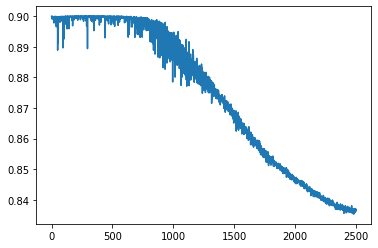

In [38]:
plt.plot(val_acc)